In [1]:
import numpy as np
import os
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


# load ndarray

In [2]:
def load_image(path):
    image_list=[]
    for filename in os.listdir(path):
        image=load_img(os.path.join(path,filename))
        image=img_to_array(image) #to ndarray
        image_list.append(image)
    return np.asarray(image_list,'float') 

In [3]:
trainA=load_image('horse2zebra//trainA')
testA=load_image('horse2zebra//testA')
trainB=load_image('horse2zebra//trainB')
testB=load_image('horse2zebra//testB')
A=np.vstack((trainA,testA))
B=np.vstack((trainB,testB))
print(A.shape,B.shape)

(1187, 256, 256, 3) (1474, 256, 256, 3)


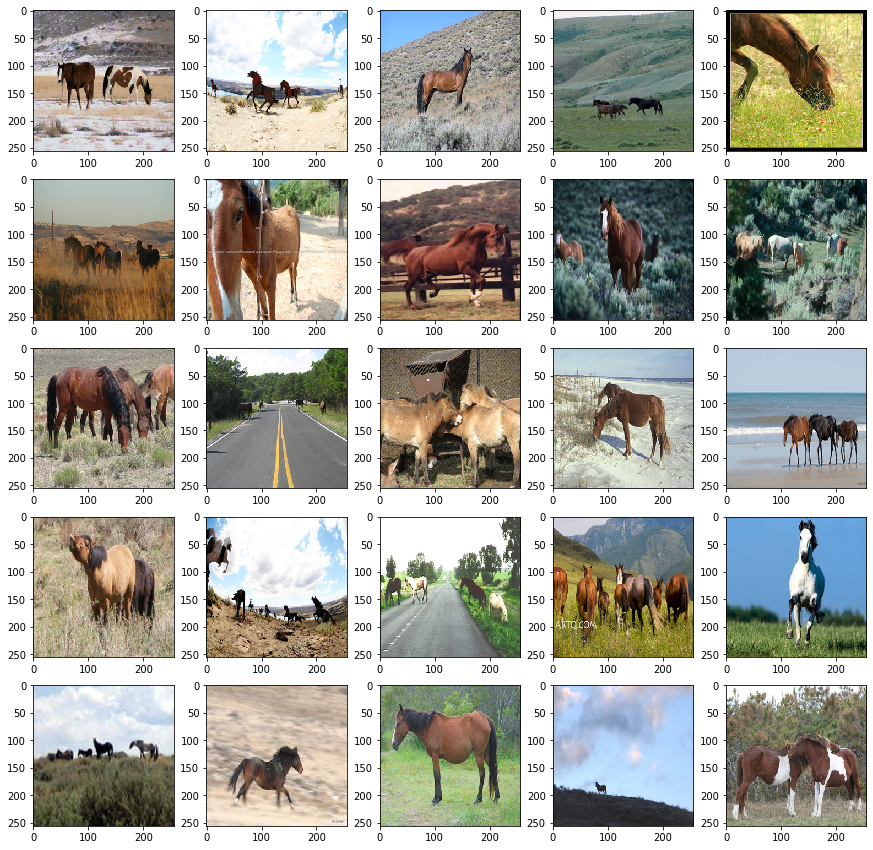

In [4]:
randi=np.random.randint(0,A.shape[0],25)
randA=A[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randA[i].astype(int))

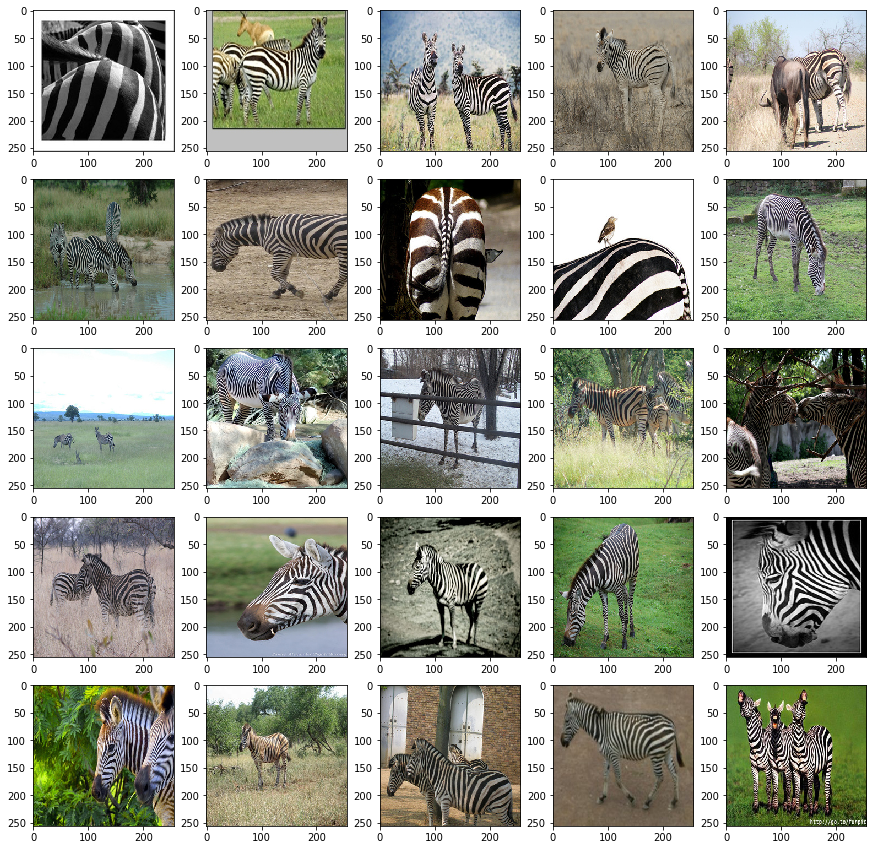

In [5]:
randi=np.random.randint(0,B.shape[0],25)
randB=B[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randB[i].astype(int))

# Discriminator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  
implement the PatchGAN discriminator  

GAN一般情況下的網絡結構，在一些人的實驗中已經表明對於要求高分辨率、高細節保持的圖像領域中並不適合，有些人根據這一情況設計了PatchGAN的思路。這種GAN的差別主要是在於Discriminator上，一般的GAN是只需要輸出一個true or fasle 的矢量，這是代表對整張圖像的評價；但是PatchGAN輸出的是一個N x N的矩陣，這個N x N的矩陣的每一個元素，比如a(i,j) 只有True or False 這兩個選擇（label 是N x N的矩陣，每一個元素是True 或者False），這樣的結果往往是通過卷積層來達到的，因為逐次疊加的捲積層最終輸出的這個N x N 的矩陣，其中的每一個元素，實際上代表著原圖中的一個比較大的感受野，也就是說對應著原圖中的一個Patch，因此具有這樣結構以及這樣輸出的GAN被稱之為Patch GAN。 

Native keras doesn't go well with tf.keras. 若用tf，則InstanceNormalization會無法執行。  

__pip install git+https://www.github.com/keras-team/keras-contrib.git 安裝instancenormalization__  

In [6]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [7]:
def discriminator(image_shape):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    x_input=keras.layers.Input(shape=image_shape)
    #to(128*128*64)
    x=keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x_input)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(64*64*128)
    x=keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(32*32*256)
    x=keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*512)
    x=keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Conv2D(512,(4,4),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*1),N*N為16*16*1
    x=keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x) 
    
    model=keras.Model(inputs=x_input,outputs=x)
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[0.5])
    return model

In [8]:
model=discriminator(A[0].shape)
model.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       

# Generator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  

### Residual NN

In [9]:
def residual_block(filters,input_layer):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    #1st
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #2nd
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    
    x=keras.layers.Concatenate()([x,input_layer])
    return x

![generator](https://hardikbansal.github.io/CycleGANBlog/images/Generator.jpg)  
First downsampling then upsmapling,interpreting the encoding with a number of ResNet layers  

In [10]:
def generator(image_shape,residual_num=3):
    init=keras.initializers.RandomNormal(stddev=0.02)
    x_input=keras.layers.Input(shape=image_shape)
    
    #downsampling
    #to(256*256*64)
    x=keras.layers.Conv2D(64,(7,7),padding='same',kernel_initializer=init)(x_input)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(128*128*128)
    x=keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(64*64*256)
    x=keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    
    for i in range(residual_num):
        x=residual_block(256,x)
        
    #upsampling
    #to(128*128*128)
    x=keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*64)
    x=keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*3)
    x=keras.layers.Conv2D(3,(7,7),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('tanh')(x)
    
    model=keras.Model(inputs=x_input,outputs=x)
    
    return model

In [11]:
model=generator(A[0].shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 256, 256, 64) 128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           instance_normalization_5[0][0]   
____________________________________________________________________________________________

# composite NN (目的是為了要訓練g_model)
假設我們要訓練一個A->B的generator  
updated via the weighted sum of four loss function:  
* __Adversarial Loss__: Domain-A -> Generator-B -> Domain-B -> Discriminator-B -> \[real/fake\]
* __Identity Loss__: Domain-B -> Generator-B -> Domain-B
* __Forward Cycle Loss__: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A
* __Backward Cycle Loss__: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B

input is Domain-A & Domain-B  

In [12]:
#Domain A->Domain B ; g_modelB:image to Domain B
def composite(g_modelAtoB,g_modelBtoA,d_model,input_shape): 
    g_modelAtoB.trainable=True 
    g_modelBtoA.trainable=False
    d_model.trainable=False
    
    A_input=keras.layers.Input(shape=input_shape)
    B_input=keras.layers.Input(shape=input_shape)
    #adversarial loss
    adversary_output=g_modelAtoB(A_input)
    adversary_output=d_model(adversary_output)
    #identity loss
    identity_output=g_modelAtoB(B_input)
    #forward cycle loss
    forward_output=g_modelAtoB(A_input)
    forward_output=g_modelBtoA(forward_output)
    #backward cycle loss
    backward_output=g_modelBtoA(B_input)
    backward_output=g_modelAtoB(backward_output)
    
    model=keras.Model(inputs=[A_input,B_input],outputs=[adversary_output,identity_output,forward_output,backward_output])
    model.compile(loss=['mse','mae','mae','mae'],optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[1,5,10,10])
    return model

# Image_Generator(for Discriminator)

In [13]:
def real_image_generator(dataset,num,patch_shape):
    randi=np.random.randint(0,dataset.shape[0],num)
    x=dataset[randi]
    y=np.ones((num,)+patch_shape)
    return x,y

In [14]:
#圖片生圖片
def fake_image_generator(g_model,images,patch_shape): 
    x=g_model.predict(images)
    y=np.zeros((images.shape[0],)+patch_shape)
    return x,y

# Training

In [15]:
#會使用舊的image
def update_fake_image(pool,images,pool_size=50):
    select=[]
    for image in images:
        if len(pool)<pool_size:
            pool.append(image)
            select.append(image)
        elif np.random.random()<0.5:
            select.append(image)
        else: #use old
            randi=np.random.randint(0,pool_size)
            select.append(pool[randi])
            pool[randi]=image
    return np.asarray(select,'float')

要train 4個NN:  
![cycleGAN](https://i.imgur.com/OH7Tvpy.png)  

In [16]:
def fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,epochs=100,batch_size=1):
    batchs=A.shape[0]//batch_size
    poolA,poolB=[],[]
    patch_shape=d_modelA.output_shape[1:]
    for epoch in range(1,epochs+1):
        for batch in range(1,batchs+1):
            #domain images
            realA_x,realA_y=real_image_generator(A,batch_size,patch_shape)
            realB_x,realB_y=real_image_generator(B,batch_size,patch_shape)
            fakeA_x,fakeA_y=fake_image_generator(g_modelBtoA,realB_x,patch_shape)
            fakeB_x,fakeB_y=fake_image_generator(g_modelAtoB,realA_x,patch_shape)
            fakeA_x=update_fake_image(poolA,fakeA_x)
            fakeB_x=update_fake_image(poolB,fakeB_x)
            #update generator_B->A
            loss_g_BA,_,_,_,_=c_modelBtoA.train_on_batch(x=[realB_x,realA_x],y=[realA_y,realA_x,realB_x,realA_x])
            #update discriminator_A
            loss_d1_A=d_modelA.train_on_batch(x=realA_x,y=realA_y)
            loss_d2_A=d_modelA.train_on_batch(x=fakeA_x,y=fakeA_y)
            #update generator_A->B
            loss_g_AB,_,_,_,_=c_modelAtoB.train_on_batch(x=[realA_x,realB_x],y=[realB_y,realB_x,realA_x,realB_x])
            #update discriminator_B
            loss_d1_B=d_modelB.train_on_batch(x=realB_x,y=realB_y)
            loss_d2_B=d_modelB.train_on_batch(x=fakeB_x,y=fakeB_y)
            print('epoch{} {}/{} dA[{:.2f} {:.2f}] dB[{:.2f} {:.2f}] gA[{:.2f}] gB[{:.2f}]'.format(epoch,batch,batchs,loss_d1_A,loss_d2_A,loss_d1_B,loss_d2_B,loss_g_BA,loss_g_AB))
        if epoch%5==0:
            summarize(epoch,g_modelAtoB,g_modelBtoA)

In [17]:
#save img,save model
def summarize(epoch,g_modelAtoB,g_modelBtoA):
    in_A,_=real_image_generator(A,5,(0,))
    out_B,_=fake_image_generator(g_modelAtoB,in_A,(0,))
    in_B,_=real_image_generator(B,5,(0,))
    out_A,_=fake_image_generator(g_modelBtoA,in_B,(0,))
    in_A=(in_A+1)/2
    out_B=(out_B+1)/2
    in_B=(in_B+1)/2
    out_A=(out_A+1)/2
    
    plt.figure(figsize=(15,12))
    #Domain A-> Domain B
    for i in range(5):
        plt.subplot(4,5,i+1)
        plt.imshow(in_A[i])
        plt.axis('off')
        plt.title('real A')
        plt.subplot(4,5,i+1+5)
        plt.imshow(out_B[i])
        plt.axis('off')
        plt.title('fake B')
    #B->A
    for i in range(5):
        plt.subplot(4,5,10+i+1)
        plt.imshow(in_B[i])
        plt.axis('off')
        plt.title('real B')
        plt.subplot(4,5,10+i+1+5)
        plt.imshow(out_A[i])
        plt.axis('off')
        plt.title('fake A')
    plt.savefig('cycleGAN horse-zebra//epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_modelAtoB.save('cycleGAN horse-zebra//generator AtoB epoch{}.h5'.format(epoch))
    g_modelBtoA.save('cycleGAN horse-zebra//generator BtoA epoch{}.h5'.format(epoch))

# Start GAN

### load A&B from [0,255] to [-1,1]

In [18]:
A=(A-127.5)/127.5
B=(B-127.5)/127.5

### train

In [19]:
g_modelAtoB=generator(A[0].shape)
g_modelBtoA=generator(B[0].shape)
d_modelA=discriminator(A[0].shape)
d_modelB=discriminator(B[0].shape)
c_modelAtoB=composite(g_modelAtoB,g_modelBtoA,d_modelB,A[0].shape)
c_modelBtoA=composite(g_modelBtoA,g_modelAtoB,d_modelA,B[0].shape)

fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,epochs=100)

/home/dorawu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Dis

epoch1 1/1187 dA[1.81 0.61] dB[1.39 0.68] gA[17.80] gB[17.11]
epoch1 2/1187 dA[4.55 1.68] dB[2.10 0.69] gA[18.31] gB[16.53]
epoch1 3/1187 dA[1.02 1.95] dB[2.39 1.89] gA[17.95] gB[16.80]
epoch1 4/1187 dA[6.39 0.90] dB[1.54 4.80] gA[19.37] gB[17.29]
epoch1 5/1187 dA[3.09 0.86] dB[1.59 1.19] gA[17.22] gB[16.63]
epoch1 6/1187 dA[3.82 0.77] dB[1.40 2.52] gA[15.89] gB[15.08]
epoch1 7/1187 dA[1.98 1.51] dB[1.31 2.64] gA[15.14] gB[15.29]
epoch1 8/1187 dA[1.43 2.27] dB[2.10 1.58] gA[15.04] gB[17.50]
epoch1 9/1187 dA[4.82 1.80] dB[1.56 1.40] gA[16.20] gB[14.34]
epoch1 10/1187 dA[5.16 1.37] dB[2.56 1.55] gA[16.04] gB[15.40]
epoch1 11/1187 dA[1.97 2.17] dB[0.77 1.31] gA[13.50] gB[12.62]
epoch1 12/1187 dA[0.94 0.95] dB[0.96 1.17] gA[12.88] gB[13.61]
epoch1 13/1187 dA[0.85 0.96] dB[0.58 0.73] gA[12.85] gB[12.20]
epoch1 14/1187 dA[1.14 0.76] dB[0.53 0.63] gA[12.83] gB[13.54]
epoch1 15/1187 dA[1.09 0.90] dB[0.61 1.20] gA[11.55] gB[12.60]
epoch1 16/1187 dA[0.61 0.67] dB[0.63 1.33] gA[9.71] gB[11.05]
ep

epoch1 134/1187 dA[0.16 0.08] dB[0.14 0.09] gA[7.62] gB[7.56]
epoch1 135/1187 dA[0.10 0.08] dB[0.20 0.19] gA[7.21] gB[6.98]
epoch1 136/1187 dA[0.08 0.07] dB[0.22 0.17] gA[7.17] gB[6.93]
epoch1 137/1187 dA[0.20 0.06] dB[0.17 0.18] gA[6.16] gB[6.18]
epoch1 138/1187 dA[0.09 0.12] dB[0.14 0.11] gA[5.89] gB[5.42]
epoch1 139/1187 dA[0.14 0.10] dB[0.16 0.23] gA[9.23] gB[8.90]
epoch1 140/1187 dA[0.11 0.06] dB[0.14 0.08] gA[9.26] gB[8.45]
epoch1 141/1187 dA[0.09 0.08] dB[0.15 0.11] gA[13.04] gB[12.16]
epoch1 142/1187 dA[0.14 0.18] dB[0.29 0.26] gA[7.84] gB[8.45]
epoch1 143/1187 dA[0.14 0.12] dB[0.13 0.26] gA[6.98] gB[6.27]
epoch1 144/1187 dA[0.22 0.12] dB[0.25 0.20] gA[6.27] gB[5.76]
epoch1 145/1187 dA[0.26 0.14] dB[0.21 0.18] gA[5.65] gB[5.34]
epoch1 146/1187 dA[0.14 0.09] dB[0.14 0.13] gA[7.51] gB[8.17]
epoch1 147/1187 dA[0.15 0.12] dB[0.16 0.10] gA[6.63] gB[6.16]
epoch1 148/1187 dA[0.07 0.15] dB[0.10 0.24] gA[6.38] gB[6.58]
epoch1 149/1187 dA[0.13 0.12] dB[0.20 0.11] gA[9.76] gB[8.55]
epoch1

epoch1 266/1187 dA[0.29 0.21] dB[0.15 0.07] gA[6.58] gB[7.32]
epoch1 267/1187 dA[0.10 0.20] dB[0.20 0.08] gA[6.20] gB[6.53]
epoch1 268/1187 dA[0.16 0.13] dB[0.16 0.02] gA[4.89] gB[5.31]
epoch1 269/1187 dA[0.28 0.28] dB[0.31 0.12] gA[5.78] gB[6.17]
epoch1 270/1187 dA[0.22 0.17] dB[0.07 0.09] gA[8.64] gB[7.46]
epoch1 271/1187 dA[0.15 0.02] dB[0.05 0.05] gA[10.11] gB[10.39]
epoch1 272/1187 dA[0.06 0.38] dB[0.20 0.09] gA[6.14] gB[6.38]
epoch1 273/1187 dA[0.18 0.13] dB[0.08 0.09] gA[6.03] gB[6.20]
epoch1 274/1187 dA[0.28 0.29] dB[0.04 0.13] gA[7.14] gB[7.32]
epoch1 275/1187 dA[0.13 0.11] dB[0.11 0.11] gA[7.03] gB[7.01]
epoch1 276/1187 dA[0.29 0.27] dB[0.14 0.04] gA[5.85] gB[6.03]
epoch1 277/1187 dA[0.08 0.22] dB[0.06 0.06] gA[5.12] gB[5.98]
epoch1 278/1187 dA[0.14 0.19] dB[0.05 0.06] gA[8.43] gB[8.57]
epoch1 279/1187 dA[0.19 0.31] dB[0.07 0.04] gA[8.34] gB[7.35]
epoch1 280/1187 dA[0.36 0.21] dB[0.05 0.05] gA[7.65] gB[7.55]
epoch1 281/1187 dA[0.13 0.19] dB[0.06 0.05] gA[5.67] gB[5.91]
epoch1

epoch1 399/1187 dA[0.12 0.24] dB[0.22 0.06] gA[5.66] gB[6.38]
epoch1 400/1187 dA[0.32 0.32] dB[0.23 0.45] gA[5.97] gB[5.39]
epoch1 401/1187 dA[0.12 0.02] dB[0.22 0.13] gA[5.83] gB[5.36]
epoch1 402/1187 dA[0.24 0.35] dB[0.39 0.17] gA[5.66] gB[5.26]
epoch1 403/1187 dA[0.17 0.15] dB[0.10 0.11] gA[5.28] gB[4.79]
epoch1 404/1187 dA[0.22 0.09] dB[0.15 0.11] gA[5.93] gB[6.01]
epoch1 405/1187 dA[0.19 0.19] dB[0.18 0.24] gA[5.76] gB[4.99]
epoch1 406/1187 dA[0.16 0.25] dB[0.13 0.22] gA[6.17] gB[5.58]
epoch1 407/1187 dA[0.11 0.04] dB[0.31 0.12] gA[10.17] gB[7.41]
epoch1 408/1187 dA[0.17 0.14] dB[0.11 0.33] gA[7.73] gB[7.21]
epoch1 409/1187 dA[0.10 0.17] dB[0.31 0.14] gA[8.05] gB[7.22]
epoch1 410/1187 dA[0.12 0.14] dB[0.16 0.09] gA[5.58] gB[5.68]
epoch1 411/1187 dA[0.12 0.07] dB[0.17 0.11] gA[6.76] gB[7.02]
epoch1 412/1187 dA[0.18 0.19] dB[0.03 0.29] gA[6.79] gB[7.60]
epoch1 413/1187 dA[0.12 0.04] dB[0.18 0.06] gA[6.58] gB[5.29]
epoch1 414/1187 dA[0.08 0.25] dB[0.17 0.13] gA[4.39] gB[4.26]
epoch1 

epoch1 531/1187 dA[0.08 0.07] dB[0.11 0.05] gA[10.50] gB[9.81]
epoch1 532/1187 dA[0.08 0.16] dB[0.10 0.14] gA[5.91] gB[6.38]
epoch1 533/1187 dA[0.13 0.25] dB[0.27 0.18] gA[6.12] gB[7.25]
epoch1 534/1187 dA[0.14 0.06] dB[0.21 0.10] gA[5.40] gB[4.89]
epoch1 535/1187 dA[0.23 0.06] dB[0.08 0.12] gA[8.15] gB[7.03]
epoch1 536/1187 dA[0.11 0.14] dB[0.14 0.37] gA[4.28] gB[4.04]
epoch1 537/1187 dA[0.10 0.36] dB[0.40 0.06] gA[7.14] gB[6.52]
epoch1 538/1187 dA[0.44 0.06] dB[0.03 0.32] gA[6.08] gB[5.80]
epoch1 539/1187 dA[0.10 0.24] dB[0.18 0.07] gA[6.43] gB[6.81]
epoch1 540/1187 dA[0.11 0.20] dB[0.04 0.10] gA[6.33] gB[6.66]
epoch1 541/1187 dA[0.38 0.38] dB[0.21 0.19] gA[5.95] gB[5.23]
epoch1 542/1187 dA[0.15 0.11] dB[0.10 0.10] gA[5.27] gB[6.01]
epoch1 543/1187 dA[0.11 0.04] dB[0.17 0.04] gA[7.40] gB[6.63]
epoch1 544/1187 dA[0.06 0.21] dB[0.20 0.32] gA[6.17] gB[5.71]
epoch1 545/1187 dA[0.10 0.09] dB[0.06 0.13] gA[5.30] gB[5.17]
epoch1 546/1187 dA[0.29 0.17] dB[0.14 0.10] gA[5.73] gB[5.21]
epoch1 

epoch1 664/1187 dA[0.13 0.13] dB[0.21 0.11] gA[4.73] gB[5.07]
epoch1 665/1187 dA[0.09 0.21] dB[0.08 0.11] gA[6.34] gB[5.65]
epoch1 666/1187 dA[0.22 0.04] dB[0.21 0.12] gA[7.69] gB[7.20]
epoch1 667/1187 dA[0.07 0.18] dB[0.05 0.17] gA[5.12] gB[4.70]
epoch1 668/1187 dA[0.11 0.15] dB[0.36 0.07] gA[5.16] gB[5.58]
epoch1 669/1187 dA[0.08 0.07] dB[0.03 0.05] gA[7.82] gB[8.91]
epoch1 670/1187 dA[0.08 0.14] dB[0.09 0.05] gA[7.15] gB[7.88]
epoch1 671/1187 dA[0.14 0.12] dB[0.17 0.03] gA[5.46] gB[5.23]
epoch1 672/1187 dA[0.06 0.13] dB[0.05 0.51] gA[5.47] gB[4.63]
epoch1 673/1187 dA[0.15 0.16] dB[0.25 0.04] gA[4.79] gB[4.27]
epoch1 674/1187 dA[0.14 0.07] dB[0.12 0.22] gA[6.41] gB[5.97]
epoch1 675/1187 dA[0.15 0.06] dB[0.20 0.26] gA[5.57] gB[4.76]
epoch1 676/1187 dA[0.17 0.16] dB[0.31 0.11] gA[5.55] gB[4.56]
epoch1 677/1187 dA[0.08 0.17] dB[0.24 0.09] gA[3.82] gB[4.65]
epoch1 678/1187 dA[0.13 0.22] dB[0.08 0.27] gA[5.76] gB[4.75]
epoch1 679/1187 dA[0.11 0.08] dB[0.13 0.16] gA[5.70] gB[5.43]
epoch1 6

epoch1 797/1187 dA[0.04 0.09] dB[0.09 0.16] gA[6.64] gB[6.43]
epoch1 798/1187 dA[0.25 0.11] dB[0.19 0.08] gA[5.16] gB[5.48]
epoch1 799/1187 dA[0.05 0.12] dB[0.02 0.04] gA[7.05] gB[6.77]
epoch1 800/1187 dA[0.21 0.24] dB[0.37 0.16] gA[5.59] gB[5.72]
epoch1 801/1187 dA[0.17 0.06] dB[0.08 0.12] gA[10.54] gB[10.09]
epoch1 802/1187 dA[0.21 0.22] dB[0.06 0.01] gA[5.54] gB[6.04]
epoch1 803/1187 dA[0.16 0.18] dB[0.32 0.07] gA[5.06] gB[4.80]
epoch1 804/1187 dA[0.19 0.21] dB[0.03 0.14] gA[6.23] gB[6.09]
epoch1 805/1187 dA[0.14 0.16] dB[0.38 0.12] gA[4.48] gB[5.42]
epoch1 806/1187 dA[0.07 0.11] dB[0.02 0.10] gA[8.40] gB[8.49]
epoch1 807/1187 dA[0.28 0.12] dB[0.37 0.35] gA[6.40] gB[6.30]
epoch1 808/1187 dA[0.07 0.15] dB[0.05 0.01] gA[4.71] gB[5.74]
epoch1 809/1187 dA[0.14 0.12] dB[0.22 0.24] gA[4.81] gB[4.46]
epoch1 810/1187 dA[0.09 0.03] dB[0.22 0.22] gA[6.11] gB[5.24]
epoch1 811/1187 dA[0.06 0.13] dB[0.08 0.08] gA[4.63] gB[4.47]
epoch1 812/1187 dA[0.05 0.05] dB[0.21 0.14] gA[6.61] gB[6.15]
epoch1

epoch1 930/1187 dA[0.11 0.13] dB[0.07 0.04] gA[5.66] gB[4.84]
epoch1 931/1187 dA[0.17 0.15] dB[0.02 0.13] gA[4.87] gB[4.87]
epoch1 932/1187 dA[0.15 0.18] dB[0.06 0.04] gA[3.82] gB[3.75]
epoch1 933/1187 dA[0.10 0.10] dB[0.20 0.17] gA[4.97] gB[5.04]
epoch1 934/1187 dA[0.14 0.08] dB[0.12 0.32] gA[6.00] gB[5.27]
epoch1 935/1187 dA[0.14 0.30] dB[0.19 0.12] gA[5.72] gB[5.66]
epoch1 936/1187 dA[0.09 0.11] dB[0.21 0.24] gA[4.39] gB[4.04]
epoch1 937/1187 dA[0.08 0.18] dB[0.04 0.07] gA[5.32] gB[5.32]
epoch1 938/1187 dA[0.16 0.03] dB[0.19 0.09] gA[7.51] gB[6.37]
epoch1 939/1187 dA[0.03 0.24] dB[0.23 0.17] gA[6.73] gB[6.94]
epoch1 940/1187 dA[0.19 0.08] dB[0.03 0.08] gA[5.52] gB[5.52]
epoch1 941/1187 dA[0.19 0.21] dB[0.01 0.05] gA[4.79] gB[4.89]
epoch1 942/1187 dA[0.12 0.05] dB[0.06 0.01] gA[5.66] gB[5.81]
epoch1 943/1187 dA[0.02 0.14] dB[0.44 0.29] gA[8.36] gB[8.23]
epoch1 944/1187 dA[0.13 0.07] dB[0.21 0.18] gA[5.80] gB[5.33]
epoch1 945/1187 dA[0.25 0.23] dB[0.17 0.25] gA[4.61] gB[4.15]
epoch1 9

epoch1 1062/1187 dA[0.13 0.04] dB[0.15 0.12] gA[3.99] gB[3.11]
epoch1 1063/1187 dA[0.04 0.03] dB[0.08 0.05] gA[8.95] gB[9.12]
epoch1 1064/1187 dA[0.21 0.18] dB[0.23 0.19] gA[7.71] gB[6.38]
epoch1 1065/1187 dA[0.11 0.08] dB[0.10 0.03] gA[4.62] gB[4.52]
epoch1 1066/1187 dA[0.09 0.10] dB[0.20 0.08] gA[6.05] gB[6.13]
epoch1 1067/1187 dA[0.02 0.06] dB[0.01 0.11] gA[6.63] gB[6.83]
epoch1 1068/1187 dA[0.14 0.20] dB[0.26 0.08] gA[4.95] gB[4.94]
epoch1 1069/1187 dA[0.10 0.03] dB[0.08 0.29] gA[6.19] gB[5.05]
epoch1 1070/1187 dA[0.04 0.10] dB[0.36 0.13] gA[5.90] gB[5.53]
epoch1 1071/1187 dA[0.21 0.13] dB[0.05 0.04] gA[6.17] gB[6.56]
epoch1 1072/1187 dA[0.25 0.20] dB[0.05 0.03] gA[4.60] gB[4.63]
epoch1 1073/1187 dA[0.01 0.07] dB[0.05 0.16] gA[13.24] gB[13.00]
epoch1 1074/1187 dA[0.05 0.04] dB[0.28 0.21] gA[5.36] gB[4.11]
epoch1 1075/1187 dA[0.05 0.05] dB[0.16 0.30] gA[4.60] gB[3.74]
epoch1 1076/1187 dA[0.20 0.18] dB[0.09 0.14] gA[5.60] gB[4.79]
epoch1 1077/1187 dA[0.04 0.14] dB[0.38 0.07] gA[4.54]

epoch2 6/1187 dA[0.15 0.10] dB[0.18 0.46] gA[7.50] gB[6.90]
epoch2 7/1187 dA[0.30 0.13] dB[0.05 0.07] gA[7.65] gB[7.03]
epoch2 8/1187 dA[0.06 0.11] dB[0.32 0.03] gA[5.69] gB[5.19]
epoch2 9/1187 dA[0.03 0.03] dB[0.09 0.06] gA[7.57] gB[6.53]
epoch2 10/1187 dA[0.21 0.06] dB[0.02 0.12] gA[5.52] gB[4.72]
epoch2 11/1187 dA[0.05 0.34] dB[0.02 0.03] gA[4.79] gB[5.09]
epoch2 12/1187 dA[0.08 0.02] dB[0.07 0.01] gA[5.32] gB[5.31]
epoch2 13/1187 dA[0.21 0.09] dB[0.31 0.21] gA[4.28] gB[4.21]
epoch2 14/1187 dA[0.04 0.16] dB[0.02 0.16] gA[4.75] gB[4.50]
epoch2 15/1187 dA[0.40 0.06] dB[0.20 0.15] gA[4.84] gB[5.12]
epoch2 16/1187 dA[0.53 0.09] dB[0.05 0.14] gA[7.47] gB[5.95]
epoch2 17/1187 dA[0.20 0.27] dB[0.19 0.05] gA[5.30] gB[4.72]
epoch2 18/1187 dA[0.10 0.13] dB[0.15 0.15] gA[5.66] gB[5.94]
epoch2 19/1187 dA[0.26 0.33] dB[0.09 0.10] gA[6.01] gB[6.50]
epoch2 20/1187 dA[0.08 0.08] dB[0.02 0.03] gA[7.96] gB[7.18]
epoch2 21/1187 dA[0.13 0.02] dB[0.39 0.15] gA[7.58] gB[7.66]
epoch2 22/1187 dA[0.27 0.09]

epoch2 140/1187 dA[0.01 0.02] dB[0.10 0.19] gA[7.05] gB[6.00]
epoch2 141/1187 dA[0.10 0.11] dB[0.18 0.05] gA[6.45] gB[6.17]
epoch2 142/1187 dA[0.02 0.05] dB[0.01 0.03] gA[7.61] gB[5.83]
epoch2 143/1187 dA[0.32 0.10] dB[0.05 0.04] gA[4.67] gB[4.70]
epoch2 144/1187 dA[0.04 0.38] dB[0.05 0.01] gA[7.74] gB[9.74]
epoch2 145/1187 dA[0.02 0.03] dB[0.54 0.13] gA[6.55] gB[7.74]
epoch2 146/1187 dA[0.13 0.59] dB[0.17 0.29] gA[6.66] gB[8.12]
epoch2 147/1187 dA[0.14 0.03] dB[0.12 0.15] gA[5.57] gB[4.65]
epoch2 148/1187 dA[0.32 0.08] dB[0.02 0.10] gA[6.33] gB[6.03]
epoch2 149/1187 dA[0.04 0.17] dB[0.05 0.04] gA[5.37] gB[5.41]
epoch2 150/1187 dA[0.02 0.04] dB[0.04 0.01] gA[4.78] gB[5.83]
epoch2 151/1187 dA[0.42 0.06] dB[0.10 0.15] gA[5.98] gB[4.62]
epoch2 152/1187 dA[0.08 0.11] dB[0.02 0.10] gA[4.05] gB[4.55]
epoch2 153/1187 dA[0.06 0.20] dB[0.45 0.06] gA[5.88] gB[6.06]
epoch2 154/1187 dA[0.34 0.11] dB[0.05 0.08] gA[10.65] gB[7.72]
epoch2 155/1187 dA[0.34 0.18] dB[0.37 0.10] gA[5.30] gB[4.52]
epoch2 

epoch2 273/1187 dA[0.08 0.44] dB[0.22 0.06] gA[6.63] gB[7.80]
epoch2 274/1187 dA[0.16 0.02] dB[0.01 0.03] gA[5.46] gB[4.91]
epoch2 275/1187 dA[0.08 0.02] dB[0.02 0.03] gA[6.00] gB[6.42]
epoch2 276/1187 dA[0.04 0.20] dB[0.01 0.02] gA[5.37] gB[6.88]
epoch2 277/1187 dA[0.15 0.08] dB[0.03 0.01] gA[6.26] gB[5.46]
epoch2 278/1187 dA[0.47 0.17] dB[0.40 0.19] gA[5.00] gB[4.03]
epoch2 279/1187 dA[0.01 0.34] dB[0.02 0.13] gA[3.86] gB[3.98]
epoch2 280/1187 dA[0.19 0.05] dB[0.23 0.12] gA[6.28] gB[5.21]
epoch2 281/1187 dA[0.26 0.15] dB[0.06 0.18] gA[4.22] gB[4.23]
epoch2 282/1187 dA[0.17 0.18] dB[0.02 0.04] gA[5.22] gB[5.35]
epoch2 283/1187 dA[0.14 0.18] dB[0.42 0.13] gA[5.98] gB[5.49]
epoch2 284/1187 dA[0.10 0.22] dB[0.07 0.10] gA[4.49] gB[4.76]
epoch2 285/1187 dA[0.09 0.01] dB[0.10 0.29] gA[4.15] gB[3.20]
epoch2 286/1187 dA[0.17 0.07] dB[0.20 0.04] gA[4.43] gB[4.33]
epoch2 287/1187 dA[0.02 0.12] dB[0.08 0.06] gA[3.94] gB[4.15]
epoch2 288/1187 dA[0.22 0.16] dB[0.04 0.11] gA[5.54] gB[4.48]
epoch2 2

epoch2 406/1187 dA[0.17 0.25] dB[0.41 0.18] gA[5.35] gB[5.53]
epoch2 407/1187 dA[0.14 0.11] dB[0.09 0.06] gA[4.37] gB[3.99]
epoch2 408/1187 dA[0.08 0.15] dB[0.06 0.08] gA[6.89] gB[8.33]
epoch2 409/1187 dA[0.10 0.13] dB[0.06 0.02] gA[5.42] gB[5.46]
epoch2 410/1187 dA[0.13 0.06] dB[0.05 0.01] gA[4.91] gB[5.38]
epoch2 411/1187 dA[0.02 0.31] dB[0.40 0.25] gA[10.31] gB[10.52]
epoch2 412/1187 dA[0.15 0.04] dB[0.04 0.13] gA[5.15] gB[4.05]
epoch2 413/1187 dA[0.30 0.31] dB[0.16 0.05] gA[5.69] gB[4.88]
epoch2 414/1187 dA[0.07 0.03] dB[0.19 0.07] gA[4.38] gB[5.40]
epoch2 415/1187 dA[0.08 0.12] dB[0.10 0.06] gA[7.52] gB[6.09]
epoch2 416/1187 dA[0.04 0.02] dB[0.02 0.05] gA[9.73] gB[8.57]
epoch2 417/1187 dA[0.02 0.15] dB[0.57 0.18] gA[5.11] gB[5.27]
epoch2 418/1187 dA[0.11 0.04] dB[0.03 0.07] gA[6.50] gB[6.28]
epoch2 419/1187 dA[0.40 0.09] dB[0.24 0.02] gA[4.78] gB[3.63]
epoch2 420/1187 dA[0.04 0.08] dB[0.03 0.07] gA[5.77] gB[5.15]
epoch2 421/1187 dA[0.19 0.10] dB[0.10 0.28] gA[3.95] gB[3.78]
epoch2

epoch2 539/1187 dA[0.05 0.03] dB[0.06 0.17] gA[5.27] gB[5.72]
epoch2 540/1187 dA[0.17 0.04] dB[0.14 0.02] gA[5.49] gB[6.30]
epoch2 541/1187 dA[0.11 0.20] dB[0.03 0.12] gA[5.85] gB[6.54]
epoch2 542/1187 dA[0.03 0.27] dB[0.53 0.10] gA[4.59] gB[5.51]
epoch2 543/1187 dA[0.38 0.12] dB[0.07 0.14] gA[5.29] gB[5.72]
epoch2 544/1187 dA[0.03 0.02] dB[0.28 0.06] gA[5.10] gB[4.94]
epoch2 545/1187 dA[0.13 0.14] dB[0.17 0.17] gA[4.74] gB[4.87]
epoch2 546/1187 dA[0.16 0.18] dB[0.02 0.18] gA[4.28] gB[3.57]
epoch2 547/1187 dA[0.02 0.08] dB[0.12 0.17] gA[4.75] gB[4.26]
epoch2 548/1187 dA[0.34 0.01] dB[0.09 0.06] gA[7.04] gB[5.93]
epoch2 549/1187 dA[0.11 0.06] dB[0.01 0.01] gA[5.34] gB[5.44]
epoch2 550/1187 dA[0.05 0.49] dB[0.30 0.14] gA[5.93] gB[5.69]
epoch2 551/1187 dA[0.05 0.02] dB[0.15 0.13] gA[6.15] gB[7.41]
epoch2 552/1187 dA[0.16 0.02] dB[0.02 0.06] gA[6.19] gB[5.08]
epoch2 553/1187 dA[0.34 0.18] dB[0.18 0.17] gA[4.57] gB[4.26]
epoch2 554/1187 dA[0.02 0.53] dB[0.07 0.20] gA[6.21] gB[5.87]
epoch2 5

epoch2 672/1187 dA[0.03 0.13] dB[0.16 0.13] gA[6.78] gB[5.28]
epoch2 673/1187 dA[0.63 0.04] dB[0.20 0.05] gA[5.14] gB[3.41]
epoch2 674/1187 dA[0.07 0.15] dB[0.02 0.02] gA[4.95] gB[4.24]
epoch2 675/1187 dA[0.05 0.37] dB[0.17 0.24] gA[5.41] gB[5.64]
epoch2 676/1187 dA[0.27 0.14] dB[0.09 0.14] gA[6.45] gB[5.52]
epoch2 677/1187 dA[0.15 0.13] dB[0.04 0.04] gA[7.40] gB[8.38]
epoch2 678/1187 dA[0.16 0.09] dB[0.24 0.04] gA[5.08] gB[5.76]
epoch2 679/1187 dA[0.32 0.34] dB[0.08 0.12] gA[5.33] gB[5.56]
epoch2 680/1187 dA[0.11 0.31] dB[0.02 0.02] gA[4.93] gB[3.72]
epoch2 681/1187 dA[0.37 0.13] dB[0.02 0.09] gA[5.40] gB[5.01]
epoch2 682/1187 dA[0.22 0.03] dB[0.24 0.33] gA[4.15] gB[3.44]
epoch2 683/1187 dA[0.16 0.12] dB[0.05 0.02] gA[4.85] gB[4.41]
epoch2 684/1187 dA[0.03 0.16] dB[0.13 0.06] gA[7.82] gB[9.65]
epoch2 685/1187 dA[0.05 0.02] dB[0.03 0.04] gA[5.71] gB[5.22]
epoch2 686/1187 dA[0.12 0.02] dB[0.02 0.03] gA[7.58] gB[6.01]
epoch2 687/1187 dA[0.08 0.08] dB[0.03 0.03] gA[6.18] gB[6.56]
epoch2 6

epoch2 805/1187 dA[0.13 0.15] dB[0.05 0.01] gA[4.40] gB[4.76]
epoch2 806/1187 dA[0.26 0.15] dB[0.30 0.22] gA[4.41] gB[3.72]
epoch2 807/1187 dA[0.04 0.04] dB[0.21 0.23] gA[4.96] gB[4.76]
epoch2 808/1187 dA[0.19 0.05] dB[0.11 0.14] gA[4.30] gB[3.61]
epoch2 809/1187 dA[0.03 0.22] dB[0.23 0.07] gA[3.70] gB[3.95]
epoch2 810/1187 dA[0.08 0.04] dB[0.08 0.30] gA[5.07] gB[4.08]
epoch2 811/1187 dA[0.01 0.02] dB[0.15 0.12] gA[5.66] gB[4.92]
epoch2 812/1187 dA[0.01 0.03] dB[0.10 0.05] gA[5.21] gB[4.01]
epoch2 813/1187 dA[0.25 0.06] dB[0.09 0.10] gA[5.71] gB[4.92]
epoch2 814/1187 dA[0.10 0.10] dB[0.04 0.10] gA[4.51] gB[4.46]
epoch2 815/1187 dA[0.03 0.09] dB[0.05 0.04] gA[8.09] gB[8.99]
epoch2 816/1187 dA[0.02 0.02] dB[0.26 0.24] gA[7.55] gB[6.10]
epoch2 817/1187 dA[0.12 0.04] dB[0.15 0.19] gA[6.31] gB[4.66]
epoch2 818/1187 dA[0.05 0.05] dB[0.05 0.02] gA[9.17] gB[7.67]
epoch2 819/1187 dA[0.28 0.24] dB[0.03 0.02] gA[9.19] gB[11.41]
epoch2 820/1187 dA[0.03 0.03] dB[0.04 0.09] gA[10.21] gB[8.48]
epoch2

epoch2 938/1187 dA[0.05 0.11] dB[0.14 0.11] gA[4.59] gB[4.95]
epoch2 939/1187 dA[0.12 0.01] dB[0.12 0.12] gA[4.70] gB[3.93]
epoch2 940/1187 dA[0.03 0.05] dB[0.06 0.24] gA[5.47] gB[4.37]
epoch2 941/1187 dA[0.03 0.43] dB[0.15 0.09] gA[11.77] gB[12.55]
epoch2 942/1187 dA[0.09 0.03] dB[0.39 0.13] gA[6.27] gB[4.71]
epoch2 943/1187 dA[0.34 0.13] dB[0.02 0.12] gA[5.29] gB[3.95]
epoch2 944/1187 dA[0.01 0.03] dB[0.25 0.12] gA[5.02] gB[4.41]
epoch2 945/1187 dA[0.08 0.03] dB[0.10 0.16] gA[8.42] gB[6.75]
epoch2 946/1187 dA[0.02 0.10] dB[0.02 0.04] gA[5.49] gB[5.95]
epoch2 947/1187 dA[0.21 0.11] dB[0.35 0.15] gA[4.21] gB[4.04]
epoch2 948/1187 dA[0.14 0.20] dB[0.17 0.07] gA[5.96] gB[5.18]
epoch2 949/1187 dA[0.25 0.18] dB[0.01 0.09] gA[5.14] gB[4.05]
epoch2 950/1187 dA[0.02 0.03] dB[0.02 0.13] gA[5.69] gB[5.04]
epoch2 951/1187 dA[0.58 0.12] dB[0.18 0.11] gA[4.65] gB[3.83]
epoch2 952/1187 dA[0.09 0.19] dB[0.05 0.01] gA[3.71] gB[4.39]
epoch2 953/1187 dA[0.09 0.15] dB[0.01 0.01] gA[4.91] gB[5.92]
epoch2

epoch2 1069/1187 dA[0.08 0.04] dB[0.01 0.19] gA[5.39] gB[5.19]
epoch2 1070/1187 dA[0.33 0.05] dB[0.16 0.12] gA[5.91] gB[5.22]
epoch2 1071/1187 dA[0.02 0.34] dB[0.48 0.39] gA[3.98] gB[4.09]
epoch2 1072/1187 dA[0.07 0.01] dB[0.30 0.07] gA[5.38] gB[4.80]
epoch2 1073/1187 dA[0.10 0.06] dB[0.10 0.11] gA[5.60] gB[4.75]
epoch2 1074/1187 dA[0.02 0.13] dB[0.01 0.03] gA[6.57] gB[6.51]
epoch2 1075/1187 dA[0.06 0.03] dB[0.37 0.11] gA[5.25] gB[5.69]
epoch2 1076/1187 dA[0.17 0.04] dB[0.03 0.13] gA[4.85] gB[4.60]
epoch2 1077/1187 dA[0.02 0.18] dB[0.13 0.07] gA[5.12] gB[4.84]
epoch2 1078/1187 dA[0.01 0.02] dB[0.11 0.13] gA[5.11] gB[4.77]
epoch2 1079/1187 dA[0.18 0.02] dB[0.17 0.06] gA[4.83] gB[4.52]
epoch2 1080/1187 dA[0.09 0.39] dB[0.14 0.10] gA[3.53] gB[3.77]
epoch2 1081/1187 dA[0.01 0.02] dB[0.07 0.37] gA[4.64] gB[3.78]
epoch2 1082/1187 dA[0.44 0.17] dB[0.04 0.03] gA[4.79] gB[4.63]
epoch2 1083/1187 dA[0.04 0.07] dB[0.37 0.12] gA[3.87] gB[3.75]
epoch2 1084/1187 dA[0.33 0.04] dB[0.04 0.18] gA[4.83] g

epoch3 13/1187 dA[0.41 0.10] dB[0.14 0.05] gA[5.03] gB[4.92]
epoch3 14/1187 dA[0.01 0.05] dB[0.05 0.10] gA[6.91] gB[6.79]
epoch3 15/1187 dA[0.06 0.07] dB[0.04 0.04] gA[6.81] gB[6.87]
epoch3 16/1187 dA[0.05 0.12] dB[0.05 0.19] gA[5.50] gB[5.53]
epoch3 17/1187 dA[0.06 0.03] dB[0.02 0.03] gA[4.36] gB[5.06]
epoch3 18/1187 dA[0.01 0.06] dB[0.02 0.02] gA[8.76] gB[7.13]
epoch3 19/1187 dA[0.01 0.01] dB[0.03 0.26] gA[8.66] gB[6.94]
epoch3 20/1187 dA[0.12 0.14] dB[0.03 0.04] gA[8.73] gB[7.15]
epoch3 21/1187 dA[0.56 0.18] dB[0.25 0.03] gA[5.25] gB[4.74]
epoch3 22/1187 dA[0.46 0.18] dB[0.04 0.16] gA[5.59] gB[5.16]
epoch3 23/1187 dA[0.07 0.13] dB[0.02 0.02] gA[5.41] gB[5.83]
epoch3 24/1187 dA[0.10 0.05] dB[0.13 0.03] gA[4.44] gB[4.83]
epoch3 25/1187 dA[0.20 0.13] dB[0.03 0.11] gA[5.95] gB[5.50]
epoch3 26/1187 dA[0.15 0.16] dB[0.10 0.03] gA[4.05] gB[3.65]
epoch3 27/1187 dA[0.02 0.12] dB[0.01 0.21] gA[4.99] gB[5.49]
epoch3 28/1187 dA[0.21 0.03] dB[0.13 0.02] gA[4.13] gB[4.08]
epoch3 29/1187 dA[0.01 0

epoch3 147/1187 dA[0.01 0.07] dB[0.40 0.10] gA[5.82] gB[6.24]
epoch3 148/1187 dA[0.09 0.15] dB[0.01 0.39] gA[6.43] gB[4.73]
epoch3 149/1187 dA[0.04 0.05] dB[0.03 0.05] gA[4.99] gB[5.91]
epoch3 150/1187 dA[0.10 0.03] dB[0.26 0.06] gA[3.71] gB[4.32]
epoch3 151/1187 dA[0.05 0.10] dB[0.09 0.12] gA[8.15] gB[9.76]
epoch3 152/1187 dA[0.03 0.03] dB[0.18 0.07] gA[6.58] gB[6.85]
epoch3 153/1187 dA[0.21 0.16] dB[0.20 0.08] gA[5.06] gB[5.15]
epoch3 154/1187 dA[0.03 0.02] dB[0.07 0.11] gA[9.36] gB[8.00]
epoch3 155/1187 dA[0.11 0.04] dB[0.02 0.01] gA[5.37] gB[4.33]
epoch3 156/1187 dA[0.02 0.03] dB[0.28 0.03] gA[6.70] gB[5.51]
epoch3 157/1187 dA[0.02 0.02] dB[0.05 0.22] gA[7.09] gB[4.97]
epoch3 158/1187 dA[0.07 0.01] dB[0.02 0.01] gA[5.82] gB[6.25]
epoch3 159/1187 dA[0.02 0.09] dB[0.06 0.03] gA[9.80] gB[7.73]
epoch3 160/1187 dA[0.04 0.04] dB[0.01 0.08] gA[8.32] gB[8.02]
epoch3 161/1187 dA[0.09 0.01] dB[0.05 0.02] gA[3.73] gB[4.02]
epoch3 162/1187 dA[0.04 0.02] dB[0.19 0.18] gA[4.74] gB[4.17]
epoch3 1

epoch3 280/1187 dA[0.01 0.03] dB[0.13 0.02] gA[5.05] gB[5.13]
epoch3 281/1187 dA[0.11 0.03] dB[0.16 0.02] gA[5.29] gB[4.78]
epoch3 282/1187 dA[0.02 0.10] dB[0.01 0.18] gA[9.42] gB[8.91]
epoch3 283/1187 dA[0.09 0.03] dB[0.16 0.06] gA[7.14] gB[6.65]
epoch3 284/1187 dA[0.13 0.01] dB[0.03 0.09] gA[8.96] gB[8.97]
epoch3 285/1187 dA[0.01 0.03] dB[0.13 0.05] gA[6.73] gB[5.92]
epoch3 286/1187 dA[0.02 0.01] dB[0.02 0.04] gA[5.19] gB[5.07]
epoch3 287/1187 dA[0.03 0.05] dB[0.08 0.02] gA[4.66] gB[5.15]
epoch3 288/1187 dA[0.08 0.12] dB[0.02 0.02] gA[4.52] gB[5.11]
epoch3 289/1187 dA[0.07 0.03] dB[0.01 0.05] gA[6.75] gB[6.81]
epoch3 290/1187 dA[0.02 0.14] dB[0.02 0.01] gA[6.88] gB[6.17]
epoch3 291/1187 dA[0.37 0.04] dB[0.29 0.15] gA[5.81] gB[4.98]
epoch3 292/1187 dA[0.01 0.02] dB[0.12 0.18] gA[8.69] gB[7.28]
epoch3 293/1187 dA[0.25 0.06] dB[0.14 0.21] gA[5.95] gB[5.19]
epoch3 294/1187 dA[0.02 0.13] dB[0.19 0.04] gA[4.72] gB[5.41]
epoch3 295/1187 dA[0.05 0.13] dB[0.09 0.17] gA[3.69] gB[3.61]
epoch3 2

epoch3 413/1187 dA[0.01 0.02] dB[0.08 0.30] gA[3.50] gB[2.93]
epoch3 414/1187 dA[0.01 0.06] dB[0.04 0.02] gA[6.58] gB[5.99]
epoch3 415/1187 dA[0.21 0.02] dB[0.14 0.09] gA[3.22] gB[4.19]
epoch3 416/1187 dA[0.03 0.01] dB[0.14 0.15] gA[3.16] gB[3.77]
epoch3 417/1187 dA[0.13 0.21] dB[0.35 0.04] gA[3.68] gB[3.88]
epoch3 418/1187 dA[0.17 0.07] dB[0.13 0.13] gA[4.33] gB[3.88]
epoch3 419/1187 dA[0.03 0.05] dB[0.05 0.14] gA[6.77] gB[5.51]
epoch3 420/1187 dA[0.10 0.03] dB[0.02 0.03] gA[6.46] gB[5.69]
epoch3 421/1187 dA[0.27 0.18] dB[0.22 0.20] gA[4.35] gB[4.50]
epoch3 422/1187 dA[0.24 0.14] dB[0.03 0.14] gA[5.02] gB[4.34]
epoch3 423/1187 dA[0.04 0.33] dB[0.46 0.03] gA[3.30] gB[4.21]
epoch3 424/1187 dA[0.44 0.04] dB[0.03 0.21] gA[4.33] gB[3.81]
epoch3 425/1187 dA[0.01 0.10] dB[0.07 0.05] gA[6.81] gB[6.16]
epoch3 426/1187 dA[0.13 0.13] dB[0.48 0.08] gA[4.11] gB[4.60]
epoch3 427/1187 dA[0.13 0.02] dB[0.09 0.08] gA[5.79] gB[4.66]
epoch3 428/1187 dA[0.02 0.03] dB[0.12 0.26] gA[6.85] gB[6.33]
epoch3 4

epoch3 546/1187 dA[0.05 0.09] dB[0.09 0.02] gA[5.53] gB[6.03]
epoch3 547/1187 dA[0.31 0.06] dB[0.04 0.06] gA[6.20] gB[6.85]
epoch3 548/1187 dA[0.14 0.35] dB[0.28 0.13] gA[5.39] gB[6.67]
epoch3 549/1187 dA[0.09 0.06] dB[0.31 0.19] gA[3.71] gB[3.68]
epoch3 550/1187 dA[0.02 0.01] dB[0.02 0.07] gA[7.65] gB[6.39]
epoch3 551/1187 dA[0.04 0.01] dB[0.06 0.09] gA[5.84] gB[4.21]
epoch3 552/1187 dA[0.22 0.05] dB[0.31 0.05] gA[3.98] gB[4.30]
epoch3 553/1187 dA[0.02 0.01] dB[0.02 0.16] gA[5.26] gB[4.41]
epoch3 554/1187 dA[0.20 0.23] dB[0.06 0.03] gA[5.69] gB[5.62]
epoch3 555/1187 dA[0.08 0.31] dB[0.16 0.03] gA[4.65] gB[4.93]
epoch3 556/1187 dA[0.06 0.05] dB[0.04 0.07] gA[4.25] gB[4.42]
epoch3 557/1187 dA[0.06 0.07] dB[0.02 0.06] gA[4.14] gB[3.74]
epoch3 558/1187 dA[0.16 0.21] dB[0.07 0.04] gA[5.28] gB[5.37]
epoch3 559/1187 dA[0.20 0.08] dB[0.21 0.02] gA[3.80] gB[3.71]
epoch3 560/1187 dA[0.13 0.16] dB[0.03 0.23] gA[4.17] gB[4.15]
epoch3 561/1187 dA[0.13 0.02] dB[0.32 0.03] gA[4.31] gB[4.43]
epoch3 5

epoch3 679/1187 dA[0.03 0.07] dB[0.22 0.15] gA[3.84] gB[3.86]
epoch3 680/1187 dA[0.03 0.02] dB[0.04 0.03] gA[6.87] gB[6.05]
epoch3 681/1187 dA[0.49 0.10] dB[0.18 0.09] gA[4.83] gB[4.94]
epoch3 682/1187 dA[0.03 0.13] dB[0.03 0.01] gA[7.43] gB[7.14]
epoch3 683/1187 dA[0.23 0.03] dB[0.03 0.34] gA[4.73] gB[3.89]
epoch3 684/1187 dA[0.02 0.13] dB[0.12 0.01] gA[4.63] gB[5.08]
epoch3 685/1187 dA[0.01 0.17] dB[0.02 0.06] gA[6.99] gB[7.56]
epoch3 686/1187 dA[0.28 0.09] dB[0.12 0.10] gA[5.25] gB[5.28]
epoch3 687/1187 dA[0.05 0.02] dB[0.05 0.03] gA[5.18] gB[4.88]
epoch3 688/1187 dA[0.05 0.02] dB[0.13 0.04] gA[10.33] gB[9.24]
epoch3 689/1187 dA[0.11 0.18] dB[0.35 0.20] gA[5.90] gB[5.15]
epoch3 690/1187 dA[0.33 0.16] dB[0.03 0.12] gA[6.52] gB[6.49]
epoch3 691/1187 dA[0.04 0.14] dB[0.19 0.03] gA[4.84] gB[4.48]
epoch3 692/1187 dA[0.32 0.08] dB[0.08 0.19] gA[4.89] gB[4.15]
epoch3 693/1187 dA[0.17 0.24] dB[0.03 0.21] gA[4.98] gB[4.69]
epoch3 694/1187 dA[0.20 0.04] dB[0.05 0.05] gA[3.67] gB[3.68]
epoch3 

epoch3 812/1187 dA[0.25 0.09] dB[0.17 0.10] gA[5.22] gB[4.96]
epoch3 813/1187 dA[0.36 0.07] dB[0.30 0.09] gA[4.36] gB[4.31]
epoch3 814/1187 dA[0.22 0.46] dB[0.06 0.02] gA[6.46] gB[6.50]
epoch3 815/1187 dA[0.03 0.20] dB[0.02 0.02] gA[4.13] gB[4.66]
epoch3 816/1187 dA[0.15 0.01] dB[0.07 0.03] gA[4.52] gB[3.71]
epoch3 817/1187 dA[0.08 0.06] dB[0.01 0.04] gA[5.06] gB[5.07]
epoch3 818/1187 dA[0.02 0.02] dB[0.01 0.08] gA[5.97] gB[5.65]
epoch3 819/1187 dA[0.35 0.20] dB[0.08 0.10] gA[5.11] gB[4.87]
epoch3 820/1187 dA[0.02 0.05] dB[0.17 0.06] gA[5.39] gB[5.19]
epoch3 821/1187 dA[0.02 0.01] dB[0.18 0.11] gA[4.20] gB[4.81]
epoch3 822/1187 dA[0.09 0.12] dB[0.02 0.10] gA[4.58] gB[3.77]
epoch3 823/1187 dA[0.08 0.01] dB[0.21 0.18] gA[7.47] gB[7.87]
epoch3 824/1187 dA[0.01 0.08] dB[0.11 0.08] gA[3.79] gB[3.92]
epoch3 825/1187 dA[0.13 0.05] dB[0.12 0.09] gA[5.07] gB[4.79]
epoch3 826/1187 dA[0.10 0.15] dB[0.13 0.12] gA[5.12] gB[5.79]
epoch3 827/1187 dA[0.04 0.04] dB[0.11 0.02] gA[4.15] gB[3.25]
epoch3 8

epoch3 945/1187 dA[0.02 0.02] dB[0.26 0.16] gA[5.12] gB[3.79]
epoch3 946/1187 dA[0.09 0.04] dB[0.24 0.14] gA[4.53] gB[3.89]
epoch3 947/1187 dA[0.27 0.04] dB[0.09 0.03] gA[7.98] gB[9.97]
epoch3 948/1187 dA[0.02 0.55] dB[0.15 0.05] gA[4.78] gB[5.58]
epoch3 949/1187 dA[0.01 0.03] dB[0.04 0.01] gA[6.59] gB[6.75]
epoch3 950/1187 dA[0.03 0.01] dB[0.02 0.01] gA[7.55] gB[6.24]
epoch3 951/1187 dA[0.52 0.08] dB[0.16 0.12] gA[4.02] gB[3.44]
epoch3 952/1187 dA[0.08 0.02] dB[0.13 0.15] gA[4.89] gB[4.44]
epoch3 953/1187 dA[0.02 0.11] dB[0.01 0.12] gA[7.53] gB[7.93]
epoch3 954/1187 dA[0.22 0.06] dB[0.23 0.05] gA[5.34] gB[5.44]
epoch3 955/1187 dA[0.10 0.13] dB[0.03 0.01] gA[5.54] gB[6.31]
epoch3 956/1187 dA[0.01 0.03] dB[0.18 0.18] gA[4.39] gB[4.04]
epoch3 957/1187 dA[0.08 0.10] dB[0.06 0.05] gA[5.40] gB[5.02]
epoch3 958/1187 dA[0.15 0.07] dB[0.04 0.04] gA[6.37] gB[5.82]
epoch3 959/1187 dA[0.01 0.04] dB[0.29 0.02] gA[4.02] gB[4.18]
epoch3 960/1187 dA[0.01 0.01] dB[0.10 0.15] gA[5.61] gB[4.65]
epoch3 9

epoch3 1076/1187 dA[0.01 0.19] dB[0.31 0.38] gA[4.20] gB[3.98]
epoch3 1077/1187 dA[0.01 0.09] dB[0.10 0.01] gA[6.06] gB[5.17]
epoch3 1078/1187 dA[0.50 0.04] dB[0.03 0.07] gA[4.34] gB[4.24]
epoch3 1079/1187 dA[0.02 0.35] dB[0.22 0.05] gA[5.68] gB[6.06]
epoch3 1080/1187 dA[0.13 0.16] dB[0.29 0.25] gA[5.53] gB[5.58]
epoch3 1081/1187 dA[0.08 0.05] dB[0.03 0.04] gA[4.38] gB[4.37]
epoch3 1082/1187 dA[0.11 0.13] dB[0.04 0.13] gA[7.17] gB[7.19]
epoch3 1083/1187 dA[0.29 0.05] dB[0.06 0.04] gA[5.57] gB[7.06]
epoch3 1084/1187 dA[0.01 0.19] dB[0.15 0.11] gA[6.36] gB[6.27]
epoch3 1085/1187 dA[0.06 0.06] dB[0.09 0.23] gA[4.30] gB[3.92]
epoch3 1086/1187 dA[0.17 0.06] dB[0.31 0.08] gA[4.20] gB[4.00]
epoch3 1087/1187 dA[0.06 0.09] dB[0.35 0.53] gA[3.80] gB[3.21]
epoch3 1088/1187 dA[0.02 0.02] dB[0.03 0.03] gA[5.50] gB[5.11]
epoch3 1089/1187 dA[0.36 0.03] dB[0.16 0.05] gA[4.64] gB[4.35]
epoch3 1090/1187 dA[0.06 0.33] dB[0.09 0.03] gA[3.66] gB[3.53]
epoch3 1091/1187 dA[0.16 0.07] dB[0.04 0.01] gA[3.71] g

epoch4 20/1187 dA[0.03 0.02] dB[0.05 0.01] gA[5.14] gB[4.81]
epoch4 21/1187 dA[0.01 0.02] dB[0.11 0.04] gA[5.25] gB[5.31]
epoch4 22/1187 dA[0.02 0.09] dB[0.01 0.02] gA[6.02] gB[5.55]
epoch4 23/1187 dA[0.10 0.11] dB[0.37 0.10] gA[4.76] gB[4.56]
epoch4 24/1187 dA[0.02 0.01] dB[0.07 0.28] gA[4.87] gB[4.78]
epoch4 25/1187 dA[0.24 0.02] dB[0.45 0.03] gA[4.74] gB[4.59]
epoch4 26/1187 dA[0.01 0.40] dB[0.11 0.08] gA[4.84] gB[4.82]
epoch4 27/1187 dA[0.13 0.02] dB[0.01 0.06] gA[5.32] gB[4.61]
epoch4 28/1187 dA[0.01 0.06] dB[0.06 0.22] gA[2.91] gB[3.16]
epoch4 29/1187 dA[0.15 0.04] dB[0.36 0.05] gA[6.33] gB[5.43]
epoch4 30/1187 dA[0.13 0.03] dB[0.22 0.09] gA[7.52] gB[7.02]
epoch4 31/1187 dA[0.05 0.02] dB[0.09 0.14] gA[5.19] gB[4.63]
epoch4 32/1187 dA[0.07 0.01] dB[0.09 0.07] gA[6.42] gB[5.64]
epoch4 33/1187 dA[0.01 0.16] dB[0.12 0.04] gA[6.63] gB[7.28]
epoch4 34/1187 dA[0.06 0.01] dB[0.12 0.05] gA[5.09] gB[5.24]
epoch4 35/1187 dA[0.06 0.02] dB[0.03 0.02] gA[4.30] gB[4.16]
epoch4 36/1187 dA[0.10 0

epoch4 154/1187 dA[0.03 0.45] dB[0.04 0.04] gA[4.72] gB[5.14]
epoch4 155/1187 dA[0.25 0.02] dB[0.01 0.01] gA[5.73] gB[5.06]
epoch4 156/1187 dA[0.01 0.12] dB[0.02 0.02] gA[4.78] gB[5.44]
epoch4 157/1187 dA[0.11 0.11] dB[0.10 0.13] gA[5.36] gB[5.63]
epoch4 158/1187 dA[0.01 0.03] dB[0.29 0.09] gA[7.24] gB[5.39]
epoch4 159/1187 dA[0.16 0.04] dB[0.02 0.35] gA[6.27] gB[4.64]
epoch4 160/1187 dA[0.03 0.11] dB[0.13 0.09] gA[4.79] gB[3.91]
epoch4 161/1187 dA[0.02 0.02] dB[0.02 0.01] gA[4.49] gB[4.75]
epoch4 162/1187 dA[0.04 0.04] dB[0.47 0.05] gA[7.45] gB[6.66]
epoch4 163/1187 dA[0.12 0.01] dB[0.02 0.23] gA[5.86] gB[5.29]
epoch4 164/1187 dA[0.00 0.03] dB[0.04 0.05] gA[4.80] gB[4.64]
epoch4 165/1187 dA[0.01 0.03] dB[0.43 0.07] gA[5.78] gB[5.50]
epoch4 166/1187 dA[0.15 0.02] dB[0.10 0.20] gA[5.05] gB[3.45]
epoch4 167/1187 dA[0.04 0.25] dB[0.11 0.23] gA[6.29] gB[5.51]
epoch4 168/1187 dA[0.11 0.11] dB[0.03 0.02] gA[4.25] gB[5.11]
epoch4 169/1187 dA[0.02 0.01] dB[0.10 0.01] gA[4.31] gB[4.29]
epoch4 1

epoch4 287/1187 dA[0.06 0.04] dB[0.09 0.06] gA[5.41] gB[5.48]
epoch4 288/1187 dA[0.35 0.44] dB[0.01 0.09] gA[4.57] gB[4.66]
epoch4 289/1187 dA[0.12 0.02] dB[0.16 0.07] gA[4.70] gB[4.42]
epoch4 290/1187 dA[0.01 0.18] dB[0.02 0.10] gA[3.76] gB[4.34]
epoch4 291/1187 dA[0.08 0.01] dB[0.07 0.03] gA[3.44] gB[3.50]
epoch4 292/1187 dA[0.18 0.02] dB[0.13 0.25] gA[4.70] gB[3.76]
epoch4 293/1187 dA[0.02 0.14] dB[0.03 0.04] gA[6.23] gB[5.97]
epoch4 294/1187 dA[0.04 0.04] dB[0.23 0.16] gA[5.13] gB[4.15]
epoch4 295/1187 dA[0.01 0.18] dB[0.44 0.25] gA[4.23] gB[4.93]
epoch4 296/1187 dA[0.18 0.01] dB[0.13 0.03] gA[6.40] gB[4.57]
epoch4 297/1187 dA[0.13 0.06] dB[0.01 0.18] gA[4.12] gB[3.83]
epoch4 298/1187 dA[0.02 0.06] dB[0.02 0.02] gA[8.04] gB[6.74]
epoch4 299/1187 dA[0.24 0.13] dB[0.40 0.08] gA[7.13] gB[6.34]
epoch4 300/1187 dA[0.34 0.14] dB[0.06 0.11] gA[4.02] gB[3.36]
epoch4 301/1187 dA[0.01 0.08] dB[0.06 0.23] gA[3.67] gB[3.91]
epoch4 302/1187 dA[0.23 0.13] dB[0.03 0.22] gA[4.04] gB[3.91]
epoch4 3

epoch4 420/1187 dA[0.01 0.07] dB[0.09 0.01] gA[7.04] gB[9.09]
epoch4 421/1187 dA[0.00 0.05] dB[0.03 0.03] gA[4.24] gB[4.36]
epoch4 422/1187 dA[0.04 0.01] dB[0.07 0.02] gA[7.33] gB[6.79]
epoch4 423/1187 dA[0.19 0.15] dB[0.05 0.03] gA[4.68] gB[4.74]
epoch4 424/1187 dA[0.23 0.05] dB[0.01 0.01] gA[4.71] gB[3.92]
epoch4 425/1187 dA[0.02 0.17] dB[0.01 0.00] gA[4.39] gB[4.09]
epoch4 426/1187 dA[0.01 0.02] dB[0.01 0.26] gA[7.81] gB[7.20]
epoch4 427/1187 dA[0.51 0.12] dB[0.40 0.05] gA[5.01] gB[5.45]
epoch4 428/1187 dA[0.03 0.14] dB[0.09 0.10] gA[5.84] gB[5.71]
epoch4 429/1187 dA[0.01 0.03] dB[0.01 0.09] gA[4.69] gB[4.07]
epoch4 430/1187 dA[0.07 0.01] dB[0.03 0.05] gA[4.81] gB[4.72]
epoch4 431/1187 dA[0.01 0.01] dB[0.01 0.05] gA[8.63] gB[8.66]
epoch4 432/1187 dA[0.27 0.03] dB[0.60 0.08] gA[4.06] gB[4.37]
epoch4 433/1187 dA[0.02 0.12] dB[0.04 0.10] gA[7.15] gB[8.86]
epoch4 434/1187 dA[0.04 0.04] dB[0.02 0.03] gA[6.03] gB[5.60]
epoch4 435/1187 dA[0.03 0.01] dB[0.20 0.06] gA[5.88] gB[4.80]
epoch4 4

epoch4 553/1187 dA[0.07 0.10] dB[0.01 0.03] gA[5.86] gB[6.47]
epoch4 554/1187 dA[0.04 0.01] dB[0.25 0.19] gA[4.92] gB[4.17]
epoch4 555/1187 dA[0.18 0.33] dB[0.04 0.01] gA[4.23] gB[5.18]
epoch4 556/1187 dA[0.11 0.17] dB[0.07 0.20] gA[4.47] gB[4.17]
epoch4 557/1187 dA[0.17 0.04] dB[0.26 0.07] gA[5.36] gB[4.68]
epoch4 558/1187 dA[0.10 0.04] dB[0.05 0.04] gA[4.32] gB[4.41]
epoch4 559/1187 dA[0.02 0.04] dB[0.02 0.31] gA[8.87] gB[7.89]
epoch4 560/1187 dA[0.02 0.14] dB[0.27 0.02] gA[5.64] gB[5.57]
epoch4 561/1187 dA[0.54 0.01] dB[0.05 0.21] gA[6.82] gB[7.21]
epoch4 562/1187 dA[0.03 0.10] dB[0.28 0.01] gA[3.47] gB[3.47]
epoch4 563/1187 dA[0.02 0.09] dB[0.05 0.04] gA[5.39] gB[5.51]
epoch4 564/1187 dA[0.01 0.01] dB[0.45 0.10] gA[4.27] gB[4.50]
epoch4 565/1187 dA[0.08 0.09] dB[0.14 0.04] gA[5.06] gB[4.03]
epoch4 566/1187 dA[0.34 0.05] dB[0.01 0.03] gA[4.46] gB[3.85]
epoch4 567/1187 dA[0.01 0.04] dB[0.02 0.01] gA[6.56] gB[8.41]
epoch4 568/1187 dA[0.07 0.20] dB[0.22 0.04] gA[4.80] gB[4.71]
epoch4 5

epoch4 686/1187 dA[0.10 0.03] dB[0.06 0.02] gA[4.79] gB[5.12]
epoch4 687/1187 dA[0.03 0.01] dB[0.10 0.05] gA[5.22] gB[4.80]
epoch4 688/1187 dA[0.15 0.12] dB[0.13 0.05] gA[4.02] gB[3.44]
epoch4 689/1187 dA[0.01 0.07] dB[0.03 0.06] gA[5.88] gB[5.37]
epoch4 690/1187 dA[0.01 0.01] dB[0.06 0.02] gA[8.06] gB[7.08]
epoch4 691/1187 dA[0.01 0.01] dB[0.03 0.16] gA[10.15] gB[7.90]
epoch4 692/1187 dA[0.06 0.08] dB[0.02 0.02] gA[6.68] gB[6.41]
epoch4 693/1187 dA[0.06 0.04] dB[0.35 0.15] gA[5.65] gB[5.13]
epoch4 694/1187 dA[0.01 0.02] dB[0.11 0.02] gA[6.75] gB[6.10]
epoch4 695/1187 dA[0.44 0.08] dB[0.30 0.09] gA[3.98] gB[4.15]
epoch4 696/1187 dA[0.01 0.04] dB[0.07 0.26] gA[5.06] gB[4.11]
epoch4 697/1187 dA[0.22 0.12] dB[0.01 0.02] gA[5.90] gB[6.05]
epoch4 698/1187 dA[0.01 0.05] dB[0.06 0.05] gA[5.73] gB[6.41]
epoch4 699/1187 dA[0.14 0.02] dB[0.22 0.05] gA[6.17] gB[5.59]
epoch4 700/1187 dA[0.09 0.32] dB[0.07 0.10] gA[3.65] gB[3.75]
epoch4 701/1187 dA[0.02 0.02] dB[0.06 0.22] gA[5.04] gB[4.53]
epoch4 

epoch4 819/1187 dA[0.01 0.01] dB[0.07 0.35] gA[5.66] gB[4.52]
epoch4 820/1187 dA[0.01 0.08] dB[0.02 0.03] gA[5.14] gB[4.57]
epoch4 821/1187 dA[0.03 0.01] dB[0.01 0.03] gA[6.11] gB[6.19]
epoch4 822/1187 dA[0.04 0.01] dB[0.23 0.11] gA[6.71] gB[6.23]
epoch4 823/1187 dA[0.28 0.07] dB[0.07 0.03] gA[4.94] gB[3.83]
epoch4 824/1187 dA[0.02 0.22] dB[0.02 0.05] gA[7.95] gB[7.16]
epoch4 825/1187 dA[0.21 0.01] dB[0.03 0.01] gA[5.39] gB[5.63]
epoch4 826/1187 dA[0.03 0.01] dB[0.02 0.07] gA[5.85] gB[4.66]
epoch4 827/1187 dA[0.02 0.01] dB[0.06 0.10] gA[6.25] gB[7.74]
epoch4 828/1187 dA[0.10 0.15] dB[0.03 0.01] gA[4.50] gB[5.08]
epoch4 829/1187 dA[0.02 0.08] dB[0.19 0.01] gA[4.11] gB[5.47]
epoch4 830/1187 dA[0.06 0.05] dB[0.05 0.07] gA[4.77] gB[4.15]
epoch4 831/1187 dA[0.02 0.03] dB[0.04 0.09] gA[6.31] gB[6.18]
epoch4 832/1187 dA[0.20 0.13] dB[0.38 0.03] gA[4.60] gB[4.63]
epoch4 833/1187 dA[0.08 0.13] dB[0.03 0.04] gA[4.52] gB[4.92]
epoch4 834/1187 dA[0.16 0.04] dB[0.02 0.22] gA[5.68] gB[5.45]
epoch4 8

epoch4 952/1187 dA[0.07 0.03] dB[0.10 0.06] gA[4.97] gB[4.43]
epoch4 953/1187 dA[0.02 0.02] dB[0.02 0.02] gA[5.15] gB[4.51]
epoch4 954/1187 dA[0.01 0.01] dB[0.01 0.05] gA[5.40] gB[5.35]
epoch4 955/1187 dA[0.01 0.12] dB[0.01 0.02] gA[5.26] gB[4.56]
epoch4 956/1187 dA[0.29 0.13] dB[0.01 0.04] gA[4.26] gB[4.35]
epoch4 957/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.92] gB[4.93]
epoch4 958/1187 dA[0.08 0.01] dB[0.12 0.18] gA[4.97] gB[4.50]
epoch4 959/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.36] gB[4.95]
epoch4 960/1187 dA[0.03 0.02] dB[0.01 0.09] gA[5.20] gB[6.18]
epoch4 961/1187 dA[0.02 0.05] dB[0.12 0.02] gA[4.90] gB[4.62]
epoch4 962/1187 dA[0.01 0.01] dB[0.03 0.01] gA[5.64] gB[6.34]
epoch4 963/1187 dA[0.01 0.04] dB[0.09 0.22] gA[10.20] gB[8.22]
epoch4 964/1187 dA[0.01 0.03] dB[0.01 0.03] gA[7.15] gB[6.48]
epoch4 965/1187 dA[0.14 0.01] dB[0.32 0.03] gA[3.47] gB[3.84]
epoch4 966/1187 dA[0.01 0.15] dB[0.01 0.02] gA[5.41] gB[5.56]
epoch4 967/1187 dA[0.06 0.19] dB[0.18 0.09] gA[4.91] gB[5.11]
epoch4 

epoch4 1083/1187 dA[0.02 0.12] dB[0.37 0.23] gA[6.34] gB[5.69]
epoch4 1084/1187 dA[0.08 0.04] dB[0.01 0.03] gA[3.99] gB[3.31]
epoch4 1085/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.56] gB[5.01]
epoch4 1086/1187 dA[0.01 0.01] dB[0.06 0.03] gA[3.55] gB[4.31]
epoch4 1087/1187 dA[0.05 0.10] dB[0.14 0.01] gA[8.36] gB[6.14]
epoch4 1088/1187 dA[0.07 0.02] dB[0.12 0.20] gA[4.79] gB[3.87]
epoch4 1089/1187 dA[0.03 0.02] dB[0.02 0.25] gA[10.48] gB[7.61]
epoch4 1090/1187 dA[0.05 0.03] dB[0.09 0.01] gA[7.18] gB[6.17]
epoch4 1091/1187 dA[0.03 0.02] dB[0.02 0.08] gA[5.15] gB[4.61]
epoch4 1092/1187 dA[0.11 0.02] dB[0.04 0.02] gA[4.15] gB[4.31]
epoch4 1093/1187 dA[0.02 0.19] dB[0.12 0.03] gA[5.29] gB[5.62]
epoch4 1094/1187 dA[0.16 0.05] dB[0.04 0.09] gA[5.51] gB[5.01]
epoch4 1095/1187 dA[0.05 0.01] dB[0.05 0.12] gA[5.31] gB[4.18]
epoch4 1096/1187 dA[0.03 0.07] dB[0.02 0.04] gA[5.54] gB[5.38]
epoch4 1097/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.95] gB[5.36]
epoch4 1098/1187 dA[0.06 0.26] dB[0.45 0.21] gA[4.20] 

epoch5 27/1187 dA[0.06 0.06] dB[0.02 0.07] gA[7.93] gB[9.82]
epoch5 28/1187 dA[0.05 0.06] dB[0.10 0.06] gA[5.17] gB[4.86]
epoch5 29/1187 dA[0.10 0.01] dB[0.02 0.03] gA[4.09] gB[4.05]
epoch5 30/1187 dA[0.03 0.02] dB[0.01 0.01] gA[6.26] gB[5.61]
epoch5 31/1187 dA[0.02 0.02] dB[0.09 0.13] gA[5.59] gB[4.55]
epoch5 32/1187 dA[0.25 0.06] dB[0.06 0.03] gA[4.56] gB[3.74]
epoch5 33/1187 dA[0.02 0.03] dB[0.08 0.03] gA[5.30] gB[5.02]
epoch5 34/1187 dA[0.02 0.05] dB[0.02 0.12] gA[5.57] gB[5.69]
epoch5 35/1187 dA[0.06 0.01] dB[0.02 0.03] gA[5.75] gB[4.47]
epoch5 36/1187 dA[0.38 0.09] dB[0.63 0.47] gA[4.73] gB[4.26]
epoch5 37/1187 dA[0.43 0.23] dB[0.03 0.14] gA[3.44] gB[3.55]
epoch5 38/1187 dA[0.04 0.37] dB[0.41 0.03] gA[5.68] gB[5.81]
epoch5 39/1187 dA[0.01 0.05] dB[0.01 0.13] gA[5.85] gB[5.34]
epoch5 40/1187 dA[0.14 0.02] dB[0.01 0.02] gA[6.66] gB[5.65]
epoch5 41/1187 dA[0.08 0.01] dB[0.06 0.06] gA[5.91] gB[4.95]
epoch5 42/1187 dA[0.25 0.04] dB[0.23 0.05] gA[4.62] gB[4.28]
epoch5 43/1187 dA[0.04 0

epoch5 161/1187 dA[0.01 0.09] dB[0.15 0.10] gA[5.39] gB[4.46]
epoch5 162/1187 dA[0.04 0.04] dB[0.01 0.36] gA[3.42] gB[3.64]
epoch5 163/1187 dA[0.12 0.01] dB[0.01 0.01] gA[3.89] gB[3.96]
epoch5 164/1187 dA[0.55 0.27] dB[0.03 0.01] gA[4.56] gB[5.98]
epoch5 165/1187 dA[0.12 0.06] dB[0.34 0.03] gA[4.05] gB[3.26]
epoch5 166/1187 dA[0.05 0.04] dB[0.02 0.21] gA[5.18] gB[4.63]
epoch5 167/1187 dA[0.02 0.02] dB[0.05 0.09] gA[6.11] gB[5.24]
epoch5 168/1187 dA[0.26 0.22] dB[0.13 0.05] gA[4.18] gB[4.15]
epoch5 169/1187 dA[0.00 0.07] dB[0.01 0.13] gA[4.03] gB[4.34]
epoch5 170/1187 dA[0.01 0.01] dB[0.03 0.04] gA[9.20] gB[9.11]
epoch5 171/1187 dA[0.04 0.01] dB[0.20 0.03] gA[5.33] gB[4.74]
epoch5 172/1187 dA[0.01 0.01] dB[0.27 0.47] gA[4.56] gB[3.88]
epoch5 173/1187 dA[0.02 0.05] dB[0.05 0.05] gA[5.57] gB[5.35]
epoch5 174/1187 dA[0.30 0.10] dB[0.06 0.05] gA[4.38] gB[4.00]
epoch5 175/1187 dA[0.05 0.07] dB[0.05 0.02] gA[6.90] gB[6.33]
epoch5 176/1187 dA[0.03 0.03] dB[0.04 0.09] gA[3.80] gB[4.01]
epoch5 1

epoch5 294/1187 dA[0.01 0.01] dB[0.20 0.04] gA[7.03] gB[5.71]
epoch5 295/1187 dA[0.11 0.02] dB[0.13 0.53] gA[4.63] gB[3.71]
epoch5 296/1187 dA[0.02 0.02] dB[0.01 0.02] gA[5.94] gB[6.93]
epoch5 297/1187 dA[0.02 0.13] dB[0.10 0.04] gA[3.67] gB[5.11]
epoch5 298/1187 dA[0.04 0.03] dB[0.05 0.01] gA[5.19] gB[5.10]
epoch5 299/1187 dA[0.01 0.03] dB[0.16 0.14] gA[7.20] gB[6.17]
epoch5 300/1187 dA[0.39 0.05] dB[0.26 0.09] gA[5.03] gB[3.97]
epoch5 301/1187 dA[0.07 0.00] dB[0.11 0.08] gA[6.71] gB[5.44]
epoch5 302/1187 dA[0.02 0.02] dB[0.02 0.20] gA[5.37] gB[4.15]
epoch5 303/1187 dA[0.03 0.04] dB[0.23 0.13] gA[4.41] gB[4.21]
epoch5 304/1187 dA[0.06 0.02] dB[0.02 0.01] gA[9.30] gB[7.67]
epoch5 305/1187 dA[0.09 0.02] dB[0.02 0.05] gA[6.10] gB[4.73]
epoch5 306/1187 dA[0.01 0.02] dB[0.02 0.01] gA[4.45] gB[4.34]
epoch5 307/1187 dA[0.25 0.09] dB[0.09 0.12] gA[5.02] gB[4.03]
epoch5 308/1187 dA[0.01 0.03] dB[0.11 0.03] gA[6.09] gB[5.86]
epoch5 309/1187 dA[0.05 0.29] dB[0.02 0.31] gA[4.62] gB[4.35]
epoch5 3

epoch5 427/1187 dA[0.01 0.14] dB[0.01 0.00] gA[5.03] gB[5.54]
epoch5 428/1187 dA[0.02 0.02] dB[0.04 0.03] gA[4.83] gB[4.19]
epoch5 429/1187 dA[0.07 0.01] dB[0.06 0.01] gA[4.56] gB[4.01]
epoch5 430/1187 dA[0.02 0.01] dB[0.13 0.25] gA[4.48] gB[3.76]
epoch5 431/1187 dA[0.02 0.04] dB[0.00 0.02] gA[3.50] gB[3.60]
epoch5 432/1187 dA[0.01 0.00] dB[0.07 0.01] gA[5.19] gB[5.22]
epoch5 433/1187 dA[0.00 0.07] dB[0.00 0.02] gA[7.98] gB[8.25]
epoch5 434/1187 dA[0.02 0.01] dB[0.02 0.02] gA[4.99] gB[4.77]
epoch5 435/1187 dA[0.13 0.01] dB[0.01 0.10] gA[4.97] gB[4.49]
epoch5 436/1187 dA[0.04 0.01] dB[0.00 0.02] gA[9.13] gB[7.20]
epoch5 437/1187 dA[0.04 0.32] dB[0.29 0.01] gA[5.17] gB[7.16]
epoch5 438/1187 dA[0.09 0.08] dB[0.10 0.11] gA[4.46] gB[3.99]
epoch5 439/1187 dA[0.08 0.05] dB[0.05 0.23] gA[5.38] gB[4.98]
epoch5 440/1187 dA[0.16 0.01] dB[0.04 0.06] gA[5.77] gB[4.96]
epoch5 441/1187 dA[0.01 0.02] dB[0.04 0.02] gA[5.66] gB[5.41]
epoch5 442/1187 dA[0.00 0.00] dB[0.07 0.06] gA[5.33] gB[4.88]
epoch5 4

epoch5 560/1187 dA[0.03 0.03] dB[0.01 0.03] gA[6.24] gB[4.90]
epoch5 561/1187 dA[0.15 0.12] dB[0.35 0.06] gA[5.14] gB[5.05]
epoch5 562/1187 dA[0.13 0.04] dB[0.13 0.09] gA[3.91] gB[3.45]
epoch5 563/1187 dA[0.18 0.07] dB[0.03 0.15] gA[5.14] gB[4.26]
epoch5 564/1187 dA[0.03 0.07] dB[0.02 0.02] gA[6.05] gB[6.91]
epoch5 565/1187 dA[0.06 0.02] dB[0.37 0.06] gA[4.40] gB[4.23]
epoch5 566/1187 dA[0.16 0.39] dB[0.06 0.09] gA[3.76] gB[3.82]
epoch5 567/1187 dA[0.27 0.02] dB[0.05 0.30] gA[3.78] gB[3.37]
epoch5 568/1187 dA[0.05 0.32] dB[0.17 0.04] gA[4.75] gB[4.61]
epoch5 569/1187 dA[0.01 0.05] dB[0.03 0.03] gA[5.16] gB[4.56]
epoch5 570/1187 dA[0.02 0.03] dB[0.08 0.23] gA[5.75] gB[5.00]
epoch5 571/1187 dA[0.05 0.02] dB[0.16 0.01] gA[4.60] gB[3.40]
epoch5 572/1187 dA[0.42 0.09] dB[0.27 0.20] gA[4.33] gB[4.00]
epoch5 573/1187 dA[0.28 0.16] dB[0.01 0.27] gA[4.11] gB[4.62]
epoch5 574/1187 dA[0.03 0.10] dB[0.07 0.01] gA[3.67] gB[4.38]
epoch5 575/1187 dA[0.07 0.20] dB[0.01 0.01] gA[5.28] gB[5.73]
epoch5 5

epoch5 693/1187 dA[0.01 0.15] dB[0.25 0.04] gA[3.88] gB[4.49]
epoch5 694/1187 dA[0.03 0.02] dB[0.05 0.03] gA[5.69] gB[6.60]
epoch5 695/1187 dA[0.15 0.05] dB[0.23 0.01] gA[4.34] gB[4.09]
epoch5 696/1187 dA[0.03 0.02] dB[0.04 0.15] gA[5.14] gB[4.32]
epoch5 697/1187 dA[0.01 0.08] dB[0.11 0.01] gA[5.39] gB[5.02]
epoch5 698/1187 dA[0.29 0.09] dB[0.03 0.08] gA[5.15] gB[6.49]
epoch5 699/1187 dA[0.02 0.04] dB[0.17 0.03] gA[4.82] gB[4.67]
epoch5 700/1187 dA[0.02 0.01] dB[0.02 0.04] gA[3.80] gB[3.61]
epoch5 701/1187 dA[0.01 0.03] dB[0.03 0.01] gA[5.38] gB[5.12]
epoch5 702/1187 dA[0.16 0.01] dB[0.01 0.27] gA[5.17] gB[4.49]
epoch5 703/1187 dA[0.04 0.10] dB[0.44 0.05] gA[5.16] gB[5.21]
epoch5 704/1187 dA[0.07 0.01] dB[0.04 0.03] gA[4.12] gB[4.28]
epoch5 705/1187 dA[0.29 0.06] dB[0.04 0.10] gA[5.67] gB[6.71]
epoch5 706/1187 dA[0.01 0.05] dB[0.09 0.01] gA[4.40] gB[5.43]
epoch5 707/1187 dA[0.08 0.17] dB[0.02 0.08] gA[5.98] gB[6.84]
epoch5 708/1187 dA[0.22 0.01] dB[0.22 0.07] gA[4.69] gB[4.12]
epoch5 7

epoch5 826/1187 dA[0.05 0.18] dB[0.02 0.02] gA[4.64] gB[4.61]
epoch5 827/1187 dA[0.21 0.01] dB[0.29 0.39] gA[4.05] gB[3.31]
epoch5 828/1187 dA[0.03 0.05] dB[0.15 0.01] gA[5.67] gB[4.07]
epoch5 829/1187 dA[0.02 0.08] dB[0.09 0.05] gA[5.77] gB[6.16]
epoch5 830/1187 dA[0.03 0.02] dB[0.01 0.01] gA[5.91] gB[4.86]
epoch5 831/1187 dA[0.01 0.03] dB[0.18 0.14] gA[4.76] gB[4.44]
epoch5 832/1187 dA[0.15 0.10] dB[0.01 0.02] gA[6.37] gB[6.01]
epoch5 833/1187 dA[0.02 0.01] dB[0.04 0.04] gA[4.38] gB[4.76]
epoch5 834/1187 dA[0.41 0.31] dB[0.38 0.06] gA[3.65] gB[3.34]
epoch5 835/1187 dA[0.07 0.02] dB[0.02 0.11] gA[4.47] gB[3.56]
epoch5 836/1187 dA[0.02 0.01] dB[0.10 0.27] gA[4.89] gB[3.62]
epoch5 837/1187 dA[0.26 0.10] dB[0.03 0.04] gA[4.45] gB[4.13]
epoch5 838/1187 dA[0.02 0.02] dB[0.33 0.01] gA[3.35] gB[4.12]
epoch5 839/1187 dA[0.04 0.57] dB[0.02 0.10] gA[3.30] gB[3.44]
epoch5 840/1187 dA[0.03 0.05] dB[0.01 0.01] gA[5.09] gB[4.15]
epoch5 841/1187 dA[0.33 0.04] dB[0.01 0.04] gA[5.41] gB[5.66]
epoch5 8

epoch5 959/1187 dA[0.04 0.18] dB[0.02 0.08] gA[4.46] gB[4.61]
epoch5 960/1187 dA[0.34 0.15] dB[0.21 0.09] gA[5.17] gB[5.05]
epoch5 961/1187 dA[0.05 0.05] dB[0.01 0.03] gA[4.54] gB[4.59]
epoch5 962/1187 dA[0.04 0.05] dB[0.03 0.02] gA[5.08] gB[5.12]
epoch5 963/1187 dA[0.05 0.03] dB[0.33 0.11] gA[5.10] gB[5.18]
epoch5 964/1187 dA[0.00 0.08] dB[0.02 0.01] gA[4.15] gB[3.99]
epoch5 965/1187 dA[0.00 0.03] dB[0.05 0.09] gA[7.54] gB[6.66]
epoch5 966/1187 dA[0.14 0.01] dB[0.01 0.06] gA[8.21] gB[9.34]
epoch5 967/1187 dA[0.17 0.02] dB[0.01 0.05] gA[5.74] gB[5.23]
epoch5 968/1187 dA[0.03 0.01] dB[0.04 0.02] gA[9.74] gB[8.65]
epoch5 969/1187 dA[0.01 0.07] dB[0.26 0.03] gA[4.23] gB[4.83]
epoch5 970/1187 dA[0.18 0.01] dB[0.07 0.02] gA[4.61] gB[3.53]
epoch5 971/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.46] gB[3.38]
epoch5 972/1187 dA[0.03 0.30] dB[0.08 0.22] gA[4.67] gB[3.53]
epoch5 973/1187 dA[0.01 0.10] dB[0.05 0.01] gA[4.23] gB[3.95]
epoch5 974/1187 dA[0.29 0.01] dB[0.07 0.12] gA[4.26] gB[3.38]
epoch5 9

epoch5 1090/1187 dA[0.01 0.11] dB[0.07 0.03] gA[3.78] gB[3.98]
epoch5 1091/1187 dA[0.03 0.02] dB[0.01 0.19] gA[4.04] gB[3.68]
epoch5 1092/1187 dA[0.46 0.08] dB[0.29 0.04] gA[5.56] gB[5.27]
epoch5 1093/1187 dA[0.02 0.06] dB[0.01 0.04] gA[7.01] gB[6.09]
epoch5 1094/1187 dA[0.01 0.01] dB[0.08 0.01] gA[6.35] gB[6.46]
epoch5 1095/1187 dA[0.03 0.01] dB[0.02 0.01] gA[6.07] gB[5.18]
epoch5 1096/1187 dA[0.04 0.01] dB[0.06 0.12] gA[4.67] gB[3.77]
epoch5 1097/1187 dA[0.24 0.18] dB[0.08 0.28] gA[4.37] gB[3.85]
epoch5 1098/1187 dA[0.02 0.04] dB[0.28 0.04] gA[4.32] gB[4.27]
epoch5 1099/1187 dA[0.19 0.02] dB[0.31 0.13] gA[4.63] gB[4.26]
epoch5 1100/1187 dA[0.04 0.04] dB[0.04 0.19] gA[3.54] gB[3.04]
epoch5 1101/1187 dA[0.08 0.11] dB[0.02 0.03] gA[3.56] gB[3.61]
epoch5 1102/1187 dA[0.01 0.03] dB[0.23 0.02] gA[4.03] gB[4.16]
epoch5 1103/1187 dA[0.01 0.02] dB[0.03 0.03] gA[8.42] gB[9.42]
epoch5 1104/1187 dA[0.03 0.01] dB[0.03 0.01] gA[4.06] gB[4.34]
epoch5 1105/1187 dA[0.01 0.02] dB[0.01 0.14] gA[4.05] g

epoch6 35/1187 dA[0.05 0.03] dB[0.01 0.06] gA[4.05] gB[4.42]
epoch6 36/1187 dA[0.05 0.09] dB[0.13 0.02] gA[6.08] gB[7.66]
epoch6 37/1187 dA[0.03 0.03] dB[0.03 0.07] gA[5.30] gB[5.61]
epoch6 38/1187 dA[0.01 0.16] dB[0.00 0.01] gA[4.23] gB[5.78]
epoch6 39/1187 dA[0.01 0.04] dB[0.02 0.04] gA[9.03] gB[6.85]
epoch6 40/1187 dA[0.54 0.05] dB[0.21 0.07] gA[4.41] gB[3.78]
epoch6 41/1187 dA[0.24 0.32] dB[0.03 0.27] gA[4.04] gB[4.12]
epoch6 42/1187 dA[0.25 0.04] dB[0.38 0.02] gA[3.69] gB[3.97]
epoch6 43/1187 dA[0.01 0.07] dB[0.06 0.04] gA[6.72] gB[5.62]
epoch6 44/1187 dA[0.18 0.06] dB[0.06 0.36] gA[4.20] gB[3.76]
epoch6 45/1187 dA[0.02 0.05] dB[0.09 0.01] gA[3.76] gB[3.47]
epoch6 46/1187 dA[0.11 0.03] dB[0.10 0.05] gA[4.13] gB[3.80]
epoch6 47/1187 dA[0.15 0.03] dB[0.04 0.09] gA[3.96] gB[3.50]
epoch6 48/1187 dA[0.03 0.07] dB[0.03 0.15] gA[4.86] gB[4.13]
epoch6 49/1187 dA[0.13 0.02] dB[0.01 0.01] gA[5.08] gB[5.83]
epoch6 50/1187 dA[0.08 0.24] dB[0.01 0.02] gA[4.03] gB[4.32]
epoch6 51/1187 dA[0.02 0

epoch6 169/1187 dA[0.07 0.02] dB[0.16 0.02] gA[4.99] gB[4.09]
epoch6 170/1187 dA[0.43 0.02] dB[0.01 0.10] gA[5.98] gB[5.26]
epoch6 171/1187 dA[0.15 0.15] dB[0.01 0.01] gA[3.65] gB[3.30]
epoch6 172/1187 dA[0.07 0.06] dB[0.13 0.01] gA[5.56] gB[6.09]
epoch6 173/1187 dA[0.10 0.01] dB[0.09 0.03] gA[8.22] gB[6.84]
epoch6 174/1187 dA[0.10 0.01] dB[0.01 0.21] gA[4.42] gB[3.48]
epoch6 175/1187 dA[0.01 0.16] dB[0.08 0.05] gA[6.74] gB[6.26]
epoch6 176/1187 dA[0.01 0.01] dB[0.14 0.01] gA[5.83] gB[6.14]
epoch6 177/1187 dA[0.11 0.01] dB[0.34 0.19] gA[4.03] gB[3.77]
epoch6 178/1187 dA[0.03 0.03] dB[0.22 0.13] gA[5.69] gB[4.32]
epoch6 179/1187 dA[0.00 0.03] dB[0.07 0.10] gA[5.01] gB[4.56]
epoch6 180/1187 dA[0.00 0.01] dB[0.15 0.06] gA[5.76] gB[4.86]
epoch6 181/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.69] gB[5.32]
epoch6 182/1187 dA[0.37 0.14] dB[0.13 0.04] gA[3.48] gB[3.01]
epoch6 183/1187 dA[0.06 0.15] dB[0.02 0.15] gA[6.73] gB[5.99]
epoch6 184/1187 dA[0.24 0.01] dB[0.04 0.01] gA[5.04] gB[4.93]
epoch6 1

epoch6 302/1187 dA[0.09 0.03] dB[0.03 0.01] gA[3.80] gB[3.94]
epoch6 303/1187 dA[0.01 0.01] dB[0.02 0.01] gA[6.23] gB[5.42]
epoch6 304/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.97] gB[5.33]
epoch6 305/1187 dA[0.15 0.21] dB[0.20 0.03] gA[4.01] gB[4.00]
epoch6 306/1187 dA[0.01 0.01] dB[0.03 0.01] gA[6.40] gB[4.30]
epoch6 307/1187 dA[0.23 0.03] dB[0.02 0.01] gA[6.08] gB[5.36]
epoch6 308/1187 dA[0.02 0.11] dB[0.01 0.24] gA[5.78] gB[4.94]
epoch6 309/1187 dA[0.10 0.03] dB[0.08 0.05] gA[5.68] gB[5.00]
epoch6 310/1187 dA[0.01 0.04] dB[0.10 0.01] gA[6.17] gB[7.05]
epoch6 311/1187 dA[0.19 0.08] dB[0.15 0.01] gA[4.04] gB[4.50]
epoch6 312/1187 dA[0.01 0.02] dB[0.05 0.04] gA[5.71] gB[5.22]
epoch6 313/1187 dA[0.01 0.00] dB[0.01 0.03] gA[7.37] gB[6.32]
epoch6 314/1187 dA[0.10 0.01] dB[0.01 0.01] gA[4.26] gB[3.80]
epoch6 315/1187 dA[0.02 0.01] dB[0.01 0.01] gA[6.12] gB[5.63]
epoch6 316/1187 dA[0.04 0.26] dB[0.01 0.05] gA[5.74] gB[4.66]
epoch6 317/1187 dA[0.51 0.34] dB[0.34 0.16] gA[4.14] gB[4.48]
epoch6 3

epoch6 435/1187 dA[0.02 0.04] dB[0.01 0.00] gA[5.21] gB[5.31]
epoch6 436/1187 dA[0.11 0.07] dB[0.42 0.04] gA[3.24] gB[4.02]
epoch6 437/1187 dA[0.08 0.01] dB[0.03 0.33] gA[6.16] gB[5.43]
epoch6 438/1187 dA[0.49 0.03] dB[0.23 0.09] gA[5.27] gB[4.65]
epoch6 439/1187 dA[0.02 0.03] dB[0.04 0.02] gA[4.98] gB[4.00]
epoch6 440/1187 dA[0.12 0.04] dB[0.04 0.08] gA[4.90] gB[5.05]
epoch6 441/1187 dA[0.01 0.06] dB[0.01 0.02] gA[6.45] gB[7.02]
epoch6 442/1187 dA[0.00 0.02] dB[0.02 0.02] gA[5.35] gB[5.06]
epoch6 443/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.13] gB[4.46]
epoch6 444/1187 dA[0.03 0.03] dB[0.01 0.02] gA[6.46] gB[6.67]
epoch6 445/1187 dA[0.07 0.01] dB[0.15 0.15] gA[4.30] gB[4.03]
epoch6 446/1187 dA[0.02 0.01] dB[0.02 0.01] gA[4.80] gB[4.64]
epoch6 447/1187 dA[0.01 0.01] dB[0.24 0.07] gA[4.51] gB[4.31]
epoch6 448/1187 dA[0.07 0.25] dB[0.18 0.06] gA[3.90] gB[4.30]
epoch6 449/1187 dA[0.07 0.01] dB[0.09 0.18] gA[3.72] gB[3.68]
epoch6 450/1187 dA[0.20 0.05] dB[0.02 0.02] gA[4.42] gB[3.71]
epoch6 4

epoch6 568/1187 dA[0.05 0.06] dB[0.20 0.04] gA[3.19] gB[3.64]
epoch6 569/1187 dA[0.02 0.01] dB[0.01 0.02] gA[4.99] gB[5.70]
epoch6 570/1187 dA[0.09 0.02] dB[0.04 0.10] gA[4.50] gB[4.08]
epoch6 571/1187 dA[0.00 0.32] dB[0.03 0.03] gA[3.89] gB[4.35]
epoch6 572/1187 dA[0.01 0.02] dB[0.27 0.07] gA[4.73] gB[4.73]
epoch6 573/1187 dA[0.01 0.02] dB[0.04 0.03] gA[5.42] gB[5.38]
epoch6 574/1187 dA[0.01 0.01] dB[0.01 0.03] gA[6.44] gB[5.78]
epoch6 575/1187 dA[0.05 0.02] dB[0.01 0.02] gA[5.93] gB[4.75]
epoch6 576/1187 dA[0.01 0.13] dB[0.03 0.10] gA[4.47] gB[4.71]
epoch6 577/1187 dA[0.09 0.01] dB[0.02 0.02] gA[5.61] gB[4.50]
epoch6 578/1187 dA[0.27 0.19] dB[0.18 0.01] gA[4.09] gB[4.11]
epoch6 579/1187 dA[0.01 0.01] dB[0.10 0.11] gA[4.71] gB[4.19]
epoch6 580/1187 dA[0.01 0.01] dB[0.07 0.20] gA[4.22] gB[3.56]
epoch6 581/1187 dA[0.01 0.01] dB[0.09 0.03] gA[4.56] gB[4.62]
epoch6 582/1187 dA[0.00 0.02] dB[0.02 0.07] gA[4.91] gB[4.28]
epoch6 583/1187 dA[0.01 0.01] dB[0.06 0.02] gA[4.71] gB[4.20]
epoch6 5

epoch6 701/1187 dA[0.04 0.01] dB[0.04 0.06] gA[3.57] gB[3.59]
epoch6 702/1187 dA[0.07 0.13] dB[0.03 0.05] gA[4.20] gB[3.98]
epoch6 703/1187 dA[0.03 0.02] dB[0.23 0.01] gA[3.70] gB[3.94]
epoch6 704/1187 dA[0.05 0.02] dB[0.18 0.16] gA[3.94] gB[3.60]
epoch6 705/1187 dA[0.00 0.00] dB[0.01 0.07] gA[4.89] gB[4.84]
epoch6 706/1187 dA[0.27 0.08] dB[0.28 0.13] gA[4.28] gB[4.15]
epoch6 707/1187 dA[0.01 0.10] dB[0.06 0.01] gA[6.22] gB[5.68]
epoch6 708/1187 dA[0.00 0.01] dB[0.15 0.06] gA[4.35] gB[4.14]
epoch6 709/1187 dA[0.12 0.02] dB[0.04 0.14] gA[4.96] gB[3.56]
epoch6 710/1187 dA[0.17 0.09] dB[0.01 0.03] gA[4.73] gB[5.47]
epoch6 711/1187 dA[0.01 0.07] dB[0.08 0.01] gA[3.78] gB[4.47]
epoch6 712/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.84] gB[4.92]
epoch6 713/1187 dA[0.06 0.02] dB[0.01 0.01] gA[7.93] gB[7.10]
epoch6 714/1187 dA[0.16 0.01] dB[0.05 0.01] gA[3.73] gB[2.98]
epoch6 715/1187 dA[0.01 0.02] dB[0.04 0.23] gA[4.04] gB[3.52]
epoch6 716/1187 dA[0.02 0.02] dB[0.06 0.01] gA[3.72] gB[3.97]
epoch6 7

epoch6 834/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.90] gB[5.89]
epoch6 835/1187 dA[0.10 0.02] dB[0.05 0.03] gA[6.04] gB[5.01]
epoch6 836/1187 dA[0.05 0.03] dB[0.03 0.02] gA[5.75] gB[5.75]
epoch6 837/1187 dA[0.01 0.02] dB[0.07 0.01] gA[4.41] gB[4.42]
epoch6 838/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.89] gB[5.37]
epoch6 839/1187 dA[0.07 0.04] dB[0.02 0.07] gA[3.87] gB[3.69]
epoch6 840/1187 dA[0.41 0.07] dB[0.09 0.02] gA[3.24] gB[3.21]
epoch6 841/1187 dA[0.01 0.09] dB[0.03 0.04] gA[3.07] gB[3.29]
epoch6 842/1187 dA[0.03 0.09] dB[0.01 0.04] gA[4.22] gB[3.96]
epoch6 843/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.93] gB[5.03]
epoch6 844/1187 dA[0.05 0.00] dB[0.01 0.02] gA[7.23] gB[5.65]
epoch6 845/1187 dA[0.01 0.00] dB[0.03 0.02] gA[4.79] gB[4.69]
epoch6 846/1187 dA[0.00 0.00] dB[0.09 0.02] gA[7.35] gB[6.24]
epoch6 847/1187 dA[0.01 0.10] dB[0.02 0.03] gA[3.99] gB[3.31]
epoch6 848/1187 dA[0.09 0.01] dB[0.02 0.04] gA[4.99] gB[4.51]
epoch6 849/1187 dA[0.26 0.37] dB[0.00 0.43] gA[3.82] gB[3.53]
epoch6 8

epoch6 967/1187 dA[0.28 0.13] dB[0.39 0.02] gA[3.44] gB[4.38]
epoch6 968/1187 dA[0.06 0.24] dB[0.02 0.00] gA[3.27] gB[3.72]
epoch6 969/1187 dA[0.02 0.01] dB[0.13 0.08] gA[8.04] gB[7.09]
epoch6 970/1187 dA[0.41 0.01] dB[0.06 0.10] gA[5.90] gB[4.58]
epoch6 971/1187 dA[0.03 0.02] dB[0.06 0.01] gA[4.87] gB[5.31]
epoch6 972/1187 dA[0.03 0.02] dB[0.08 0.01] gA[5.07] gB[5.70]
epoch6 973/1187 dA[0.06 0.72] dB[0.03 0.02] gA[3.43] gB[3.55]
epoch6 974/1187 dA[0.01 0.02] dB[0.05 0.03] gA[5.36] gB[5.39]
epoch6 975/1187 dA[0.04 0.01] dB[0.01 0.03] gA[4.41] gB[3.35]
epoch6 976/1187 dA[0.02 0.00] dB[0.01 0.14] gA[5.27] gB[4.13]
epoch6 977/1187 dA[0.04 0.03] dB[0.25 0.01] gA[4.76] gB[4.60]
epoch6 978/1187 dA[0.00 0.06] dB[0.01 0.05] gA[6.68] gB[5.69]
epoch6 979/1187 dA[0.01 0.01] dB[0.07 0.06] gA[5.55] gB[4.63]
epoch6 980/1187 dA[0.01 0.03] dB[0.02 0.13] gA[6.73] gB[5.27]
epoch6 981/1187 dA[0.02 0.01] dB[0.11 0.01] gA[3.87] gB[4.02]
epoch6 982/1187 dA[0.00 0.02] dB[0.01 0.07] gA[6.14] gB[5.24]
epoch6 9

epoch6 1098/1187 dA[0.02 0.01] dB[0.04 0.02] gA[4.28] gB[4.14]
epoch6 1099/1187 dA[0.00 0.11] dB[0.02 0.08] gA[4.27] gB[4.49]
epoch6 1100/1187 dA[0.02 0.02] dB[0.01 0.01] gA[6.72] gB[5.80]
epoch6 1101/1187 dA[0.15 0.02] dB[0.01 0.01] gA[5.49] gB[5.87]
epoch6 1102/1187 dA[0.01 0.01] dB[0.03 0.05] gA[5.52] gB[5.26]
epoch6 1103/1187 dA[0.16 0.28] dB[0.04 0.01] gA[5.05] gB[4.75]
epoch6 1104/1187 dA[0.21 0.02] dB[0.07 0.06] gA[3.39] gB[4.15]
epoch6 1105/1187 dA[0.03 0.06] dB[0.21 0.14] gA[4.76] gB[4.77]
epoch6 1106/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.98] gB[3.68]
epoch6 1107/1187 dA[0.06 0.03] dB[0.01 0.08] gA[4.43] gB[4.32]
epoch6 1108/1187 dA[0.13 0.05] dB[0.24 0.09] gA[4.69] gB[4.57]
epoch6 1109/1187 dA[0.02 0.05] dB[0.02 0.06] gA[5.63] gB[5.44]
epoch6 1110/1187 dA[0.03 0.00] dB[0.01 0.01] gA[3.76] gB[4.23]
epoch6 1111/1187 dA[0.06 0.04] dB[0.02 0.06] gA[4.69] gB[4.63]
epoch6 1112/1187 dA[0.06 0.16] dB[0.06 0.00] gA[4.43] gB[4.54]
epoch6 1113/1187 dA[0.01 0.00] dB[0.11 0.02] gA[5.64] g

epoch7 43/1187 dA[0.01 0.01] dB[0.02 0.02] gA[10.36] gB[10.03]
epoch7 44/1187 dA[0.12 0.01] dB[0.01 0.05] gA[3.61] gB[2.97]
epoch7 45/1187 dA[0.01 0.10] dB[0.04 0.31] gA[4.04] gB[3.46]
epoch7 46/1187 dA[0.02 0.13] dB[0.03 0.02] gA[3.58] gB[3.74]
epoch7 47/1187 dA[0.03 0.01] dB[0.03 0.07] gA[5.50] gB[4.13]
epoch7 48/1187 dA[0.23 0.06] dB[0.13 0.09] gA[3.38] gB[3.27]
epoch7 49/1187 dA[0.02 0.01] dB[0.02 0.01] gA[5.53] gB[6.54]
epoch7 50/1187 dA[0.02 0.09] dB[0.01 0.01] gA[3.86] gB[3.66]
epoch7 51/1187 dA[0.18 0.04] dB[0.00 0.01] gA[6.43] gB[6.65]
epoch7 52/1187 dA[0.01 0.08] dB[0.04 0.01] gA[5.55] gB[5.01]
epoch7 53/1187 dA[0.00 0.16] dB[0.01 0.01] gA[5.20] gB[5.13]
epoch7 54/1187 dA[0.04 0.04] dB[0.01 0.10] gA[7.01] gB[5.05]
epoch7 55/1187 dA[0.03 0.02] dB[0.06 0.04] gA[7.62] gB[6.27]
epoch7 56/1187 dA[0.19 0.02] dB[0.03 0.01] gA[4.11] gB[4.94]
epoch7 57/1187 dA[0.01 0.11] dB[0.23 0.02] gA[4.43] gB[4.90]
epoch7 58/1187 dA[0.01 0.13] dB[0.06 0.01] gA[4.37] gB[3.76]
epoch7 59/1187 dA[0.01

epoch7 177/1187 dA[0.15 0.01] dB[0.01 0.18] gA[4.55] gB[3.47]
epoch7 178/1187 dA[0.00 0.08] dB[0.27 0.19] gA[6.87] gB[5.88]
epoch7 179/1187 dA[0.01 0.03] dB[0.04 0.03] gA[5.71] gB[5.15]
epoch7 180/1187 dA[0.05 0.02] dB[0.01 0.02] gA[5.35] gB[5.33]
epoch7 181/1187 dA[0.24 0.04] dB[0.25 0.25] gA[5.17] gB[4.02]
epoch7 182/1187 dA[0.01 0.01] dB[0.03 0.01] gA[8.35] gB[8.72]
epoch7 183/1187 dA[0.01 0.12] dB[0.02 0.01] gA[6.83] gB[9.66]
epoch7 184/1187 dA[0.02 0.02] dB[0.04 0.01] gA[6.75] gB[5.76]
epoch7 185/1187 dA[0.04 0.01] dB[0.03 0.25] gA[4.68] gB[3.13]
epoch7 186/1187 dA[0.30 0.31] dB[0.02 0.01] gA[3.34] gB[3.38]
epoch7 187/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.92] gB[5.77]
epoch7 188/1187 dA[0.10 0.01] dB[0.01 0.01] gA[5.44] gB[4.37]
epoch7 189/1187 dA[0.07 0.05] dB[0.01 0.08] gA[5.09] gB[4.68]
epoch7 190/1187 dA[0.01 0.06] dB[0.04 0.01] gA[4.01] gB[4.67]
epoch7 191/1187 dA[0.02 0.01] dB[0.15 0.02] gA[4.67] gB[4.62]
epoch7 192/1187 dA[0.25 0.06] dB[0.01 0.01] gA[3.50] gB[3.50]
epoch7 1

epoch7 310/1187 dA[0.03 0.53] dB[0.03 0.02] gA[5.73] gB[5.18]
epoch7 311/1187 dA[0.10 0.06] dB[0.03 0.01] gA[5.67] gB[6.29]
epoch7 312/1187 dA[0.03 0.12] dB[0.01 0.07] gA[5.89] gB[5.25]
epoch7 313/1187 dA[0.11 0.03] dB[0.14 0.02] gA[7.12] gB[5.42]
epoch7 314/1187 dA[0.03 0.02] dB[0.06 0.05] gA[6.72] gB[4.98]
epoch7 315/1187 dA[0.48 0.23] dB[0.01 0.12] gA[4.27] gB[3.33]
epoch7 316/1187 dA[0.01 0.05] dB[0.01 0.01] gA[3.94] gB[3.97]
epoch7 317/1187 dA[0.01 0.11] dB[0.58 0.02] gA[4.46] gB[4.39]
epoch7 318/1187 dA[0.01 0.01] dB[0.02 0.47] gA[6.00] gB[4.68]
epoch7 319/1187 dA[0.03 0.25] dB[0.20 0.03] gA[3.09] gB[3.15]
epoch7 320/1187 dA[0.05 0.01] dB[0.04 0.02] gA[7.18] gB[7.15]
epoch7 321/1187 dA[0.18 0.01] dB[0.09 0.25] gA[4.14] gB[3.32]
epoch7 322/1187 dA[0.04 0.28] dB[0.02 0.06] gA[4.01] gB[3.97]
epoch7 323/1187 dA[0.01 0.01] dB[0.07 0.15] gA[6.51] gB[5.02]
epoch7 324/1187 dA[0.02 0.03] dB[0.06 0.01] gA[5.48] gB[5.95]
epoch7 325/1187 dA[0.14 0.13] dB[0.08 0.10] gA[4.38] gB[4.18]
epoch7 3

epoch7 443/1187 dA[0.00 0.05] dB[0.14 0.08] gA[3.76] gB[3.69]
epoch7 444/1187 dA[0.46 0.01] dB[0.04 0.13] gA[4.42] gB[3.44]
epoch7 445/1187 dA[0.01 0.10] dB[0.01 0.01] gA[5.63] gB[6.33]
epoch7 446/1187 dA[0.00 0.11] dB[0.09 0.02] gA[4.85] gB[4.74]
epoch7 447/1187 dA[0.02 0.00] dB[0.01 0.00] gA[5.01] gB[5.11]
epoch7 448/1187 dA[0.25 0.01] dB[0.26 0.27] gA[5.07] gB[3.62]
epoch7 449/1187 dA[0.00 0.08] dB[0.02 0.08] gA[4.20] gB[3.57]
epoch7 450/1187 dA[0.01 0.01] dB[0.31 0.09] gA[4.76] gB[4.43]
epoch7 451/1187 dA[0.02 0.01] dB[0.01 0.10] gA[5.29] gB[4.56]
epoch7 452/1187 dA[0.01 0.02] dB[0.03 0.02] gA[4.59] gB[4.23]
epoch7 453/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.83] gB[4.80]
epoch7 454/1187 dA[0.00 0.00] dB[0.03 0.02] gA[5.31] gB[7.02]
epoch7 455/1187 dA[0.02 0.02] dB[0.03 0.02] gA[3.95] gB[4.71]
epoch7 456/1187 dA[0.10 0.05] dB[0.02 0.01] gA[4.28] gB[4.95]
epoch7 457/1187 dA[0.01 0.01] dB[0.01 0.01] gA[6.53] gB[6.31]
epoch7 458/1187 dA[0.06 0.17] dB[0.01 0.09] gA[5.66] gB[4.47]
epoch7 4

epoch7 576/1187 dA[0.09 0.01] dB[0.09 0.01] gA[4.00] gB[3.63]
epoch7 577/1187 dA[0.17 0.00] dB[0.02 0.01] gA[5.55] gB[3.87]
epoch7 578/1187 dA[0.09 0.02] dB[0.05 0.18] gA[4.09] gB[3.62]
epoch7 579/1187 dA[0.01 0.02] dB[0.01 0.15] gA[5.85] gB[5.33]
epoch7 580/1187 dA[0.02 0.20] dB[0.17 0.01] gA[3.43] gB[4.45]
epoch7 581/1187 dA[0.01 0.07] dB[0.02 0.13] gA[3.47] gB[3.56]
epoch7 582/1187 dA[0.03 0.24] dB[0.01 0.01] gA[4.21] gB[5.56]
epoch7 583/1187 dA[0.10 0.04] dB[0.01 0.01] gA[4.40] gB[4.69]
epoch7 584/1187 dA[0.11 0.01] dB[0.11 0.04] gA[4.54] gB[3.79]
epoch7 585/1187 dA[0.04 0.28] dB[0.11 0.05] gA[3.41] gB[4.05]
epoch7 586/1187 dA[0.05 0.05] dB[0.01 0.03] gA[3.77] gB[4.34]
epoch7 587/1187 dA[0.12 0.08] dB[0.03 0.01] gA[4.45] gB[3.97]
epoch7 588/1187 dA[0.02 0.02] dB[0.07 0.01] gA[4.94] gB[4.33]
epoch7 589/1187 dA[0.02 0.01] dB[0.03 0.01] gA[4.83] gB[4.84]
epoch7 590/1187 dA[0.00 0.02] dB[0.02 0.01] gA[5.60] gB[4.95]
epoch7 591/1187 dA[0.01 0.01] dB[0.15 0.01] gA[5.59] gB[5.58]
epoch7 5

epoch7 709/1187 dA[0.01 0.01] dB[0.12 0.21] gA[4.87] gB[4.03]
epoch7 710/1187 dA[0.04 0.01] dB[0.30 0.04] gA[4.70] gB[3.94]
epoch7 711/1187 dA[0.00 0.03] dB[0.00 0.05] gA[5.08] gB[5.42]
epoch7 712/1187 dA[0.01 0.23] dB[0.01 0.00] gA[3.59] gB[4.04]
epoch7 713/1187 dA[0.42 0.04] dB[0.01 0.04] gA[4.40] gB[4.85]
epoch7 714/1187 dA[0.25 0.02] dB[0.11 0.02] gA[4.27] gB[3.41]
epoch7 715/1187 dA[0.06 0.09] dB[0.03 0.09] gA[3.41] gB[3.55]
epoch7 716/1187 dA[0.25 0.13] dB[0.24 0.06] gA[3.91] gB[4.30]
epoch7 717/1187 dA[0.09 0.14] dB[0.05 0.03] gA[3.56] gB[3.34]
epoch7 718/1187 dA[0.14 0.13] dB[0.02 0.07] gA[3.28] gB[3.79]
epoch7 719/1187 dA[0.24 0.05] dB[0.04 0.04] gA[3.74] gB[4.57]
epoch7 720/1187 dA[0.01 0.08] dB[0.10 0.17] gA[4.11] gB[3.31]
epoch7 721/1187 dA[0.02 0.12] dB[0.01 0.16] gA[3.94] gB[4.40]
epoch7 722/1187 dA[0.03 0.00] dB[0.27 0.03] gA[4.11] gB[4.92]
epoch7 723/1187 dA[0.32 0.04] dB[0.12 0.11] gA[4.24] gB[3.69]
epoch7 724/1187 dA[0.02 0.08] dB[0.03 0.01] gA[6.15] gB[5.96]
epoch7 7

epoch7 842/1187 dA[0.01 0.01] dB[0.00 0.02] gA[7.90] gB[7.75]
epoch7 843/1187 dA[0.01 0.20] dB[0.35 0.06] gA[5.13] gB[4.13]
epoch7 844/1187 dA[0.12 0.01] dB[0.08 0.06] gA[5.63] gB[4.95]
epoch7 845/1187 dA[0.01 0.01] dB[0.10 0.01] gA[7.88] gB[6.88]
epoch7 846/1187 dA[0.09 0.01] dB[0.01 0.01] gA[4.80] gB[3.44]
epoch7 847/1187 dA[0.14 0.03] dB[0.01 0.01] gA[4.16] gB[4.15]
epoch7 848/1187 dA[0.01 0.07] dB[0.11 0.06] gA[5.02] gB[4.49]
epoch7 849/1187 dA[0.01 0.09] dB[0.01 0.06] gA[4.23] gB[3.94]
epoch7 850/1187 dA[0.28 0.04] dB[0.01 0.01] gA[4.33] gB[4.29]
epoch7 851/1187 dA[0.03 0.04] dB[0.08 0.05] gA[5.22] gB[4.73]
epoch7 852/1187 dA[0.15 0.03] dB[0.01 0.00] gA[4.53] gB[4.15]
epoch7 853/1187 dA[0.01 0.09] dB[0.33 0.26] gA[3.95] gB[3.63]
epoch7 854/1187 dA[0.00 0.07] dB[0.01 0.02] gA[4.21] gB[4.69]
epoch7 855/1187 dA[0.01 0.01] dB[0.03 0.00] gA[5.77] gB[5.33]
epoch7 856/1187 dA[0.06 0.01] dB[0.08 0.01] gA[3.21] gB[3.19]
epoch7 857/1187 dA[0.01 0.03] dB[0.01 0.04] gA[5.53] gB[4.69]
epoch7 8

epoch7 975/1187 dA[0.01 0.01] dB[0.03 0.02] gA[8.25] gB[6.62]
epoch7 976/1187 dA[0.30 0.01] dB[0.04 0.14] gA[4.25] gB[2.89]
epoch7 977/1187 dA[0.01 0.18] dB[0.04 0.00] gA[3.50] gB[3.92]
epoch7 978/1187 dA[0.11 0.01] dB[0.12 0.01] gA[5.15] gB[5.07]
epoch7 979/1187 dA[0.01 0.13] dB[0.01 0.08] gA[7.04] gB[7.83]
epoch7 980/1187 dA[0.20 0.01] dB[0.10 0.01] gA[5.20] gB[4.21]
epoch7 981/1187 dA[0.00 0.03] dB[0.05 0.01] gA[4.21] gB[4.38]
epoch7 982/1187 dA[0.00 0.03] dB[0.01 0.02] gA[4.86] gB[3.96]
epoch7 983/1187 dA[0.00 0.01] dB[0.04 0.03] gA[5.35] gB[4.55]
epoch7 984/1187 dA[0.01 0.00] dB[0.01 0.01] gA[8.52] gB[10.36]
epoch7 985/1187 dA[0.02 0.09] dB[0.03 0.02] gA[4.35] gB[3.93]
epoch7 986/1187 dA[0.15 0.00] dB[0.01 0.05] gA[7.04] gB[7.89]
epoch7 987/1187 dA[0.03 0.01] dB[0.01 0.01] gA[6.24] gB[5.32]
epoch7 988/1187 dA[0.16 0.15] dB[0.04 0.02] gA[5.32] gB[4.70]
epoch7 989/1187 dA[0.01 0.02] dB[0.21 0.01] gA[6.26] gB[5.59]
epoch7 990/1187 dA[0.00 0.05] dB[0.01 0.18] gA[4.46] gB[3.67]
epoch7 

epoch7 1106/1187 dA[0.01 0.01] dB[0.01 0.03] gA[6.32] gB[5.41]
epoch7 1107/1187 dA[0.01 0.08] dB[0.25 0.04] gA[4.96] gB[5.14]
epoch7 1108/1187 dA[0.03 0.02] dB[0.01 0.01] gA[4.57] gB[4.45]
epoch7 1109/1187 dA[0.06 0.01] dB[0.29 0.01] gA[5.76] gB[4.29]
epoch7 1110/1187 dA[0.00 0.01] dB[0.04 0.05] gA[5.05] gB[4.56]
epoch7 1111/1187 dA[0.00 0.07] dB[0.46 0.02] gA[3.22] gB[4.10]
epoch7 1112/1187 dA[0.01 0.01] dB[0.04 0.03] gA[5.05] gB[3.84]
epoch7 1113/1187 dA[0.00 0.01] dB[0.02 0.01] gA[6.65] gB[6.49]
epoch7 1114/1187 dA[0.20 0.16] dB[0.00 0.03] gA[5.04] gB[5.21]
epoch7 1115/1187 dA[0.00 0.00] dB[0.01 0.05] gA[6.38] gB[5.75]
epoch7 1116/1187 dA[0.01 0.04] dB[0.20 0.02] gA[5.54] gB[5.10]
epoch7 1117/1187 dA[0.00 0.02] dB[0.01 0.05] gA[5.46] gB[4.21]
epoch7 1118/1187 dA[0.01 0.01] dB[0.01 0.08] gA[8.54] gB[6.36]
epoch7 1119/1187 dA[0.00 0.02] dB[0.05 0.01] gA[4.83] gB[4.78]
epoch7 1120/1187 dA[0.00 0.00] dB[0.01 0.01] gA[8.66] gB[9.86]
epoch7 1121/1187 dA[0.06 0.04] dB[0.09 0.04] gA[6.25] g

epoch8 51/1187 dA[0.02 0.01] dB[0.02 0.03] gA[4.30] gB[3.69]
epoch8 52/1187 dA[0.02 0.05] dB[0.00 0.06] gA[8.00] gB[8.21]
epoch8 53/1187 dA[0.01 0.00] dB[0.07 0.01] gA[5.91] gB[5.51]
epoch8 54/1187 dA[0.06 0.01] dB[0.01 0.10] gA[3.76] gB[4.77]
epoch8 55/1187 dA[0.01 0.04] dB[0.02 0.00] gA[4.54] gB[5.04]
epoch8 56/1187 dA[0.00 0.00] dB[0.02 0.02] gA[4.50] gB[5.76]
epoch8 57/1187 dA[0.00 0.04] dB[0.05 0.01] gA[6.21] gB[6.93]
epoch8 58/1187 dA[0.00 0.01] dB[0.01 0.31] gA[5.34] gB[3.67]
epoch8 59/1187 dA[0.01 0.01] dB[0.04 0.01] gA[5.11] gB[4.91]
epoch8 60/1187 dA[0.00 0.00] dB[0.03 0.01] gA[5.26] gB[5.26]
epoch8 61/1187 dA[0.03 0.06] dB[0.00 0.01] gA[4.09] gB[4.69]
epoch8 62/1187 dA[0.04 0.02] dB[0.05 0.01] gA[4.10] gB[4.03]
epoch8 63/1187 dA[0.10 0.01] dB[0.03 0.02] gA[5.60] gB[4.61]
epoch8 64/1187 dA[0.01 0.02] dB[0.23 0.01] gA[4.18] gB[3.72]
epoch8 65/1187 dA[0.11 0.02] dB[0.01 0.08] gA[4.18] gB[3.61]
epoch8 66/1187 dA[0.22 0.09] dB[0.01 0.02] gA[3.06] gB[2.75]
epoch8 67/1187 dA[0.02 0

epoch8 184/1187 dA[0.14 0.25] dB[0.01 0.08] gA[4.05] gB[4.00]
epoch8 185/1187 dA[0.14 0.21] dB[0.01 0.02] gA[3.59] gB[4.58]
epoch8 186/1187 dA[0.01 0.01] dB[0.11 0.01] gA[4.54] gB[4.25]
epoch8 187/1187 dA[0.50 0.02] dB[0.02 0.05] gA[4.22] gB[3.73]
epoch8 188/1187 dA[0.03 0.04] dB[0.06 0.01] gA[5.09] gB[4.92]
epoch8 189/1187 dA[0.20 0.18] dB[0.12 0.01] gA[4.08] gB[4.60]
epoch8 190/1187 dA[0.09 0.20] dB[0.01 0.02] gA[4.71] gB[4.65]
epoch8 191/1187 dA[0.01 0.08] dB[0.02 0.02] gA[3.77] gB[3.54]
epoch8 192/1187 dA[0.15 0.01] dB[0.03 0.01] gA[5.08] gB[4.76]
epoch8 193/1187 dA[0.22 0.08] dB[0.03 0.14] gA[4.11] gB[3.46]
epoch8 194/1187 dA[0.09 0.02] dB[0.01 0.01] gA[5.50] gB[4.83]
epoch8 195/1187 dA[0.02 0.11] dB[0.11 0.01] gA[5.52] gB[5.45]
epoch8 196/1187 dA[0.01 0.04] dB[0.02 0.01] gA[6.12] gB[6.09]
epoch8 197/1187 dA[0.02 0.01] dB[0.01 0.01] gA[6.36] gB[5.93]
epoch8 198/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.87] gB[5.53]
epoch8 199/1187 dA[0.01 0.04] dB[0.00 0.43] gA[6.06] gB[4.96]
epoch8 2

epoch8 317/1187 dA[0.01 0.04] dB[0.01 0.07] gA[4.88] gB[4.22]
epoch8 318/1187 dA[0.01 0.05] dB[0.30 0.05] gA[5.21] gB[5.33]
epoch8 319/1187 dA[0.01 0.01] dB[0.03 0.05] gA[5.24] gB[4.50]
epoch8 320/1187 dA[0.20 0.07] dB[0.03 0.01] gA[3.25] gB[3.49]
epoch8 321/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.73] gB[5.23]
epoch8 322/1187 dA[0.01 0.10] dB[0.06 0.01] gA[4.17] gB[4.74]
epoch8 323/1187 dA[0.03 0.01] dB[0.12 0.07] gA[5.35] gB[4.68]
epoch8 324/1187 dA[0.01 0.01] dB[0.03 0.10] gA[6.08] gB[4.52]
epoch8 325/1187 dA[0.09 0.01] dB[0.03 0.00] gA[4.57] gB[3.83]
epoch8 326/1187 dA[0.02 0.03] dB[0.09 0.03] gA[5.26] gB[4.75]
epoch8 327/1187 dA[0.00 0.08] dB[0.01 0.01] gA[5.55] gB[4.90]
epoch8 328/1187 dA[0.27 0.01] dB[0.02 0.01] gA[4.75] gB[3.91]
epoch8 329/1187 dA[0.05 0.11] dB[0.01 0.10] gA[5.07] gB[4.91]
epoch8 330/1187 dA[0.02 0.02] dB[0.01 0.01] gA[6.35] gB[6.05]
epoch8 331/1187 dA[0.03 0.01] dB[0.08 0.03] gA[4.88] gB[4.60]
epoch8 332/1187 dA[0.02 0.04] dB[0.01 0.07] gA[5.26] gB[5.30]
epoch8 3

epoch8 450/1187 dA[0.01 0.02] dB[0.20 0.06] gA[4.70] gB[4.26]
epoch8 451/1187 dA[0.34 0.02] dB[0.05 0.27] gA[5.44] gB[3.95]
epoch8 452/1187 dA[0.01 0.28] dB[0.05 0.02] gA[3.38] gB[3.87]
epoch8 453/1187 dA[0.01 0.01] dB[0.18 0.02] gA[4.09] gB[4.03]
epoch8 454/1187 dA[0.01 0.06] dB[0.00 0.03] gA[3.79] gB[3.59]
epoch8 455/1187 dA[0.01 0.01] dB[0.06 0.02] gA[5.44] gB[4.68]
epoch8 456/1187 dA[0.14 0.03] dB[0.01 0.01] gA[4.64] gB[3.20]
epoch8 457/1187 dA[0.04 0.08] dB[0.01 0.01] gA[3.62] gB[4.01]
epoch8 458/1187 dA[0.01 0.03] dB[0.02 0.00] gA[4.13] gB[4.82]
epoch8 459/1187 dA[0.08 0.01] dB[0.00 0.05] gA[3.89] gB[4.03]
epoch8 460/1187 dA[0.02 0.02] dB[0.05 0.00] gA[2.84] gB[3.39]
epoch8 461/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.55] gB[6.79]
epoch8 462/1187 dA[0.01 0.07] dB[0.01 0.00] gA[5.36] gB[5.54]
epoch8 463/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.73] gB[4.18]
epoch8 464/1187 dA[0.25 0.09] dB[0.04 0.03] gA[4.92] gB[3.79]
epoch8 465/1187 dA[0.01 0.00] dB[0.33 0.01] gA[3.74] gB[3.86]
epoch8 4

epoch8 583/1187 dA[0.03 0.37] dB[0.00 0.13] gA[5.66] gB[6.46]
epoch8 584/1187 dA[0.03 0.01] dB[0.07 0.02] gA[5.06] gB[4.37]
epoch8 585/1187 dA[0.01 0.01] dB[0.13 0.14] gA[6.01] gB[4.75]
epoch8 586/1187 dA[0.04 0.01] dB[0.06 0.01] gA[5.79] gB[5.75]
epoch8 587/1187 dA[0.04 0.06] dB[0.05 0.09] gA[3.95] gB[4.07]
epoch8 588/1187 dA[0.07 0.01] dB[0.01 0.16] gA[4.75] gB[5.66]
epoch8 589/1187 dA[0.00 0.09] dB[0.07 0.02] gA[4.95] gB[5.74]
epoch8 590/1187 dA[0.05 0.01] dB[0.45 0.09] gA[3.31] gB[3.37]
epoch8 591/1187 dA[0.01 0.01] dB[0.03 0.23] gA[6.39] gB[5.18]
epoch8 592/1187 dA[0.03 0.04] dB[0.06 0.02] gA[3.61] gB[3.42]
epoch8 593/1187 dA[0.01 0.01] dB[0.01 0.03] gA[6.17] gB[6.40]
epoch8 594/1187 dA[0.28 0.02] dB[0.02 0.02] gA[4.80] gB[5.10]
epoch8 595/1187 dA[0.01 0.03] dB[0.02 0.03] gA[9.31] gB[7.06]
epoch8 596/1187 dA[0.04 0.01] dB[0.18 0.01] gA[3.80] gB[3.24]
epoch8 597/1187 dA[0.01 0.01] dB[0.03 0.04] gA[3.37] gB[3.04]
epoch8 598/1187 dA[0.03 0.01] dB[0.07 0.03] gA[6.89] gB[6.19]
epoch8 5

epoch8 716/1187 dA[0.01 0.01] dB[0.12 0.01] gA[5.33] gB[4.82]
epoch8 717/1187 dA[0.24 0.01] dB[0.02 0.02] gA[4.34] gB[3.93]
epoch8 718/1187 dA[0.01 0.10] dB[0.05 0.22] gA[4.71] gB[3.98]
epoch8 719/1187 dA[0.02 0.13] dB[0.18 0.01] gA[4.56] gB[5.17]
epoch8 720/1187 dA[0.02 0.11] dB[0.01 0.01] gA[4.41] gB[3.93]
epoch8 721/1187 dA[0.01 0.01] dB[0.01 0.02] gA[7.09] gB[7.45]
epoch8 722/1187 dA[0.03 0.01] dB[0.05 0.27] gA[5.16] gB[3.44]
epoch8 723/1187 dA[0.03 0.02] dB[0.10 0.00] gA[4.04] gB[3.48]
epoch8 724/1187 dA[0.05 0.26] dB[0.23 0.01] gA[3.89] gB[4.60]
epoch8 725/1187 dA[0.18 0.00] dB[0.01 0.06] gA[5.30] gB[3.68]
epoch8 726/1187 dA[0.00 0.01] dB[0.04 0.26] gA[4.98] gB[3.19]
epoch8 727/1187 dA[0.01 0.01] dB[0.20 0.01] gA[5.37] gB[4.58]
epoch8 728/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.36] gB[3.84]
epoch8 729/1187 dA[0.30 0.04] dB[0.11 0.03] gA[3.70] gB[3.27]
epoch8 730/1187 dA[0.19 0.14] dB[0.01 0.00] gA[4.63] gB[5.15]
epoch8 731/1187 dA[0.03 0.05] dB[0.02 0.10] gA[4.48] gB[3.54]
epoch8 7

epoch8 849/1187 dA[0.00 0.01] dB[0.04 0.02] gA[4.34] gB[4.06]
epoch8 850/1187 dA[0.02 0.04] dB[0.01 0.01] gA[4.66] gB[5.06]
epoch8 851/1187 dA[0.03 0.00] dB[0.45 0.04] gA[5.55] gB[3.52]
epoch8 852/1187 dA[0.01 0.07] dB[0.01 0.01] gA[3.62] gB[3.89]
epoch8 853/1187 dA[0.19 0.26] dB[0.29 0.29] gA[3.52] gB[2.92]
epoch8 854/1187 dA[0.09 0.01] dB[0.10 0.17] gA[5.46] gB[4.93]
epoch8 855/1187 dA[0.01 0.01] dB[0.01 0.01] gA[6.46] gB[6.39]
epoch8 856/1187 dA[0.01 0.00] dB[0.01 0.02] gA[5.63] gB[4.96]
epoch8 857/1187 dA[0.00 0.01] dB[0.02 0.01] gA[9.72] gB[8.10]
epoch8 858/1187 dA[0.00 0.05] dB[0.28 0.01] gA[5.54] gB[4.87]
epoch8 859/1187 dA[0.00 0.03] dB[0.01 0.08] gA[7.29] gB[6.45]
epoch8 860/1187 dA[0.04 0.01] dB[0.27 0.03] gA[3.86] gB[2.97]
epoch8 861/1187 dA[0.00 0.00] dB[0.01 0.06] gA[4.83] gB[4.59]
epoch8 862/1187 dA[0.00 0.01] dB[0.02 0.05] gA[5.20] gB[4.00]
epoch8 863/1187 dA[0.02 0.01] dB[0.01 0.00] gA[5.27] gB[5.09]
epoch8 864/1187 dA[0.01 0.01] dB[0.06 0.04] gA[4.26] gB[3.85]
epoch8 8

epoch8 982/1187 dA[0.02 0.00] dB[0.01 0.01] gA[6.05] gB[4.78]
epoch8 983/1187 dA[0.35 0.03] dB[0.17 0.20] gA[3.52] gB[3.22]
epoch8 984/1187 dA[0.02 0.04] dB[0.01 0.01] gA[4.51] gB[4.77]
epoch8 985/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.35] gB[4.61]
epoch8 986/1187 dA[0.03 0.07] dB[0.02 0.01] gA[4.85] gB[4.78]
epoch8 987/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.44] gB[4.52]
epoch8 988/1187 dA[0.01 0.01] dB[0.29 0.11] gA[5.51] gB[5.28]
epoch8 989/1187 dA[0.01 0.02] dB[0.02 0.23] gA[4.18] gB[3.52]
epoch8 990/1187 dA[0.02 0.02] dB[0.02 0.02] gA[3.72] gB[3.90]
epoch8 991/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.33] gB[5.35]
epoch8 992/1187 dA[0.03 0.04] dB[0.23 0.08] gA[4.42] gB[4.22]
epoch8 993/1187 dA[0.01 0.10] dB[0.02 0.01] gA[4.43] gB[4.35]
epoch8 994/1187 dA[0.01 0.01] dB[0.01 0.01] gA[8.30] gB[6.83]
epoch8 995/1187 dA[0.04 0.02] dB[0.01 0.01] gA[6.20] gB[5.96]
epoch8 996/1187 dA[0.23 0.01] dB[0.01 0.03] gA[5.76] gB[4.69]
epoch8 997/1187 dA[0.10 0.34] dB[0.07 0.01] gA[3.35] gB[3.72]
epoch8 9

epoch8 1113/1187 dA[0.32 0.02] dB[0.01 0.01] gA[3.89] gB[3.44]
epoch8 1114/1187 dA[0.18 0.11] dB[0.12 0.01] gA[4.27] gB[3.76]
epoch8 1115/1187 dA[0.01 0.03] dB[0.14 0.44] gA[3.90] gB[3.79]
epoch8 1116/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.85] gB[4.06]
epoch8 1117/1187 dA[0.01 0.02] dB[0.01 0.03] gA[5.52] gB[5.35]
epoch8 1118/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.35] gB[4.06]
epoch8 1119/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.37] gB[4.26]
epoch8 1120/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.18] gB[3.67]
epoch8 1121/1187 dA[0.00 0.01] dB[0.09 0.06] gA[6.23] gB[5.28]
epoch8 1122/1187 dA[0.00 0.02] dB[0.01 0.08] gA[7.23] gB[6.20]
epoch8 1123/1187 dA[0.03 0.00] dB[0.01 0.01] gA[3.86] gB[3.64]
epoch8 1124/1187 dA[0.01 0.04] dB[0.01 0.01] gA[4.90] gB[5.69]
epoch8 1125/1187 dA[0.00 0.02] dB[0.04 0.01] gA[5.05] gB[5.65]
epoch8 1126/1187 dA[0.05 0.02] dB[0.01 0.12] gA[4.99] gB[4.98]
epoch8 1127/1187 dA[0.32 0.02] dB[0.02 0.01] gA[5.89] gB[6.33]
epoch8 1128/1187 dA[0.02 0.18] dB[0.19 0.01] gA[4.23] g

epoch9 58/1187 dA[0.00 0.01] dB[0.03 0.08] gA[6.77] gB[5.49]
epoch9 59/1187 dA[0.01 0.11] dB[0.02 0.03] gA[6.78] gB[6.26]
epoch9 60/1187 dA[0.01 0.06] dB[0.01 0.01] gA[4.88] gB[4.94]
epoch9 61/1187 dA[0.19 0.01] dB[0.02 0.01] gA[5.05] gB[4.88]
epoch9 62/1187 dA[0.01 0.02] dB[0.06 0.01] gA[4.95] gB[3.76]
epoch9 63/1187 dA[0.02 0.01] dB[0.01 0.02] gA[4.79] gB[5.03]
epoch9 64/1187 dA[0.35 0.14] dB[0.06 0.08] gA[3.21] gB[3.54]
epoch9 65/1187 dA[0.01 0.05] dB[0.11 0.12] gA[4.41] gB[3.86]
epoch9 66/1187 dA[0.26 0.07] dB[0.01 0.02] gA[3.77] gB[2.99]
epoch9 67/1187 dA[0.02 0.04] dB[0.01 0.07] gA[5.39] gB[5.51]
epoch9 68/1187 dA[0.01 0.05] dB[0.13 0.01] gA[3.83] gB[4.41]
epoch9 69/1187 dA[0.16 0.01] dB[0.01 0.01] gA[4.54] gB[4.52]
epoch9 70/1187 dA[0.00 0.05] dB[0.01 0.17] gA[6.07] gB[6.58]
epoch9 71/1187 dA[0.00 0.01] dB[0.01 0.06] gA[6.51] gB[6.68]
epoch9 72/1187 dA[0.10 0.01] dB[0.06 0.08] gA[4.47] gB[5.00]
epoch9 73/1187 dA[0.01 0.09] dB[0.01 0.05] gA[5.89] gB[5.66]
epoch9 74/1187 dA[0.02 0

epoch9 191/1187 dA[0.01 0.03] dB[0.02 0.01] gA[5.12] gB[4.42]
epoch9 192/1187 dA[0.01 0.00] dB[0.01 0.04] gA[5.36] gB[4.78]
epoch9 193/1187 dA[0.01 0.00] dB[0.04 0.04] gA[4.14] gB[3.73]
epoch9 194/1187 dA[0.01 0.31] dB[0.09 0.07] gA[3.87] gB[3.36]
epoch9 195/1187 dA[0.01 0.01] dB[0.08 0.01] gA[6.38] gB[5.28]
epoch9 196/1187 dA[0.34 0.05] dB[0.01 0.07] gA[4.41] gB[4.15]
epoch9 197/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.55] gB[4.90]
epoch9 198/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.42] gB[5.45]
epoch9 199/1187 dA[0.00 0.07] dB[0.03 0.00] gA[4.86] gB[5.01]
epoch9 200/1187 dA[0.01 0.02] dB[0.01 0.00] gA[5.39] gB[4.96]
epoch9 201/1187 dA[0.08 0.01] dB[0.01 0.00] gA[6.81] gB[5.62]
epoch9 202/1187 dA[0.00 0.04] dB[0.01 0.12] gA[5.85] gB[5.79]
epoch9 203/1187 dA[0.00 0.05] dB[0.01 0.00] gA[6.48] gB[7.53]
epoch9 204/1187 dA[0.09 0.00] dB[0.00 0.01] gA[6.22] gB[5.75]
epoch9 205/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.44] gB[8.36]
epoch9 206/1187 dA[0.01 0.04] dB[0.01 0.01] gA[4.99] gB[4.61]
epoch9 2

epoch9 324/1187 dA[0.07 0.00] dB[0.01 0.01] gA[5.11] gB[4.51]
epoch9 325/1187 dA[0.07 0.12] dB[0.02 0.01] gA[3.73] gB[4.23]
epoch9 326/1187 dA[0.01 0.00] dB[0.01 0.03] gA[4.67] gB[4.22]
epoch9 327/1187 dA[0.00 0.01] dB[0.01 0.02] gA[6.68] gB[5.97]
epoch9 328/1187 dA[0.01 0.10] dB[0.41 0.06] gA[6.59] gB[5.56]
epoch9 329/1187 dA[0.01 0.02] dB[0.02 0.01] gA[4.59] gB[3.91]
epoch9 330/1187 dA[0.00 0.01] dB[0.03 0.02] gA[4.58] gB[3.64]
epoch9 331/1187 dA[0.01 0.02] dB[0.09 0.01] gA[4.22] gB[3.75]
epoch9 332/1187 dA[0.01 0.01] dB[0.02 0.02] gA[4.14] gB[3.79]
epoch9 333/1187 dA[0.06 0.01] dB[0.07 0.13] gA[3.97] gB[3.34]
epoch9 334/1187 dA[0.01 0.04] dB[0.01 0.02] gA[6.27] gB[5.67]
epoch9 335/1187 dA[0.04 0.15] dB[0.02 0.03] gA[4.06] gB[4.78]
epoch9 336/1187 dA[0.02 0.06] dB[0.00 0.03] gA[4.05] gB[4.47]
epoch9 337/1187 dA[0.32 0.00] dB[0.22 0.03] gA[4.11] gB[3.48]
epoch9 338/1187 dA[0.01 0.01] dB[0.01 0.13] gA[5.90] gB[4.25]
epoch9 339/1187 dA[0.03 0.01] dB[0.04 0.02] gA[4.06] gB[4.10]
epoch9 3

epoch9 457/1187 dA[0.01 0.08] dB[0.04 0.01] gA[5.04] gB[4.45]
epoch9 458/1187 dA[0.46 0.02] dB[0.01 0.06] gA[4.09] gB[3.35]
epoch9 459/1187 dA[0.01 0.02] dB[0.02 0.09] gA[3.52] gB[2.97]
epoch9 460/1187 dA[0.22 0.15] dB[0.03 0.02] gA[6.44] gB[6.83]
epoch9 461/1187 dA[0.01 0.03] dB[0.13 0.01] gA[4.01] gB[3.32]
epoch9 462/1187 dA[0.01 0.00] dB[0.22 0.06] gA[4.46] gB[4.41]
epoch9 463/1187 dA[0.00 0.02] dB[0.02 0.12] gA[3.25] gB[2.98]
epoch9 464/1187 dA[0.00 0.02] dB[0.11 0.10] gA[4.82] gB[3.76]
epoch9 465/1187 dA[0.17 0.04] dB[0.01 0.01] gA[4.38] gB[4.20]
epoch9 466/1187 dA[0.06 0.21] dB[0.01 0.05] gA[2.86] gB[2.59]
epoch9 467/1187 dA[0.01 0.01] dB[0.24 0.01] gA[3.72] gB[4.10]
epoch9 468/1187 dA[0.16 0.01] dB[0.01 0.01] gA[4.88] gB[3.81]
epoch9 469/1187 dA[0.10 0.34] dB[0.01 0.01] gA[4.12] gB[4.41]
epoch9 470/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.95] gB[3.98]
epoch9 471/1187 dA[0.05 0.00] dB[0.08 0.21] gA[5.17] gB[4.07]
epoch9 472/1187 dA[0.17 0.00] dB[0.01 0.04] gA[4.67] gB[4.11]
epoch9 4

epoch9 590/1187 dA[0.05 0.02] dB[0.01 0.04] gA[6.04] gB[6.65]
epoch9 591/1187 dA[0.05 0.00] dB[0.16 0.00] gA[4.25] gB[4.00]
epoch9 592/1187 dA[0.03 0.02] dB[0.21 0.01] gA[5.48] gB[5.91]
epoch9 593/1187 dA[0.05 0.01] dB[0.04 0.07] gA[6.19] gB[5.92]
epoch9 594/1187 dA[0.08 0.04] dB[0.01 0.05] gA[3.75] gB[3.68]
epoch9 595/1187 dA[0.02 0.01] dB[0.01 0.00] gA[6.09] gB[7.04]
epoch9 596/1187 dA[0.01 0.02] dB[0.10 0.01] gA[4.61] gB[4.54]
epoch9 597/1187 dA[0.06 0.01] dB[0.26 0.12] gA[4.02] gB[3.81]
epoch9 598/1187 dA[0.01 0.26] dB[0.01 0.02] gA[3.16] gB[2.72]
epoch9 599/1187 dA[0.01 0.04] dB[0.03 0.23] gA[4.74] gB[4.12]
epoch9 600/1187 dA[0.34 0.01] dB[0.01 0.03] gA[3.79] gB[2.75]
epoch9 601/1187 dA[0.01 0.03] dB[0.01 0.00] gA[6.48] gB[6.58]
epoch9 602/1187 dA[0.00 0.05] dB[0.02 0.01] gA[6.39] gB[5.85]
epoch9 603/1187 dA[0.00 0.02] dB[0.01 0.16] gA[5.53] gB[4.98]
epoch9 604/1187 dA[0.68 0.23] dB[0.01 0.01] gA[4.19] gB[4.26]
epoch9 605/1187 dA[0.30 0.01] dB[0.20 0.03] gA[3.47] gB[3.74]
epoch9 6

epoch9 723/1187 dA[0.41 0.05] dB[0.00 0.01] gA[5.05] gB[6.76]
epoch9 724/1187 dA[0.00 0.05] dB[0.01 0.06] gA[5.76] gB[5.23]
epoch9 725/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.85] gB[4.21]
epoch9 726/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.50] gB[7.76]
epoch9 727/1187 dA[0.01 0.01] dB[0.04 0.00] gA[4.76] gB[5.00]
epoch9 728/1187 dA[0.06 0.03] dB[0.01 0.00] gA[4.71] gB[4.84]
epoch9 729/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.83] gB[4.24]
epoch9 730/1187 dA[0.05 0.01] dB[0.00 0.00] gA[4.45] gB[4.30]
epoch9 731/1187 dA[0.01 0.06] dB[0.30 0.03] gA[5.98] gB[5.74]
epoch9 732/1187 dA[0.06 0.01] dB[0.14 0.20] gA[4.53] gB[3.55]
epoch9 733/1187 dA[0.01 0.01] dB[0.02 0.04] gA[4.20] gB[3.98]
epoch9 734/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.32] gB[6.00]
epoch9 735/1187 dA[0.00 0.01] dB[0.16 0.02] gA[4.17] gB[4.43]
epoch9 736/1187 dA[0.01 0.01] dB[0.00 0.02] gA[6.02] gB[5.43]
epoch9 737/1187 dA[0.00 0.01] dB[0.01 0.00] gA[9.24] gB[7.27]
epoch9 738/1187 dA[0.00 0.03] dB[0.24 0.04] gA[5.64] gB[4.82]
epoch9 7

epoch9 856/1187 dA[0.05 0.01] dB[0.01 0.35] gA[4.90] gB[4.28]
epoch9 857/1187 dA[0.01 0.62] dB[0.02 0.01] gA[4.66] gB[5.63]
epoch9 858/1187 dA[0.05 0.04] dB[0.02 0.02] gA[3.40] gB[3.67]
epoch9 859/1187 dA[0.02 0.04] dB[0.03 0.01] gA[4.94] gB[5.24]
epoch9 860/1187 dA[0.18 0.03] dB[0.26 0.03] gA[4.67] gB[4.42]
epoch9 861/1187 dA[0.05 0.02] dB[0.02 0.04] gA[4.12] gB[4.36]
epoch9 862/1187 dA[0.01 0.01] dB[0.08 0.07] gA[6.61] gB[4.95]
epoch9 863/1187 dA[0.01 0.02] dB[0.01 0.03] gA[4.11] gB[4.28]
epoch9 864/1187 dA[0.01 0.05] dB[0.02 0.14] gA[3.84] gB[3.46]
epoch9 865/1187 dA[0.31 0.02] dB[0.31 0.02] gA[4.08] gB[3.56]
epoch9 866/1187 dA[0.06 0.01] dB[0.01 0.07] gA[4.39] gB[3.94]
epoch9 867/1187 dA[0.01 0.27] dB[0.13 0.03] gA[3.08] gB[3.83]
epoch9 868/1187 dA[0.01 0.08] dB[0.04 0.07] gA[4.44] gB[4.17]
epoch9 869/1187 dA[0.01 0.05] dB[0.00 0.05] gA[7.75] gB[5.49]
epoch9 870/1187 dA[0.04 0.02] dB[0.22 0.07] gA[5.06] gB[3.86]
epoch9 871/1187 dA[0.24 0.02] dB[0.00 0.08] gA[6.89] gB[5.92]
epoch9 8

epoch9 989/1187 dA[0.02 0.24] dB[0.02 0.08] gA[3.95] gB[3.26]
epoch9 990/1187 dA[0.36 0.01] dB[0.03 0.02] gA[3.54] gB[2.97]
epoch9 991/1187 dA[0.12 0.02] dB[0.01 0.02] gA[4.28] gB[4.72]
epoch9 992/1187 dA[0.01 0.00] dB[0.02 0.05] gA[4.70] gB[3.80]
epoch9 993/1187 dA[0.02 0.01] dB[0.01 0.03] gA[4.27] gB[3.58]
epoch9 994/1187 dA[0.00 0.07] dB[0.01 0.02] gA[5.83] gB[4.99]
epoch9 995/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.19] gB[5.20]
epoch9 996/1187 dA[0.00 0.00] dB[0.04 0.00] gA[4.57] gB[4.82]
epoch9 997/1187 dA[0.19 0.03] dB[0.27 0.01] gA[3.69] gB[3.70]
epoch9 998/1187 dA[0.01 0.10] dB[0.09 0.11] gA[3.85] gB[4.01]
epoch9 999/1187 dA[0.20 0.02] dB[0.01 0.07] gA[4.32] gB[3.29]
epoch9 1000/1187 dA[0.01 0.00] dB[0.03 0.02] gA[3.51] gB[3.44]
epoch9 1001/1187 dA[0.00 0.02] dB[0.10 0.04] gA[5.17] gB[4.89]
epoch9 1002/1187 dA[0.00 0.16] dB[0.00 0.07] gA[6.71] gB[8.66]
epoch9 1003/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.62] gB[3.86]
epoch9 1004/1187 dA[0.01 0.00] dB[0.05 0.03] gA[4.87] gB[4.18]
epo

epoch9 1120/1187 dA[0.00 0.01] dB[0.10 0.07] gA[5.40] gB[4.64]
epoch9 1121/1187 dA[0.00 0.01] dB[0.02 0.01] gA[8.84] gB[8.71]
epoch9 1122/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.42] gB[4.91]
epoch9 1123/1187 dA[0.10 0.00] dB[0.01 0.01] gA[5.49] gB[5.70]
epoch9 1124/1187 dA[0.11 0.11] dB[0.01 0.04] gA[3.77] gB[4.19]
epoch9 1125/1187 dA[0.01 0.01] dB[0.13 0.00] gA[5.01] gB[5.26]
epoch9 1126/1187 dA[0.03 0.01] dB[0.01 0.09] gA[6.48] gB[7.19]
epoch9 1127/1187 dA[0.01 0.01] dB[0.15 0.02] gA[4.63] gB[4.76]
epoch9 1128/1187 dA[0.00 0.01] dB[0.02 0.01] gA[5.72] gB[4.68]
epoch9 1129/1187 dA[0.01 0.15] dB[0.01 0.01] gA[4.97] gB[5.37]
epoch9 1130/1187 dA[0.00 0.04] dB[0.01 0.01] gA[4.08] gB[4.54]
epoch9 1131/1187 dA[0.02 0.01] dB[0.03 0.00] gA[5.97] gB[4.06]
epoch9 1132/1187 dA[0.02 0.01] dB[0.00 0.02] gA[6.81] gB[5.57]
epoch9 1133/1187 dA[0.01 0.00] dB[0.01 0.20] gA[3.94] gB[3.12]
epoch9 1134/1187 dA[0.09 0.01] dB[0.01 0.01] gA[3.89] gB[3.54]
epoch9 1135/1187 dA[0.02 0.02] dB[0.13 0.01] gA[4.31] g

epoch10 65/1187 dA[0.23 0.03] dB[0.05 0.01] gA[4.42] gB[4.26]
epoch10 66/1187 dA[0.04 0.01] dB[0.01 0.01] gA[4.22] gB[3.47]
epoch10 67/1187 dA[0.03 0.02] dB[0.02 0.08] gA[3.78] gB[3.02]
epoch10 68/1187 dA[0.01 0.08] dB[0.18 0.04] gA[3.09] gB[3.08]
epoch10 69/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.48] gB[4.67]
epoch10 70/1187 dA[0.00 0.02] dB[0.01 0.01] gA[6.28] gB[5.78]
epoch10 71/1187 dA[0.02 0.03] dB[0.02 0.02] gA[4.39] gB[3.95]
epoch10 72/1187 dA[0.01 0.01] dB[0.33 0.05] gA[3.83] gB[4.00]
epoch10 73/1187 dA[0.29 0.02] dB[0.01 0.03] gA[3.52] gB[3.62]
epoch10 74/1187 dA[0.04 0.35] dB[0.01 0.01] gA[3.05] gB[4.36]
epoch10 75/1187 dA[0.38 0.14] dB[0.01 0.07] gA[4.66] gB[4.23]
epoch10 76/1187 dA[0.05 0.01] dB[0.15 0.16] gA[4.40] gB[3.44]
epoch10 77/1187 dA[0.12 0.09] dB[0.06 0.05] gA[3.05] gB[2.87]
epoch10 78/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.62] gB[4.64]
epoch10 79/1187 dA[0.00 0.01] dB[0.15 0.02] gA[4.26] gB[4.44]
epoch10 80/1187 dA[0.05 0.03] dB[0.01 0.11] gA[4.49] gB[4.39]
epoch10 

epoch10 196/1187 dA[0.01 0.05] dB[0.00 0.01] gA[3.82] gB[4.70]
epoch10 197/1187 dA[0.15 0.01] dB[0.08 0.02] gA[3.58] gB[3.71]
epoch10 198/1187 dA[0.02 0.08] dB[0.01 0.03] gA[5.19] gB[5.73]
epoch10 199/1187 dA[0.01 0.03] dB[0.02 0.01] gA[3.94] gB[4.15]
epoch10 200/1187 dA[0.06 0.01] dB[0.01 0.01] gA[3.89] gB[3.31]
epoch10 201/1187 dA[0.00 0.02] dB[0.00 0.02] gA[4.49] gB[4.40]
epoch10 202/1187 dA[0.05 0.05] dB[0.00 0.01] gA[3.95] gB[4.51]
epoch10 203/1187 dA[0.01 0.00] dB[0.16 0.01] gA[4.82] gB[4.63]
epoch10 204/1187 dA[0.07 0.07] dB[0.09 0.03] gA[3.34] gB[3.37]
epoch10 205/1187 dA[0.00 0.12] dB[0.02 0.01] gA[11.58] gB[9.29]
epoch10 206/1187 dA[0.01 0.01] dB[0.01 0.31] gA[6.27] gB[5.95]
epoch10 207/1187 dA[0.33 0.02] dB[0.02 0.03] gA[4.16] gB[4.23]
epoch10 208/1187 dA[0.01 0.01] dB[0.02 0.02] gA[4.71] gB[5.22]
epoch10 209/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.31] gB[4.30]
epoch10 210/1187 dA[0.13 0.01] dB[0.00 0.06] gA[6.91] gB[8.27]
epoch10 211/1187 dA[0.00 0.46] dB[0.02 0.12] gA[4.20] 

epoch10 327/1187 dA[0.15 0.00] dB[0.02 0.01] gA[5.03] gB[4.33]
epoch10 328/1187 dA[0.00 0.00] dB[0.06 0.03] gA[4.70] gB[4.33]
epoch10 329/1187 dA[0.23 0.03] dB[0.01 0.01] gA[4.55] gB[3.96]
epoch10 330/1187 dA[0.01 0.28] dB[0.01 0.08] gA[3.68] gB[4.28]
epoch10 331/1187 dA[0.01 0.12] dB[0.05 0.04] gA[3.06] gB[3.40]
epoch10 332/1187 dA[0.04 0.01] dB[0.04 0.18] gA[4.70] gB[3.55]
epoch10 333/1187 dA[0.01 0.03] dB[0.19 0.05] gA[4.99] gB[4.82]
epoch10 334/1187 dA[0.02 0.01] dB[0.04 0.07] gA[4.52] gB[3.04]
epoch10 335/1187 dA[0.15 0.08] dB[0.01 0.00] gA[4.46] gB[4.82]
epoch10 336/1187 dA[0.00 0.01] dB[0.01 0.27] gA[5.04] gB[4.82]
epoch10 337/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.66] gB[4.90]
epoch10 338/1187 dA[0.04 0.04] dB[0.06 0.03] gA[4.60] gB[5.19]
epoch10 339/1187 dA[0.00 0.00] dB[0.05 0.01] gA[8.58] gB[7.97]
epoch10 340/1187 dA[0.00 0.03] dB[0.01 0.02] gA[8.23] gB[9.35]
epoch10 341/1187 dA[0.00 0.00] dB[0.20 0.06] gA[5.00] gB[4.41]
epoch10 342/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.69] g

epoch10 458/1187 dA[0.01 0.22] dB[0.01 0.01] gA[4.24] gB[4.33]
epoch10 459/1187 dA[0.01 0.05] dB[0.02 0.02] gA[4.71] gB[3.83]
epoch10 460/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.78] gB[6.86]
epoch10 461/1187 dA[0.38 0.01] dB[0.06 0.35] gA[3.63] gB[3.20]
epoch10 462/1187 dA[0.01 0.09] dB[0.08 0.03] gA[4.98] gB[4.57]
epoch10 463/1187 dA[0.02 0.01] dB[0.03 0.01] gA[3.61] gB[3.90]
epoch10 464/1187 dA[0.02 0.02] dB[0.03 0.01] gA[4.19] gB[4.81]
epoch10 465/1187 dA[0.02 0.01] dB[0.52 0.01] gA[4.89] gB[4.73]
epoch10 466/1187 dA[0.02 0.01] dB[0.06 0.10] gA[3.85] gB[3.80]
epoch10 467/1187 dA[0.15 0.04] dB[0.02 0.07] gA[3.85] gB[3.90]
epoch10 468/1187 dA[0.03 0.05] dB[0.06 0.21] gA[2.92] gB[2.95]
epoch10 469/1187 dA[0.01 0.02] dB[0.01 0.04] gA[4.15] gB[4.15]
epoch10 470/1187 dA[0.01 0.05] dB[0.01 0.01] gA[7.73] gB[6.84]
epoch10 471/1187 dA[0.06 0.01] dB[0.01 0.00] gA[3.55] gB[3.83]
epoch10 472/1187 dA[0.22 0.08] dB[0.07 0.01] gA[3.46] gB[3.66]
epoch10 473/1187 dA[0.01 0.31] dB[0.03 0.03] gA[4.13] g

epoch10 589/1187 dA[0.00 0.00] dB[0.01 0.04] gA[5.90] gB[6.10]
epoch10 590/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.38] gB[4.27]
epoch10 591/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.68] gB[4.30]
epoch10 592/1187 dA[0.01 0.03] dB[0.23 0.14] gA[4.86] gB[4.44]
epoch10 593/1187 dA[0.01 0.00] dB[0.05 0.01] gA[5.61] gB[4.11]
epoch10 594/1187 dA[0.00 0.01] dB[0.31 0.13] gA[3.71] gB[3.16]
epoch10 595/1187 dA[0.05 0.01] dB[0.04 0.03] gA[5.34] gB[5.45]
epoch10 596/1187 dA[0.01 0.07] dB[0.01 0.09] gA[3.91] gB[3.21]
epoch10 597/1187 dA[0.00 0.01] dB[0.03 0.01] gA[5.36] gB[4.70]
epoch10 598/1187 dA[0.07 0.00] dB[0.20 0.06] gA[3.73] gB[3.07]
epoch10 599/1187 dA[0.01 0.03] dB[0.02 0.02] gA[4.13] gB[3.24]
epoch10 600/1187 dA[0.00 0.26] dB[0.01 0.02] gA[3.90] gB[3.99]
epoch10 601/1187 dA[0.00 0.04] dB[0.01 0.01] gA[5.87] gB[4.98]
epoch10 602/1187 dA[0.11 0.00] dB[0.01 0.01] gA[5.49] gB[3.68]
epoch10 603/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.14] gB[3.95]
epoch10 604/1187 dA[0.00 0.02] dB[0.16 0.07] gA[4.32] g

epoch10 720/1187 dA[0.01 0.07] dB[0.19 0.06] gA[4.34] gB[4.32]
epoch10 721/1187 dA[0.00 0.03] dB[0.02 0.01] gA[6.10] gB[6.46]
epoch10 722/1187 dA[0.01 0.01] dB[0.01 0.02] gA[9.50] gB[10.14]
epoch10 723/1187 dA[0.14 0.01] dB[0.02 0.00] gA[6.17] gB[5.16]
epoch10 724/1187 dA[0.16 0.01] dB[0.01 0.08] gA[5.06] gB[4.33]
epoch10 725/1187 dA[0.05 0.23] dB[0.03 0.04] gA[4.71] gB[6.31]
epoch10 726/1187 dA[0.01 0.01] dB[0.21 0.01] gA[3.71] gB[4.42]
epoch10 727/1187 dA[0.05 0.01] dB[0.02 0.03] gA[4.10] gB[4.62]
epoch10 728/1187 dA[0.27 0.02] dB[0.00 0.01] gA[5.03] gB[4.81]
epoch10 729/1187 dA[0.04 0.67] dB[0.06 0.01] gA[3.33] gB[4.10]
epoch10 730/1187 dA[0.04 0.01] dB[0.02 0.04] gA[5.09] gB[3.85]
epoch10 731/1187 dA[0.01 0.11] dB[0.01 0.04] gA[4.65] gB[4.29]
epoch10 732/1187 dA[0.23 0.02] dB[0.01 0.04] gA[5.97] gB[6.60]
epoch10 733/1187 dA[0.25 0.02] dB[0.10 0.20] gA[4.88] gB[4.25]
epoch10 734/1187 dA[0.00 0.05] dB[0.01 0.03] gA[6.14] gB[7.06]
epoch10 735/1187 dA[0.20 0.05] dB[0.01 0.01] gA[5.87] 

epoch10 851/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.31] gB[4.21]
epoch10 852/1187 dA[0.24 0.18] dB[0.03 0.00] gA[5.27] gB[4.96]
epoch10 853/1187 dA[0.01 0.03] dB[0.02 0.03] gA[4.59] gB[3.97]
epoch10 854/1187 dA[0.01 0.00] dB[0.01 0.02] gA[5.72] gB[5.25]
epoch10 855/1187 dA[0.01 0.03] dB[0.05 0.04] gA[3.96] gB[3.60]
epoch10 856/1187 dA[0.01 0.02] dB[0.01 0.02] gA[5.33] gB[5.68]
epoch10 857/1187 dA[0.04 0.01] dB[0.08 0.01] gA[4.78] gB[4.11]
epoch10 858/1187 dA[0.01 0.00] dB[0.21 0.03] gA[4.59] gB[3.86]
epoch10 859/1187 dA[0.16 0.02] dB[0.02 0.36] gA[6.19] gB[4.53]
epoch10 860/1187 dA[0.01 0.16] dB[0.09 0.06] gA[4.13] gB[4.06]
epoch10 861/1187 dA[0.01 0.01] dB[0.07 0.03] gA[6.13] gB[5.42]
epoch10 862/1187 dA[0.00 0.01] dB[0.01 0.03] gA[6.25] gB[4.26]
epoch10 863/1187 dA[0.01 0.01] dB[0.31 0.05] gA[4.96] gB[4.36]
epoch10 864/1187 dA[0.01 0.04] dB[0.04 0.03] gA[8.94] gB[8.31]
epoch10 865/1187 dA[0.01 0.01] dB[0.01 0.29] gA[4.26] gB[3.96]
epoch10 866/1187 dA[0.12 0.07] dB[0.01 0.01] gA[6.82] g

epoch10 982/1187 dA[0.00 0.01] dB[0.03 0.20] gA[6.38] gB[5.09]
epoch10 983/1187 dA[0.00 0.02] dB[0.05 0.01] gA[7.53] gB[5.53]
epoch10 984/1187 dA[0.02 0.03] dB[0.02 0.02] gA[4.53] gB[3.40]
epoch10 985/1187 dA[0.01 0.01] dB[0.01 0.05] gA[6.46] gB[5.35]
epoch10 986/1187 dA[0.24 0.01] dB[0.00 0.01] gA[5.04] gB[4.33]
epoch10 987/1187 dA[0.04 0.10] dB[0.11 0.16] gA[3.04] gB[3.25]
epoch10 988/1187 dA[0.02 0.09] dB[0.02 0.01] gA[3.89] gB[4.42]
epoch10 989/1187 dA[0.04 0.03] dB[0.00 0.03] gA[4.51] gB[4.35]
epoch10 990/1187 dA[0.04 0.07] dB[0.00 0.00] gA[5.57] gB[6.07]
epoch10 991/1187 dA[0.00 0.05] dB[0.01 0.03] gA[3.53] gB[3.43]
epoch10 992/1187 dA[0.01 0.01] dB[0.34 0.01] gA[2.80] gB[3.50]
epoch10 993/1187 dA[0.13 0.01] dB[0.02 0.12] gA[4.41] gB[3.49]
epoch10 994/1187 dA[0.01 0.17] dB[0.01 0.32] gA[5.60] gB[5.19]
epoch10 995/1187 dA[0.00 0.02] dB[0.03 0.01] gA[5.77] gB[5.10]
epoch10 996/1187 dA[0.08 0.00] dB[0.06 0.01] gA[3.86] gB[4.59]
epoch10 997/1187 dA[0.00 0.27] dB[0.02 0.01] gA[5.72] g

epoch10 1111/1187 dA[0.01 0.13] dB[0.06 0.02] gA[2.96] gB[3.42]
epoch10 1112/1187 dA[0.00 0.01] dB[0.01 0.14] gA[4.53] gB[3.68]
epoch10 1113/1187 dA[0.16 0.02] dB[0.01 0.01] gA[4.73] gB[4.26]
epoch10 1114/1187 dA[0.01 0.01] dB[0.13 0.03] gA[3.95] gB[3.68]
epoch10 1115/1187 dA[0.01 0.01] dB[0.02 0.02] gA[5.19] gB[4.30]
epoch10 1116/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.86] gB[6.33]
epoch10 1117/1187 dA[0.00 0.09] dB[0.16 0.07] gA[3.81] gB[3.67]
epoch10 1118/1187 dA[0.00 0.01] dB[0.39 0.07] gA[9.55] gB[7.37]
epoch10 1119/1187 dA[0.00 0.03] dB[0.01 0.09] gA[4.97] gB[4.03]
epoch10 1120/1187 dA[0.01 0.01] dB[0.06 0.10] gA[6.30] gB[4.78]
epoch10 1121/1187 dA[0.01 0.01] dB[0.01 0.07] gA[5.40] gB[4.42]
epoch10 1122/1187 dA[0.00 0.00] dB[0.24 0.01] gA[5.07] gB[4.67]
epoch10 1123/1187 dA[0.00 0.05] dB[0.01 0.27] gA[6.65] gB[5.38]
epoch10 1124/1187 dA[0.10 0.01] dB[0.01 0.01] gA[4.93] gB[4.69]
epoch10 1125/1187 dA[0.01 0.05] dB[0.02 0.01] gA[6.61] gB[5.94]
epoch10 1126/1187 dA[0.01 0.01] dB[0.05 

epoch11 54/1187 dA[0.01 0.00] dB[0.18 0.02] gA[4.47] gB[3.74]
epoch11 55/1187 dA[0.01 0.29] dB[0.01 0.03] gA[6.85] gB[6.18]
epoch11 56/1187 dA[0.01 0.01] dB[0.04 0.01] gA[7.57] gB[5.90]
epoch11 57/1187 dA[0.41 0.02] dB[0.00 0.03] gA[6.05] gB[5.18]
epoch11 58/1187 dA[0.01 0.02] dB[0.00 0.05] gA[4.42] gB[3.74]
epoch11 59/1187 dA[0.00 0.01] dB[0.45 0.01] gA[4.50] gB[4.24]
epoch11 60/1187 dA[0.01 0.03] dB[0.12 0.14] gA[4.02] gB[3.55]
epoch11 61/1187 dA[0.27 0.01] dB[0.01 0.07] gA[5.63] gB[5.89]
epoch11 62/1187 dA[0.00 0.04] dB[0.03 0.01] gA[4.43] gB[4.43]
epoch11 63/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.18] gB[4.01]
epoch11 64/1187 dA[0.01 0.08] dB[0.03 0.01] gA[5.22] gB[5.08]
epoch11 65/1187 dA[0.23 0.02] dB[0.00 0.00] gA[4.39] gB[4.68]
epoch11 66/1187 dA[0.19 0.07] dB[0.03 0.02] gA[4.18] gB[3.33]
epoch11 67/1187 dA[0.01 0.16] dB[0.06 0.03] gA[3.87] gB[4.11]
epoch11 68/1187 dA[0.01 0.01] dB[0.04 0.02] gA[4.18] gB[3.45]
epoch11 69/1187 dA[0.00 0.06] dB[0.00 0.05] gA[4.88] gB[4.22]
epoch11 

epoch11 185/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.41] gB[4.27]
epoch11 186/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.61] gB[4.16]
epoch11 187/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.88] gB[6.10]
epoch11 188/1187 dA[0.01 0.00] dB[0.07 0.09] gA[3.87] gB[2.93]
epoch11 189/1187 dA[0.00 0.01] dB[0.01 0.14] gA[5.25] gB[4.40]
epoch11 190/1187 dA[0.32 0.00] dB[0.04 0.03] gA[4.01] gB[3.09]
epoch11 191/1187 dA[0.01 0.02] dB[0.01 0.07] gA[3.83] gB[3.41]
epoch11 192/1187 dA[0.01 0.33] dB[0.02 0.01] gA[3.84] gB[5.22]
epoch11 193/1187 dA[0.09 0.04] dB[0.02 0.01] gA[3.91] gB[4.76]
epoch11 194/1187 dA[0.01 0.09] dB[0.01 0.01] gA[5.40] gB[5.42]
epoch11 195/1187 dA[0.01 0.04] dB[0.01 0.00] gA[6.09] gB[7.60]
epoch11 196/1187 dA[0.01 0.01] dB[0.22 0.02] gA[5.44] gB[5.32]
epoch11 197/1187 dA[0.34 0.02] dB[0.03 0.06] gA[4.03] gB[3.47]
epoch11 198/1187 dA[0.01 0.16] dB[0.00 0.03] gA[3.88] gB[3.71]
epoch11 199/1187 dA[0.01 0.28] dB[0.01 0.01] gA[3.86] gB[4.65]
epoch11 200/1187 dA[0.02 0.01] dB[0.65 0.04] gA[4.81] g

epoch11 316/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.73] gB[3.81]
epoch11 317/1187 dA[0.03 0.10] dB[0.01 0.02] gA[4.89] gB[4.55]
epoch11 318/1187 dA[0.09 0.05] dB[0.02 0.12] gA[3.54] gB[3.26]
epoch11 319/1187 dA[0.05 0.25] dB[0.00 0.01] gA[3.12] gB[3.59]
epoch11 320/1187 dA[0.15 0.01] dB[0.03 0.10] gA[4.58] gB[4.70]
epoch11 321/1187 dA[0.19 0.05] dB[0.01 0.01] gA[4.20] gB[5.18]
epoch11 322/1187 dA[0.02 0.06] dB[0.06 0.01] gA[3.13] gB[3.85]
epoch11 323/1187 dA[0.01 0.00] dB[0.05 0.02] gA[4.16] gB[5.24]
epoch11 324/1187 dA[0.01 0.02] dB[0.10 0.03] gA[5.16] gB[4.71]
epoch11 325/1187 dA[0.00 0.08] dB[0.10 0.10] gA[3.55] gB[3.83]
epoch11 326/1187 dA[0.01 0.01] dB[0.05 0.07] gA[4.18] gB[3.86]
epoch11 327/1187 dA[0.41 0.02] dB[0.05 0.46] gA[3.81] gB[2.36]
epoch11 328/1187 dA[0.00 0.27] dB[0.02 0.02] gA[5.08] gB[4.69]
epoch11 329/1187 dA[0.01 0.02] dB[0.02 0.03] gA[4.90] gB[5.03]
epoch11 330/1187 dA[0.22 0.01] dB[0.03 0.01] gA[4.66] gB[4.13]
epoch11 331/1187 dA[0.02 0.05] dB[0.29 0.12] gA[4.67] g

epoch11 447/1187 dA[0.06 0.01] dB[0.02 0.01] gA[5.30] gB[4.95]
epoch11 448/1187 dA[0.01 0.03] dB[0.09 0.03] gA[3.67] gB[4.01]
epoch11 449/1187 dA[0.28 0.01] dB[0.01 0.02] gA[3.22] gB[3.40]
epoch11 450/1187 dA[0.01 0.20] dB[0.00 0.02] gA[8.52] gB[8.48]
epoch11 451/1187 dA[0.12 0.02] dB[0.06 0.09] gA[4.45] gB[3.29]
epoch11 452/1187 dA[0.01 0.01] dB[0.06 0.02] gA[3.97] gB[3.23]
epoch11 453/1187 dA[0.03 0.02] dB[0.01 0.04] gA[4.35] gB[3.99]
epoch11 454/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.77] gB[3.69]
epoch11 455/1187 dA[0.01 0.01] dB[0.01 0.01] gA[6.31] gB[5.37]
epoch11 456/1187 dA[0.04 0.02] dB[0.01 0.02] gA[3.58] gB[3.71]
epoch11 457/1187 dA[0.01 0.02] dB[0.02 0.02] gA[6.48] gB[5.62]
epoch11 458/1187 dA[0.02 0.39] dB[0.02 0.01] gA[3.88] gB[4.75]
epoch11 459/1187 dA[0.00 0.02] dB[0.32 0.09] gA[4.50] gB[4.62]
epoch11 460/1187 dA[0.02 0.01] dB[0.03 0.08] gA[3.90] gB[3.12]
epoch11 461/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.51] gB[4.17]
epoch11 462/1187 dA[0.01 0.01] dB[0.02 0.02] gA[5.08] g

epoch11 578/1187 dA[0.04 0.00] dB[0.07 0.02] gA[4.73] gB[3.51]
epoch11 579/1187 dA[0.00 0.02] dB[0.19 0.07] gA[6.50] gB[4.93]
epoch11 580/1187 dA[0.13 0.00] dB[0.38 0.46] gA[5.05] gB[3.63]
epoch11 581/1187 dA[0.01 0.02] dB[0.14 0.09] gA[4.18] gB[3.76]
epoch11 582/1187 dA[0.00 0.08] dB[0.01 0.20] gA[9.91] gB[6.79]
epoch11 583/1187 dA[0.03 0.01] dB[0.04 0.02] gA[4.37] gB[3.88]
epoch11 584/1187 dA[0.00 0.01] dB[0.15 0.17] gA[4.03] gB[3.16]
epoch11 585/1187 dA[0.00 0.18] dB[0.03 0.07] gA[6.31] gB[6.79]
epoch11 586/1187 dA[0.04 0.01] dB[0.07 0.08] gA[4.39] gB[3.66]
epoch11 587/1187 dA[0.01 0.01] dB[0.15 0.06] gA[6.32] gB[5.26]
epoch11 588/1187 dA[0.03 0.01] dB[0.00 0.07] gA[4.51] gB[4.60]
epoch11 589/1187 dA[0.10 0.01] dB[0.40 0.02] gA[3.80] gB[3.75]
epoch11 590/1187 dA[0.01 0.07] dB[0.01 0.03] gA[5.44] gB[4.13]
epoch11 591/1187 dA[0.12 0.01] dB[0.00 0.01] gA[3.84] gB[3.88]
epoch11 592/1187 dA[0.02 0.07] dB[0.01 0.06] gA[5.43] gB[4.31]
epoch11 593/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.58] g

epoch11 709/1187 dA[0.01 0.01] dB[0.01 0.05] gA[5.22] gB[4.31]
epoch11 710/1187 dA[0.02 0.17] dB[0.12 0.04] gA[3.55] gB[4.04]
epoch11 711/1187 dA[0.23 0.01] dB[0.20 0.03] gA[4.82] gB[4.41]
epoch11 712/1187 dA[0.05 0.03] dB[0.01 0.01] gA[4.15] gB[3.59]
epoch11 713/1187 dA[0.04 0.04] dB[0.01 0.10] gA[3.75] gB[3.48]
epoch11 714/1187 dA[0.02 0.03] dB[0.00 0.01] gA[3.84] gB[3.96]
epoch11 715/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.66] gB[5.20]
epoch11 716/1187 dA[0.00 0.01] dB[0.21 0.04] gA[4.63] gB[4.71]
epoch11 717/1187 dA[0.01 0.01] dB[0.02 0.02] gA[3.65] gB[3.83]
epoch11 718/1187 dA[0.00 0.01] dB[0.02 0.01] gA[5.54] gB[5.88]
epoch11 719/1187 dA[0.00 0.01] dB[0.02 0.04] gA[5.15] gB[4.01]
epoch11 720/1187 dA[0.01 0.00] dB[0.02 0.01] gA[6.08] gB[5.88]
epoch11 721/1187 dA[0.00 0.11] dB[0.01 0.01] gA[4.57] gB[5.41]
epoch11 722/1187 dA[0.06 0.06] dB[0.01 0.04] gA[3.92] gB[3.22]
epoch11 723/1187 dA[0.06 0.10] dB[0.05 0.07] gA[4.12] gB[4.23]
epoch11 724/1187 dA[0.00 0.02] dB[0.19 0.11] gA[6.36] g

epoch11 840/1187 dA[0.00 0.01] dB[0.01 0.04] gA[6.11] gB[5.84]
epoch11 841/1187 dA[0.32 0.02] dB[0.01 0.01] gA[4.54] gB[4.56]
epoch11 842/1187 dA[0.07 0.07] dB[0.04 0.03] gA[3.56] gB[3.81]
epoch11 843/1187 dA[0.01 0.16] dB[0.08 0.01] gA[5.90] gB[4.42]
epoch11 844/1187 dA[0.14 0.10] dB[0.01 0.04] gA[4.67] gB[5.30]
epoch11 845/1187 dA[0.34 0.01] dB[0.01 0.01] gA[3.11] gB[2.84]
epoch11 846/1187 dA[0.00 0.02] dB[0.01 0.06] gA[3.92] gB[3.35]
epoch11 847/1187 dA[0.03 0.05] dB[0.01 0.00] gA[3.42] gB[3.77]
epoch11 848/1187 dA[0.01 0.10] dB[0.01 0.01] gA[4.35] gB[4.38]
epoch11 849/1187 dA[0.01 0.17] dB[0.01 0.02] gA[5.54] gB[5.98]
epoch11 850/1187 dA[0.01 0.02] dB[0.05 0.01] gA[5.49] gB[4.91]
epoch11 851/1187 dA[0.13 0.02] dB[0.27 0.04] gA[2.95] gB[3.18]
epoch11 852/1187 dA[0.00 0.00] dB[0.02 0.06] gA[4.53] gB[4.00]
epoch11 853/1187 dA[0.08 0.09] dB[0.02 0.12] gA[5.05] gB[3.56]
epoch11 854/1187 dA[0.07 0.11] dB[0.02 0.04] gA[4.00] gB[3.43]
epoch11 855/1187 dA[0.00 0.00] dB[0.28 0.02] gA[3.72] g

epoch11 971/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.07] gB[5.17]
epoch11 972/1187 dA[0.01 0.01] dB[0.05 0.01] gA[7.05] gB[5.62]
epoch11 973/1187 dA[0.01 0.01] dB[0.01 0.00] gA[7.64] gB[7.19]
epoch11 974/1187 dA[0.52 0.04] dB[0.01 0.02] gA[4.05] gB[3.42]
epoch11 975/1187 dA[0.01 0.01] dB[0.20 0.01] gA[3.77] gB[4.18]
epoch11 976/1187 dA[0.01 0.01] dB[0.02 0.04] gA[4.50] gB[5.11]
epoch11 977/1187 dA[0.16 0.18] dB[0.01 0.03] gA[4.37] gB[4.89]
epoch11 978/1187 dA[0.02 0.03] dB[0.01 0.04] gA[3.08] gB[3.12]
epoch11 979/1187 dA[0.02 0.11] dB[0.01 0.01] gA[3.93] gB[5.12]
epoch11 980/1187 dA[0.01 0.01] dB[0.41 0.00] gA[7.06] gB[6.86]
epoch11 981/1187 dA[0.08 0.01] dB[0.02 0.02] gA[6.77] gB[7.46]
epoch11 982/1187 dA[0.25 0.21] dB[0.02 0.18] gA[3.62] gB[3.53]
epoch11 983/1187 dA[0.01 0.19] dB[0.01 0.01] gA[6.92] gB[6.47]
epoch11 984/1187 dA[0.05 0.04] dB[0.01 0.03] gA[4.97] gB[5.78]
epoch11 985/1187 dA[0.18 0.01] dB[0.00 0.02] gA[3.64] gB[3.63]
epoch11 986/1187 dA[0.01 0.01] dB[0.00 0.01] gA[6.12] g

epoch11 1100/1187 dA[0.02 0.01] dB[0.02 0.01] gA[8.95] gB[6.95]
epoch11 1101/1187 dA[0.40 0.03] dB[0.01 0.07] gA[4.26] gB[3.78]
epoch11 1102/1187 dA[0.01 0.03] dB[0.05 0.03] gA[3.71] gB[3.73]
epoch11 1103/1187 dA[0.08 0.11] dB[0.03 0.04] gA[2.83] gB[2.81]
epoch11 1104/1187 dA[0.01 0.21] dB[0.00 0.01] gA[7.02] gB[6.60]
epoch11 1105/1187 dA[0.10 0.02] dB[0.07 0.01] gA[3.99] gB[3.77]
epoch11 1106/1187 dA[0.00 0.00] dB[0.00 0.01] gA[6.59] gB[5.72]
epoch11 1107/1187 dA[0.11 0.01] dB[0.01 0.02] gA[4.51] gB[4.59]
epoch11 1108/1187 dA[0.00 0.06] dB[0.12 0.09] gA[3.73] gB[3.70]
epoch11 1109/1187 dA[0.01 0.01] dB[0.08 0.04] gA[3.11] gB[3.09]
epoch11 1110/1187 dA[0.17 0.01] dB[0.02 0.03] gA[4.92] gB[5.28]
epoch11 1111/1187 dA[0.08 0.37] dB[0.10 0.04] gA[3.54] gB[3.33]
epoch11 1112/1187 dA[0.10 0.01] dB[0.01 0.01] gA[4.53] gB[5.06]
epoch11 1113/1187 dA[0.01 0.15] dB[0.12 0.19] gA[6.58] gB[5.39]
epoch11 1114/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.58] gB[3.71]
epoch11 1115/1187 dA[0.03 0.00] dB[0.01 

epoch12 43/1187 dA[0.05 0.04] dB[0.06 0.05] gA[4.75] gB[4.86]
epoch12 44/1187 dA[0.01 0.04] dB[0.01 0.02] gA[4.20] gB[4.41]
epoch12 45/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.12] gB[4.47]
epoch12 46/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.60] gB[7.47]
epoch12 47/1187 dA[0.01 0.00] dB[0.01 0.02] gA[4.62] gB[4.80]
epoch12 48/1187 dA[0.19 0.03] dB[0.23 0.03] gA[4.15] gB[3.74]
epoch12 49/1187 dA[0.14 0.07] dB[0.03 0.01] gA[3.84] gB[3.84]
epoch12 50/1187 dA[0.10 0.02] dB[0.02 0.01] gA[3.36] gB[2.92]
epoch12 51/1187 dA[0.01 0.20] dB[0.01 0.11] gA[4.47] gB[3.98]
epoch12 52/1187 dA[0.08 0.00] dB[0.02 0.01] gA[3.72] gB[4.57]
epoch12 53/1187 dA[0.01 0.02] dB[0.01 0.04] gA[5.15] gB[5.95]
epoch12 54/1187 dA[0.01 0.00] dB[0.06 0.01] gA[5.24] gB[5.22]
epoch12 55/1187 dA[0.00 0.01] dB[0.01 0.07] gA[4.98] gB[4.51]
epoch12 56/1187 dA[0.16 0.03] dB[0.06 0.02] gA[3.16] gB[3.14]
epoch12 57/1187 dA[0.01 0.10] dB[0.01 0.06] gA[4.78] gB[5.31]
epoch12 58/1187 dA[0.00 0.01] dB[0.13 0.02] gA[4.52] gB[4.37]
epoch12 

epoch12 174/1187 dA[0.03 0.01] dB[0.01 0.00] gA[3.44] gB[3.58]
epoch12 175/1187 dA[0.01 0.18] dB[0.01 0.01] gA[4.20] gB[4.62]
epoch12 176/1187 dA[0.01 0.01] dB[0.01 0.02] gA[6.18] gB[5.67]
epoch12 177/1187 dA[0.00 0.02] dB[0.26 0.03] gA[4.13] gB[3.80]
epoch12 178/1187 dA[0.00 0.01] dB[0.01 0.13] gA[5.54] gB[4.09]
epoch12 179/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.42] gB[4.78]
epoch12 180/1187 dA[0.15 0.03] dB[0.05 0.01] gA[5.61] gB[4.74]
epoch12 181/1187 dA[0.01 0.01] dB[0.00 0.02] gA[4.78] gB[5.08]
epoch12 182/1187 dA[0.00 0.02] dB[0.01 0.02] gA[3.50] gB[4.41]
epoch12 183/1187 dA[0.03 0.01] dB[0.46 0.01] gA[4.00] gB[3.75]
epoch12 184/1187 dA[0.02 0.16] dB[0.09 0.02] gA[3.64] gB[3.97]
epoch12 185/1187 dA[0.06 0.02] dB[0.04 0.01] gA[6.26] gB[5.50]
epoch12 186/1187 dA[0.05 0.01] dB[0.06 0.05] gA[4.88] gB[3.73]
epoch12 187/1187 dA[0.02 0.01] dB[0.01 0.01] gA[4.96] gB[4.67]
epoch12 188/1187 dA[0.02 0.05] dB[0.02 0.01] gA[4.02] gB[4.02]
epoch12 189/1187 dA[0.09 0.00] dB[0.01 0.01] gA[4.02] g

epoch12 305/1187 dA[0.11 0.01] dB[0.04 0.08] gA[3.00] gB[3.51]
epoch12 306/1187 dA[0.02 0.01] dB[0.02 0.01] gA[5.93] gB[5.40]
epoch12 307/1187 dA[0.01 0.02] dB[0.01 0.02] gA[4.01] gB[3.57]
epoch12 308/1187 dA[0.01 0.32] dB[0.03 0.01] gA[3.12] gB[3.44]
epoch12 309/1187 dA[0.00 0.00] dB[0.08 0.01] gA[3.31] gB[3.91]
epoch12 310/1187 dA[0.02 0.00] dB[0.01 0.02] gA[5.25] gB[4.57]
epoch12 311/1187 dA[0.00 0.11] dB[0.01 0.01] gA[4.94] gB[4.98]
epoch12 312/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.78] gB[7.65]
epoch12 313/1187 dA[0.25 0.03] dB[0.01 0.01] gA[3.43] gB[3.29]
epoch12 314/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.43] gB[3.60]
epoch12 315/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.51] gB[4.82]
epoch12 316/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.67] gB[4.84]
epoch12 317/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.34] gB[4.37]
epoch12 318/1187 dA[0.24 0.06] dB[0.00 0.01] gA[3.32] gB[4.48]
epoch12 319/1187 dA[0.01 0.01] dB[0.03 0.08] gA[2.89] gB[2.75]
epoch12 320/1187 dA[0.08 0.01] dB[0.01 0.00] gA[3.98] g

epoch12 436/1187 dA[0.14 0.01] dB[0.03 0.05] gA[5.25] gB[4.60]
epoch12 437/1187 dA[0.01 0.00] dB[0.05 0.04] gA[5.22] gB[4.47]
epoch12 438/1187 dA[0.06 0.12] dB[0.16 0.04] gA[3.53] gB[3.92]
epoch12 439/1187 dA[0.03 0.09] dB[0.01 0.02] gA[4.01] gB[3.86]
epoch12 440/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.34] gB[5.22]
epoch12 441/1187 dA[0.01 0.01] dB[0.00 0.06] gA[4.67] gB[4.06]
epoch12 442/1187 dA[0.04 0.02] dB[0.02 0.02] gA[4.37] gB[3.78]
epoch12 443/1187 dA[0.05 0.00] dB[0.01 0.07] gA[3.92] gB[4.15]
epoch12 444/1187 dA[0.00 0.01] dB[0.08 0.02] gA[4.96] gB[3.81]
epoch12 445/1187 dA[0.01 0.01] dB[0.27 0.10] gA[4.92] gB[4.37]
epoch12 446/1187 dA[0.18 0.18] dB[0.01 0.01] gA[4.03] gB[3.86]
epoch12 447/1187 dA[0.23 0.07] dB[0.02 0.02] gA[4.05] gB[4.12]
epoch12 448/1187 dA[0.03 0.03] dB[0.36 0.10] gA[2.72] gB[2.44]
epoch12 449/1187 dA[0.01 0.03] dB[0.02 0.08] gA[4.80] gB[4.21]
epoch12 450/1187 dA[0.01 0.01] dB[0.01 0.11] gA[3.56] gB[3.01]
epoch12 451/1187 dA[0.01 0.00] dB[0.06 0.01] gA[4.54] g

epoch12 567/1187 dA[0.01 0.03] dB[0.15 0.01] gA[4.56] gB[4.49]
epoch12 568/1187 dA[0.01 0.02] dB[0.01 0.07] gA[4.67] gB[4.42]
epoch12 569/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.06] gB[3.58]
epoch12 570/1187 dA[0.04 0.02] dB[0.04 0.03] gA[4.64] gB[4.20]
epoch12 571/1187 dA[0.05 0.01] dB[0.01 0.01] gA[3.99] gB[4.12]
epoch12 572/1187 dA[0.21 0.01] dB[0.05 0.01] gA[4.38] gB[4.57]
epoch12 573/1187 dA[0.17 0.05] dB[0.12 0.02] gA[3.71] gB[2.97]
epoch12 574/1187 dA[0.14 0.12] dB[0.01 0.39] gA[2.71] gB[2.96]
epoch12 575/1187 dA[0.03 0.09] dB[0.01 0.01] gA[4.11] gB[3.79]
epoch12 576/1187 dA[0.05 0.04] dB[0.18 0.08] gA[3.85] gB[3.19]
epoch12 577/1187 dA[0.00 0.05] dB[0.00 0.04] gA[3.16] gB[3.43]
epoch12 578/1187 dA[0.00 0.41] dB[0.01 0.01] gA[4.44] gB[4.97]
epoch12 579/1187 dA[0.04 0.01] dB[0.44 0.02] gA[3.51] gB[3.61]
epoch12 580/1187 dA[0.04 0.01] dB[0.03 0.03] gA[5.02] gB[4.15]
epoch12 581/1187 dA[0.25 0.01] dB[0.01 0.02] gA[4.38] gB[3.03]
epoch12 582/1187 dA[0.01 0.01] dB[0.01 0.16] gA[6.48] g

epoch12 698/1187 dA[0.18 0.01] dB[0.01 0.02] gA[3.35] gB[3.69]
epoch12 699/1187 dA[0.01 0.01] dB[0.07 0.03] gA[3.28] gB[3.63]
epoch12 700/1187 dA[0.02 0.11] dB[0.03 0.01] gA[3.39] gB[3.70]
epoch12 701/1187 dA[0.04 0.04] dB[0.01 0.01] gA[4.07] gB[3.97]
epoch12 702/1187 dA[0.01 0.03] dB[0.09 0.04] gA[3.86] gB[4.01]
epoch12 703/1187 dA[0.00 0.03] dB[0.00 0.14] gA[5.83] gB[5.65]
epoch12 704/1187 dA[0.04 0.06] dB[0.01 0.01] gA[3.38] gB[3.93]
epoch12 705/1187 dA[0.17 0.01] dB[0.11 0.03] gA[4.17] gB[3.64]
epoch12 706/1187 dA[0.05 0.00] dB[0.01 0.00] gA[3.05] gB[3.16]
epoch12 707/1187 dA[0.01 0.01] dB[0.04 0.01] gA[5.11] gB[4.80]
epoch12 708/1187 dA[0.01 0.06] dB[0.01 0.03] gA[3.31] gB[3.27]
epoch12 709/1187 dA[0.00 0.01] dB[0.11 0.03] gA[11.73] gB[9.10]
epoch12 710/1187 dA[0.00 0.15] dB[0.02 0.01] gA[8.81] gB[7.37]
epoch12 711/1187 dA[0.03 0.02] dB[0.03 0.01] gA[4.38] gB[3.53]
epoch12 712/1187 dA[0.19 0.02] dB[0.01 0.01] gA[3.66] gB[3.31]
epoch12 713/1187 dA[0.02 0.01] dB[0.01 0.04] gA[4.96] 

epoch12 829/1187 dA[0.01 0.15] dB[0.03 0.01] gA[5.70] gB[5.68]
epoch12 830/1187 dA[0.05 0.01] dB[0.01 0.00] gA[5.37] gB[4.95]
epoch12 831/1187 dA[0.06 0.02] dB[0.01 0.01] gA[4.67] gB[3.94]
epoch12 832/1187 dA[0.26 0.12] dB[0.20 0.01] gA[3.59] gB[3.45]
epoch12 833/1187 dA[0.02 0.03] dB[0.03 0.01] gA[4.80] gB[4.35]
epoch12 834/1187 dA[0.00 0.01] dB[0.01 0.10] gA[5.79] gB[5.42]
epoch12 835/1187 dA[0.00 0.00] dB[0.02 0.02] gA[5.54] gB[5.09]
epoch12 836/1187 dA[0.00 0.18] dB[0.11 0.01] gA[3.65] gB[4.53]
epoch12 837/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.03] gB[4.19]
epoch12 838/1187 dA[0.01 0.02] dB[0.02 0.05] gA[3.62] gB[3.42]
epoch12 839/1187 dA[0.19 0.00] dB[0.21 0.09] gA[4.09] gB[3.47]
epoch12 840/1187 dA[0.00 0.02] dB[0.01 0.12] gA[3.96] gB[3.50]
epoch12 841/1187 dA[0.00 0.00] dB[0.01 0.00] gA[6.30] gB[5.99]
epoch12 842/1187 dA[0.12 0.01] dB[0.07 0.01] gA[4.44] gB[4.11]
epoch12 843/1187 dA[0.01 0.08] dB[0.04 0.00] gA[3.12] gB[3.69]
epoch12 844/1187 dA[0.13 0.28] dB[0.00 0.04] gA[2.98] g

epoch12 960/1187 dA[0.00 0.01] dB[0.01 0.05] gA[5.47] gB[4.37]
epoch12 961/1187 dA[0.27 0.00] dB[0.00 0.01] gA[4.42] gB[4.27]
epoch12 962/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.44] gB[4.80]
epoch12 963/1187 dA[0.04 0.15] dB[0.00 0.01] gA[3.05] gB[3.13]
epoch12 964/1187 dA[0.02 0.12] dB[0.01 0.02] gA[4.72] gB[5.07]
epoch12 965/1187 dA[0.01 0.04] dB[0.02 0.01] gA[7.12] gB[6.94]
epoch12 966/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.69] gB[3.49]
epoch12 967/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.96] gB[5.92]
epoch12 968/1187 dA[0.01 0.02] dB[0.38 0.01] gA[4.28] gB[3.62]
epoch12 969/1187 dA[0.39 0.01] dB[0.04 0.09] gA[4.53] gB[4.00]
epoch12 970/1187 dA[0.28 0.07] dB[0.02 0.01] gA[3.50] gB[3.18]
epoch12 971/1187 dA[0.01 0.06] dB[0.01 0.03] gA[3.62] gB[3.64]
epoch12 972/1187 dA[0.01 0.01] dB[0.02 0.01] gA[7.34] gB[9.19]
epoch12 973/1187 dA[0.07 0.02] dB[0.02 0.03] gA[3.68] gB[3.72]
epoch12 974/1187 dA[0.00 0.01] dB[0.05 0.04] gA[4.44] gB[4.99]
epoch12 975/1187 dA[0.01 0.04] dB[0.18 0.11] gA[3.30] g

epoch12 1089/1187 dA[0.01 0.01] dB[0.03 0.02] gA[5.29] gB[5.55]
epoch12 1090/1187 dA[0.12 0.01] dB[0.00 0.01] gA[7.47] gB[9.01]
epoch12 1091/1187 dA[0.00 0.04] dB[0.00 0.00] gA[3.50] gB[4.28]
epoch12 1092/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.14] gB[4.36]
epoch12 1093/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.26] gB[3.40]
epoch12 1094/1187 dA[0.00 0.20] dB[0.33 0.21] gA[3.33] gB[3.79]
epoch12 1095/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.23] gB[3.58]
epoch12 1096/1187 dA[0.00 0.01] dB[0.06 0.01] gA[5.70] gB[4.90]
epoch12 1097/1187 dA[0.01 0.02] dB[0.03 0.00] gA[5.76] gB[4.61]
epoch12 1098/1187 dA[0.03 0.01] dB[0.02 0.00] gA[3.42] gB[2.86]
epoch12 1099/1187 dA[0.05 0.00] dB[0.00 0.23] gA[5.33] gB[5.29]
epoch12 1100/1187 dA[0.02 0.12] dB[0.01 0.03] gA[4.73] gB[4.47]
epoch12 1101/1187 dA[0.00 0.01] dB[0.09 0.01] gA[4.17] gB[4.13]
epoch12 1102/1187 dA[0.17 0.00] dB[0.01 0.01] gA[4.52] gB[4.45]
epoch12 1103/1187 dA[0.18 0.10] dB[0.00 0.01] gA[4.27] gB[4.52]
epoch12 1104/1187 dA[0.01 0.01] dB[0.04 

epoch13 32/1187 dA[0.05 0.01] dB[0.01 0.01] gA[3.24] gB[3.61]
epoch13 33/1187 dA[0.01 0.28] dB[0.09 0.03] gA[3.70] gB[3.89]
epoch13 34/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.20] gB[4.52]
epoch13 35/1187 dA[0.01 0.00] dB[0.11 0.01] gA[3.60] gB[2.67]
epoch13 36/1187 dA[0.00 0.01] dB[0.01 0.03] gA[4.78] gB[4.27]
epoch13 37/1187 dA[0.01 0.01] dB[0.01 0.03] gA[3.86] gB[3.92]
epoch13 38/1187 dA[0.21 0.01] dB[0.01 0.02] gA[4.07] gB[4.68]
epoch13 39/1187 dA[0.01 0.03] dB[0.01 0.00] gA[3.61] gB[4.91]
epoch13 40/1187 dA[0.01 0.02] dB[0.01 0.02] gA[4.02] gB[3.90]
epoch13 41/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.98] gB[6.39]
epoch13 42/1187 dA[0.01 0.01] dB[0.24 0.03] gA[3.43] gB[3.78]
epoch13 43/1187 dA[0.03 0.08] dB[0.02 0.02] gA[3.31] gB[2.86]
epoch13 44/1187 dA[0.00 0.06] dB[0.01 0.25] gA[4.51] gB[4.18]
epoch13 45/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.49] gB[4.99]
epoch13 46/1187 dA[0.02 0.03] dB[0.01 0.01] gA[4.88] gB[4.40]
epoch13 47/1187 dA[0.12 0.00] dB[0.01 0.01] gA[5.16] gB[4.96]
epoch13 

epoch13 164/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.50] gB[3.68]
epoch13 165/1187 dA[0.03 0.01] dB[0.03 0.01] gA[4.91] gB[4.71]
epoch13 166/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.99] gB[3.66]
epoch13 167/1187 dA[0.01 0.00] dB[0.01 0.00] gA[5.54] gB[5.24]
epoch13 168/1187 dA[0.00 0.01] dB[0.02 0.03] gA[4.27] gB[4.02]
epoch13 169/1187 dA[0.06 0.02] dB[0.27 0.06] gA[4.45] gB[3.85]
epoch13 170/1187 dA[0.01 0.00] dB[0.03 0.00] gA[3.90] gB[3.75]
epoch13 171/1187 dA[0.36 0.10] dB[0.01 0.13] gA[3.03] gB[2.74]
epoch13 172/1187 dA[0.03 0.02] dB[0.01 0.01] gA[3.60] gB[3.27]
epoch13 173/1187 dA[0.01 0.08] dB[0.30 0.02] gA[3.59] gB[3.88]
epoch13 174/1187 dA[0.00 0.02] dB[0.21 0.29] gA[3.89] gB[3.25]
epoch13 175/1187 dA[0.01 0.01] dB[0.02 0.06] gA[5.24] gB[3.92]
epoch13 176/1187 dA[0.08 0.01] dB[0.01 0.03] gA[4.66] gB[3.26]
epoch13 177/1187 dA[0.23 0.06] dB[0.14 0.50] gA[3.70] gB[2.83]
epoch13 178/1187 dA[0.01 0.09] dB[0.04 0.01] gA[3.74] gB[4.01]
epoch13 179/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.12] g

epoch13 295/1187 dA[0.00 0.30] dB[0.17 0.05] gA[3.55] gB[3.70]
epoch13 296/1187 dA[0.00 0.02] dB[0.01 0.05] gA[6.48] gB[6.76]
epoch13 297/1187 dA[0.01 0.01] dB[0.02 0.03] gA[4.53] gB[3.46]
epoch13 298/1187 dA[0.00 0.02] dB[0.01 0.02] gA[4.67] gB[3.82]
epoch13 299/1187 dA[0.05 0.00] dB[0.18 0.03] gA[3.30] gB[2.99]
epoch13 300/1187 dA[0.01 0.09] dB[0.01 0.01] gA[4.13] gB[4.33]
epoch13 301/1187 dA[0.07 0.00] dB[0.01 0.21] gA[3.55] gB[2.67]
epoch13 302/1187 dA[0.00 0.00] dB[0.02 0.01] gA[4.51] gB[4.20]
epoch13 303/1187 dA[0.18 0.01] dB[0.12 0.01] gA[4.03] gB[3.77]
epoch13 304/1187 dA[0.00 0.04] dB[0.00 0.03] gA[3.82] gB[3.87]
epoch13 305/1187 dA[0.01 0.03] dB[0.01 0.08] gA[4.38] gB[3.65]
epoch13 306/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.35] gB[3.79]
epoch13 307/1187 dA[0.00 0.09] dB[0.07 0.04] gA[3.79] gB[3.81]
epoch13 308/1187 dA[0.27 0.02] dB[0.02 0.05] gA[3.86] gB[3.65]
epoch13 309/1187 dA[0.01 0.02] dB[0.01 0.04] gA[4.77] gB[3.78]
epoch13 310/1187 dA[0.01 0.11] dB[0.01 0.01] gA[5.73] g

epoch13 426/1187 dA[0.01 0.05] dB[0.01 0.01] gA[5.61] gB[4.58]
epoch13 427/1187 dA[0.04 0.05] dB[0.03 0.04] gA[3.16] gB[3.08]
epoch13 428/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.64] gB[3.94]
epoch13 429/1187 dA[0.04 0.01] dB[0.01 0.01] gA[4.45] gB[3.51]
epoch13 430/1187 dA[0.01 0.00] dB[0.00 0.03] gA[4.34] gB[4.33]
epoch13 431/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.74] gB[4.40]
epoch13 432/1187 dA[0.18 0.05] dB[0.00 0.00] gA[4.85] gB[5.99]
epoch13 433/1187 dA[0.00 0.05] dB[0.00 0.01] gA[4.09] gB[5.09]
epoch13 434/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.68] gB[5.05]
epoch13 435/1187 dA[0.00 0.01] dB[0.04 0.13] gA[6.28] gB[5.13]
epoch13 436/1187 dA[0.05 0.01] dB[0.14 0.01] gA[3.22] gB[3.21]
epoch13 437/1187 dA[0.00 0.03] dB[0.07 0.01] gA[9.30] gB[6.94]
epoch13 438/1187 dA[0.01 0.03] dB[0.01 0.05] gA[4.77] gB[4.33]
epoch13 439/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.50] gB[3.73]
epoch13 440/1187 dA[0.00 0.02] dB[0.05 0.07] gA[4.48] gB[4.21]
epoch13 441/1187 dA[0.17 0.02] dB[0.01 0.05] gA[4.13] g

epoch13 557/1187 dA[0.31 0.01] dB[0.00 0.04] gA[4.67] gB[3.63]
epoch13 558/1187 dA[0.07 0.15] dB[0.02 0.05] gA[3.13] gB[3.04]
epoch13 559/1187 dA[0.02 0.36] dB[0.01 0.01] gA[3.27] gB[3.81]
epoch13 560/1187 dA[0.01 0.02] dB[0.01 0.00] gA[6.87] gB[7.82]
epoch13 561/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.35] gB[3.94]
epoch13 562/1187 dA[0.01 0.07] dB[0.01 0.02] gA[5.16] gB[5.14]
epoch13 563/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.45] gB[4.32]
epoch13 564/1187 dA[0.01 0.01] dB[0.00 0.02] gA[5.94] gB[4.74]
epoch13 565/1187 dA[0.02 0.00] dB[0.00 0.01] gA[4.68] gB[4.14]
epoch13 566/1187 dA[0.01 0.00] dB[0.00 0.01] gA[7.05] gB[5.80]
epoch13 567/1187 dA[0.00 0.01] dB[0.09 0.00] gA[4.95] gB[4.72]
epoch13 568/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.42] gB[5.36]
epoch13 569/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.42] gB[3.45]
epoch13 570/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.83] gB[5.05]
epoch13 571/1187 dA[0.04 0.00] dB[0.00 0.03] gA[4.10] gB[3.97]
epoch13 572/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.11] g

epoch13 688/1187 dA[0.01 0.01] dB[0.02 0.09] gA[4.10] gB[3.19]
epoch13 689/1187 dA[0.08 0.05] dB[0.01 0.00] gA[5.22] gB[4.65]
epoch13 690/1187 dA[0.02 0.01] dB[0.19 0.01] gA[4.96] gB[5.08]
epoch13 691/1187 dA[0.07 0.02] dB[0.01 0.18] gA[4.78] gB[3.99]
epoch13 692/1187 dA[0.03 0.00] dB[0.02 0.01] gA[4.60] gB[4.32]
epoch13 693/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.36] gB[4.22]
epoch13 694/1187 dA[0.01 0.00] dB[0.22 0.01] gA[3.76] gB[3.39]
epoch13 695/1187 dA[0.27 0.25] dB[0.01 0.09] gA[3.54] gB[3.30]
epoch13 696/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.97] gB[4.41]
epoch13 697/1187 dA[0.02 0.15] dB[0.01 0.02] gA[3.50] gB[3.60]
epoch13 698/1187 dA[0.06 0.01] dB[0.01 0.35] gA[4.45] gB[4.45]
epoch13 699/1187 dA[0.25 0.02] dB[0.19 0.01] gA[5.31] gB[4.96]
epoch13 700/1187 dA[0.01 0.02] dB[0.23 0.02] gA[5.44] gB[3.98]
epoch13 701/1187 dA[0.01 0.01] dB[0.00 0.07] gA[6.57] gB[5.58]
epoch13 702/1187 dA[0.01 0.02] dB[0.16 0.02] gA[5.64] gB[5.04]
epoch13 703/1187 dA[0.00 0.02] dB[0.02 0.02] gA[3.78] g

epoch13 819/1187 dA[0.08 0.02] dB[0.01 0.03] gA[4.40] gB[4.19]
epoch13 820/1187 dA[0.06 0.08] dB[0.00 0.01] gA[4.04] gB[4.64]
epoch13 821/1187 dA[0.01 0.07] dB[0.01 0.01] gA[10.30] gB[8.34]
epoch13 822/1187 dA[0.01 0.00] dB[0.04 0.02] gA[3.86] gB[3.36]
epoch13 823/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.03] gB[3.44]
epoch13 824/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.61] gB[4.66]
epoch13 825/1187 dA[0.00 0.05] dB[0.01 0.00] gA[5.81] gB[6.13]
epoch13 826/1187 dA[0.00 0.08] dB[0.01 0.10] gA[4.52] gB[3.48]
epoch13 827/1187 dA[0.01 0.01] dB[0.13 0.01] gA[12.32] gB[10.01]
epoch13 828/1187 dA[0.01 0.05] dB[0.01 0.03] gA[4.23] gB[3.51]
epoch13 829/1187 dA[0.03 0.02] dB[0.01 0.01] gA[4.80] gB[4.07]
epoch13 830/1187 dA[0.01 0.01] dB[0.02 0.18] gA[4.34] gB[3.33]
epoch13 831/1187 dA[0.05 0.11] dB[0.01 0.01] gA[5.02] gB[5.92]
epoch13 832/1187 dA[0.01 0.02] dB[0.10 0.01] gA[4.34] gB[3.96]
epoch13 833/1187 dA[0.01 0.02] dB[0.02 0.01] gA[4.91] gB[4.19]
epoch13 834/1187 dA[0.01 0.01] dB[0.23 0.11] gA[3.65

epoch13 949/1187 dA[0.26 0.04] dB[0.00 0.03] gA[4.66] gB[4.27]
epoch13 950/1187 dA[0.04 0.01] dB[0.00 0.12] gA[3.77] gB[4.00]
epoch13 951/1187 dA[0.01 0.01] dB[0.02 0.01] gA[2.72] gB[3.53]
epoch13 952/1187 dA[0.01 0.03] dB[0.01 0.01] gA[3.79] gB[4.27]
epoch13 953/1187 dA[0.00 0.01] dB[0.08 0.01] gA[3.38] gB[3.99]
epoch13 954/1187 dA[0.01 0.01] dB[0.07 0.01] gA[3.02] gB[3.32]
epoch13 955/1187 dA[0.02 0.21] dB[0.01 0.02] gA[3.30] gB[3.49]
epoch13 956/1187 dA[0.00 0.03] dB[0.01 0.04] gA[8.98] gB[7.81]
epoch13 957/1187 dA[0.02 0.04] dB[0.11 0.04] gA[6.12] gB[5.21]
epoch13 958/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.56] gB[5.00]
epoch13 959/1187 dA[0.02 0.01] dB[0.01 0.03] gA[8.59] gB[6.15]
epoch13 960/1187 dA[0.03 0.00] dB[0.01 0.01] gA[4.19] gB[4.17]
epoch13 961/1187 dA[0.00 0.01] dB[0.01 0.10] gA[8.76] gB[7.19]
epoch13 962/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.20] gB[4.71]
epoch13 963/1187 dA[0.36 0.02] dB[0.39 0.01] gA[4.19] gB[4.13]
epoch13 964/1187 dA[0.01 0.01] dB[0.03 0.03] gA[5.53] g

epoch13 1078/1187 dA[0.01 0.33] dB[0.01 0.11] gA[3.67] gB[3.62]
epoch13 1079/1187 dA[0.03 0.01] dB[0.03 0.01] gA[4.22] gB[4.01]
epoch13 1080/1187 dA[0.01 0.03] dB[0.59 0.01] gA[3.50] gB[4.39]
epoch13 1081/1187 dA[0.30 0.02] dB[0.02 0.05] gA[4.41] gB[3.80]
epoch13 1082/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.82] gB[4.34]
epoch13 1083/1187 dA[0.01 0.00] dB[0.05 0.03] gA[3.78] gB[3.54]
epoch13 1084/1187 dA[0.02 0.00] dB[0.08 0.13] gA[5.18] gB[3.98]
epoch13 1085/1187 dA[0.01 0.06] dB[0.02 0.00] gA[3.06] gB[3.33]
epoch13 1086/1187 dA[0.03 0.00] dB[0.28 0.01] gA[3.58] gB[4.24]
epoch13 1087/1187 dA[0.00 0.00] dB[0.01 0.04] gA[5.00] gB[4.76]
epoch13 1088/1187 dA[0.01 0.22] dB[0.11 0.16] gA[3.03] gB[2.80]
epoch13 1089/1187 dA[0.00 0.01] dB[0.01 0.26] gA[7.53] gB[7.01]
epoch13 1090/1187 dA[0.39 0.00] dB[0.12 0.02] gA[3.70] gB[3.61]
epoch13 1091/1187 dA[0.01 0.01] dB[0.09 0.01] gA[5.53] gB[4.97]
epoch13 1092/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.95] gB[4.03]
epoch13 1093/1187 dA[0.03 0.03] dB[0.00 

epoch14 20/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.55] gB[3.64]
epoch14 21/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.32] gB[3.99]
epoch14 22/1187 dA[0.01 0.10] dB[0.01 0.01] gA[4.12] gB[3.16]
epoch14 23/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.36] gB[4.04]
epoch14 24/1187 dA[0.05 0.27] dB[0.00 0.00] gA[3.37] gB[4.62]
epoch14 25/1187 dA[0.10 0.09] dB[0.10 0.00] gA[5.15] gB[4.52]
epoch14 26/1187 dA[0.06 0.01] dB[0.01 0.01] gA[3.94] gB[3.52]
epoch14 27/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.34] gB[3.88]
epoch14 28/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.53] gB[4.09]
epoch14 29/1187 dA[0.03 0.03] dB[0.02 0.16] gA[4.28] gB[3.07]
epoch14 30/1187 dA[0.10 0.01] dB[0.03 0.01] gA[4.41] gB[3.60]
epoch14 31/1187 dA[0.01 0.05] dB[0.06 0.01] gA[3.19] gB[3.69]
epoch14 32/1187 dA[0.01 0.06] dB[0.55 0.02] gA[3.16] gB[3.94]
epoch14 33/1187 dA[0.01 0.01] dB[0.01 0.03] gA[4.00] gB[3.51]
epoch14 34/1187 dA[0.01 0.00] dB[0.01 0.02] gA[8.79] gB[7.13]
epoch14 35/1187 dA[0.21 0.01] dB[0.02 0.05] gA[3.88] gB[2.51]
epoch14 

epoch14 152/1187 dA[0.00 0.02] dB[0.02 0.02] gA[4.17] gB[3.71]
epoch14 153/1187 dA[0.01 0.00] dB[0.01 0.05] gA[4.02] gB[3.66]
epoch14 154/1187 dA[0.01 0.00] dB[0.00 0.04] gA[4.89] gB[4.27]
epoch14 155/1187 dA[0.21 0.02] dB[0.05 0.03] gA[4.82] gB[4.37]
epoch14 156/1187 dA[0.10 0.06] dB[0.03 0.03] gA[3.60] gB[3.52]
epoch14 157/1187 dA[0.15 0.11] dB[0.03 0.01] gA[3.39] gB[3.61]
epoch14 158/1187 dA[0.02 0.06] dB[0.30 0.01] gA[2.53] gB[3.26]
epoch14 159/1187 dA[0.23 0.05] dB[0.02 0.13] gA[3.83] gB[3.24]
epoch14 160/1187 dA[0.01 0.05] dB[0.01 0.01] gA[4.10] gB[3.82]
epoch14 161/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.86] gB[3.96]
epoch14 162/1187 dA[0.01 0.01] dB[0.12 0.09] gA[4.03] gB[4.41]
epoch14 163/1187 dA[0.08 0.18] dB[0.00 0.01] gA[5.35] gB[5.41]
epoch14 164/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.30] gB[3.52]
epoch14 165/1187 dA[0.05 0.01] dB[0.01 0.04] gA[5.05] gB[4.47]
epoch14 166/1187 dA[0.06 0.09] dB[0.07 0.01] gA[3.61] gB[3.73]
epoch14 167/1187 dA[0.03 0.02] dB[0.11 0.23] gA[4.10] g

epoch14 283/1187 dA[0.02 0.01] dB[0.01 0.00] gA[4.38] gB[4.68]
epoch14 284/1187 dA[0.01 0.04] dB[0.00 0.01] gA[4.05] gB[4.54]
epoch14 285/1187 dA[0.00 0.00] dB[0.10 0.01] gA[4.15] gB[4.12]
epoch14 286/1187 dA[0.03 0.02] dB[0.32 0.39] gA[3.35] gB[2.81]
epoch14 287/1187 dA[0.01 0.02] dB[0.10 0.11] gA[11.81] gB[9.08]
epoch14 288/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.77] gB[3.42]
epoch14 289/1187 dA[0.01 0.00] dB[0.02 0.02] gA[4.45] gB[4.16]
epoch14 290/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.94] gB[3.98]
epoch14 291/1187 dA[0.04 0.04] dB[0.01 0.01] gA[5.15] gB[5.83]
epoch14 292/1187 dA[0.01 0.02] dB[0.02 0.02] gA[4.03] gB[3.66]
epoch14 293/1187 dA[0.03 0.01] dB[0.02 0.01] gA[5.46] gB[4.23]
epoch14 294/1187 dA[0.21 0.01] dB[0.08 0.02] gA[3.83] gB[3.94]
epoch14 295/1187 dA[0.03 0.10] dB[0.01 0.07] gA[4.16] gB[4.28]
epoch14 296/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.51] gB[3.78]
epoch14 297/1187 dA[0.14 0.25] dB[0.02 0.01] gA[3.71] gB[2.78]
epoch14 298/1187 dA[0.00 0.02] dB[0.02 0.41] gA[4.44] 

epoch14 414/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.67] gB[3.88]
epoch14 415/1187 dA[0.01 0.02] dB[0.05 0.02] gA[4.86] gB[4.83]
epoch14 416/1187 dA[0.04 0.00] dB[0.04 0.06] gA[4.32] gB[3.49]
epoch14 417/1187 dA[0.09 0.01] dB[0.01 0.01] gA[5.15] gB[4.74]
epoch14 418/1187 dA[0.00 0.01] dB[0.00 0.04] gA[5.69] gB[4.48]
epoch14 419/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.09] gB[5.72]
epoch14 420/1187 dA[0.00 0.01] dB[0.08 0.01] gA[5.30] gB[4.91]
epoch14 421/1187 dA[0.06 0.01] dB[0.00 0.03] gA[4.71] gB[4.40]
epoch14 422/1187 dA[0.13 0.03] dB[0.00 0.00] gA[3.84] gB[3.93]
epoch14 423/1187 dA[0.01 0.28] dB[0.00 0.02] gA[12.73] gB[9.78]
epoch14 424/1187 dA[0.00 0.17] dB[0.07 0.02] gA[3.70] gB[4.49]
epoch14 425/1187 dA[0.02 0.02] dB[0.06 0.00] gA[5.00] gB[4.05]
epoch14 426/1187 dA[0.15 0.01] dB[0.11 0.12] gA[4.41] gB[4.11]
epoch14 427/1187 dA[0.07 0.00] dB[0.01 0.02] gA[5.07] gB[3.82]
epoch14 428/1187 dA[0.01 0.00] dB[0.02 0.05] gA[6.67] gB[5.01]
epoch14 429/1187 dA[0.01 0.01] dB[0.30 0.52] gA[3.88] 

epoch14 545/1187 dA[0.01 0.01] dB[0.18 0.01] gA[4.22] gB[4.41]
epoch14 546/1187 dA[0.01 0.00] dB[0.10 0.03] gA[4.53] gB[4.25]
epoch14 547/1187 dA[0.00 0.01] dB[0.01 0.08] gA[3.74] gB[3.74]
epoch14 548/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.67] gB[4.18]
epoch14 549/1187 dA[0.01 0.01] dB[0.00 0.08] gA[3.68] gB[3.78]
epoch14 550/1187 dA[0.01 0.32] dB[0.01 0.01] gA[4.00] gB[4.42]
epoch14 551/1187 dA[0.61 0.01] dB[0.01 0.03] gA[4.01] gB[3.34]
epoch14 552/1187 dA[0.01 0.13] dB[0.44 0.01] gA[3.05] gB[4.06]
epoch14 553/1187 dA[0.01 0.00] dB[0.01 0.03] gA[5.28] gB[4.64]
epoch14 554/1187 dA[0.27 0.01] dB[0.01 0.02] gA[4.69] gB[3.89]
epoch14 555/1187 dA[0.04 0.07] dB[0.03 0.02] gA[3.12] gB[3.52]
epoch14 556/1187 dA[0.19 0.08] dB[0.01 0.01] gA[3.86] gB[3.45]
epoch14 557/1187 dA[0.01 0.02] dB[0.05 0.01] gA[2.89] gB[2.91]
epoch14 558/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.11] gB[4.47]
epoch14 559/1187 dA[0.00 0.03] dB[0.08 0.03] gA[3.62] gB[3.39]
epoch14 560/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.62] g

epoch14 676/1187 dA[0.01 0.01] dB[0.01 0.03] gA[3.98] gB[3.59]
epoch14 677/1187 dA[0.00 0.01] dB[0.07 0.03] gA[4.82] gB[4.14]
epoch14 678/1187 dA[0.00 0.00] dB[0.00 0.01] gA[6.76] gB[6.26]
epoch14 679/1187 dA[0.33 0.03] dB[0.00 0.01] gA[3.27] gB[3.16]
epoch14 680/1187 dA[0.01 0.01] dB[0.00 0.04] gA[5.27] gB[5.73]
epoch14 681/1187 dA[0.00 0.01] dB[0.01 0.03] gA[5.14] gB[5.44]
epoch14 682/1187 dA[0.00 0.30] dB[0.00 0.01] gA[6.73] gB[7.36]
epoch14 683/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.82] gB[6.44]
epoch14 684/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.41] gB[4.01]
epoch14 685/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.50] gB[3.41]
epoch14 686/1187 dA[0.08 0.01] dB[0.01 0.01] gA[4.32] gB[3.88]
epoch14 687/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.74] gB[5.31]
epoch14 688/1187 dA[0.00 0.03] dB[0.00 0.01] gA[4.24] gB[4.23]
epoch14 689/1187 dA[0.00 0.00] dB[0.15 0.12] gA[4.79] gB[3.62]
epoch14 690/1187 dA[0.00 0.06] dB[0.03 0.01] gA[3.41] gB[4.40]
epoch14 691/1187 dA[0.05 0.02] dB[0.00 0.07] gA[4.20] g

epoch14 807/1187 dA[0.00 0.01] dB[0.00 0.01] gA[8.47] gB[8.85]
epoch14 808/1187 dA[0.37 0.01] dB[0.18 0.02] gA[3.91] gB[3.90]
epoch14 809/1187 dA[0.01 0.01] dB[0.02 0.06] gA[4.19] gB[3.63]
epoch14 810/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.82] gB[3.87]
epoch14 811/1187 dA[0.01 0.02] dB[0.01 0.00] gA[4.19] gB[3.85]
epoch14 812/1187 dA[0.03 0.04] dB[0.01 0.03] gA[3.12] gB[2.99]
epoch14 813/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.91] gB[3.81]
epoch14 814/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.56] gB[3.58]
epoch14 815/1187 dA[0.00 0.02] dB[0.01 0.01] gA[6.10] gB[5.72]
epoch14 816/1187 dA[0.12 0.00] dB[0.02 0.01] gA[4.04] gB[4.11]
epoch14 817/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.45] gB[3.67]
epoch14 818/1187 dA[0.00 0.03] dB[0.00 0.24] gA[3.62] gB[2.93]
epoch14 819/1187 dA[0.01 0.00] dB[0.00 0.02] gA[3.61] gB[3.39]
epoch14 820/1187 dA[0.05 0.00] dB[0.33 0.01] gA[2.69] gB[3.59]
epoch14 821/1187 dA[0.00 0.04] dB[0.08 0.01] gA[3.37] gB[3.92]
epoch14 822/1187 dA[0.00 0.02] dB[0.01 0.03] gA[3.72] g

epoch14 938/1187 dA[0.02 0.01] dB[0.28 0.02] gA[4.63] gB[4.16]
epoch14 939/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.85] gB[5.11]
epoch14 940/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.31] gB[4.66]
epoch14 941/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.58] gB[5.06]
epoch14 942/1187 dA[0.00 0.00] dB[0.03 0.00] gA[6.31] gB[5.43]
epoch14 943/1187 dA[0.00 0.01] dB[0.02 0.04] gA[4.46] gB[4.15]
epoch14 944/1187 dA[0.39 0.01] dB[0.00 0.26] gA[3.95] gB[2.55]
epoch14 945/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.98] gB[4.92]
epoch14 946/1187 dA[0.00 0.02] dB[0.05 0.02] gA[3.68] gB[4.43]
epoch14 947/1187 dA[0.01 0.00] dB[0.02 0.01] gA[4.52] gB[4.13]
epoch14 948/1187 dA[0.00 0.01] dB[0.00 0.03] gA[5.05] gB[4.85]
epoch14 949/1187 dA[0.01 0.01] dB[0.07 0.01] gA[4.64] gB[4.46]
epoch14 950/1187 dA[0.00 0.02] dB[0.01 0.02] gA[4.97] gB[5.11]
epoch14 951/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.44] gB[3.93]
epoch14 952/1187 dA[0.00 0.00] dB[0.11 0.01] gA[4.54] gB[4.42]
epoch14 953/1187 dA[0.00 0.01] dB[0.01 0.11] gA[4.18] g

epoch14 1067/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.75] gB[3.77]
epoch14 1068/1187 dA[0.00 0.10] dB[0.00 0.00] gA[4.27] gB[5.08]
epoch14 1069/1187 dA[0.33 0.04] dB[0.01 0.01] gA[3.18] gB[3.81]
epoch14 1070/1187 dA[0.01 0.01] dB[0.00 0.12] gA[5.24] gB[4.30]
epoch14 1071/1187 dA[0.00 0.00] dB[0.06 0.02] gA[5.36] gB[4.47]
epoch14 1072/1187 dA[0.00 0.00] dB[0.23 0.03] gA[3.96] gB[3.37]
epoch14 1073/1187 dA[0.00 0.00] dB[0.19 0.04] gA[4.23] gB[3.67]
epoch14 1074/1187 dA[0.00 0.01] dB[0.01 0.33] gA[5.82] gB[4.47]
epoch14 1075/1187 dA[0.00 0.01] dB[0.13 0.03] gA[3.76] gB[3.12]
epoch14 1076/1187 dA[0.15 0.04] dB[0.04 0.03] gA[3.81] gB[3.50]
epoch14 1077/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.75] gB[4.10]
epoch14 1078/1187 dA[0.12 0.01] dB[0.00 0.02] gA[4.76] gB[3.91]
epoch14 1079/1187 dA[0.00 0.01] dB[0.02 0.04] gA[3.66] gB[3.08]
epoch14 1080/1187 dA[0.01 0.13] dB[0.00 0.01] gA[4.97] gB[4.09]
epoch14 1081/1187 dA[0.12 0.06] dB[0.01 0.00] gA[5.87] gB[6.54]
epoch14 1082/1187 dA[0.00 0.01] dB[0.41 

epoch15 9/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.02] gB[3.56]
epoch15 10/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.06] gB[4.90]
epoch15 11/1187 dA[0.10 0.03] dB[0.07 0.01] gA[3.83] gB[3.17]
epoch15 12/1187 dA[0.01 0.02] dB[0.06 0.07] gA[3.54] gB[2.97]
epoch15 13/1187 dA[0.00 0.33] dB[0.02 0.12] gA[3.10] gB[2.87]
epoch15 14/1187 dA[0.01 0.02] dB[0.00 0.03] gA[4.49] gB[5.17]
epoch15 15/1187 dA[0.02 0.01] dB[0.03 0.03] gA[3.66] gB[4.11]
epoch15 16/1187 dA[0.02 0.01] dB[0.20 0.01] gA[3.47] gB[3.36]
epoch15 17/1187 dA[0.01 0.00] dB[0.02 0.02] gA[5.07] gB[4.42]
epoch15 18/1187 dA[0.01 0.03] dB[0.01 0.01] gA[3.51] gB[3.55]
epoch15 19/1187 dA[0.00 0.00] dB[0.01 0.02] gA[4.16] gB[4.05]
epoch15 20/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.87] gB[4.14]
epoch15 21/1187 dA[0.10 0.01] dB[0.01 0.13] gA[5.07] gB[4.38]
epoch15 22/1187 dA[0.00 0.00] dB[0.01 0.02] gA[5.14] gB[4.85]
epoch15 23/1187 dA[0.00 0.14] dB[0.05 0.02] gA[3.81] gB[4.57]
epoch15 24/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.30] gB[4.04]
epoch15 2

epoch15 141/1187 dA[0.01 0.26] dB[0.05 0.01] gA[3.44] gB[4.40]
epoch15 142/1187 dA[0.02 0.04] dB[0.01 0.01] gA[3.93] gB[3.20]
epoch15 143/1187 dA[0.25 0.03] dB[0.28 0.01] gA[3.38] gB[3.23]
epoch15 144/1187 dA[0.01 0.04] dB[0.00 0.04] gA[3.90] gB[3.90]
epoch15 145/1187 dA[0.19 0.04] dB[0.01 0.01] gA[3.87] gB[3.57]
epoch15 146/1187 dA[0.01 0.03] dB[0.06 0.25] gA[4.87] gB[3.69]
epoch15 147/1187 dA[0.11 0.06] dB[0.01 0.17] gA[3.57] gB[2.99]
epoch15 148/1187 dA[0.01 0.03] dB[0.03 0.01] gA[4.94] gB[4.22]
epoch15 149/1187 dA[0.00 0.10] dB[0.26 0.03] gA[4.17] gB[4.23]
epoch15 150/1187 dA[0.01 0.02] dB[0.05 0.01] gA[3.65] gB[3.55]
epoch15 151/1187 dA[0.03 0.01] dB[0.01 0.03] gA[4.18] gB[3.54]
epoch15 152/1187 dA[0.17 0.04] dB[0.01 0.08] gA[3.01] gB[2.65]
epoch15 153/1187 dA[0.00 0.10] dB[0.19 0.03] gA[3.85] gB[3.76]
epoch15 154/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.66] gB[4.31]
epoch15 155/1187 dA[0.00 0.01] dB[0.00 0.07] gA[4.70] gB[3.74]
epoch15 156/1187 dA[0.00 0.01] dB[0.02 0.01] gA[6.65] g

epoch15 272/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.45] gB[4.84]
epoch15 273/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.90] gB[4.14]
epoch15 274/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.90] gB[3.82]
epoch15 275/1187 dA[0.00 0.01] dB[0.00 0.00] gA[6.12] gB[5.56]
epoch15 276/1187 dA[0.00 0.10] dB[0.01 0.00] gA[4.15] gB[3.88]
epoch15 277/1187 dA[0.01 0.01] dB[0.09 0.02] gA[5.07] gB[4.91]
epoch15 278/1187 dA[0.00 0.02] dB[0.00 0.19] gA[4.96] gB[4.00]
epoch15 279/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.87] gB[4.95]
epoch15 280/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.52] gB[5.45]
epoch15 281/1187 dA[0.02 0.00] dB[0.24 0.03] gA[3.96] gB[3.88]
epoch15 282/1187 dA[0.10 0.01] dB[0.01 0.01] gA[5.41] gB[5.12]
epoch15 283/1187 dA[0.06 0.01] dB[0.01 0.16] gA[6.48] gB[4.48]
epoch15 284/1187 dA[0.02 0.03] dB[0.02 0.01] gA[4.57] gB[5.04]
epoch15 285/1187 dA[0.07 0.00] dB[0.37 0.01] gA[3.21] gB[3.23]
epoch15 286/1187 dA[0.01 0.10] dB[0.02 0.06] gA[4.94] gB[4.71]
epoch15 287/1187 dA[0.00 0.01] dB[0.12 0.11] gA[3.66] g

epoch15 403/1187 dA[0.29 0.03] dB[0.00 0.01] gA[4.94] gB[4.82]
epoch15 404/1187 dA[0.01 0.03] dB[0.35 0.11] gA[4.40] gB[4.20]
epoch15 405/1187 dA[0.01 0.01] dB[0.01 0.22] gA[4.19] gB[3.56]
epoch15 406/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.40] gB[5.73]
epoch15 407/1187 dA[0.01 0.04] dB[0.30 0.01] gA[3.64] gB[3.57]
epoch15 408/1187 dA[0.01 0.01] dB[0.06 0.01] gA[4.68] gB[4.22]
epoch15 409/1187 dA[0.01 0.00] dB[0.01 0.03] gA[3.53] gB[2.87]
epoch15 410/1187 dA[0.28 0.04] dB[0.21 0.17] gA[3.44] gB[2.76]
epoch15 411/1187 dA[0.02 0.04] dB[0.01 0.04] gA[4.47] gB[4.33]
epoch15 412/1187 dA[0.14 0.01] dB[0.01 0.14] gA[2.55] gB[2.45]
epoch15 413/1187 dA[0.01 0.15] dB[0.36 0.05] gA[4.52] gB[4.54]
epoch15 414/1187 dA[0.01 0.16] dB[0.10 0.10] gA[2.03] gB[2.60]
epoch15 415/1187 dA[0.04 0.01] dB[0.03 0.01] gA[5.25] gB[4.23]
epoch15 416/1187 dA[0.02 0.01] dB[0.00 0.03] gA[4.71] gB[3.88]
epoch15 417/1187 dA[0.02 0.00] dB[0.02 0.00] gA[5.03] gB[4.36]
epoch15 418/1187 dA[0.01 0.13] dB[0.12 0.10] gA[4.31] g

epoch15 534/1187 dA[0.00 0.02] dB[0.01 0.05] gA[4.06] gB[3.75]
epoch15 535/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.91] gB[3.86]
epoch15 536/1187 dA[0.10 0.05] dB[0.04 0.01] gA[3.49] gB[3.87]
epoch15 537/1187 dA[0.01 0.10] dB[0.15 0.02] gA[3.06] gB[2.88]
epoch15 538/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.36] gB[4.14]
epoch15 539/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.55] gB[4.30]
epoch15 540/1187 dA[0.00 0.00] dB[0.01 0.12] gA[4.28] gB[3.08]
epoch15 541/1187 dA[0.00 0.01] dB[0.01 0.15] gA[6.58] gB[5.02]
epoch15 542/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.59] gB[4.01]
epoch15 543/1187 dA[0.36 0.01] dB[0.28 0.01] gA[4.03] gB[3.30]
epoch15 544/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.98] gB[4.55]
epoch15 545/1187 dA[0.12 0.02] dB[0.01 0.07] gA[3.09] gB[3.26]
epoch15 546/1187 dA[0.01 0.56] dB[0.01 0.01] gA[4.14] gB[4.92]
epoch15 547/1187 dA[0.02 0.01] dB[0.00 0.09] gA[3.58] gB[3.25]
epoch15 548/1187 dA[0.03 0.03] dB[0.01 0.01] gA[5.41] gB[4.08]
epoch15 549/1187 dA[0.42 0.09] dB[0.00 0.02] gA[4.49] g

epoch15 665/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.92] gB[5.83]
epoch15 666/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.44] gB[2.97]
epoch15 667/1187 dA[0.03 0.08] dB[0.00 0.01] gA[4.46] gB[5.36]
epoch15 668/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.72] gB[9.17]
epoch15 669/1187 dA[0.00 0.00] dB[0.11 0.01] gA[4.91] gB[3.93]
epoch15 670/1187 dA[0.01 0.03] dB[0.01 0.11] gA[3.88] gB[3.99]
epoch15 671/1187 dA[0.03 0.01] dB[0.20 0.01] gA[4.37] gB[3.86]
epoch15 672/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.45] gB[4.23]
epoch15 673/1187 dA[0.03 0.00] dB[0.05 0.03] gA[4.00] gB[3.73]
epoch15 674/1187 dA[0.00 0.01] dB[0.02 0.01] gA[5.07] gB[4.11]
epoch15 675/1187 dA[0.01 0.01] dB[0.01 0.08] gA[6.64] gB[4.93]
epoch15 676/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.73] gB[5.12]
epoch15 677/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.48] gB[4.39]
epoch15 678/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.88] gB[4.15]
epoch15 679/1187 dA[0.00 0.01] dB[0.07 0.01] gA[5.25] gB[5.26]
epoch15 680/1187 dA[0.06 0.13] dB[0.01 0.00] gA[3.37] g

epoch15 796/1187 dA[0.00 0.02] dB[0.26 0.08] gA[7.66] gB[6.53]
epoch15 797/1187 dA[0.02 0.16] dB[0.01 0.07] gA[3.98] gB[3.70]
epoch15 798/1187 dA[0.00 0.00] dB[0.02 0.01] gA[9.10] gB[6.93]
epoch15 799/1187 dA[0.08 0.01] dB[0.01 0.01] gA[4.22] gB[3.79]
epoch15 800/1187 dA[0.12 0.12] dB[0.07 0.09] gA[2.64] gB[2.51]
epoch15 801/1187 dA[0.05 0.01] dB[0.03 0.01] gA[3.51] gB[3.21]
epoch15 802/1187 dA[0.00 0.01] dB[0.11 0.01] gA[6.02] gB[5.34]
epoch15 803/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.18] gB[3.91]
epoch15 804/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.66] gB[3.33]
epoch15 805/1187 dA[0.01 0.01] dB[0.01 0.05] gA[3.55] gB[3.67]
epoch15 806/1187 dA[0.00 0.01] dB[0.03 0.03] gA[3.96] gB[3.60]
epoch15 807/1187 dA[0.02 0.00] dB[0.11 0.05] gA[4.32] gB[4.03]
epoch15 808/1187 dA[0.06 0.00] dB[0.04 0.07] gA[3.68] gB[4.31]
epoch15 809/1187 dA[0.00 0.02] dB[0.17 0.01] gA[3.19] gB[3.42]
epoch15 810/1187 dA[0.10 0.06] dB[0.01 0.01] gA[3.84] gB[4.13]
epoch15 811/1187 dA[0.01 0.06] dB[0.02 0.06] gA[3.69] g

epoch15 927/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.16] gB[4.66]
epoch15 928/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.58] gB[3.68]
epoch15 929/1187 dA[0.26 0.18] dB[0.00 0.01] gA[4.30] gB[4.32]
epoch15 930/1187 dA[0.19 0.03] dB[0.03 0.01] gA[4.06] gB[3.87]
epoch15 931/1187 dA[0.01 0.03] dB[0.02 0.01] gA[3.55] gB[3.55]
epoch15 932/1187 dA[0.00 0.04] dB[0.00 0.01] gA[6.53] gB[6.10]
epoch15 933/1187 dA[0.13 0.15] dB[0.10 0.07] gA[3.15] gB[3.33]
epoch15 934/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.40] gB[2.97]
epoch15 935/1187 dA[0.00 0.00] dB[0.04 0.09] gA[5.35] gB[4.10]
epoch15 936/1187 dA[0.18 0.01] dB[0.00 0.02] gA[3.63] gB[3.53]
epoch15 937/1187 dA[0.00 0.05] dB[0.01 0.01] gA[4.89] gB[6.31]
epoch15 938/1187 dA[0.00 0.00] dB[0.03 0.06] gA[5.58] gB[4.79]
epoch15 939/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.54] gB[4.47]
epoch15 940/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.83] gB[4.57]
epoch15 941/1187 dA[0.01 0.07] dB[0.01 0.01] gA[3.89] gB[4.13]
epoch15 942/1187 dA[0.12 0.01] dB[0.00 0.03] gA[4.91] g

epoch15 1057/1187 dA[0.04 0.04] dB[0.02 0.03] gA[4.37] gB[3.62]
epoch15 1058/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.79] gB[3.54]
epoch15 1059/1187 dA[0.23 0.01] dB[0.00 0.03] gA[4.38] gB[4.34]
epoch15 1060/1187 dA[0.00 0.03] dB[0.00 0.01] gA[4.31] gB[3.99]
epoch15 1061/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.97] gB[4.43]
epoch15 1062/1187 dA[0.01 0.00] dB[0.01 0.10] gA[3.82] gB[3.41]
epoch15 1063/1187 dA[0.00 0.06] dB[0.35 0.01] gA[2.81] gB[3.08]
epoch15 1064/1187 dA[0.02 0.01] dB[0.03 0.01] gA[4.75] gB[4.74]
epoch15 1065/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.90] gB[4.80]
epoch15 1066/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.31] gB[6.03]
epoch15 1067/1187 dA[0.08 0.01] dB[0.01 0.01] gA[3.00] gB[3.08]
epoch15 1068/1187 dA[0.10 0.12] dB[0.04 0.02] gA[4.03] gB[4.58]
epoch15 1069/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.66] gB[4.21]
epoch15 1070/1187 dA[0.22 0.08] dB[0.05 0.01] gA[4.19] gB[3.71]
epoch15 1071/1187 dA[0.00 0.01] dB[0.01 0.03] gA[3.00] gB[3.26]
epoch15 1072/1187 dA[0.00 0.25] dB[0.01 

epoch15 1186/1187 dA[0.25 0.03] dB[0.01 0.02] gA[4.07] gB[4.03]
epoch15 1187/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.63] gB[5.33]
epoch16 1/1187 dA[0.01 0.05] dB[0.02 0.01] gA[3.58] gB[3.91]
epoch16 2/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.67] gB[3.07]
epoch16 3/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.24] gB[5.57]
epoch16 4/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.17] gB[5.40]
epoch16 5/1187 dA[0.00 0.19] dB[0.00 0.02] gA[4.07] gB[4.97]
epoch16 6/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.26] gB[4.07]
epoch16 7/1187 dA[0.42 0.00] dB[0.01 0.07] gA[4.42] gB[3.51]
epoch16 8/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.77] gB[6.73]
epoch16 9/1187 dA[0.03 0.07] dB[0.01 0.07] gA[3.15] gB[2.92]
epoch16 10/1187 dA[0.00 0.05] dB[0.01 0.02] gA[3.42] gB[4.02]
epoch16 11/1187 dA[0.10 0.01] dB[0.07 0.00] gA[3.73] gB[3.50]
epoch16 12/1187 dA[0.01 0.01] dB[0.23 0.02] gA[8.31] gB[7.24]
epoch16 13/1187 dA[0.10 0.00] dB[0.03 0.02] gA[3.41] gB[4.49]
epoch16 14/1187 dA[0.01 0.21] dB[0.02 0.02] gA[3.63] gB[4.35]
epoch16 15/11

epoch16 131/1187 dA[0.01 0.01] dB[0.03 0.10] gA[4.06] gB[3.74]
epoch16 132/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.85] gB[4.51]
epoch16 133/1187 dA[0.00 0.01] dB[0.03 0.04] gA[3.94] gB[3.45]
epoch16 134/1187 dA[0.07 0.01] dB[0.01 0.02] gA[4.55] gB[4.70]
epoch16 135/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.50] gB[7.35]
epoch16 136/1187 dA[0.04 0.00] dB[0.02 0.00] gA[4.25] gB[3.84]
epoch16 137/1187 dA[0.01 0.01] dB[0.00 0.04] gA[4.16] gB[3.84]
epoch16 138/1187 dA[0.00 0.06] dB[0.00 0.01] gA[3.87] gB[4.29]
epoch16 139/1187 dA[0.00 0.00] dB[0.00 0.11] gA[4.76] gB[3.68]
epoch16 140/1187 dA[0.00 0.00] dB[0.01 0.03] gA[5.88] gB[4.60]
epoch16 141/1187 dA[0.03 0.01] dB[0.20 0.01] gA[3.58] gB[3.90]
epoch16 142/1187 dA[0.00 0.01] dB[0.23 0.07] gA[4.56] gB[3.89]
epoch16 143/1187 dA[0.00 0.02] dB[0.02 0.02] gA[5.59] gB[5.00]
epoch16 144/1187 dA[0.14 0.01] dB[0.02 0.01] gA[4.39] gB[4.04]
epoch16 145/1187 dA[0.03 0.02] dB[0.06 0.02] gA[4.32] gB[4.29]
epoch16 146/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.25] g

epoch16 262/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.76] gB[3.84]
epoch16 263/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.97] gB[5.09]
epoch16 264/1187 dA[0.04 0.02] dB[0.00 0.01] gA[3.87] gB[4.24]
epoch16 265/1187 dA[0.00 0.09] dB[0.15 0.04] gA[3.29] gB[2.54]
epoch16 266/1187 dA[0.00 0.01] dB[0.00 0.09] gA[4.98] gB[3.98]
epoch16 267/1187 dA[0.00 0.02] dB[0.01 0.07] gA[4.57] gB[3.21]
epoch16 268/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.04] gB[3.59]
epoch16 269/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.76] gB[5.59]
epoch16 270/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.35] gB[4.02]
epoch16 271/1187 dA[0.00 0.10] dB[0.01 0.01] gA[3.33] gB[4.22]
epoch16 272/1187 dA[0.02 0.02] dB[0.01 0.00] gA[4.72] gB[4.34]
epoch16 273/1187 dA[0.03 0.03] dB[0.11 0.01] gA[4.58] gB[3.59]
epoch16 274/1187 dA[0.13 0.03] dB[0.00 0.12] gA[5.47] gB[5.79]
epoch16 275/1187 dA[0.01 0.05] dB[0.00 0.02] gA[4.12] gB[4.04]
epoch16 276/1187 dA[0.35 0.01] dB[0.01 0.01] gA[3.84] gB[3.90]
epoch16 277/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.16] g

epoch16 393/1187 dA[0.02 0.03] dB[0.02 0.01] gA[3.80] gB[3.58]
epoch16 394/1187 dA[0.04 0.03] dB[0.09 0.01] gA[3.46] gB[3.50]
epoch16 395/1187 dA[0.01 0.01] dB[0.02 0.02] gA[3.88] gB[3.68]
epoch16 396/1187 dA[0.12 0.20] dB[0.01 0.04] gA[3.17] gB[2.75]
epoch16 397/1187 dA[0.01 0.01] dB[0.00 0.06] gA[4.72] gB[4.07]
epoch16 398/1187 dA[0.00 0.01] dB[0.01 0.03] gA[4.40] gB[3.85]
epoch16 399/1187 dA[0.19 0.01] dB[0.01 0.02] gA[4.54] gB[3.93]
epoch16 400/1187 dA[0.21 0.03] dB[0.01 0.04] gA[3.30] gB[4.60]
epoch16 401/1187 dA[0.12 0.12] dB[0.01 0.01] gA[5.99] gB[7.84]
epoch16 402/1187 dA[0.01 0.25] dB[0.18 0.01] gA[3.51] gB[3.85]
epoch16 403/1187 dA[0.02 0.03] dB[0.07 0.03] gA[3.41] gB[3.38]
epoch16 404/1187 dA[0.11 0.00] dB[0.01 0.00] gA[4.46] gB[3.94]
epoch16 405/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.98] gB[4.32]
epoch16 406/1187 dA[0.01 0.03] dB[0.02 0.01] gA[3.90] gB[4.07]
epoch16 407/1187 dA[0.00 0.01] dB[0.06 0.11] gA[4.91] gB[3.92]
epoch16 408/1187 dA[0.02 0.00] dB[0.01 0.12] gA[3.71] g

epoch16 524/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.44] gB[2.93]
epoch16 525/1187 dA[0.00 0.00] dB[0.02 0.02] gA[5.88] gB[6.12]
epoch16 526/1187 dA[0.01 0.02] dB[0.05 0.01] gA[3.73] gB[4.14]
epoch16 527/1187 dA[0.00 0.00] dB[0.01 0.00] gA[6.59] gB[7.92]
epoch16 528/1187 dA[0.00 0.01] dB[0.13 0.01] gA[5.47] gB[4.63]
epoch16 529/1187 dA[0.00 0.00] dB[0.06 0.06] gA[3.91] gB[3.45]
epoch16 530/1187 dA[0.01 0.00] dB[0.04 0.01] gA[4.18] gB[3.69]
epoch16 531/1187 dA[0.00 0.00] dB[0.05 0.02] gA[3.22] gB[3.37]
epoch16 532/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.60] gB[2.50]
epoch16 533/1187 dA[0.10 0.00] dB[0.00 0.02] gA[4.73] gB[4.26]
epoch16 534/1187 dA[0.01 0.11] dB[0.08 0.01] gA[3.71] gB[4.11]
epoch16 535/1187 dA[0.00 0.02] dB[0.00 0.03] gA[4.22] gB[4.23]
epoch16 536/1187 dA[0.06 0.00] dB[0.01 0.00] gA[4.26] gB[3.56]
epoch16 537/1187 dA[0.01 0.02] dB[0.02 0.01] gA[5.27] gB[4.61]
epoch16 538/1187 dA[0.00 0.01] dB[0.03 0.01] gA[6.93] gB[5.46]
epoch16 539/1187 dA[0.00 0.00] dB[0.01 0.03] gA[9.72] g

epoch16 655/1187 dA[0.00 0.00] dB[0.02 0.02] gA[5.41] gB[4.61]
epoch16 656/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.26] gB[3.93]
epoch16 657/1187 dA[0.00 0.00] dB[0.22 0.03] gA[3.93] gB[3.90]
epoch16 658/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.66] gB[5.14]
epoch16 659/1187 dA[0.21 0.02] dB[0.02 0.15] gA[4.25] gB[4.43]
epoch16 660/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.66] gB[3.58]
epoch16 661/1187 dA[0.06 0.01] dB[0.01 0.02] gA[3.90] gB[4.30]
epoch16 662/1187 dA[0.01 0.01] dB[0.00 0.09] gA[3.97] gB[4.15]
epoch16 663/1187 dA[0.12 0.19] dB[0.32 0.02] gA[3.02] gB[3.84]
epoch16 664/1187 dA[0.00 0.01] dB[0.01 0.06] gA[4.55] gB[5.01]
epoch16 665/1187 dA[0.00 0.00] dB[0.04 0.00] gA[4.34] gB[4.40]
epoch16 666/1187 dA[0.01 0.01] dB[0.00 0.03] gA[6.57] gB[5.34]
epoch16 667/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.63] gB[3.64]
epoch16 668/1187 dA[0.02 0.00] dB[0.01 0.02] gA[3.48] gB[4.01]
epoch16 669/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.16] gB[4.26]
epoch16 670/1187 dA[0.00 0.30] dB[0.00 0.01] gA[3.39] g

epoch16 786/1187 dA[0.06 0.01] dB[0.02 0.08] gA[3.38] gB[3.35]
epoch16 787/1187 dA[0.10 0.03] dB[0.01 0.02] gA[4.93] gB[5.18]
epoch16 788/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.16] gB[3.59]
epoch16 789/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.75] gB[5.17]
epoch16 790/1187 dA[0.00 0.01] dB[0.17 0.01] gA[4.75] gB[4.51]
epoch16 791/1187 dA[0.00 0.00] dB[0.01 0.29] gA[5.36] gB[3.57]
epoch16 792/1187 dA[0.00 0.00] dB[0.05 0.01] gA[2.94] gB[2.50]
epoch16 793/1187 dA[0.03 0.02] dB[0.01 0.01] gA[4.10] gB[4.14]
epoch16 794/1187 dA[0.00 0.01] dB[0.14 0.20] gA[3.69] gB[3.09]
epoch16 795/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.69] gB[3.94]
epoch16 796/1187 dA[0.00 0.03] dB[0.01 0.03] gA[5.67] gB[4.52]
epoch16 797/1187 dA[0.01 0.03] dB[0.01 0.01] gA[5.41] gB[5.45]
epoch16 798/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.35] gB[3.44]
epoch16 799/1187 dA[0.00 0.00] dB[0.06 0.02] gA[4.56] gB[4.17]
epoch16 800/1187 dA[0.08 0.00] dB[0.01 0.04] gA[4.37] gB[4.04]
epoch16 801/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.32] g

epoch16 917/1187 dA[0.00 0.04] dB[0.00 0.03] gA[3.72] gB[3.55]
epoch16 918/1187 dA[0.01 0.14] dB[0.01 0.01] gA[3.45] gB[3.41]
epoch16 919/1187 dA[0.01 0.01] dB[0.02 0.03] gA[4.12] gB[3.86]
epoch16 920/1187 dA[0.01 0.02] dB[0.00 0.01] gA[5.47] gB[4.72]
epoch16 921/1187 dA[0.16 0.05] dB[0.01 0.01] gA[3.89] gB[3.89]
epoch16 922/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.03] gB[3.82]
epoch16 923/1187 dA[0.09 0.01] dB[0.05 0.01] gA[4.20] gB[4.48]
epoch16 924/1187 dA[0.00 0.02] dB[0.06 0.01] gA[4.12] gB[3.18]
epoch16 925/1187 dA[0.01 0.02] dB[0.01 0.03] gA[3.46] gB[3.58]
epoch16 926/1187 dA[0.00 0.03] dB[0.01 0.26] gA[4.00] gB[3.50]
epoch16 927/1187 dA[0.01 0.01] dB[0.00 0.16] gA[5.18] gB[3.99]
epoch16 928/1187 dA[0.02 0.00] dB[0.04 0.01] gA[3.55] gB[3.25]
epoch16 929/1187 dA[0.00 0.00] dB[0.20 0.01] gA[2.62] gB[3.68]
epoch16 930/1187 dA[0.05 0.22] dB[0.01 0.09] gA[4.97] gB[4.07]
epoch16 931/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.22] gB[4.54]
epoch16 932/1187 dA[0.01 0.01] dB[0.07 0.01] gA[4.59] g

epoch16 1047/1187 dA[0.07 0.20] dB[0.01 0.01] gA[3.04] gB[3.46]
epoch16 1048/1187 dA[0.00 0.00] dB[0.01 0.04] gA[3.97] gB[3.51]
epoch16 1049/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.97] gB[4.34]
epoch16 1050/1187 dA[0.01 0.01] dB[0.03 0.04] gA[7.56] gB[5.81]
epoch16 1051/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.24] gB[3.23]
epoch16 1052/1187 dA[0.00 0.03] dB[0.02 0.01] gA[4.32] gB[4.18]
epoch16 1053/1187 dA[0.05 0.01] dB[0.04 0.08] gA[3.44] gB[3.55]
epoch16 1054/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.00] gB[3.44]
epoch16 1055/1187 dA[0.14 0.02] dB[0.09 0.00] gA[3.67] gB[3.94]
epoch16 1056/1187 dA[0.25 0.07] dB[0.01 0.00] gA[4.69] gB[4.57]
epoch16 1057/1187 dA[0.02 0.01] dB[0.01 0.02] gA[4.54] gB[4.77]
epoch16 1058/1187 dA[0.01 0.17] dB[0.01 0.01] gA[4.31] gB[3.45]
epoch16 1059/1187 dA[0.05 0.00] dB[0.01 0.01] gA[3.40] gB[3.93]
epoch16 1060/1187 dA[0.00 0.01] dB[0.05 0.01] gA[6.25] gB[5.50]
epoch16 1061/1187 dA[0.01 0.21] dB[0.01 0.14] gA[4.64] gB[4.07]
epoch16 1062/1187 dA[0.01 0.01] dB[0.00 

epoch16 1176/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.90] gB[3.28]
epoch16 1177/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.96] gB[4.96]
epoch16 1178/1187 dA[0.35 0.12] dB[0.00 0.02] gA[3.91] gB[4.28]
epoch16 1179/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.10] gB[4.33]
epoch16 1180/1187 dA[0.01 0.10] dB[0.03 0.15] gA[3.17] gB[2.86]
epoch16 1181/1187 dA[0.06 0.00] dB[0.00 0.01] gA[4.10] gB[3.27]
epoch16 1182/1187 dA[0.17 0.01] dB[0.04 0.02] gA[4.07] gB[3.88]
epoch16 1183/1187 dA[0.09 0.01] dB[0.01 0.00] gA[4.41] gB[4.76]
epoch16 1184/1187 dA[0.01 0.05] dB[0.01 0.03] gA[4.89] gB[5.11]
epoch16 1185/1187 dA[0.00 0.03] dB[0.40 0.03] gA[3.78] gB[3.66]
epoch16 1186/1187 dA[0.30 0.08] dB[0.02 0.01] gA[3.09] gB[3.51]
epoch16 1187/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.28] gB[3.37]
epoch17 1/1187 dA[0.00 0.17] dB[0.01 0.08] gA[4.31] gB[3.60]
epoch17 2/1187 dA[0.01 0.00] dB[0.01 0.01] gA[6.71] gB[4.95]
epoch17 3/1187 dA[0.01 0.00] dB[0.04 0.00] gA[3.87] gB[3.66]
epoch17 4/1187 dA[0.33 0.01] dB[0.01 0.01] gA[3.8

epoch17 121/1187 dA[0.51 0.00] dB[0.30 0.35] gA[3.76] gB[2.74]
epoch17 122/1187 dA[0.01 0.01] dB[0.03 0.03] gA[5.43] gB[4.62]
epoch17 123/1187 dA[0.40 0.01] dB[0.12 0.01] gA[3.97] gB[3.71]
epoch17 124/1187 dA[0.01 0.03] dB[0.13 0.01] gA[5.14] gB[4.46]
epoch17 125/1187 dA[0.00 0.02] dB[0.02 0.02] gA[4.25] gB[4.21]
epoch17 126/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.21] gB[4.08]
epoch17 127/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.84] gB[3.50]
epoch17 128/1187 dA[0.14 0.01] dB[0.01 0.00] gA[3.86] gB[3.64]
epoch17 129/1187 dA[0.04 0.05] dB[0.01 0.01] gA[3.94] gB[3.07]
epoch17 130/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.34] gB[3.98]
epoch17 131/1187 dA[0.01 0.01] dB[0.00 0.12] gA[5.27] gB[4.31]
epoch17 132/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.49] gB[3.87]
epoch17 133/1187 dA[0.00 0.00] dB[0.04 0.04] gA[3.34] gB[3.47]
epoch17 134/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.33] gB[4.08]
epoch17 135/1187 dA[0.01 0.02] dB[0.01 0.00] gA[4.20] gB[4.35]
epoch17 136/1187 dA[0.09 0.01] dB[0.10 0.01] gA[3.86] g

epoch17 252/1187 dA[0.03 0.03] dB[0.01 0.01] gA[3.94] gB[4.32]
epoch17 253/1187 dA[0.31 0.03] dB[0.05 0.01] gA[3.58] gB[3.61]
epoch17 254/1187 dA[0.02 0.22] dB[0.01 0.11] gA[6.16] gB[5.01]
epoch17 255/1187 dA[0.04 0.03] dB[0.01 0.00] gA[3.87] gB[4.42]
epoch17 256/1187 dA[0.01 0.03] dB[0.03 0.01] gA[4.42] gB[4.73]
epoch17 257/1187 dA[0.02 0.02] dB[0.02 0.01] gA[3.62] gB[3.10]
epoch17 258/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.14] gB[4.41]
epoch17 259/1187 dA[0.08 0.01] dB[0.01 0.01] gA[3.71] gB[3.80]
epoch17 260/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.53] gB[3.10]
epoch17 261/1187 dA[0.20 0.20] dB[0.00 0.00] gA[2.82] gB[2.82]
epoch17 262/1187 dA[0.01 0.01] dB[0.02 0.17] gA[4.74] gB[3.93]
epoch17 263/1187 dA[0.08 0.02] dB[0.01 0.00] gA[4.11] gB[4.98]
epoch17 264/1187 dA[0.00 0.05] dB[0.02 0.01] gA[4.07] gB[3.48]
epoch17 265/1187 dA[0.02 0.00] dB[0.01 0.00] gA[4.51] gB[3.64]
epoch17 266/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.78] gB[5.10]
epoch17 267/1187 dA[0.03 0.01] dB[0.00 0.00] gA[4.20] g

epoch17 383/1187 dA[0.22 0.02] dB[0.01 0.01] gA[4.01] gB[3.91]
epoch17 384/1187 dA[0.03 0.02] dB[0.00 0.01] gA[3.46] gB[3.39]
epoch17 385/1187 dA[0.10 0.11] dB[0.01 0.02] gA[3.20] gB[3.66]
epoch17 386/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.70] gB[3.94]
epoch17 387/1187 dA[0.12 0.11] dB[0.00 0.01] gA[3.67] gB[3.96]
epoch17 388/1187 dA[0.00 0.08] dB[0.07 0.01] gA[3.78] gB[3.95]
epoch17 389/1187 dA[0.00 0.02] dB[0.00 0.00] gA[8.35] gB[7.35]
epoch17 390/1187 dA[0.17 0.01] dB[0.04 0.00] gA[4.14] gB[3.76]
epoch17 391/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.17] gB[3.52]
epoch17 392/1187 dA[0.07 0.01] dB[0.01 0.01] gA[4.13] gB[2.77]
epoch17 393/1187 dA[0.01 0.27] dB[0.01 0.03] gA[3.64] gB[3.80]
epoch17 394/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.59] gB[4.18]
epoch17 395/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.38] gB[3.93]
epoch17 396/1187 dA[0.16 0.02] dB[0.00 0.01] gA[3.74] gB[4.00]
epoch17 397/1187 dA[0.00 0.02] dB[0.29 0.25] gA[3.24] gB[3.10]
epoch17 398/1187 dA[0.00 0.02] dB[0.01 0.01] gA[6.29] g

epoch17 514/1187 dA[0.01 0.01] dB[0.01 0.06] gA[4.88] gB[3.65]
epoch17 515/1187 dA[0.25 0.01] dB[0.01 0.01] gA[5.02] gB[4.83]
epoch17 516/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.26] gB[4.63]
epoch17 517/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.41] gB[4.71]
epoch17 518/1187 dA[0.01 0.12] dB[0.00 0.00] gA[3.52] gB[4.32]
epoch17 519/1187 dA[0.23 0.03] dB[0.00 0.01] gA[3.77] gB[3.92]
epoch17 520/1187 dA[0.01 0.11] dB[0.01 0.00] gA[3.24] gB[3.98]
epoch17 521/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.98] gB[5.47]
epoch17 522/1187 dA[0.02 0.01] dB[0.01 0.01] gA[4.22] gB[3.50]
epoch17 523/1187 dA[0.00 0.20] dB[0.05 0.03] gA[3.52] gB[3.25]
epoch17 524/1187 dA[0.01 0.01] dB[0.01 0.03] gA[5.65] gB[4.91]
epoch17 525/1187 dA[0.01 0.01] dB[0.06 0.01] gA[5.53] gB[5.10]
epoch17 526/1187 dA[0.02 0.00] dB[0.00 0.08] gA[4.83] gB[4.08]
epoch17 527/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.71] gB[4.80]
epoch17 528/1187 dA[0.01 0.00] dB[0.12 0.01] gA[4.51] gB[4.33]
epoch17 529/1187 dA[0.02 0.02] dB[0.00 0.04] gA[5.38] g

epoch17 645/1187 dA[0.06 0.03] dB[0.01 0.02] gA[3.76] gB[3.82]
epoch17 646/1187 dA[0.00 0.02] dB[0.05 0.08] gA[3.88] gB[3.35]
epoch17 647/1187 dA[0.00 0.00] dB[0.01 0.12] gA[4.60] gB[3.14]
epoch17 648/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.73] gB[5.57]
epoch17 649/1187 dA[0.00 0.00] dB[0.02 0.02] gA[4.29] gB[4.31]
epoch17 650/1187 dA[0.00 0.05] dB[0.09 0.00] gA[4.04] gB[3.89]
epoch17 651/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.69] gB[4.07]
epoch17 652/1187 dA[0.01 0.00] dB[0.14 0.02] gA[4.00] gB[3.62]
epoch17 653/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.93] gB[4.34]
epoch17 654/1187 dA[0.00 0.00] dB[0.02 0.08] gA[4.70] gB[3.77]
epoch17 655/1187 dA[0.00 0.01] dB[0.01 0.10] gA[3.81] gB[2.81]
epoch17 656/1187 dA[0.07 0.00] dB[0.01 0.01] gA[4.25] gB[3.94]
epoch17 657/1187 dA[0.01 0.01] dB[0.10 0.00] gA[4.03] gB[4.11]
epoch17 658/1187 dA[0.00 0.01] dB[0.23 0.02] gA[4.57] gB[3.82]
epoch17 659/1187 dA[0.00 0.01] dB[0.01 0.08] gA[6.29] gB[5.75]
epoch17 660/1187 dA[0.32 0.00] dB[0.02 0.19] gA[4.56] g

epoch17 776/1187 dA[0.07 0.03] dB[0.02 0.00] gA[4.52] gB[4.32]
epoch17 777/1187 dA[0.00 0.12] dB[0.01 0.00] gA[3.03] gB[3.80]
epoch17 778/1187 dA[0.02 0.00] dB[0.05 0.07] gA[3.85] gB[3.63]
epoch17 779/1187 dA[0.00 0.00] dB[0.26 0.03] gA[3.62] gB[3.65]
epoch17 780/1187 dA[0.01 0.02] dB[0.26 0.03] gA[5.64] gB[4.66]
epoch17 781/1187 dA[0.01 0.01] dB[0.01 0.05] gA[4.26] gB[3.01]
epoch17 782/1187 dA[0.05 0.02] dB[0.01 0.04] gA[4.52] gB[3.47]
epoch17 783/1187 dA[0.00 0.02] dB[0.05 0.02] gA[4.87] gB[4.35]
epoch17 784/1187 dA[0.03 0.01] dB[0.02 0.10] gA[3.26] gB[3.01]
epoch17 785/1187 dA[0.23 0.01] dB[0.00 0.01] gA[2.73] gB[3.01]
epoch17 786/1187 dA[0.02 0.06] dB[0.04 0.01] gA[4.41] gB[3.95]
epoch17 787/1187 dA[0.01 0.02] dB[0.02 0.01] gA[3.52] gB[3.59]
epoch17 788/1187 dA[0.30 0.03] dB[0.47 0.02] gA[2.99] gB[3.56]
epoch17 789/1187 dA[0.01 0.28] dB[0.01 0.13] gA[3.11] gB[2.82]
epoch17 790/1187 dA[0.01 0.02] dB[0.01 0.04] gA[4.00] gB[4.12]
epoch17 791/1187 dA[0.00 0.11] dB[0.00 0.01] gA[3.72] g

epoch17 907/1187 dA[0.01 0.00] dB[0.01 0.05] gA[3.69] gB[3.34]
epoch17 908/1187 dA[0.29 0.01] dB[0.04 0.04] gA[3.97] gB[3.16]
epoch17 909/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.20] gB[4.02]
epoch17 910/1187 dA[0.27 0.01] dB[0.00 0.01] gA[3.35] gB[3.24]
epoch17 911/1187 dA[0.01 0.05] dB[0.02 0.01] gA[3.37] gB[4.25]
epoch17 912/1187 dA[0.11 0.03] dB[0.01 0.07] gA[3.44] gB[3.60]
epoch17 913/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.34] gB[4.60]
epoch17 914/1187 dA[0.00 0.02] dB[0.59 0.01] gA[2.80] gB[3.21]
epoch17 915/1187 dA[0.00 0.02] dB[0.03 0.03] gA[5.45] gB[4.99]
epoch17 916/1187 dA[0.09 0.01] dB[0.01 0.10] gA[4.39] gB[4.18]
epoch17 917/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.74] gB[3.69]
epoch17 918/1187 dA[0.00 0.03] dB[0.01 0.02] gA[4.34] gB[3.84]
epoch17 919/1187 dA[0.05 0.00] dB[0.01 0.00] gA[3.65] gB[3.89]
epoch17 920/1187 dA[0.01 0.09] dB[0.00 0.01] gA[3.70] gB[4.33]
epoch17 921/1187 dA[0.33 0.11] dB[0.00 0.00] gA[3.83] gB[4.71]
epoch17 922/1187 dA[0.18 0.02] dB[0.07 0.00] gA[2.94] g

epoch17 1037/1187 dA[0.00 0.00] dB[0.01 0.02] gA[4.80] gB[4.66]
epoch17 1038/1187 dA[0.00 0.00] dB[0.01 0.02] gA[5.90] gB[5.03]
epoch17 1039/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.44] gB[5.62]
epoch17 1040/1187 dA[0.08 0.00] dB[0.01 0.01] gA[3.50] gB[3.22]
epoch17 1041/1187 dA[0.11 0.04] dB[0.03 0.06] gA[3.95] gB[3.63]
epoch17 1042/1187 dA[0.01 0.01] dB[0.28 0.04] gA[4.38] gB[4.09]
epoch17 1043/1187 dA[0.01 0.02] dB[0.02 0.10] gA[3.74] gB[4.59]
epoch17 1044/1187 dA[0.01 0.06] dB[0.07 0.04] gA[3.23] gB[3.25]
epoch17 1045/1187 dA[0.00 0.01] dB[0.01 0.31] gA[4.53] gB[3.22]
epoch17 1046/1187 dA[0.01 0.02] dB[0.27 0.02] gA[3.11] gB[3.49]
epoch17 1047/1187 dA[0.00 0.02] dB[0.01 0.06] gA[5.31] gB[4.39]
epoch17 1048/1187 dA[0.05 0.00] dB[0.02 0.01] gA[3.88] gB[3.53]
epoch17 1049/1187 dA[0.00 0.00] dB[0.35 0.02] gA[6.59] gB[6.03]
epoch17 1050/1187 dA[0.00 0.01] dB[0.26 0.07] gA[3.92] gB[3.42]
epoch17 1051/1187 dA[0.00 0.01] dB[0.01 0.05] gA[5.29] gB[3.84]
epoch17 1052/1187 dA[0.00 0.02] dB[0.01 

epoch17 1165/1187 dA[0.01 0.15] dB[0.08 0.01] gA[4.11] gB[4.76]
epoch17 1166/1187 dA[0.24 0.02] dB[0.01 0.01] gA[4.08] gB[4.37]
epoch17 1167/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.87] gB[5.45]
epoch17 1168/1187 dA[0.01 0.05] dB[0.00 0.20] gA[5.02] gB[4.11]
epoch17 1169/1187 dA[0.02 0.00] dB[0.20 0.00] gA[3.27] gB[3.39]
epoch17 1170/1187 dA[0.00 0.01] dB[0.02 0.09] gA[6.61] gB[4.99]
epoch17 1171/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.43] gB[5.05]
epoch17 1172/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.94] gB[4.19]
epoch17 1173/1187 dA[0.00 0.01] dB[0.03 0.02] gA[3.47] gB[3.00]
epoch17 1174/1187 dA[0.02 0.16] dB[0.00 0.00] gA[3.29] gB[3.07]
epoch17 1175/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.02] gB[3.51]
epoch17 1176/1187 dA[0.11 0.01] dB[0.00 0.01] gA[4.04] gB[3.88]
epoch17 1177/1187 dA[0.00 0.00] dB[0.01 0.05] gA[4.21] gB[3.89]
epoch17 1178/1187 dA[0.01 0.04] dB[0.26 0.00] gA[3.13] gB[3.18]
epoch17 1179/1187 dA[0.00 0.03] dB[0.01 0.03] gA[3.54] gB[3.08]
epoch17 1180/1187 dA[0.01 0.01] dB[0.01 

epoch18 110/1187 dA[0.00 0.00] dB[0.26 0.02] gA[3.94] gB[3.94]
epoch18 111/1187 dA[0.01 0.13] dB[0.03 0.03] gA[2.85] gB[3.23]
epoch18 112/1187 dA[0.00 0.01] dB[0.01 0.08] gA[4.78] gB[4.00]
epoch18 113/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.89] gB[3.55]
epoch18 114/1187 dA[0.29 0.00] dB[0.25 0.01] gA[4.46] gB[4.40]
epoch18 115/1187 dA[0.00 0.03] dB[0.03 0.19] gA[4.03] gB[3.02]
epoch18 116/1187 dA[0.01 0.09] dB[0.01 0.01] gA[4.68] gB[4.52]
epoch18 117/1187 dA[0.00 0.00] dB[0.00 0.07] gA[3.42] gB[2.51]
epoch18 118/1187 dA[0.23 0.01] dB[0.04 0.01] gA[3.57] gB[3.23]
epoch18 119/1187 dA[0.00 0.01] dB[0.01 0.04] gA[6.21] gB[5.11]
epoch18 120/1187 dA[0.19 0.26] dB[0.09 0.01] gA[2.85] gB[3.64]
epoch18 121/1187 dA[0.00 0.01] dB[0.01 0.12] gA[3.97] gB[3.33]
epoch18 122/1187 dA[0.00 0.00] dB[0.04 0.03] gA[2.95] gB[3.18]
epoch18 123/1187 dA[0.13 0.01] dB[0.01 0.01] gA[4.56] gB[3.98]
epoch18 124/1187 dA[0.00 0.04] dB[0.01 0.00] gA[3.99] gB[4.79]
epoch18 125/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.07] g

epoch18 241/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.75] gB[3.31]
epoch18 242/1187 dA[0.03 0.01] dB[0.00 0.01] gA[4.12] gB[3.53]
epoch18 243/1187 dA[0.00 0.01] dB[0.01 0.16] gA[3.82] gB[2.93]
epoch18 244/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.51] gB[3.59]
epoch18 245/1187 dA[0.10 0.22] dB[0.40 0.01] gA[3.46] gB[3.74]
epoch18 246/1187 dA[0.00 0.03] dB[0.01 0.28] gA[4.55] gB[3.51]
epoch18 247/1187 dA[0.00 0.01] dB[0.05 0.05] gA[4.82] gB[4.45]
epoch18 248/1187 dA[0.03 0.00] dB[0.02 0.01] gA[3.37] gB[3.20]
epoch18 249/1187 dA[0.18 0.19] dB[0.01 0.01] gA[3.72] gB[4.10]
epoch18 250/1187 dA[0.03 0.05] dB[0.05 0.01] gA[3.80] gB[3.75]
epoch18 251/1187 dA[0.01 0.01] dB[0.01 0.03] gA[5.09] gB[4.12]
epoch18 252/1187 dA[0.02 0.01] dB[0.01 0.00] gA[4.33] gB[4.23]
epoch18 253/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.32] gB[5.06]
epoch18 254/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.81] gB[3.62]
epoch18 255/1187 dA[0.02 0.10] dB[0.01 0.01] gA[4.28] gB[5.11]
epoch18 256/1187 dA[0.00 0.01] dB[0.06 0.01] gA[4.43] g

epoch18 372/1187 dA[0.04 0.00] dB[0.01 0.01] gA[4.31] gB[3.90]
epoch18 373/1187 dA[0.01 0.01] dB[0.03 0.03] gA[3.88] gB[3.33]
epoch18 374/1187 dA[0.02 0.02] dB[0.03 0.02] gA[3.67] gB[3.18]
epoch18 375/1187 dA[0.13 0.04] dB[0.01 0.01] gA[2.65] gB[3.44]
epoch18 376/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.28] gB[3.58]
epoch18 377/1187 dA[0.01 0.12] dB[0.09 0.03] gA[3.26] gB[3.65]
epoch18 378/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.63] gB[6.49]
epoch18 379/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.39] gB[3.65]
epoch18 380/1187 dA[0.01 0.01] dB[0.03 0.00] gA[4.51] gB[4.09]
epoch18 381/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.61] gB[3.79]
epoch18 382/1187 dA[0.00 0.01] dB[0.02 0.01] gA[5.02] gB[3.51]
epoch18 383/1187 dA[0.00 0.00] dB[0.01 0.14] gA[6.04] gB[4.73]
epoch18 384/1187 dA[0.07 0.01] dB[0.02 0.01] gA[5.20] gB[4.23]
epoch18 385/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.02] gB[4.16]
epoch18 386/1187 dA[0.09 0.04] dB[0.11 0.00] gA[3.13] gB[3.65]
epoch18 387/1187 dA[0.00 0.01] dB[0.12 0.01] gA[6.87] g

epoch18 503/1187 dA[0.01 0.00] dB[0.00 0.06] gA[3.48] gB[3.57]
epoch18 504/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.02] gB[4.16]
epoch18 505/1187 dA[0.01 0.00] dB[0.00 0.00] gA[5.97] gB[5.14]
epoch18 506/1187 dA[0.02 0.09] dB[0.01 0.01] gA[3.86] gB[3.74]
epoch18 507/1187 dA[0.01 0.01] dB[0.03 0.00] gA[4.53] gB[4.50]
epoch18 508/1187 dA[0.12 0.04] dB[0.01 0.02] gA[3.98] gB[3.53]
epoch18 509/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.00] gB[4.14]
epoch18 510/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.38] gB[6.37]
epoch18 511/1187 dA[0.00 0.00] dB[0.04 0.01] gA[3.87] gB[4.79]
epoch18 512/1187 dA[0.00 0.05] dB[0.43 0.02] gA[3.97] gB[3.70]
epoch18 513/1187 dA[0.01 0.01] dB[0.01 0.08] gA[3.62] gB[2.54]
epoch18 514/1187 dA[0.01 0.01] dB[0.01 0.11] gA[4.15] gB[3.57]
epoch18 515/1187 dA[0.33 0.01] dB[0.01 0.01] gA[4.17] gB[3.89]
epoch18 516/1187 dA[0.08 0.26] dB[0.01 0.02] gA[4.30] gB[5.11]
epoch18 517/1187 dA[0.02 0.01] dB[0.02 0.00] gA[3.73] gB[4.85]
epoch18 518/1187 dA[0.00 0.22] dB[0.10 0.00] gA[3.15] g

epoch18 634/1187 dA[0.02 0.00] dB[0.01 0.08] gA[3.12] gB[2.78]
epoch18 635/1187 dA[0.05 0.01] dB[0.01 0.05] gA[3.78] gB[3.27]
epoch18 636/1187 dA[0.00 0.01] dB[0.11 0.01] gA[4.12] gB[4.13]
epoch18 637/1187 dA[0.01 0.02] dB[0.10 0.03] gA[3.53] gB[4.27]
epoch18 638/1187 dA[0.07 0.01] dB[0.01 0.01] gA[3.86] gB[3.86]
epoch18 639/1187 dA[0.01 0.01] dB[0.01 0.12] gA[4.36] gB[3.81]
epoch18 640/1187 dA[0.00 0.10] dB[0.00 0.01] gA[2.41] gB[2.97]
epoch18 641/1187 dA[0.40 0.01] dB[0.00 0.01] gA[4.04] gB[3.95]
epoch18 642/1187 dA[0.01 0.04] dB[0.10 0.07] gA[3.48] gB[3.41]
epoch18 643/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.33] gB[3.41]
epoch18 644/1187 dA[0.03 0.01] dB[0.00 0.03] gA[3.20] gB[3.26]
epoch18 645/1187 dA[0.02 0.09] dB[0.01 0.26] gA[3.81] gB[4.19]
epoch18 646/1187 dA[0.00 0.00] dB[0.15 0.02] gA[4.62] gB[4.16]
epoch18 647/1187 dA[0.03 0.04] dB[0.00 0.02] gA[3.63] gB[3.95]
epoch18 648/1187 dA[0.04 0.01] dB[0.01 0.01] gA[4.00] gB[4.00]
epoch18 649/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.46] g

epoch18 765/1187 dA[0.02 0.01] dB[0.08 0.01] gA[3.82] gB[3.24]
epoch18 766/1187 dA[0.03 0.02] dB[0.01 0.00] gA[4.25] gB[4.04]
epoch18 767/1187 dA[0.01 0.01] dB[0.01 0.06] gA[4.07] gB[3.35]
epoch18 768/1187 dA[0.01 0.03] dB[0.04 0.01] gA[3.99] gB[3.85]
epoch18 769/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.08] gB[3.52]
epoch18 770/1187 dA[0.03 0.02] dB[0.00 0.06] gA[6.41] gB[4.70]
epoch18 771/1187 dA[0.30 0.03] dB[0.00 0.16] gA[3.45] gB[2.99]
epoch18 772/1187 dA[0.03 0.04] dB[0.02 0.01] gA[3.57] gB[3.44]
epoch18 773/1187 dA[0.02 0.16] dB[0.01 0.02] gA[3.20] gB[4.42]
epoch18 774/1187 dA[0.03 0.00] dB[0.01 0.02] gA[5.69] gB[5.34]
epoch18 775/1187 dA[0.01 0.03] dB[0.17 0.02] gA[4.40] gB[4.01]
epoch18 776/1187 dA[0.08 0.07] dB[0.00 0.02] gA[3.52] gB[3.72]
epoch18 777/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.48] gB[4.21]
epoch18 778/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.72] gB[3.91]
epoch18 779/1187 dA[0.00 0.00] dB[0.33 0.23] gA[3.15] gB[2.59]
epoch18 780/1187 dA[0.00 0.01] dB[0.01 0.28] gA[4.36] g

epoch18 896/1187 dA[0.23 0.01] dB[0.07 0.01] gA[4.18] gB[3.81]
epoch18 897/1187 dA[0.02 0.14] dB[0.39 0.05] gA[3.06] gB[3.58]
epoch18 898/1187 dA[0.01 0.01] dB[0.04 0.05] gA[3.30] gB[2.97]
epoch18 899/1187 dA[0.09 0.02] dB[0.02 0.10] gA[3.39] gB[2.68]
epoch18 900/1187 dA[0.01 0.01] dB[0.05 0.23] gA[4.55] gB[2.99]
epoch18 901/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.98] gB[4.05]
epoch18 902/1187 dA[0.04 0.13] dB[0.39 0.03] gA[2.47] gB[3.17]
epoch18 903/1187 dA[0.05 0.01] dB[0.01 0.06] gA[4.84] gB[4.35]
epoch18 904/1187 dA[0.00 0.01] dB[0.03 0.03] gA[5.28] gB[4.19]
epoch18 905/1187 dA[0.01 0.00] dB[0.22 0.03] gA[4.83] gB[4.09]
epoch18 906/1187 dA[0.01 0.00] dB[0.02 0.02] gA[4.30] gB[3.63]
epoch18 907/1187 dA[0.32 0.00] dB[0.01 0.03] gA[3.54] gB[3.04]
epoch18 908/1187 dA[0.01 0.04] dB[0.00 0.01] gA[3.79] gB[3.98]
epoch18 909/1187 dA[0.01 0.09] dB[0.00 0.01] gA[5.12] gB[5.03]
epoch18 910/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.27] gB[3.38]
epoch18 911/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.44] g

epoch18 1026/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.60] gB[3.72]
epoch18 1027/1187 dA[0.01 0.04] dB[0.01 0.01] gA[4.84] gB[5.67]
epoch18 1028/1187 dA[0.44 0.01] dB[0.33 0.01] gA[3.97] gB[3.71]
epoch18 1029/1187 dA[0.11 0.01] dB[0.01 0.04] gA[4.14] gB[3.74]
epoch18 1030/1187 dA[0.02 0.19] dB[0.01 0.02] gA[4.64] gB[6.00]
epoch18 1031/1187 dA[0.01 0.03] dB[0.01 0.05] gA[3.93] gB[3.56]
epoch18 1032/1187 dA[0.01 0.03] dB[0.00 0.00] gA[4.41] gB[4.38]
epoch18 1033/1187 dA[0.24 0.02] dB[0.37 0.01] gA[3.92] gB[3.68]
epoch18 1034/1187 dA[0.00 0.01] dB[0.01 0.06] gA[4.76] gB[4.30]
epoch18 1035/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.81] gB[3.59]
epoch18 1036/1187 dA[0.00 0.05] dB[0.01 0.02] gA[4.94] gB[4.70]
epoch18 1037/1187 dA[0.02 0.01] dB[0.01 0.04] gA[4.17] gB[3.90]
epoch18 1038/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.79] gB[3.74]
epoch18 1039/1187 dA[0.00 0.16] dB[0.02 0.01] gA[3.42] gB[3.84]
epoch18 1040/1187 dA[0.49 0.01] dB[0.02 0.01] gA[4.11] gB[3.39]
epoch18 1041/1187 dA[0.01 0.01] dB[0.01 

epoch18 1155/1187 dA[0.12 0.03] dB[0.01 0.03] gA[3.38] gB[2.90]
epoch18 1156/1187 dA[0.11 0.01] dB[0.01 0.03] gA[2.92] gB[2.46]
epoch18 1157/1187 dA[0.00 0.01] dB[0.01 0.01] gA[7.58] gB[8.01]
epoch18 1158/1187 dA[0.07 0.02] dB[0.00 0.01] gA[3.20] gB[2.82]
epoch18 1159/1187 dA[0.01 0.09] dB[0.01 0.00] gA[2.58] gB[3.12]
epoch18 1160/1187 dA[0.00 0.19] dB[0.15 0.07] gA[5.13] gB[4.54]
epoch18 1161/1187 dA[0.21 0.01] dB[0.00 0.05] gA[4.15] gB[3.65]
epoch18 1162/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.37] gB[4.66]
epoch18 1163/1187 dA[0.00 0.07] dB[0.01 0.01] gA[4.03] gB[4.65]
epoch18 1164/1187 dA[0.06 0.04] dB[0.00 0.01] gA[3.79] gB[4.09]
epoch18 1165/1187 dA[0.00 0.01] dB[0.11 0.01] gA[6.08] gB[5.38]
epoch18 1166/1187 dA[0.22 0.01] dB[0.01 0.05] gA[4.30] gB[3.63]
epoch18 1167/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.60] gB[3.62]
epoch18 1168/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.71] gB[8.31]
epoch18 1169/1187 dA[0.00 0.19] dB[0.01 0.00] gA[3.88] gB[5.43]
epoch18 1170/1187 dA[0.05 0.02] dB[0.01 

epoch19 100/1187 dA[0.00 0.01] dB[0.01 0.03] gA[3.67] gB[3.11]
epoch19 101/1187 dA[0.00 0.02] dB[0.02 0.01] gA[3.73] gB[3.50]
epoch19 102/1187 dA[0.01 0.00] dB[0.01 0.09] gA[4.86] gB[4.98]
epoch19 103/1187 dA[0.05 0.00] dB[0.01 0.02] gA[4.25] gB[4.02]
epoch19 104/1187 dA[0.26 0.18] dB[0.01 0.02] gA[3.70] gB[4.07]
epoch19 105/1187 dA[0.24 0.01] dB[0.02 0.02] gA[3.17] gB[3.73]
epoch19 106/1187 dA[0.01 0.01] dB[0.01 0.01] gA[7.51] gB[6.23]
epoch19 107/1187 dA[0.08 0.29] dB[0.21 0.02] gA[2.71] gB[3.06]
epoch19 108/1187 dA[0.01 0.01] dB[0.12 0.02] gA[4.17] gB[3.33]
epoch19 109/1187 dA[0.04 0.01] dB[0.01 0.12] gA[3.53] gB[2.90]
epoch19 110/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.93] gB[5.07]
epoch19 111/1187 dA[0.03 0.01] dB[0.02 0.01] gA[5.75] gB[4.39]
epoch19 112/1187 dA[0.00 0.01] dB[0.12 0.01] gA[3.51] gB[3.64]
epoch19 113/1187 dA[0.03 0.01] dB[0.01 0.12] gA[3.19] gB[3.28]
epoch19 114/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.49] gB[3.12]
epoch19 115/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.01] g

epoch19 231/1187 dA[0.04 0.04] dB[0.04 0.04] gA[3.12] gB[3.39]
epoch19 232/1187 dA[0.01 0.18] dB[0.12 0.02] gA[3.82] gB[4.28]
epoch19 233/1187 dA[0.01 0.00] dB[0.01 0.19] gA[4.79] gB[4.20]
epoch19 234/1187 dA[0.13 0.01] dB[0.19 0.01] gA[3.11] gB[2.96]
epoch19 235/1187 dA[0.12 0.03] dB[0.00 0.01] gA[5.08] gB[6.30]
epoch19 236/1187 dA[0.00 0.16] dB[0.00 0.01] gA[4.11] gB[4.53]
epoch19 237/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.51] gB[3.73]
epoch19 238/1187 dA[0.13 0.02] dB[0.07 0.03] gA[4.11] gB[3.86]
epoch19 239/1187 dA[0.24 0.19] dB[0.01 0.01] gA[3.36] gB[2.79]
epoch19 240/1187 dA[0.02 0.04] dB[0.01 0.01] gA[3.73] gB[3.44]
epoch19 241/1187 dA[0.00 0.01] dB[0.10 0.03] gA[3.68] gB[3.46]
epoch19 242/1187 dA[0.04 0.03] dB[0.01 0.02] gA[2.91] gB[2.77]
epoch19 243/1187 dA[0.01 0.05] dB[0.01 0.05] gA[5.06] gB[4.34]
epoch19 244/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.55] gB[3.82]
epoch19 245/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.56] gB[4.31]
epoch19 246/1187 dA[0.05 0.04] dB[0.00 0.02] gA[4.16] g

epoch19 362/1187 dA[0.00 0.01] dB[0.03 0.01] gA[5.13] gB[5.00]
epoch19 363/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.77] gB[4.05]
epoch19 364/1187 dA[0.00 0.01] dB[0.03 0.01] gA[5.07] gB[4.02]
epoch19 365/1187 dA[0.02 0.24] dB[0.00 0.02] gA[3.24] gB[3.81]
epoch19 366/1187 dA[0.02 0.01] dB[0.01 0.00] gA[4.42] gB[4.44]
epoch19 367/1187 dA[0.05 0.05] dB[0.02 0.01] gA[4.44] gB[4.08]
epoch19 368/1187 dA[0.00 0.01] dB[0.16 0.03] gA[3.95] gB[2.71]
epoch19 369/1187 dA[0.13 0.00] dB[0.01 0.06] gA[4.80] gB[3.57]
epoch19 370/1187 dA[0.00 0.00] dB[0.01 0.02] gA[6.33] gB[5.19]
epoch19 371/1187 dA[0.02 0.03] dB[0.01 0.01] gA[4.26] gB[4.02]
epoch19 372/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.65] gB[4.61]
epoch19 373/1187 dA[0.20 0.06] dB[0.00 0.01] gA[3.34] gB[3.14]
epoch19 374/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.62] gB[3.66]
epoch19 375/1187 dA[0.06 0.03] dB[0.28 0.01] gA[3.69] gB[3.50]
epoch19 376/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.73] gB[4.47]
epoch19 377/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.84] g

epoch19 493/1187 dA[0.07 0.02] dB[0.00 0.12] gA[4.24] gB[3.22]
epoch19 494/1187 dA[0.01 0.01] dB[0.04 0.02] gA[3.67] gB[3.84]
epoch19 495/1187 dA[0.00 0.06] dB[0.07 0.01] gA[3.27] gB[4.04]
epoch19 496/1187 dA[0.00 0.02] dB[0.15 0.07] gA[3.51] gB[3.44]
epoch19 497/1187 dA[0.01 0.01] dB[0.01 0.14] gA[4.11] gB[3.06]
epoch19 498/1187 dA[0.01 0.03] dB[0.01 0.01] gA[3.48] gB[3.48]
epoch19 499/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.30] gB[4.42]
epoch19 500/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.96] gB[4.39]
epoch19 501/1187 dA[0.18 0.02] dB[0.01 0.00] gA[3.57] gB[4.41]
epoch19 502/1187 dA[0.10 0.35] dB[0.01 0.00] gA[3.18] gB[3.77]
epoch19 503/1187 dA[0.01 0.04] dB[0.01 0.00] gA[5.05] gB[4.68]
epoch19 504/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.42] gB[3.17]
epoch19 505/1187 dA[0.01 0.03] dB[0.01 0.00] gA[3.19] gB[3.31]
epoch19 506/1187 dA[0.01 0.02] dB[0.03 0.00] gA[4.44] gB[3.64]
epoch19 507/1187 dA[0.01 0.00] dB[0.00 0.01] gA[6.08] gB[5.83]
epoch19 508/1187 dA[0.00 0.00] dB[0.05 0.04] gA[3.18] g

epoch19 624/1187 dA[0.00 0.00] dB[0.01 0.03] gA[3.47] gB[3.13]
epoch19 625/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.35] gB[3.73]
epoch19 626/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.41] gB[4.55]
epoch19 627/1187 dA[0.31 0.01] dB[0.02 0.03] gA[3.47] gB[2.85]
epoch19 628/1187 dA[0.01 0.02] dB[0.00 0.07] gA[3.97] gB[3.90]
epoch19 629/1187 dA[0.01 0.05] dB[0.02 0.01] gA[4.02] gB[5.25]
epoch19 630/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.13] gB[4.48]
epoch19 631/1187 dA[0.26 0.05] dB[0.18 0.09] gA[4.56] gB[4.24]
epoch19 632/1187 dA[0.01 0.02] dB[0.01 0.00] gA[4.14] gB[4.21]
epoch19 633/1187 dA[0.02 0.01] dB[0.25 0.02] gA[6.85] gB[5.79]
epoch19 634/1187 dA[0.00 0.01] dB[0.01 0.04] gA[2.17] gB[2.52]
epoch19 635/1187 dA[0.17 0.03] dB[0.00 0.03] gA[3.43] gB[3.73]
epoch19 636/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.10] gB[4.12]
epoch19 637/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.90] gB[3.90]
epoch19 638/1187 dA[0.00 0.09] dB[0.01 0.10] gA[5.18] gB[4.81]
epoch19 639/1187 dA[0.00 0.03] dB[0.10 0.01] gA[3.53] g

epoch19 755/1187 dA[0.01 0.10] dB[0.01 0.23] gA[3.04] gB[2.81]
epoch19 756/1187 dA[0.14 0.05] dB[0.02 0.01] gA[3.84] gB[3.32]
epoch19 757/1187 dA[0.00 0.01] dB[0.04 0.01] gA[3.27] gB[3.09]
epoch19 758/1187 dA[0.00 0.13] dB[0.00 0.01] gA[3.11] gB[3.67]
epoch19 759/1187 dA[0.00 0.02] dB[0.18 0.01] gA[5.56] gB[5.22]
epoch19 760/1187 dA[0.00 0.14] dB[0.01 0.01] gA[3.41] gB[3.29]
epoch19 761/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.89] gB[4.56]
epoch19 762/1187 dA[0.01 0.00] dB[0.01 0.17] gA[4.53] gB[3.42]
epoch19 763/1187 dA[0.03 0.00] dB[0.02 0.00] gA[4.05] gB[3.82]
epoch19 764/1187 dA[0.00 0.01] dB[0.01 0.07] gA[3.99] gB[3.53]
epoch19 765/1187 dA[0.24 0.01] dB[0.07 0.02] gA[4.11] gB[3.49]
epoch19 766/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.55] gB[3.73]
epoch19 767/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.25] gB[4.25]
epoch19 768/1187 dA[0.07 0.17] dB[0.00 0.02] gA[5.26] gB[5.40]
epoch19 769/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.61] gB[3.63]
epoch19 770/1187 dA[0.00 0.01] dB[0.04 0.01] gA[3.50] g

epoch19 886/1187 dA[0.01 0.01] dB[0.17 0.02] gA[3.92] gB[3.75]
epoch19 887/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.27] gB[3.84]
epoch19 888/1187 dA[0.05 0.01] dB[0.01 0.01] gA[4.36] gB[3.78]
epoch19 889/1187 dA[0.11 0.01] dB[0.01 0.01] gA[4.35] gB[3.65]
epoch19 890/1187 dA[0.01 0.12] dB[0.00 0.02] gA[3.16] gB[3.37]
epoch19 891/1187 dA[0.01 0.00] dB[0.07 0.01] gA[2.46] gB[3.15]
epoch19 892/1187 dA[0.24 0.20] dB[0.01 0.00] gA[3.04] gB[3.71]
epoch19 893/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.81] gB[4.56]
epoch19 894/1187 dA[0.16 0.01] dB[0.00 0.06] gA[4.14] gB[3.30]
epoch19 895/1187 dA[0.34 0.17] dB[0.02 0.00] gA[3.35] gB[3.13]
epoch19 896/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.67] gB[3.37]
epoch19 897/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.43] gB[3.71]
epoch19 898/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.14] gB[3.50]
epoch19 899/1187 dA[0.00 0.00] dB[0.35 0.00] gA[3.87] gB[4.39]
epoch19 900/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.68] gB[4.64]
epoch19 901/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.57] g

epoch19 1016/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.54] gB[3.30]
epoch19 1017/1187 dA[0.26 0.10] dB[0.22 0.03] gA[2.69] gB[2.99]
epoch19 1018/1187 dA[0.01 0.03] dB[0.01 0.03] gA[3.39] gB[3.23]
epoch19 1019/1187 dA[0.00 0.04] dB[0.00 0.19] gA[3.49] gB[3.09]
epoch19 1020/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.88] gB[3.69]
epoch19 1021/1187 dA[0.01 0.00] dB[0.23 0.03] gA[3.74] gB[3.58]
epoch19 1022/1187 dA[0.29 0.06] dB[0.23 0.04] gA[4.13] gB[4.04]
epoch19 1023/1187 dA[0.00 0.02] dB[0.02 0.01] gA[3.81] gB[3.58]
epoch19 1024/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.98] gB[3.22]
epoch19 1025/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.16] gB[3.09]
epoch19 1026/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.67] gB[3.22]
epoch19 1027/1187 dA[0.00 0.01] dB[0.05 0.02] gA[3.35] gB[3.31]
epoch19 1028/1187 dA[0.12 0.00] dB[0.00 0.01] gA[3.60] gB[3.59]
epoch19 1029/1187 dA[0.36 0.01] dB[0.12 0.03] gA[3.33] gB[3.51]
epoch19 1030/1187 dA[0.03 0.04] dB[0.26 0.03] gA[3.48] gB[3.39]
epoch19 1031/1187 dA[0.01 0.12] dB[0.01 

epoch19 1145/1187 dA[0.01 0.02] dB[0.01 0.02] gA[5.50] gB[4.93]
epoch19 1146/1187 dA[0.21 0.01] dB[0.03 0.01] gA[3.47] gB[3.47]
epoch19 1147/1187 dA[0.01 0.01] dB[0.08 0.01] gA[3.52] gB[3.65]
epoch19 1148/1187 dA[0.00 0.06] dB[0.09 0.04] gA[4.12] gB[3.72]
epoch19 1149/1187 dA[0.00 0.07] dB[0.01 0.00] gA[3.19] gB[2.98]
epoch19 1150/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.15] gB[6.07]
epoch19 1151/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.75] gB[4.69]
epoch19 1152/1187 dA[0.00 0.03] dB[0.34 0.07] gA[6.23] gB[5.24]
epoch19 1153/1187 dA[0.00 0.02] dB[0.03 0.00] gA[3.88] gB[3.89]
epoch19 1154/1187 dA[0.03 0.02] dB[0.02 0.03] gA[3.41] gB[3.16]
epoch19 1155/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.68] gB[3.39]
epoch19 1156/1187 dA[0.06 0.03] dB[0.01 0.00] gA[3.64] gB[3.77]
epoch19 1157/1187 dA[0.00 0.01] dB[0.02 0.00] gA[2.87] gB[3.11]
epoch19 1158/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.91] gB[3.72]
epoch19 1159/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.58] gB[3.31]
epoch19 1160/1187 dA[0.00 0.04] dB[0.05 

epoch20 89/1187 dA[0.00 0.05] dB[0.00 0.00] gA[4.54] gB[4.85]
epoch20 90/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.36] gB[5.93]
epoch20 91/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.19] gB[4.17]
epoch20 92/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.54] gB[3.74]
epoch20 93/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.41] gB[4.05]
epoch20 94/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.89] gB[4.26]
epoch20 95/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.76] gB[4.54]
epoch20 96/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.94] gB[4.10]
epoch20 97/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.91] gB[4.47]
epoch20 98/1187 dA[0.08 0.00] dB[0.00 0.00] gA[3.67] gB[3.81]
epoch20 99/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.28] gB[3.85]
epoch20 100/1187 dA[0.00 0.01] dB[0.00 0.00] gA[7.48] gB[6.22]
epoch20 101/1187 dA[0.01 0.02] dB[0.11 0.00] gA[3.76] gB[3.62]
epoch20 102/1187 dA[0.00 0.00] dB[0.04 0.01] gA[5.71] gB[4.64]
epoch20 103/1187 dA[0.10 0.00] dB[0.01 0.00] gA[3.93] gB[2.80]
epoch20 104/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.25] gB[3.08]
epo

epoch20 220/1187 dA[0.01 0.07] dB[0.01 0.02] gA[3.63] gB[3.52]
epoch20 221/1187 dA[0.01 0.02] dB[0.01 0.22] gA[2.87] gB[2.15]
epoch20 222/1187 dA[0.01 0.01] dB[0.32 0.01] gA[3.37] gB[3.39]
epoch20 223/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.16] gB[3.11]
epoch20 224/1187 dA[0.11 0.42] dB[0.01 0.05] gA[3.62] gB[3.38]
epoch20 225/1187 dA[0.01 0.02] dB[0.43 0.02] gA[3.20] gB[3.23]
epoch20 226/1187 dA[0.12 0.01] dB[0.01 0.01] gA[3.69] gB[3.67]
epoch20 227/1187 dA[0.01 0.06] dB[0.01 0.01] gA[3.80] gB[3.88]
epoch20 228/1187 dA[0.00 0.01] dB[0.03 0.04] gA[3.26] gB[3.23]
epoch20 229/1187 dA[0.00 0.03] dB[0.03 0.04] gA[3.68] gB[3.15]
epoch20 230/1187 dA[0.01 0.01] dB[0.00 0.02] gA[4.01] gB[3.08]
epoch20 231/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.72] gB[2.63]
epoch20 232/1187 dA[0.03 0.00] dB[0.00 0.00] gA[5.41] gB[4.57]
epoch20 233/1187 dA[0.19 0.10] dB[0.01 0.00] gA[3.49] gB[3.10]
epoch20 234/1187 dA[0.00 0.07] dB[0.00 0.01] gA[4.50] gB[3.93]
epoch20 235/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.26] g

epoch20 351/1187 dA[0.01 0.00] dB[0.01 0.07] gA[4.06] gB[3.41]
epoch20 352/1187 dA[0.01 0.00] dB[0.04 0.01] gA[3.24] gB[3.57]
epoch20 353/1187 dA[0.00 0.11] dB[0.01 0.01] gA[2.62] gB[2.94]
epoch20 354/1187 dA[0.00 0.02] dB[0.37 0.01] gA[3.18] gB[3.73]
epoch20 355/1187 dA[0.00 0.03] dB[0.00 0.02] gA[3.78] gB[3.98]
epoch20 356/1187 dA[0.07 0.06] dB[0.01 0.03] gA[3.28] gB[3.11]
epoch20 357/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.25] gB[4.72]
epoch20 358/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.46] gB[3.73]
epoch20 359/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.25] gB[4.19]
epoch20 360/1187 dA[0.36 0.02] dB[0.00 0.01] gA[3.72] gB[3.27]
epoch20 361/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.33] gB[3.84]
epoch20 362/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.40] gB[3.17]
epoch20 363/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.51] gB[5.24]
epoch20 364/1187 dA[0.11 0.00] dB[0.01 0.01] gA[5.52] gB[4.83]
epoch20 365/1187 dA[0.00 0.02] dB[0.00 0.01] gA[4.49] gB[3.85]
epoch20 366/1187 dA[0.02 0.02] dB[0.00 0.03] gA[4.11] g

epoch20 482/1187 dA[0.02 0.01] dB[0.03 0.00] gA[4.02] gB[3.68]
epoch20 483/1187 dA[0.30 0.01] dB[0.00 0.01] gA[5.27] gB[6.23]
epoch20 484/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.24] gB[3.31]
epoch20 485/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.65] gB[4.30]
epoch20 486/1187 dA[0.01 0.03] dB[0.01 0.03] gA[2.91] gB[2.82]
epoch20 487/1187 dA[0.01 0.08] dB[0.01 0.03] gA[3.46] gB[3.29]
epoch20 488/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.64] gB[4.08]
epoch20 489/1187 dA[0.01 0.01] dB[0.05 0.00] gA[4.95] gB[3.58]
epoch20 490/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.25] gB[4.09]
epoch20 491/1187 dA[0.13 0.01] dB[0.00 0.02] gA[3.46] gB[2.90]
epoch20 492/1187 dA[0.01 0.01] dB[0.00 0.09] gA[5.26] gB[4.38]
epoch20 493/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.25] gB[2.99]
epoch20 494/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.16] gB[3.23]
epoch20 495/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.55] gB[4.31]
epoch20 496/1187 dA[0.00 0.01] dB[0.00 0.00] gA[6.26] gB[5.29]
epoch20 497/1187 dA[0.06 0.04] dB[0.00 0.00] gA[3.88] g

epoch20 613/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.49] gB[4.36]
epoch20 614/1187 dA[0.18 0.01] dB[0.01 0.01] gA[4.03] gB[4.26]
epoch20 615/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.97] gB[4.08]
epoch20 616/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.38] gB[3.42]
epoch20 617/1187 dA[0.00 0.00] dB[0.01 0.02] gA[4.91] gB[4.99]
epoch20 618/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.72] gB[3.81]
epoch20 619/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.60] gB[4.38]
epoch20 620/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.36] gB[3.76]
epoch20 621/1187 dA[0.00 0.04] dB[0.01 0.00] gA[2.88] gB[3.14]
epoch20 622/1187 dA[0.33 0.01] dB[0.01 0.00] gA[3.53] gB[3.05]
epoch20 623/1187 dA[0.05 0.04] dB[0.01 0.01] gA[3.13] gB[3.44]
epoch20 624/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.27] gB[3.92]
epoch20 625/1187 dA[0.00 0.08] dB[0.00 0.01] gA[4.24] gB[4.39]
epoch20 626/1187 dA[0.00 0.04] dB[0.01 0.01] gA[5.29] gB[4.67]
epoch20 627/1187 dA[0.00 0.00] dB[0.03 0.00] gA[3.19] gB[3.67]
epoch20 628/1187 dA[0.02 0.05] dB[0.01 0.01] gA[3.84] g

epoch20 744/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.43] gB[3.48]
epoch20 745/1187 dA[0.03 0.01] dB[0.00 0.00] gA[2.73] gB[3.01]
epoch20 746/1187 dA[0.01 0.00] dB[0.08 0.01] gA[2.94] gB[2.97]
epoch20 747/1187 dA[0.00 0.03] dB[0.02 0.05] gA[3.28] gB[3.22]
epoch20 748/1187 dA[0.00 0.01] dB[0.01 0.01] gA[11.49] gB[9.68]
epoch20 749/1187 dA[0.00 0.00] dB[0.02 0.01] gA[4.12] gB[3.72]
epoch20 750/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.56] gB[3.59]
epoch20 751/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.75] gB[3.31]
epoch20 752/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.67] gB[3.61]
epoch20 753/1187 dA[0.09 0.05] dB[0.02 0.01] gA[3.10] gB[3.29]
epoch20 754/1187 dA[0.01 0.01] dB[0.01 0.03] gA[5.43] gB[4.67]
epoch20 755/1187 dA[0.04 0.01] dB[0.05 0.14] gA[4.25] gB[3.23]
epoch20 756/1187 dA[0.06 0.00] dB[0.01 0.01] gA[3.77] gB[3.96]
epoch20 757/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.92] gB[3.83]
epoch20 758/1187 dA[0.00 0.03] dB[0.04 0.00] gA[5.21] gB[4.91]
epoch20 759/1187 dA[0.19 0.02] dB[0.00 0.02] gA[4.39] 

epoch20 874/1187 dA[0.28 0.14] dB[0.05 0.01] gA[4.05] gB[3.48]
epoch20 875/1187 dA[0.00 0.01] dB[0.03 0.02] gA[4.47] gB[4.36]
epoch20 876/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.57] gB[2.55]
epoch20 877/1187 dA[0.00 0.16] dB[0.01 0.11] gA[3.25] gB[3.44]
epoch20 878/1187 dA[0.00 0.00] dB[0.01 0.01] gA[6.31] gB[5.63]
epoch20 879/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.58] gB[4.18]
epoch20 880/1187 dA[0.07 0.01] dB[0.03 0.01] gA[3.64] gB[3.58]
epoch20 881/1187 dA[0.00 0.04] dB[0.00 0.00] gA[6.01] gB[6.37]
epoch20 882/1187 dA[0.19 0.00] dB[0.01 0.01] gA[3.96] gB[3.76]
epoch20 883/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.85] gB[4.23]
epoch20 884/1187 dA[0.01 0.05] dB[0.06 0.00] gA[4.11] gB[3.51]
epoch20 885/1187 dA[0.12 0.03] dB[0.01 0.00] gA[4.77] gB[4.45]
epoch20 886/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.88] gB[3.38]
epoch20 887/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.57] gB[3.50]
epoch20 888/1187 dA[0.00 0.02] dB[0.00 0.00] gA[5.14] gB[4.28]
epoch20 889/1187 dA[0.08 0.01] dB[0.09 0.02] gA[3.72] g

epoch20 1004/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.54] gB[3.42]
epoch20 1005/1187 dA[0.01 0.16] dB[0.05 0.02] gA[3.12] gB[3.58]
epoch20 1006/1187 dA[0.00 0.00] dB[0.25 0.01] gA[3.61] gB[3.61]
epoch20 1007/1187 dA[0.00 0.01] dB[0.02 0.07] gA[6.91] gB[5.37]
epoch20 1008/1187 dA[0.03 0.00] dB[0.01 0.02] gA[4.81] gB[4.74]
epoch20 1009/1187 dA[0.02 0.04] dB[0.00 0.07] gA[2.72] gB[2.32]
epoch20 1010/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.32] gB[3.51]
epoch20 1011/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.40] gB[5.18]
epoch20 1012/1187 dA[0.01 0.03] dB[0.01 0.00] gA[2.85] gB[2.98]
epoch20 1013/1187 dA[0.00 0.01] dB[0.08 0.01] gA[4.40] gB[3.77]
epoch20 1014/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.98] gB[3.19]
epoch20 1015/1187 dA[0.11 0.04] dB[0.02 0.45] gA[3.76] gB[2.76]
epoch20 1016/1187 dA[0.39 0.01] dB[0.01 0.01] gA[3.82] gB[3.62]
epoch20 1017/1187 dA[0.04 0.02] dB[0.05 0.01] gA[4.07] gB[3.59]
epoch20 1018/1187 dA[0.05 0.13] dB[0.01 0.01] gA[3.22] gB[3.65]
epoch20 1019/1187 dA[0.13 0.03] dB[0.01 

epoch20 1132/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.97] gB[4.28]
epoch20 1133/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.82] gB[5.27]
epoch20 1134/1187 dA[0.21 0.00] dB[0.01 0.03] gA[4.01] gB[3.65]
epoch20 1135/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.79] gB[3.50]
epoch20 1136/1187 dA[0.01 0.08] dB[0.20 0.01] gA[3.30] gB[2.96]
epoch20 1137/1187 dA[0.01 0.04] dB[0.01 0.02] gA[3.60] gB[3.91]
epoch20 1138/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.37] gB[3.46]
epoch20 1139/1187 dA[0.01 0.00] dB[0.00 0.00] gA[5.79] gB[6.17]
epoch20 1140/1187 dA[0.12 0.01] dB[0.00 0.00] gA[3.86] gB[4.05]
epoch20 1141/1187 dA[0.01 0.03] dB[0.49 0.01] gA[3.88] gB[3.25]
epoch20 1142/1187 dA[0.00 0.01] dB[0.11 0.22] gA[4.55] gB[3.44]
epoch20 1143/1187 dA[0.04 0.04] dB[0.02 0.09] gA[2.88] gB[2.71]
epoch20 1144/1187 dA[0.00 0.12] dB[0.01 0.01] gA[2.91] gB[3.10]
epoch20 1145/1187 dA[0.00 0.04] dB[0.26 0.01] gA[4.03] gB[3.75]
epoch20 1146/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.20] gB[4.04]
epoch20 1147/1187 dA[0.11 0.02] dB[0.06 

epoch21 76/1187 dA[0.00 0.03] dB[0.00 0.01] gA[4.00] gB[4.05]
epoch21 77/1187 dA[0.03 0.02] dB[0.16 0.02] gA[3.08] gB[3.23]
epoch21 78/1187 dA[0.19 0.05] dB[0.01 0.05] gA[3.31] gB[3.02]
epoch21 79/1187 dA[0.00 0.10] dB[0.09 0.03] gA[3.36] gB[3.81]
epoch21 80/1187 dA[0.02 0.00] dB[0.01 0.03] gA[3.79] gB[3.72]
epoch21 81/1187 dA[0.00 0.00] dB[0.01 0.03] gA[3.68] gB[3.30]
epoch21 82/1187 dA[0.04 0.01] dB[0.00 0.03] gA[4.10] gB[4.01]
epoch21 83/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.23] gB[5.62]
epoch21 84/1187 dA[0.01 0.03] dB[0.01 0.00] gA[3.79] gB[3.21]
epoch21 85/1187 dA[0.01 0.02] dB[0.01 0.05] gA[4.31] gB[3.65]
epoch21 86/1187 dA[0.00 0.02] dB[0.00 0.02] gA[6.62] gB[5.53]
epoch21 87/1187 dA[0.33 0.01] dB[0.01 0.01] gA[3.71] gB[3.81]
epoch21 88/1187 dA[0.03 0.01] dB[0.01 0.01] gA[2.22] gB[2.85]
epoch21 89/1187 dA[0.01 0.11] dB[0.01 0.00] gA[4.21] gB[5.19]
epoch21 90/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.84] gB[4.53]
epoch21 91/1187 dA[0.00 0.06] dB[0.20 0.01] gA[4.31] gB[3.75]
epoch21 

epoch21 207/1187 dA[0.00 0.00] dB[0.01 0.02] gA[5.28] gB[4.52]
epoch21 208/1187 dA[0.01 0.00] dB[0.04 0.09] gA[3.63] gB[2.65]
epoch21 209/1187 dA[0.00 0.00] dB[0.01 0.01] gA[6.16] gB[4.94]
epoch21 210/1187 dA[0.10 0.00] dB[0.01 0.01] gA[4.07] gB[3.73]
epoch21 211/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.47] gB[5.44]
epoch21 212/1187 dA[0.00 0.00] dB[0.03 0.00] gA[5.32] gB[4.38]
epoch21 213/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.47] gB[3.66]
epoch21 214/1187 dA[0.00 0.00] dB[0.01 0.04] gA[4.07] gB[3.58]
epoch21 215/1187 dA[0.01 0.08] dB[0.00 0.01] gA[4.56] gB[4.38]
epoch21 216/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.35] gB[3.43]
epoch21 217/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.35] gB[3.25]
epoch21 218/1187 dA[0.02 0.01] dB[0.01 0.07] gA[3.90] gB[2.90]
epoch21 219/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.21] gB[4.48]
epoch21 220/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.88] gB[4.16]
epoch21 221/1187 dA[0.20 0.00] dB[0.02 0.01] gA[3.43] gB[3.60]
epoch21 222/1187 dA[0.30 0.02] dB[0.05 0.01] gA[3.00] g

epoch21 338/1187 dA[0.02 0.00] dB[0.01 0.01] gA[3.86] gB[3.30]
epoch21 339/1187 dA[0.00 0.01] dB[0.00 0.02] gA[5.12] gB[4.48]
epoch21 340/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.39] gB[3.18]
epoch21 341/1187 dA[0.04 0.01] dB[0.18 0.05] gA[3.32] gB[3.39]
epoch21 342/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.37] gB[2.53]
epoch21 343/1187 dA[0.01 0.05] dB[0.01 0.04] gA[3.69] gB[3.73]
epoch21 344/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.32] gB[3.71]
epoch21 345/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.43] gB[5.36]
epoch21 346/1187 dA[0.00 0.00] dB[0.00 0.00] gA[6.03] gB[5.62]
epoch21 347/1187 dA[0.00 0.01] dB[0.34 0.04] gA[3.05] gB[3.04]
epoch21 348/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.75] gB[3.55]
epoch21 349/1187 dA[0.35 0.04] dB[0.01 0.01] gA[3.48] gB[2.49]
epoch21 350/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.56] gB[3.35]
epoch21 351/1187 dA[0.00 0.00] dB[0.01 0.05] gA[3.11] gB[3.03]
epoch21 352/1187 dA[0.01 0.05] dB[0.04 0.02] gA[3.17] gB[3.06]
epoch21 353/1187 dA[0.15 0.01] dB[0.01 0.00] gA[3.30] g

epoch21 469/1187 dA[0.37 0.01] dB[0.01 0.01] gA[3.37] gB[2.82]
epoch21 470/1187 dA[0.15 0.10] dB[0.01 0.01] gA[2.81] gB[2.54]
epoch21 471/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.18] gB[3.56]
epoch21 472/1187 dA[0.10 0.06] dB[0.00 0.00] gA[3.53] gB[3.70]
epoch21 473/1187 dA[0.00 0.13] dB[0.23 0.28] gA[3.68] gB[3.06]
epoch21 474/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.29] gB[3.39]
epoch21 475/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.41] gB[4.12]
epoch21 476/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.46] gB[5.13]
epoch21 477/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.50] gB[5.03]
epoch21 478/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.87] gB[3.94]
epoch21 479/1187 dA[0.24 0.01] dB[0.37 0.04] gA[3.46] gB[3.41]
epoch21 480/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.64] gB[2.82]
epoch21 481/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.34] gB[3.79]
epoch21 482/1187 dA[0.00 0.00] dB[0.03 0.01] gA[3.47] gB[2.83]
epoch21 483/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.01] gB[5.98]
epoch21 484/1187 dA[0.05 0.01] dB[0.01 0.00] gA[4.13] g

epoch21 600/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.08] gB[3.52]
epoch21 601/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.91] gB[5.19]
epoch21 602/1187 dA[0.00 0.16] dB[0.06 0.01] gA[2.73] gB[2.95]
epoch21 603/1187 dA[0.00 0.00] dB[0.04 0.01] gA[4.41] gB[3.65]
epoch21 604/1187 dA[0.01 0.00] dB[0.00 0.03] gA[4.31] gB[3.76]
epoch21 605/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.05] gB[3.48]
epoch21 606/1187 dA[0.01 0.01] dB[0.02 0.09] gA[3.22] gB[2.94]
epoch21 607/1187 dA[0.08 0.00] dB[0.01 0.00] gA[4.31] gB[3.26]
epoch21 608/1187 dA[0.00 0.04] dB[0.05 0.01] gA[4.54] gB[3.91]
epoch21 609/1187 dA[0.01 0.00] dB[0.02 0.04] gA[3.46] gB[3.11]
epoch21 610/1187 dA[0.25 0.01] dB[0.00 0.01] gA[3.21] gB[2.52]
epoch21 611/1187 dA[0.00 0.12] dB[0.02 0.01] gA[3.36] gB[3.72]
epoch21 612/1187 dA[0.00 0.01] dB[0.01 0.04] gA[4.13] gB[3.68]
epoch21 613/1187 dA[0.16 0.00] dB[0.01 0.01] gA[2.82] gB[3.29]
epoch21 614/1187 dA[0.02 0.01] dB[0.60 0.17] gA[3.00] gB[2.71]
epoch21 615/1187 dA[0.00 0.01] dB[0.06 0.08] gA[3.59] g

epoch21 731/1187 dA[0.00 0.00] dB[0.03 0.01] gA[4.10] gB[4.29]
epoch21 732/1187 dA[0.00 0.03] dB[0.07 0.01] gA[3.26] gB[3.36]
epoch21 733/1187 dA[0.14 0.00] dB[0.01 0.01] gA[3.64] gB[3.36]
epoch21 734/1187 dA[0.05 0.00] dB[0.02 0.01] gA[3.80] gB[3.49]
epoch21 735/1187 dA[0.01 0.01] dB[0.01 0.05] gA[3.53] gB[3.29]
epoch21 736/1187 dA[0.01 0.16] dB[0.01 0.05] gA[4.40] gB[3.85]
epoch21 737/1187 dA[0.01 0.00] dB[0.01 0.02] gA[3.92] gB[3.52]
epoch21 738/1187 dA[0.17 0.00] dB[0.45 0.03] gA[4.21] gB[4.17]
epoch21 739/1187 dA[0.00 0.32] dB[0.17 0.11] gA[3.84] gB[4.03]
epoch21 740/1187 dA[0.22 0.01] dB[0.01 0.01] gA[2.92] gB[3.01]
epoch21 741/1187 dA[0.01 0.12] dB[0.01 0.02] gA[3.06] gB[3.10]
epoch21 742/1187 dA[0.23 0.04] dB[0.01 0.09] gA[3.25] gB[2.89]
epoch21 743/1187 dA[0.00 0.01] dB[0.03 0.03] gA[3.95] gB[3.22]
epoch21 744/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.36] gB[3.60]
epoch21 745/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.77] gB[3.70]
epoch21 746/1187 dA[0.01 0.03] dB[0.01 0.02] gA[3.32] g

epoch21 862/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.42] gB[3.11]
epoch21 863/1187 dA[0.01 0.02] dB[0.01 0.03] gA[3.92] gB[3.78]
epoch21 864/1187 dA[0.02 0.01] dB[0.00 0.02] gA[3.17] gB[3.33]
epoch21 865/1187 dA[0.01 0.00] dB[0.02 0.00] gA[4.10] gB[3.86]
epoch21 866/1187 dA[0.00 0.06] dB[0.00 0.01] gA[3.79] gB[3.60]
epoch21 867/1187 dA[0.01 0.00] dB[0.00 0.02] gA[4.80] gB[5.44]
epoch21 868/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.36] gB[3.28]
epoch21 869/1187 dA[0.01 0.08] dB[0.02 0.01] gA[5.42] gB[5.06]
epoch21 870/1187 dA[0.03 0.00] dB[0.25 0.13] gA[4.24] gB[3.43]
epoch21 871/1187 dA[0.01 0.01] dB[0.01 0.25] gA[4.48] gB[2.90]
epoch21 872/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.39] gB[3.25]
epoch21 873/1187 dA[0.01 0.00] dB[0.00 0.01] gA[5.94] gB[5.44]
epoch21 874/1187 dA[0.00 0.00] dB[0.07 0.01] gA[4.20] gB[3.84]
epoch21 875/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.60] gB[3.74]
epoch21 876/1187 dA[0.00 0.01] dB[0.18 0.13] gA[10.07] gB[7.59]
epoch21 877/1187 dA[0.31 0.03] dB[0.14 0.09] gA[3.41] 

epoch21 993/1187 dA[0.00 0.01] dB[0.46 0.01] gA[4.05] gB[4.48]
epoch21 994/1187 dA[0.07 0.00] dB[0.02 0.01] gA[4.06] gB[3.55]
epoch21 995/1187 dA[0.02 0.02] dB[0.01 0.05] gA[5.10] gB[5.37]
epoch21 996/1187 dA[0.00 0.07] dB[0.01 0.01] gA[4.86] gB[4.60]
epoch21 997/1187 dA[0.00 0.00] dB[0.00 0.12] gA[3.96] gB[3.74]
epoch21 998/1187 dA[0.41 0.01] dB[0.03 0.01] gA[3.64] gB[3.41]
epoch21 999/1187 dA[0.00 0.01] dB[0.03 0.02] gA[4.08] gB[3.70]
epoch21 1000/1187 dA[0.01 0.01] dB[0.04 0.00] gA[3.98] gB[3.87]
epoch21 1001/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.74] gB[3.57]
epoch21 1002/1187 dA[0.00 0.11] dB[0.03 0.01] gA[2.97] gB[3.00]
epoch21 1003/1187 dA[0.33 0.06] dB[0.02 0.02] gA[3.53] gB[3.24]
epoch21 1004/1187 dA[0.00 0.00] dB[0.13 0.00] gA[9.53] gB[7.73]
epoch21 1005/1187 dA[0.00 0.02] dB[0.01 0.07] gA[4.06] gB[3.36]
epoch21 1006/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.52] gB[2.39]
epoch21 1007/1187 dA[0.01 0.08] dB[0.07 0.02] gA[3.18] gB[3.22]
epoch21 1008/1187 dA[0.00 0.01] dB[0.04 0.05] g

epoch21 1122/1187 dA[0.00 0.01] dB[0.17 0.01] gA[3.93] gB[3.87]
epoch21 1123/1187 dA[0.01 0.07] dB[0.00 0.05] gA[5.67] gB[4.81]
epoch21 1124/1187 dA[0.01 0.01] dB[0.04 0.01] gA[3.66] gB[3.70]
epoch21 1125/1187 dA[0.15 0.01] dB[0.00 0.02] gA[4.68] gB[4.11]
epoch21 1126/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.78] gB[3.67]
epoch21 1127/1187 dA[0.00 0.00] dB[0.01 0.04] gA[3.11] gB[2.58]
epoch21 1128/1187 dA[0.11 0.00] dB[0.01 0.01] gA[3.10] gB[3.23]
epoch21 1129/1187 dA[0.00 0.02] dB[0.00 0.03] gA[4.21] gB[3.53]
epoch21 1130/1187 dA[0.00 0.21] dB[0.01 0.00] gA[3.26] gB[3.70]
epoch21 1131/1187 dA[0.01 0.00] dB[0.01 0.02] gA[3.78] gB[3.19]
epoch21 1132/1187 dA[0.11 0.00] dB[0.00 0.01] gA[4.14] gB[3.61]
epoch21 1133/1187 dA[0.34 0.01] dB[0.01 0.01] gA[3.68] gB[2.87]
epoch21 1134/1187 dA[0.01 0.07] dB[0.00 0.02] gA[3.55] gB[4.22]
epoch21 1135/1187 dA[0.01 0.01] dB[0.02 0.00] gA[4.60] gB[5.49]
epoch21 1136/1187 dA[0.01 0.01] dB[0.00 0.03] gA[3.96] gB[3.70]
epoch21 1137/1187 dA[0.00 0.11] dB[0.01 

epoch22 66/1187 dA[0.00 0.10] dB[0.07 0.01] gA[4.86] gB[5.02]
epoch22 67/1187 dA[0.20 0.00] dB[0.01 0.00] gA[4.83] gB[4.14]
epoch22 68/1187 dA[0.00 0.02] dB[0.11 0.01] gA[4.23] gB[3.82]
epoch22 69/1187 dA[0.00 0.04] dB[0.11 0.01] gA[4.06] gB[3.57]
epoch22 70/1187 dA[0.01 0.01] dB[0.03 0.05] gA[4.11] gB[3.07]
epoch22 71/1187 dA[0.01 0.07] dB[0.01 0.30] gA[3.32] gB[3.10]
epoch22 72/1187 dA[0.03 0.01] dB[0.01 0.04] gA[4.39] gB[3.12]
epoch22 73/1187 dA[0.01 0.04] dB[0.01 0.01] gA[5.05] gB[5.92]
epoch22 74/1187 dA[0.00 0.00] dB[0.43 0.00] gA[5.82] gB[5.27]
epoch22 75/1187 dA[0.39 0.02] dB[0.01 0.00] gA[4.45] gB[3.98]
epoch22 76/1187 dA[0.01 0.01] dB[0.01 0.03] gA[4.28] gB[3.41]
epoch22 77/1187 dA[0.42 0.12] dB[0.00 0.02] gA[3.46] gB[3.21]
epoch22 78/1187 dA[0.02 0.03] dB[0.00 0.01] gA[4.29] gB[4.52]
epoch22 79/1187 dA[0.09 0.01] dB[0.00 0.00] gA[4.20] gB[3.82]
epoch22 80/1187 dA[0.07 0.01] dB[0.00 0.04] gA[3.29] gB[3.16]
epoch22 81/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.62] gB[3.60]
epoch22 

epoch22 197/1187 dA[0.07 0.28] dB[0.01 0.01] gA[3.08] gB[3.80]
epoch22 198/1187 dA[0.02 0.03] dB[0.00 0.00] gA[3.68] gB[3.28]
epoch22 199/1187 dA[0.05 0.03] dB[0.11 0.01] gA[3.89] gB[4.47]
epoch22 200/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.85] gB[4.77]
epoch22 201/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.15] gB[4.21]
epoch22 202/1187 dA[0.00 0.00] dB[0.08 0.00] gA[4.24] gB[3.60]
epoch22 203/1187 dA[0.01 0.01] dB[0.00 0.27] gA[3.42] gB[2.92]
epoch22 204/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.95] gB[4.08]
epoch22 205/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.77] gB[4.71]
epoch22 206/1187 dA[0.01 0.01] dB[0.08 0.01] gA[3.77] gB[3.66]
epoch22 207/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.72] gB[3.33]
epoch22 208/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.40] gB[3.28]
epoch22 209/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.65] gB[3.26]
epoch22 210/1187 dA[0.08 0.01] dB[0.01 0.01] gA[3.71] gB[3.47]
epoch22 211/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.84] gB[2.98]
epoch22 212/1187 dA[0.01 0.15] dB[0.04 0.00] gA[2.99] g

epoch22 328/1187 dA[0.01 0.01] dB[0.01 0.10] gA[3.64] gB[3.00]
epoch22 329/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.18] gB[4.38]
epoch22 330/1187 dA[0.21 0.07] dB[0.02 0.01] gA[3.82] gB[4.07]
epoch22 331/1187 dA[0.00 0.03] dB[0.09 0.00] gA[3.47] gB[3.87]
epoch22 332/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.14] gB[6.29]
epoch22 333/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.10] gB[4.95]
epoch22 334/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.68] gB[3.26]
epoch22 335/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.66] gB[4.16]
epoch22 336/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.28] gB[3.75]
epoch22 337/1187 dA[0.08 0.00] dB[0.01 0.00] gA[3.96] gB[4.10]
epoch22 338/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.61] gB[3.62]
epoch22 339/1187 dA[0.01 0.26] dB[0.09 0.01] gA[3.19] gB[3.50]
epoch22 340/1187 dA[0.00 0.00] dB[0.01 0.02] gA[5.09] gB[3.87]
epoch22 341/1187 dA[0.00 0.00] dB[0.01 0.05] gA[5.74] gB[4.43]
epoch22 342/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.55] gB[3.40]
epoch22 343/1187 dA[0.00 0.01] dB[0.01 0.00] gA[6.48] g

epoch22 459/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.47] gB[3.09]
epoch22 460/1187 dA[0.02 0.00] dB[0.03 0.08] gA[6.32] gB[7.50]
epoch22 461/1187 dA[0.01 0.08] dB[0.17 0.08] gA[3.33] gB[2.89]
epoch22 462/1187 dA[0.00 0.00] dB[0.07 0.02] gA[3.85] gB[3.49]
epoch22 463/1187 dA[0.00 0.01] dB[0.02 0.13] gA[4.26] gB[3.56]
epoch22 464/1187 dA[0.42 0.02] dB[0.23 0.05] gA[3.61] gB[2.95]
epoch22 465/1187 dA[0.01 0.07] dB[0.01 0.09] gA[3.31] gB[2.97]
epoch22 466/1187 dA[0.00 0.01] dB[0.04 0.04] gA[3.59] gB[3.14]
epoch22 467/1187 dA[0.00 0.03] dB[0.03 0.01] gA[3.93] gB[3.18]
epoch22 468/1187 dA[0.05 0.00] dB[0.01 0.01] gA[3.59] gB[3.35]
epoch22 469/1187 dA[0.00 0.01] dB[0.19 0.02] gA[3.46] gB[3.55]
epoch22 470/1187 dA[0.01 0.00] dB[0.01 0.04] gA[3.45] gB[2.35]
epoch22 471/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.95] gB[3.12]
epoch22 472/1187 dA[0.00 0.16] dB[0.01 0.00] gA[4.59] gB[4.65]
epoch22 473/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.03] gB[2.92]
epoch22 474/1187 dA[0.00 0.00] dB[0.17 0.24] gA[6.29] g

epoch22 590/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.39] gB[4.58]
epoch22 591/1187 dA[0.00 0.25] dB[0.23 0.03] gA[4.90] gB[3.96]
epoch22 592/1187 dA[0.01 0.03] dB[0.02 0.01] gA[3.00] gB[2.43]
epoch22 593/1187 dA[0.01 0.00] dB[0.01 0.19] gA[3.84] gB[2.31]
epoch22 594/1187 dA[0.03 0.02] dB[0.01 0.01] gA[4.20] gB[4.14]
epoch22 595/1187 dA[0.30 0.01] dB[0.01 0.01] gA[3.70] gB[3.53]
epoch22 596/1187 dA[0.01 0.26] dB[0.01 0.30] gA[4.07] gB[4.02]
epoch22 597/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.76] gB[3.58]
epoch22 598/1187 dA[0.06 0.01] dB[0.01 0.02] gA[3.17] gB[3.70]
epoch22 599/1187 dA[0.05 0.00] dB[0.01 0.00] gA[4.51] gB[4.37]
epoch22 600/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.07] gB[4.22]
epoch22 601/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.64] gB[5.25]
epoch22 602/1187 dA[0.01 0.01] dB[0.10 0.07] gA[3.69] gB[3.05]
epoch22 603/1187 dA[0.29 0.02] dB[0.01 0.01] gA[3.42] gB[3.53]
epoch22 604/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.31] gB[3.63]
epoch22 605/1187 dA[0.27 0.13] dB[0.13 0.02] gA[3.30] g

epoch22 721/1187 dA[0.21 0.01] dB[0.06 0.01] gA[4.48] gB[4.42]
epoch22 722/1187 dA[0.01 0.01] dB[0.02 0.01] gA[2.35] gB[2.81]
epoch22 723/1187 dA[0.01 0.02] dB[0.00 0.03] gA[3.34] gB[3.86]
epoch22 724/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.22] gB[3.09]
epoch22 725/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.78] gB[3.83]
epoch22 726/1187 dA[0.00 0.02] dB[0.01 0.06] gA[4.87] gB[4.72]
epoch22 727/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.55] gB[4.63]
epoch22 728/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.85] gB[4.16]
epoch22 729/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.74] gB[3.73]
epoch22 730/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.91] gB[3.41]
epoch22 731/1187 dA[0.00 0.01] dB[0.14 0.00] gA[4.24] gB[4.26]
epoch22 732/1187 dA[0.02 0.01] dB[0.29 0.01] gA[4.41] gB[4.07]
epoch22 733/1187 dA[0.00 0.04] dB[0.02 0.02] gA[2.95] gB[3.14]
epoch22 734/1187 dA[0.01 0.01] dB[0.02 0.03] gA[4.42] gB[3.65]
epoch22 735/1187 dA[0.35 0.01] dB[0.00 0.15] gA[4.28] gB[3.58]
epoch22 736/1187 dA[0.01 0.01] dB[0.05 0.01] gA[3.49] g

epoch22 852/1187 dA[0.01 0.02] dB[0.01 0.10] gA[3.73] gB[3.16]
epoch22 853/1187 dA[0.01 0.05] dB[0.01 0.00] gA[3.74] gB[4.01]
epoch22 854/1187 dA[0.11 0.02] dB[0.45 0.11] gA[2.51] gB[2.88]
epoch22 855/1187 dA[0.16 0.00] dB[0.01 0.01] gA[3.15] gB[3.57]
epoch22 856/1187 dA[0.00 0.08] dB[0.01 0.03] gA[3.74] gB[3.53]
epoch22 857/1187 dA[0.00 0.05] dB[0.04 0.03] gA[3.90] gB[4.03]
epoch22 858/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.53] gB[3.77]
epoch22 859/1187 dA[0.00 0.00] dB[0.01 0.02] gA[4.68] gB[3.80]
epoch22 860/1187 dA[0.00 0.00] dB[0.02 0.01] gA[5.92] gB[4.83]
epoch22 861/1187 dA[0.41 0.15] dB[0.01 0.01] gA[3.63] gB[3.77]
epoch22 862/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.86] gB[4.06]
epoch22 863/1187 dA[0.06 0.00] dB[0.00 0.00] gA[4.18] gB[3.66]
epoch22 864/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.38] gB[3.51]
epoch22 865/1187 dA[0.02 0.00] dB[0.03 0.05] gA[3.36] gB[2.87]
epoch22 866/1187 dA[0.30 0.01] dB[0.01 0.01] gA[3.48] gB[2.96]
epoch22 867/1187 dA[0.03 0.01] dB[0.13 0.00] gA[2.97] g

epoch22 983/1187 dA[0.03 0.24] dB[0.04 0.01] gA[2.62] gB[3.06]
epoch22 984/1187 dA[0.03 0.00] dB[0.00 0.06] gA[4.54] gB[3.93]
epoch22 985/1187 dA[0.00 0.00] dB[0.01 0.04] gA[4.24] gB[3.32]
epoch22 986/1187 dA[0.00 0.00] dB[0.04 0.01] gA[3.45] gB[3.07]
epoch22 987/1187 dA[0.00 0.10] dB[0.00 0.00] gA[4.35] gB[5.56]
epoch22 988/1187 dA[0.21 0.14] dB[0.01 0.01] gA[3.85] gB[4.89]
epoch22 989/1187 dA[0.02 0.02] dB[0.00 0.01] gA[5.23] gB[5.15]
epoch22 990/1187 dA[0.18 0.01] dB[0.00 0.00] gA[4.02] gB[4.10]
epoch22 991/1187 dA[0.01 0.22] dB[0.03 0.04] gA[3.16] gB[3.66]
epoch22 992/1187 dA[0.02 0.01] dB[0.00 0.03] gA[6.16] gB[4.78]
epoch22 993/1187 dA[0.01 0.00] dB[0.09 0.01] gA[3.31] gB[3.04]
epoch22 994/1187 dA[0.31 0.01] dB[0.00 0.04] gA[3.85] gB[2.97]
epoch22 995/1187 dA[0.01 0.01] dB[0.00 0.01] gA[10.40] gB[8.50]
epoch22 996/1187 dA[0.00 0.03] dB[0.01 0.01] gA[2.92] gB[3.46]
epoch22 997/1187 dA[0.00 0.07] dB[0.00 0.01] gA[4.35] gB[4.12]
epoch22 998/1187 dA[0.01 0.02] dB[0.00 0.02] gA[3.32] 

epoch22 1112/1187 dA[0.28 0.00] dB[0.02 0.01] gA[3.36] gB[2.65]
epoch22 1113/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.97] gB[3.51]
epoch22 1114/1187 dA[0.00 0.00] dB[0.07 0.00] gA[5.28] gB[5.26]
epoch22 1115/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.54] gB[2.97]
epoch22 1116/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.69] gB[3.38]
epoch22 1117/1187 dA[0.00 0.12] dB[0.00 0.01] gA[3.06] gB[3.61]
epoch22 1118/1187 dA[0.14 0.01] dB[0.00 0.00] gA[3.33] gB[3.40]
epoch22 1119/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.95] gB[4.10]
epoch22 1120/1187 dA[0.10 0.01] dB[0.00 0.00] gA[3.51] gB[3.33]
epoch22 1121/1187 dA[0.00 0.21] dB[0.03 0.01] gA[2.84] gB[3.50]
epoch22 1122/1187 dA[0.29 0.01] dB[0.00 0.00] gA[4.49] gB[3.57]
epoch22 1123/1187 dA[0.00 0.01] dB[0.00 0.00] gA[6.67] gB[5.78]
epoch22 1124/1187 dA[0.08 0.02] dB[0.00 0.03] gA[3.15] gB[2.89]
epoch22 1125/1187 dA[0.01 0.06] dB[0.23 0.01] gA[3.24] gB[3.68]
epoch22 1126/1187 dA[0.01 0.09] dB[0.00 0.01] gA[3.73] gB[3.00]
epoch22 1127/1187 dA[0.01 0.02] dB[0.00 

epoch23 55/1187 dA[0.01 0.04] dB[0.01 0.02] gA[3.44] gB[3.73]
epoch23 56/1187 dA[0.18 0.29] dB[0.09 0.04] gA[3.23] gB[3.19]
epoch23 57/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.78] gB[3.97]
epoch23 58/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.04] gB[3.12]
epoch23 59/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.48] gB[3.41]
epoch23 60/1187 dA[0.00 0.01] dB[0.01 0.02] gA[7.52] gB[5.48]
epoch23 61/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.71] gB[3.30]
epoch23 62/1187 dA[0.01 0.00] dB[0.05 0.01] gA[4.40] gB[4.20]
epoch23 63/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.12] gB[3.77]
epoch23 64/1187 dA[0.13 0.07] dB[0.01 0.04] gA[4.35] gB[3.72]
epoch23 65/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.92] gB[3.28]
epoch23 66/1187 dA[0.07 0.08] dB[0.04 0.00] gA[3.79] gB[3.95]
epoch23 67/1187 dA[0.05 0.00] dB[0.01 0.01] gA[4.13] gB[3.46]
epoch23 68/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.12] gB[6.71]
epoch23 69/1187 dA[0.06 0.00] dB[0.02 0.01] gA[3.33] gB[3.22]
epoch23 70/1187 dA[0.20 0.16] dB[0.01 0.02] gA[3.01] gB[2.85]
epoch23 

epoch23 186/1187 dA[0.00 0.01] dB[0.16 0.07] gA[3.54] gB[3.08]
epoch23 187/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.56] gB[3.75]
epoch23 188/1187 dA[0.01 0.00] dB[0.02 0.00] gA[4.50] gB[4.01]
epoch23 189/1187 dA[0.00 0.00] dB[0.01 0.06] gA[5.88] gB[4.26]
epoch23 190/1187 dA[0.09 0.01] dB[0.00 0.01] gA[4.04] gB[3.51]
epoch23 191/1187 dA[0.01 0.02] dB[0.06 0.01] gA[4.52] gB[4.46]
epoch23 192/1187 dA[0.01 0.01] dB[0.00 0.02] gA[6.05] gB[6.05]
epoch23 193/1187 dA[0.13 0.00] dB[0.07 0.01] gA[3.43] gB[3.13]
epoch23 194/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.04] gB[2.96]
epoch23 195/1187 dA[0.01 0.00] dB[0.01 0.12] gA[3.66] gB[3.77]
epoch23 196/1187 dA[0.00 0.15] dB[0.03 0.00] gA[3.25] gB[3.27]
epoch23 197/1187 dA[0.12 0.00] dB[0.01 0.00] gA[3.13] gB[2.18]
epoch23 198/1187 dA[0.00 0.22] dB[0.00 0.01] gA[4.05] gB[3.80]
epoch23 199/1187 dA[0.01 0.09] dB[0.00 0.00] gA[3.90] gB[4.08]
epoch23 200/1187 dA[0.01 0.00] dB[0.01 0.32] gA[3.61] gB[2.60]
epoch23 201/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.48] g

epoch23 317/1187 dA[0.01 0.02] dB[0.31 0.02] gA[3.57] gB[4.34]
epoch23 318/1187 dA[0.01 0.00] dB[0.02 0.07] gA[3.29] gB[2.73]
epoch23 319/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.98] gB[3.88]
epoch23 320/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.28] gB[4.05]
epoch23 321/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.83] gB[5.71]
epoch23 322/1187 dA[0.03 0.00] dB[0.05 0.02] gA[3.16] gB[3.27]
epoch23 323/1187 dA[0.00 0.01] dB[0.02 0.11] gA[3.39] gB[2.68]
epoch23 324/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.74] gB[3.58]
epoch23 325/1187 dA[0.00 0.00] dB[0.05 0.01] gA[4.76] gB[4.08]
epoch23 326/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.83] gB[5.32]
epoch23 327/1187 dA[0.00 0.00] dB[0.01 0.00] gA[6.69] gB[5.35]
epoch23 328/1187 dA[0.00 0.00] dB[0.06 0.02] gA[4.01] gB[3.43]
epoch23 329/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.25] gB[2.95]
epoch23 330/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.24] gB[3.56]
epoch23 331/1187 dA[0.00 0.01] dB[0.01 0.17] gA[3.62] gB[2.98]
epoch23 332/1187 dA[0.04 0.00] dB[0.00 0.01] gA[3.70] g

epoch23 448/1187 dA[0.00 0.03] dB[0.06 0.02] gA[5.82] gB[5.38]
epoch23 449/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.39] gB[3.54]
epoch23 450/1187 dA[0.05 0.07] dB[0.00 0.01] gA[3.04] gB[3.15]
epoch23 451/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.79] gB[4.43]
epoch23 452/1187 dA[0.01 0.05] dB[0.00 0.01] gA[4.20] gB[4.49]
epoch23 453/1187 dA[0.31 0.01] dB[0.00 0.03] gA[4.45] gB[3.75]
epoch23 454/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.86] gB[5.00]
epoch23 455/1187 dA[0.01 0.02] dB[0.07 0.01] gA[4.20] gB[4.10]
epoch23 456/1187 dA[0.00 0.09] dB[0.01 0.01] gA[3.06] gB[3.61]
epoch23 457/1187 dA[0.00 0.02] dB[0.00 0.01] gA[5.77] gB[4.83]
epoch23 458/1187 dA[0.00 0.00] dB[0.01 0.03] gA[3.31] gB[3.45]
epoch23 459/1187 dA[0.00 0.01] dB[0.00 0.12] gA[13.04] gB[11.12]
epoch23 460/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.91] gB[4.07]
epoch23 461/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.75] gB[4.72]
epoch23 462/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.42] gB[3.70]
epoch23 463/1187 dA[0.01 0.01] dB[0.15 0.00] gA[4.14]

epoch23 579/1187 dA[0.23 0.02] dB[0.01 0.05] gA[2.87] gB[1.88]
epoch23 580/1187 dA[0.01 0.12] dB[0.00 0.00] gA[4.31] gB[4.77]
epoch23 581/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.97] gB[4.79]
epoch23 582/1187 dA[0.05 0.02] dB[0.00 0.16] gA[3.99] gB[3.17]
epoch23 583/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.08] gB[3.20]
epoch23 584/1187 dA[0.01 0.01] dB[0.49 0.03] gA[4.64] gB[4.16]
epoch23 585/1187 dA[0.00 0.02] dB[0.01 0.04] gA[3.20] gB[2.78]
epoch23 586/1187 dA[0.00 0.01] dB[0.20 0.01] gA[3.32] gB[2.86]
epoch23 587/1187 dA[0.00 0.08] dB[0.01 0.02] gA[4.73] gB[4.81]
epoch23 588/1187 dA[0.01 0.00] dB[0.03 0.01] gA[4.50] gB[2.83]
epoch23 589/1187 dA[0.00 0.00] dB[0.03 0.36] gA[5.05] gB[3.23]
epoch23 590/1187 dA[0.00 0.01] dB[0.01 0.08] gA[3.90] gB[3.72]
epoch23 591/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.87] gB[3.43]
epoch23 592/1187 dA[0.05 0.00] dB[0.01 0.01] gA[4.73] gB[4.63]
epoch23 593/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.14] gB[4.54]
epoch23 594/1187 dA[0.01 0.02] dB[0.04 0.01] gA[4.97] g

epoch23 710/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.81] gB[4.02]
epoch23 711/1187 dA[0.01 0.36] dB[0.21 0.01] gA[3.29] gB[3.58]
epoch23 712/1187 dA[0.01 0.00] dB[0.02 0.06] gA[3.00] gB[2.71]
epoch23 713/1187 dA[0.12 0.00] dB[0.02 0.01] gA[2.73] gB[3.21]
epoch23 714/1187 dA[0.00 0.01] dB[0.01 0.22] gA[4.07] gB[3.11]
epoch23 715/1187 dA[0.00 0.15] dB[0.01 0.01] gA[3.80] gB[4.11]
epoch23 716/1187 dA[0.01 0.01] dB[0.00 0.00] gA[5.71] gB[5.12]
epoch23 717/1187 dA[0.27 0.02] dB[0.15 0.01] gA[4.19] gB[4.10]
epoch23 718/1187 dA[0.00 0.13] dB[0.01 0.00] gA[4.00] gB[3.81]
epoch23 719/1187 dA[0.00 0.00] dB[0.00 0.01] gA[7.70] gB[6.23]
epoch23 720/1187 dA[0.10 0.09] dB[0.21 0.12] gA[2.50] gB[2.60]
epoch23 721/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.92] gB[3.51]
epoch23 722/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.83] gB[3.59]
epoch23 723/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.76] gB[3.15]
epoch23 724/1187 dA[0.01 0.01] dB[0.01 0.15] gA[3.72] gB[3.33]
epoch23 725/1187 dA[0.00 0.00] dB[0.01 0.07] gA[4.35] g

epoch23 841/1187 dA[0.01 0.01] dB[0.00 0.03] gA[3.76] gB[3.28]
epoch23 842/1187 dA[0.01 0.00] dB[0.08 0.02] gA[6.63] gB[5.22]
epoch23 843/1187 dA[0.05 0.01] dB[0.00 0.01] gA[4.07] gB[4.52]
epoch23 844/1187 dA[0.09 0.01] dB[0.02 0.02] gA[2.88] gB[3.10]
epoch23 845/1187 dA[0.01 0.07] dB[0.01 0.00] gA[2.77] gB[2.98]
epoch23 846/1187 dA[0.00 0.04] dB[0.01 0.04] gA[3.47] gB[3.56]
epoch23 847/1187 dA[0.15 0.04] dB[0.00 0.01] gA[3.11] gB[3.36]
epoch23 848/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.59] gB[3.43]
epoch23 849/1187 dA[0.05 0.23] dB[0.09 0.00] gA[3.02] gB[3.29]
epoch23 850/1187 dA[0.01 0.02] dB[0.01 0.02] gA[3.87] gB[4.15]
epoch23 851/1187 dA[0.01 0.01] dB[0.00 0.04] gA[3.88] gB[3.37]
epoch23 852/1187 dA[0.15 0.02] dB[0.01 0.00] gA[4.30] gB[4.51]
epoch23 853/1187 dA[0.14 0.00] dB[0.00 0.01] gA[3.83] gB[3.31]
epoch23 854/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.09] gB[4.34]
epoch23 855/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.30] gB[3.04]
epoch23 856/1187 dA[0.00 0.07] dB[0.01 0.00] gA[4.02] g

epoch23 972/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.72] gB[3.40]
epoch23 973/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.35] gB[3.33]
epoch23 974/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.84] gB[3.72]
epoch23 975/1187 dA[0.01 0.00] dB[0.04 0.00] gA[3.20] gB[3.26]
epoch23 976/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.22] gB[3.68]
epoch23 977/1187 dA[0.01 0.00] dB[0.02 0.02] gA[4.39] gB[3.63]
epoch23 978/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.07] gB[3.49]
epoch23 979/1187 dA[0.22 0.00] dB[0.01 0.01] gA[4.31] gB[4.31]
epoch23 980/1187 dA[0.01 0.02] dB[0.14 0.01] gA[3.88] gB[3.68]
epoch23 981/1187 dA[0.00 0.01] dB[0.00 0.01] gA[8.57] gB[6.97]
epoch23 982/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.60] gB[3.56]
epoch23 983/1187 dA[0.16 0.02] dB[0.04 0.01] gA[3.11] gB[2.99]
epoch23 984/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.56] gB[3.49]
epoch23 985/1187 dA[0.00 0.02] dB[0.01 0.04] gA[4.97] gB[4.21]
epoch23 986/1187 dA[0.00 0.13] dB[0.00 0.02] gA[3.91] gB[4.03]
epoch23 987/1187 dA[0.00 0.03] dB[0.16 0.01] gA[3.45] g

epoch23 1101/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.30] gB[2.75]
epoch23 1102/1187 dA[0.08 0.01] dB[0.05 0.00] gA[4.08] gB[3.90]
epoch23 1103/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.49] gB[3.75]
epoch23 1104/1187 dA[0.00 0.00] dB[0.00 0.19] gA[3.47] gB[2.78]
epoch23 1105/1187 dA[0.00 0.02] dB[0.01 0.03] gA[3.61] gB[3.65]
epoch23 1106/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.19] gB[4.42]
epoch23 1107/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.37] gB[5.00]
epoch23 1108/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.77] gB[3.87]
epoch23 1109/1187 dA[0.26 0.02] dB[0.00 0.01] gA[3.65] gB[3.49]
epoch23 1110/1187 dA[0.00 0.01] dB[0.31 0.00] gA[5.44] gB[4.89]
epoch23 1111/1187 dA[0.01 0.15] dB[0.01 0.18] gA[4.45] gB[4.19]
epoch23 1112/1187 dA[0.01 0.01] dB[0.21 0.03] gA[3.06] gB[3.35]
epoch23 1113/1187 dA[0.35 0.01] dB[0.09 0.02] gA[3.24] gB[2.77]
epoch23 1114/1187 dA[0.00 0.01] dB[0.01 0.03] gA[4.11] gB[3.71]
epoch23 1115/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.61] gB[2.72]
epoch23 1116/1187 dA[0.00 0.00] dB[0.00 

epoch24 44/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.20] gB[3.88]
epoch24 45/1187 dA[0.00 0.02] dB[0.00 0.04] gA[3.77] gB[3.44]
epoch24 46/1187 dA[0.15 0.01] dB[0.00 0.00] gA[4.26] gB[4.23]
epoch24 47/1187 dA[0.15 0.06] dB[0.00 0.01] gA[3.42] gB[3.50]
epoch24 48/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.80] gB[4.05]
epoch24 49/1187 dA[0.01 0.13] dB[0.00 0.01] gA[4.28] gB[5.08]
epoch24 50/1187 dA[0.04 0.00] dB[0.00 0.01] gA[4.14] gB[4.63]
epoch24 51/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.13] gB[3.29]
epoch24 52/1187 dA[0.01 0.07] dB[0.01 0.01] gA[2.72] gB[3.12]
epoch24 53/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.95] gB[3.37]
epoch24 54/1187 dA[0.02 0.00] dB[0.09 0.00] gA[3.42] gB[3.84]
epoch24 55/1187 dA[0.01 0.00] dB[0.41 0.01] gA[3.64] gB[2.90]
epoch24 56/1187 dA[0.00 0.00] dB[0.02 0.01] gA[5.85] gB[4.89]
epoch24 57/1187 dA[0.17 0.03] dB[0.01 0.31] gA[3.49] gB[2.60]
epoch24 58/1187 dA[0.00 0.01] dB[0.22 0.01] gA[6.00] gB[5.14]
epoch24 59/1187 dA[0.11 0.02] dB[0.00 0.03] gA[3.27] gB[3.06]
epoch24 

epoch24 175/1187 dA[0.00 0.05] dB[0.04 0.01] gA[3.62] gB[3.35]
epoch24 176/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.98] gB[2.90]
epoch24 177/1187 dA[0.00 0.01] dB[0.00 0.09] gA[3.40] gB[2.54]
epoch24 178/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.20] gB[3.25]
epoch24 179/1187 dA[0.00 0.02] dB[0.03 0.00] gA[4.43] gB[4.23]
epoch24 180/1187 dA[0.10 0.00] dB[0.00 0.01] gA[5.00] gB[5.33]
epoch24 181/1187 dA[0.03 0.02] dB[0.01 0.01] gA[4.19] gB[4.43]
epoch24 182/1187 dA[0.01 0.28] dB[0.20 0.01] gA[2.55] gB[3.38]
epoch24 183/1187 dA[0.01 0.02] dB[0.01 0.06] gA[4.55] gB[3.00]
epoch24 184/1187 dA[0.07 0.01] dB[0.01 0.00] gA[3.15] gB[2.42]
epoch24 185/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.17] gB[3.76]
epoch24 186/1187 dA[0.02 0.00] dB[0.00 0.23] gA[3.85] gB[2.57]
epoch24 187/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.88] gB[4.11]
epoch24 188/1187 dA[0.00 0.00] dB[0.03 0.01] gA[3.21] gB[3.37]
epoch24 189/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.48] gB[4.29]
epoch24 190/1187 dA[0.01 0.01] dB[0.04 0.01] gA[3.71] g

epoch24 306/1187 dA[0.35 0.02] dB[0.00 0.08] gA[3.66] gB[2.74]
epoch24 307/1187 dA[0.02 0.14] dB[0.00 0.01] gA[3.64] gB[4.75]
epoch24 308/1187 dA[0.02 0.13] dB[0.01 0.01] gA[3.74] gB[5.11]
epoch24 309/1187 dA[0.24 0.03] dB[0.02 0.00] gA[4.36] gB[4.04]
epoch24 310/1187 dA[0.01 0.09] dB[0.00 0.01] gA[3.53] gB[4.27]
epoch24 311/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.36] gB[3.68]
epoch24 312/1187 dA[0.01 0.02] dB[0.14 0.01] gA[4.22] gB[4.55]
epoch24 313/1187 dA[0.20 0.01] dB[0.02 0.00] gA[3.84] gB[3.55]
epoch24 314/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.98] gB[3.92]
epoch24 315/1187 dA[0.01 0.04] dB[0.01 0.03] gA[2.88] gB[2.97]
epoch24 316/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.40] gB[2.94]
epoch24 317/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.72] gB[3.91]
epoch24 318/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.81] gB[4.10]
epoch24 319/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.48] gB[3.41]
epoch24 320/1187 dA[0.07 0.01] dB[0.01 0.00] gA[3.68] gB[3.29]
epoch24 321/1187 dA[0.02 0.02] dB[0.05 0.00] gA[2.84] g

epoch24 437/1187 dA[0.04 0.00] dB[0.00 0.06] gA[3.95] gB[3.50]
epoch24 438/1187 dA[0.08 0.02] dB[0.10 0.01] gA[3.18] gB[3.26]
epoch24 439/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.94] gB[3.92]
epoch24 440/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.50] gB[3.61]
epoch24 441/1187 dA[0.00 0.03] dB[0.00 0.05] gA[3.67] gB[3.44]
epoch24 442/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.36] gB[3.75]
epoch24 443/1187 dA[0.00 0.01] dB[0.08 0.01] gA[3.81] gB[3.83]
epoch24 444/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.72] gB[3.38]
epoch24 445/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.10] gB[2.70]
epoch24 446/1187 dA[0.11 0.01] dB[0.07 0.01] gA[3.46] gB[3.42]
epoch24 447/1187 dA[0.01 0.01] dB[0.01 0.29] gA[3.13] gB[2.44]
epoch24 448/1187 dA[0.02 0.34] dB[0.01 0.01] gA[3.08] gB[3.42]
epoch24 449/1187 dA[0.17 0.16] dB[0.00 0.00] gA[2.94] gB[3.28]
epoch24 450/1187 dA[0.06 0.02] dB[0.01 0.04] gA[3.64] gB[3.80]
epoch24 451/1187 dA[0.08 0.01] dB[0.00 0.01] gA[4.50] gB[5.65]
epoch24 452/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.09] g

epoch24 568/1187 dA[0.02 0.10] dB[0.00 0.01] gA[3.17] gB[4.64]
epoch24 569/1187 dA[0.00 0.10] dB[0.00 0.02] gA[4.62] gB[6.00]
epoch24 570/1187 dA[0.13 0.02] dB[0.00 0.01] gA[3.81] gB[3.51]
epoch24 571/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.57] gB[3.14]
epoch24 572/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.96] gB[4.00]
epoch24 573/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.78] gB[3.20]
epoch24 574/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.80] gB[3.08]
epoch24 575/1187 dA[0.03 0.01] dB[0.00 0.01] gA[3.23] gB[2.88]
epoch24 576/1187 dA[0.25 0.04] dB[0.28 0.00] gA[3.47] gB[3.07]
epoch24 577/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.32] gB[2.97]
epoch24 578/1187 dA[0.02 0.13] dB[0.01 0.01] gA[3.36] gB[2.07]
epoch24 579/1187 dA[0.01 0.01] dB[0.00 0.15] gA[3.50] gB[2.95]
epoch24 580/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.53] gB[2.78]
epoch24 581/1187 dA[0.39 0.04] dB[0.01 0.01] gA[2.82] gB[2.80]
epoch24 582/1187 dA[0.43 0.02] dB[0.01 0.02] gA[3.46] gB[3.21]
epoch24 583/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.16] g

epoch24 699/1187 dA[0.01 0.00] dB[0.01 0.02] gA[3.47] gB[3.40]
epoch24 700/1187 dA[0.08 0.01] dB[0.01 0.01] gA[3.24] gB[3.06]
epoch24 701/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.57] gB[3.22]
epoch24 702/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.58] gB[3.51]
epoch24 703/1187 dA[0.00 0.31] dB[0.00 0.04] gA[3.13] gB[3.12]
epoch24 704/1187 dA[0.10 0.01] dB[0.00 0.01] gA[4.30] gB[3.98]
epoch24 705/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.57] gB[4.12]
epoch24 706/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.03] gB[3.64]
epoch24 707/1187 dA[0.00 0.01] dB[0.56 0.04] gA[4.14] gB[3.91]
epoch24 708/1187 dA[0.01 0.05] dB[0.02 0.02] gA[3.22] gB[2.96]
epoch24 709/1187 dA[0.12 0.01] dB[0.02 0.03] gA[3.25] gB[3.12]
epoch24 710/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.23] gB[3.63]
epoch24 711/1187 dA[0.00 0.01] dB[0.01 0.05] gA[4.55] gB[5.08]
epoch24 712/1187 dA[0.00 0.04] dB[0.05 0.02] gA[5.00] gB[4.08]
epoch24 713/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.90] gB[3.61]
epoch24 714/1187 dA[0.00 0.01] dB[0.01 0.24] gA[3.61] g

epoch24 830/1187 dA[0.10 0.07] dB[0.14 0.07] gA[3.66] gB[3.09]
epoch24 831/1187 dA[0.09 0.01] dB[0.01 0.01] gA[4.17] gB[3.57]
epoch24 832/1187 dA[0.12 0.14] dB[0.00 0.06] gA[3.93] gB[4.66]
epoch24 833/1187 dA[0.00 0.06] dB[0.00 0.01] gA[5.55] gB[6.47]
epoch24 834/1187 dA[0.03 0.00] dB[0.00 0.02] gA[4.62] gB[6.68]
epoch24 835/1187 dA[0.00 0.23] dB[0.06 0.00] gA[2.63] gB[3.43]
epoch24 836/1187 dA[0.01 0.00] dB[0.01 0.02] gA[4.74] gB[3.79]
epoch24 837/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.36] gB[2.92]
epoch24 838/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.00] gB[2.74]
epoch24 839/1187 dA[0.04 0.02] dB[0.01 0.01] gA[5.05] gB[4.47]
epoch24 840/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.00] gB[2.79]
epoch24 841/1187 dA[0.00 0.00] dB[0.04 0.01] gA[2.91] gB[3.18]
epoch24 842/1187 dA[0.01 0.13] dB[0.01 0.00] gA[2.85] gB[3.63]
epoch24 843/1187 dA[0.01 0.03] dB[0.01 0.00] gA[3.43] gB[3.25]
epoch24 844/1187 dA[0.45 0.02] dB[0.00 0.02] gA[2.82] gB[2.45]
epoch24 845/1187 dA[0.31 0.03] dB[0.01 0.00] gA[3.32] g

epoch24 961/1187 dA[0.02 0.31] dB[0.12 0.06] gA[2.31] gB[3.39]
epoch24 962/1187 dA[0.03 0.01] dB[0.00 0.05] gA[3.52] gB[3.00]
epoch24 963/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.85] gB[3.88]
epoch24 964/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.71] gB[3.05]
epoch24 965/1187 dA[0.15 0.01] dB[0.00 0.00] gA[4.45] gB[4.93]
epoch24 966/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.00] gB[3.25]
epoch24 967/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.34] gB[3.54]
epoch24 968/1187 dA[0.11 0.02] dB[0.00 0.01] gA[3.37] gB[3.59]
epoch24 969/1187 dA[0.00 0.22] dB[0.01 0.01] gA[3.41] gB[3.16]
epoch24 970/1187 dA[0.01 0.03] dB[0.16 0.01] gA[3.41] gB[3.74]
epoch24 971/1187 dA[0.01 0.02] dB[0.03 0.04] gA[5.45] gB[4.48]
epoch24 972/1187 dA[0.00 0.00] dB[0.01 0.41] gA[3.77] gB[2.75]
epoch24 973/1187 dA[0.09 0.00] dB[0.01 0.02] gA[3.65] gB[3.64]
epoch24 974/1187 dA[0.03 0.21] dB[0.02 0.01] gA[2.99] gB[3.39]
epoch24 975/1187 dA[0.01 0.00] dB[0.01 0.02] gA[3.86] gB[3.29]
epoch24 976/1187 dA[0.25 0.01] dB[0.01 0.01] gA[4.12] g

epoch24 1090/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.84] gB[3.20]
epoch24 1091/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.90] gB[3.71]
epoch24 1092/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.46] gB[3.37]
epoch24 1093/1187 dA[0.07 0.01] dB[0.05 0.02] gA[3.66] gB[3.34]
epoch24 1094/1187 dA[0.06 0.00] dB[0.00 0.01] gA[3.86] gB[4.15]
epoch24 1095/1187 dA[0.01 0.18] dB[0.06 0.00] gA[4.50] gB[4.43]
epoch24 1096/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.76] gB[3.60]
epoch24 1097/1187 dA[0.33 0.01] dB[0.01 0.01] gA[3.09] gB[3.09]
epoch24 1098/1187 dA[0.00 0.04] dB[0.00 0.05] gA[3.04] gB[2.97]
epoch24 1099/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.07] gB[3.30]
epoch24 1100/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.88] gB[3.05]
epoch24 1101/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.67] gB[4.07]
epoch24 1102/1187 dA[0.29 0.01] dB[0.11 0.02] gA[2.99] gB[2.92]
epoch24 1103/1187 dA[0.00 0.06] dB[0.01 0.01] gA[3.00] gB[3.05]
epoch24 1104/1187 dA[0.00 0.07] dB[0.02 0.01] gA[2.70] gB[3.10]
epoch24 1105/1187 dA[0.00 0.01] dB[0.11 

epoch25 33/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.34] gB[3.56]
epoch25 34/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.32] gB[3.64]
epoch25 35/1187 dA[0.00 0.00] dB[0.08 0.01] gA[3.74] gB[3.37]
epoch25 36/1187 dA[0.05 0.00] dB[0.00 0.01] gA[3.32] gB[2.51]
epoch25 37/1187 dA[0.01 0.00] dB[0.00 0.11] gA[2.90] gB[2.98]
epoch25 38/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.41] gB[3.67]
epoch25 39/1187 dA[0.00 0.01] dB[0.02 0.01] gA[2.68] gB[3.25]
epoch25 40/1187 dA[0.02 0.12] dB[0.01 0.01] gA[3.05] gB[2.66]
epoch25 41/1187 dA[0.03 0.01] dB[0.00 0.03] gA[3.99] gB[3.29]
epoch25 42/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.68] gB[4.20]
epoch25 43/1187 dA[0.00 0.02] dB[0.12 0.01] gA[2.73] gB[2.47]
epoch25 44/1187 dA[0.00 0.01] dB[0.01 0.04] gA[4.19] gB[3.87]
epoch25 45/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.47] gB[3.71]
epoch25 46/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.66] gB[3.24]
epoch25 47/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.95] gB[3.35]
epoch25 48/1187 dA[0.22 0.01] dB[0.00 0.10] gA[3.43] gB[2.72]
epoch25 

epoch25 165/1187 dA[0.18 0.01] dB[0.22 0.01] gA[3.74] gB[3.69]
epoch25 166/1187 dA[0.01 0.02] dB[0.03 0.03] gA[3.92] gB[3.68]
epoch25 167/1187 dA[0.06 0.02] dB[0.01 0.02] gA[3.71] gB[3.21]
epoch25 168/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.47] gB[3.24]
epoch25 169/1187 dA[0.01 0.26] dB[0.00 0.01] gA[2.99] gB[2.87]
epoch25 170/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.01] gB[4.55]
epoch25 171/1187 dA[0.05 0.01] dB[0.00 0.03] gA[4.16] gB[3.54]
epoch25 172/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.33] gB[4.65]
epoch25 173/1187 dA[0.01 0.00] dB[0.00 0.03] gA[4.03] gB[3.07]
epoch25 174/1187 dA[0.00 0.00] dB[0.06 0.01] gA[4.28] gB[3.12]
epoch25 175/1187 dA[0.01 0.00] dB[0.08 0.03] gA[5.03] gB[4.93]
epoch25 176/1187 dA[0.00 0.01] dB[0.01 0.02] gA[6.47] gB[6.36]
epoch25 177/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.49] gB[4.60]
epoch25 178/1187 dA[0.02 0.02] dB[0.00 0.04] gA[4.05] gB[3.61]
epoch25 179/1187 dA[0.13 0.00] dB[0.00 0.01] gA[3.06] gB[2.46]
epoch25 180/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.92] g

epoch25 296/1187 dA[0.10 0.01] dB[0.00 0.01] gA[3.50] gB[2.98]
epoch25 297/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.85] gB[3.73]
epoch25 298/1187 dA[0.00 0.00] dB[0.20 0.01] gA[5.58] gB[4.61]
epoch25 299/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.10] gB[3.71]
epoch25 300/1187 dA[0.01 0.05] dB[0.01 0.01] gA[3.46] gB[2.88]
epoch25 301/1187 dA[0.00 0.10] dB[0.00 0.00] gA[3.88] gB[3.12]
epoch25 302/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.59] gB[3.17]
epoch25 303/1187 dA[0.10 0.01] dB[0.01 0.03] gA[3.97] gB[3.44]
epoch25 304/1187 dA[0.17 0.01] dB[0.00 0.00] gA[3.42] gB[2.91]
epoch25 305/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.97] gB[4.22]
epoch25 306/1187 dA[0.01 0.06] dB[0.12 0.01] gA[10.29] gB[8.30]
epoch25 307/1187 dA[0.00 0.01] dB[0.02 0.03] gA[3.94] gB[3.27]
epoch25 308/1187 dA[0.00 0.00] dB[0.00 0.07] gA[3.56] gB[3.67]
epoch25 309/1187 dA[0.00 0.01] dB[0.01 0.02] gA[2.87] gB[2.75]
epoch25 310/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.37] gB[3.48]
epoch25 311/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.66] 

epoch25 427/1187 dA[0.01 0.00] dB[0.00 0.03] gA[3.35] gB[3.45]
epoch25 428/1187 dA[0.01 0.00] dB[0.16 0.00] gA[3.36] gB[3.28]
epoch25 429/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.60] gB[3.57]
epoch25 430/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.16] gB[3.55]
epoch25 431/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.93] gB[3.68]
epoch25 432/1187 dA[0.04 0.00] dB[0.00 0.01] gA[3.98] gB[3.97]
epoch25 433/1187 dA[0.01 0.00] dB[0.20 0.08] gA[3.81] gB[3.67]
epoch25 434/1187 dA[0.00 0.00] dB[0.00 0.02] gA[8.35] gB[6.45]
epoch25 435/1187 dA[0.00 0.01] dB[0.02 0.01] gA[5.24] gB[4.53]
epoch25 436/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.75] gB[3.72]
epoch25 437/1187 dA[0.00 0.00] dB[0.01 0.06] gA[4.64] gB[3.54]
epoch25 438/1187 dA[0.00 0.00] dB[0.02 0.03] gA[4.34] gB[4.10]
epoch25 439/1187 dA[0.07 0.01] dB[0.07 0.01] gA[3.62] gB[3.50]
epoch25 440/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.34] gB[3.20]
epoch25 441/1187 dA[0.01 0.25] dB[0.01 0.01] gA[3.54] gB[3.11]
epoch25 442/1187 dA[0.00 0.02] dB[0.01 0.17] gA[3.08] g

epoch25 558/1187 dA[0.00 0.02] dB[0.01 0.06] gA[3.83] gB[3.64]
epoch25 559/1187 dA[0.00 0.03] dB[0.01 0.02] gA[3.64] gB[3.91]
epoch25 560/1187 dA[0.00 0.01] dB[0.02 0.01] gA[2.89] gB[3.21]
epoch25 561/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.18] gB[3.98]
epoch25 562/1187 dA[0.10 0.01] dB[0.06 0.00] gA[3.68] gB[3.36]
epoch25 563/1187 dA[0.00 0.04] dB[0.01 0.00] gA[3.70] gB[4.34]
epoch25 564/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.75] gB[3.70]
epoch25 565/1187 dA[0.00 0.25] dB[0.00 0.01] gA[4.00] gB[4.46]
epoch25 566/1187 dA[0.17 0.01] dB[0.01 0.01] gA[3.76] gB[3.49]
epoch25 567/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.77] gB[3.31]
epoch25 568/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.52] gB[2.92]
epoch25 569/1187 dA[0.03 0.07] dB[0.00 0.02] gA[3.17] gB[4.67]
epoch25 570/1187 dA[0.13 0.01] dB[0.01 0.00] gA[3.05] gB[2.68]
epoch25 571/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.77] gB[4.45]
epoch25 572/1187 dA[0.00 0.15] dB[0.01 0.00] gA[2.66] gB[3.07]
epoch25 573/1187 dA[0.36 0.04] dB[0.00 0.00] gA[3.19] g

epoch25 689/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.01] gB[3.98]
epoch25 690/1187 dA[0.00 0.01] dB[0.03 0.00] gA[5.52] gB[4.70]
epoch25 691/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.65] gB[2.84]
epoch25 692/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.55] gB[2.87]
epoch25 693/1187 dA[0.06 0.01] dB[0.01 0.01] gA[2.73] gB[2.74]
epoch25 694/1187 dA[0.02 0.02] dB[0.04 0.00] gA[2.74] gB[2.82]
epoch25 695/1187 dA[0.01 0.01] dB[0.00 0.06] gA[3.60] gB[2.98]
epoch25 696/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.23] gB[4.80]
epoch25 697/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.17] gB[3.29]
epoch25 698/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.61] gB[3.86]
epoch25 699/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.07] gB[4.56]
epoch25 700/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.99] gB[3.46]
epoch25 701/1187 dA[0.02 0.25] dB[0.00 0.01] gA[2.90] gB[3.56]
epoch25 702/1187 dA[0.26 0.00] dB[0.01 0.02] gA[3.92] gB[3.11]
epoch25 703/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.23] gB[2.96]
epoch25 704/1187 dA[0.15 0.20] dB[0.01 0.01] gA[2.80] g

epoch25 820/1187 dA[0.01 0.30] dB[0.21 0.01] gA[2.93] gB[3.75]
epoch25 821/1187 dA[0.01 0.01] dB[0.01 0.10] gA[3.70] gB[2.87]
epoch25 822/1187 dA[0.01 0.03] dB[0.18 0.03] gA[2.66] gB[2.99]
epoch25 823/1187 dA[0.05 0.02] dB[0.07 0.00] gA[3.13] gB[3.57]
epoch25 824/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.38] gB[3.74]
epoch25 825/1187 dA[0.09 0.01] dB[0.03 0.00] gA[3.55] gB[2.43]
epoch25 826/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.02] gB[3.35]
epoch25 827/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.73] gB[3.59]
epoch25 828/1187 dA[0.04 0.03] dB[0.00 0.24] gA[2.78] gB[2.37]
epoch25 829/1187 dA[0.00 0.04] dB[0.15 0.03] gA[3.81] gB[3.96]
epoch25 830/1187 dA[0.01 0.01] dB[0.02 0.13] gA[2.77] gB[2.61]
epoch25 831/1187 dA[0.01 0.10] dB[0.01 0.00] gA[3.70] gB[3.84]
epoch25 832/1187 dA[0.04 0.01] dB[0.08 0.00] gA[3.72] gB[3.33]
epoch25 833/1187 dA[0.01 0.02] dB[0.06 0.00] gA[3.81] gB[3.69]
epoch25 834/1187 dA[0.15 0.02] dB[0.05 0.02] gA[3.87] gB[3.49]
epoch25 835/1187 dA[0.00 0.09] dB[0.01 0.04] gA[2.94] g

epoch25 951/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.86] gB[3.27]
epoch25 952/1187 dA[0.00 0.01] dB[0.17 0.09] gA[4.03] gB[3.92]
epoch25 953/1187 dA[0.00 0.00] dB[0.00 0.04] gA[5.16] gB[4.03]
epoch25 954/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.05] gB[3.68]
epoch25 955/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[3.21]
epoch25 956/1187 dA[0.00 0.01] dB[0.08 0.00] gA[4.04] gB[3.85]
epoch25 957/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.13] gB[5.49]
epoch25 958/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.25] gB[3.33]
epoch25 959/1187 dA[0.00 0.01] dB[0.01 0.11] gA[3.54] gB[2.78]
epoch25 960/1187 dA[0.02 0.00] dB[0.01 0.01] gA[4.28] gB[4.72]
epoch25 961/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.67] gB[4.56]
epoch25 962/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.97] gB[4.01]
epoch25 963/1187 dA[0.00 0.05] dB[0.10 0.01] gA[3.96] gB[3.95]
epoch25 964/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.98] gB[4.17]
epoch25 965/1187 dA[0.41 0.01] dB[0.00 0.01] gA[4.34] gB[3.64]
epoch25 966/1187 dA[0.01 0.01] dB[0.02 0.02] gA[3.99] g

epoch25 1080/1187 dA[0.15 0.02] dB[0.03 0.01] gA[3.79] gB[4.12]
epoch25 1081/1187 dA[0.09 0.01] dB[0.01 0.00] gA[4.46] gB[3.90]
epoch25 1082/1187 dA[0.00 0.01] dB[0.02 0.00] gA[2.85] gB[3.33]
epoch25 1083/1187 dA[0.01 0.23] dB[0.01 0.09] gA[2.76] gB[2.38]
epoch25 1084/1187 dA[0.01 0.01] dB[0.13 0.01] gA[3.90] gB[3.87]
epoch25 1085/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.12] gB[3.78]
epoch25 1086/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.40] gB[4.05]
epoch25 1087/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.18] gB[3.02]
epoch25 1088/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.42] gB[3.45]
epoch25 1089/1187 dA[0.00 0.00] dB[0.10 0.01] gA[3.62] gB[3.62]
epoch25 1090/1187 dA[0.00 0.02] dB[0.02 0.26] gA[3.27] gB[3.04]
epoch25 1091/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.23] gB[3.51]
epoch25 1092/1187 dA[0.00 0.00] dB[0.00 0.01] gA[6.88] gB[5.81]
epoch25 1093/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.86] gB[5.35]
epoch25 1094/1187 dA[0.00 0.01] dB[0.13 0.00] gA[3.14] gB[3.53]
epoch25 1095/1187 dA[0.00 0.06] dB[0.01 

epoch26 22/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.20] gB[3.00]
epoch26 23/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.27] gB[3.59]
epoch26 24/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.96] gB[4.44]
epoch26 25/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.49] gB[3.03]
epoch26 26/1187 dA[0.23 0.02] dB[0.01 0.01] gA[4.38] gB[4.02]
epoch26 27/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.00] gB[3.27]
epoch26 28/1187 dA[0.02 0.04] dB[0.00 0.00] gA[3.24] gB[2.99]
epoch26 29/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.73] gB[3.91]
epoch26 30/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.38] gB[3.24]
epoch26 31/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.36] gB[3.86]
epoch26 32/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.07] gB[4.10]
epoch26 33/1187 dA[0.18 0.01] dB[0.00 0.01] gA[3.37] gB[3.57]
epoch26 34/1187 dA[0.00 0.08] dB[0.01 0.00] gA[2.79] gB[2.99]
epoch26 35/1187 dA[0.00 0.11] dB[0.00 0.00] gA[3.77] gB[4.01]
epoch26 36/1187 dA[0.01 0.25] dB[0.01 0.05] gA[3.85] gB[3.17]
epoch26 37/1187 dA[0.03 0.01] dB[0.04 0.01] gA[3.44] gB[3.32]
epoch26 

epoch26 154/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.75] gB[3.63]
epoch26 155/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.19] gB[3.74]
epoch26 156/1187 dA[0.05 0.00] dB[0.00 0.00] gA[2.99] gB[3.10]
epoch26 157/1187 dA[0.01 0.01] dB[0.00 0.13] gA[3.33] gB[2.34]
epoch26 158/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.96] gB[3.29]
epoch26 159/1187 dA[0.00 0.01] dB[0.33 0.00] gA[3.43] gB[3.40]
epoch26 160/1187 dA[0.01 0.00] dB[0.09 0.01] gA[4.20] gB[4.01]
epoch26 161/1187 dA[0.09 0.02] dB[0.01 0.44] gA[3.39] gB[2.98]
epoch26 162/1187 dA[0.01 0.03] dB[0.01 0.00] gA[4.11] gB[4.28]
epoch26 163/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.49] gB[3.45]
epoch26 164/1187 dA[0.00 0.09] dB[0.01 0.00] gA[3.71] gB[3.66]
epoch26 165/1187 dA[0.09 0.01] dB[0.00 0.00] gA[3.91] gB[4.27]
epoch26 166/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.79] gB[3.41]
epoch26 167/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.54] gB[3.33]
epoch26 168/1187 dA[0.01 0.02] dB[0.00 0.00] gA[5.49] gB[5.67]
epoch26 169/1187 dA[0.01 0.01] dB[0.17 0.00] gA[2.94] g

epoch26 285/1187 dA[0.27 0.01] dB[0.01 0.04] gA[4.78] gB[3.87]
epoch26 286/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.33] gB[3.16]
epoch26 287/1187 dA[0.00 0.03] dB[0.17 0.01] gA[3.29] gB[3.44]
epoch26 288/1187 dA[0.00 0.01] dB[0.02 0.11] gA[3.92] gB[3.19]
epoch26 289/1187 dA[0.00 0.01] dB[0.01 0.04] gA[3.46] gB[3.00]
epoch26 290/1187 dA[0.17 0.01] dB[0.01 0.01] gA[4.43] gB[4.10]
epoch26 291/1187 dA[0.05 0.17] dB[0.00 0.01] gA[2.50] gB[2.66]
epoch26 292/1187 dA[0.00 0.03] dB[0.00 0.01] gA[4.21] gB[5.30]
epoch26 293/1187 dA[0.16 0.06] dB[0.01 0.00] gA[3.03] gB[3.41]
epoch26 294/1187 dA[0.00 0.46] dB[0.29 0.03] gA[2.62] gB[3.10]
epoch26 295/1187 dA[0.01 0.01] dB[0.19 0.01] gA[3.30] gB[2.57]
epoch26 296/1187 dA[0.16 0.03] dB[0.01 0.41] gA[2.80] gB[2.19]
epoch26 297/1187 dA[0.00 0.01] dB[0.00 0.04] gA[4.68] gB[4.18]
epoch26 298/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.88] gB[3.42]
epoch26 299/1187 dA[0.02 0.03] dB[0.01 0.07] gA[3.89] gB[3.63]
epoch26 300/1187 dA[0.01 0.00] dB[0.09 0.01] gA[3.02] g

epoch26 416/1187 dA[0.00 0.01] dB[0.00 0.07] gA[5.34] gB[4.40]
epoch26 417/1187 dA[0.02 0.10] dB[0.00 0.00] gA[4.15] gB[3.86]
epoch26 418/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.78] gB[3.40]
epoch26 419/1187 dA[0.02 0.01] dB[0.00 0.08] gA[4.36] gB[3.02]
epoch26 420/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.73] gB[6.07]
epoch26 421/1187 dA[0.27 0.01] dB[0.03 0.01] gA[3.25] gB[3.62]
epoch26 422/1187 dA[0.01 0.01] dB[0.40 0.01] gA[3.16] gB[3.07]
epoch26 423/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.22] gB[3.16]
epoch26 424/1187 dA[0.21 0.01] dB[0.00 0.01] gA[4.22] gB[4.68]
epoch26 425/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.79] gB[3.21]
epoch26 426/1187 dA[0.02 0.05] dB[0.16 0.08] gA[3.06] gB[2.79]
epoch26 427/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.21] gB[4.18]
epoch26 428/1187 dA[0.01 0.02] dB[0.30 0.02] gA[3.51] gB[3.59]
epoch26 429/1187 dA[0.01 0.00] dB[0.01 0.05] gA[3.18] gB[3.20]
epoch26 430/1187 dA[0.03 0.39] dB[0.09 0.09] gA[3.22] gB[3.27]
epoch26 431/1187 dA[0.02 0.02] dB[0.01 0.03] gA[3.56] g

epoch26 547/1187 dA[0.00 0.01] dB[0.05 0.01] gA[3.17] gB[2.91]
epoch26 548/1187 dA[0.01 0.02] dB[0.02 0.03] gA[2.82] gB[2.73]
epoch26 549/1187 dA[0.01 0.04] dB[0.02 0.01] gA[2.87] gB[3.13]
epoch26 550/1187 dA[0.01 0.01] dB[0.00 0.00] gA[7.50] gB[6.35]
epoch26 551/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.95] gB[2.94]
epoch26 552/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.24] gB[2.84]
epoch26 553/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.76] gB[4.56]
epoch26 554/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.50] gB[3.24]
epoch26 555/1187 dA[0.02 0.00] dB[0.01 0.01] gA[3.59] gB[3.13]
epoch26 556/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.13] gB[4.15]
epoch26 557/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.96] gB[4.16]
epoch26 558/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.07] gB[3.53]
epoch26 559/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.72] gB[2.77]
epoch26 560/1187 dA[0.01 0.01] dB[0.12 0.00] gA[4.13] gB[3.92]
epoch26 561/1187 dA[0.45 0.01] dB[0.01 0.02] gA[3.84] gB[3.34]
epoch26 562/1187 dA[0.10 0.01] dB[0.03 0.01] gA[3.38] g

epoch26 678/1187 dA[0.00 0.00] dB[0.02 0.04] gA[3.49] gB[2.35]
epoch26 679/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.75] gB[3.04]
epoch26 680/1187 dA[0.07 0.00] dB[0.01 0.00] gA[3.06] gB[2.68]
epoch26 681/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.30] gB[4.04]
epoch26 682/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.80] gB[4.41]
epoch26 683/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.95] gB[3.53]
epoch26 684/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.21] gB[3.03]
epoch26 685/1187 dA[0.01 0.13] dB[0.02 0.11] gA[3.83] gB[2.86]
epoch26 686/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.50] gB[3.61]
epoch26 687/1187 dA[0.13 0.00] dB[0.00 0.00] gA[3.80] gB[3.22]
epoch26 688/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.63] gB[3.70]
epoch26 689/1187 dA[0.10 0.01] dB[0.01 0.01] gA[4.06] gB[3.82]
epoch26 690/1187 dA[0.01 0.18] dB[0.00 0.01] gA[3.54] gB[3.79]
epoch26 691/1187 dA[0.08 0.01] dB[0.01 0.01] gA[2.96] gB[3.03]
epoch26 692/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.11] gB[3.08]
epoch26 693/1187 dA[0.00 0.00] dB[0.01 0.24] gA[3.19] g

epoch26 809/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.42] gB[2.65]
epoch26 810/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.45] gB[3.37]
epoch26 811/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.59] gB[5.20]
epoch26 812/1187 dA[0.01 0.00] dB[0.01 0.04] gA[4.18] gB[3.41]
epoch26 813/1187 dA[0.04 0.02] dB[0.00 0.01] gA[2.81] gB[2.64]
epoch26 814/1187 dA[0.00 0.03] dB[0.30 0.01] gA[4.22] gB[4.27]
epoch26 815/1187 dA[0.00 0.01] dB[0.01 0.04] gA[2.74] gB[2.74]
epoch26 816/1187 dA[0.20 0.00] dB[0.01 0.01] gA[2.80] gB[3.05]
epoch26 817/1187 dA[0.01 0.01] dB[0.12 0.01] gA[6.83] gB[5.67]
epoch26 818/1187 dA[0.01 0.00] dB[0.27 0.01] gA[3.26] gB[3.39]
epoch26 819/1187 dA[0.00 0.01] dB[0.02 0.34] gA[3.58] gB[2.91]
epoch26 820/1187 dA[0.00 0.10] dB[0.01 0.03] gA[3.14] gB[3.15]
epoch26 821/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.21] gB[3.38]
epoch26 822/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.48] gB[4.29]
epoch26 823/1187 dA[0.01 0.01] dB[0.04 0.01] gA[3.53] gB[3.49]
epoch26 824/1187 dA[0.05 0.05] dB[0.00 0.04] gA[2.57] g

epoch26 940/1187 dA[0.00 0.01] dB[0.04 0.01] gA[5.53] gB[5.41]
epoch26 941/1187 dA[0.41 0.01] dB[0.01 0.01] gA[3.11] gB[2.72]
epoch26 942/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.92] gB[4.86]
epoch26 943/1187 dA[0.01 0.05] dB[0.05 0.01] gA[3.42] gB[3.43]
epoch26 944/1187 dA[0.00 0.12] dB[0.01 0.01] gA[2.38] gB[2.60]
epoch26 945/1187 dA[0.01 0.02] dB[0.00 0.15] gA[2.79] gB[2.16]
epoch26 946/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.17] gB[4.55]
epoch26 947/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.86] gB[4.27]
epoch26 948/1187 dA[0.11 0.01] dB[0.01 0.03] gA[3.43] gB[3.11]
epoch26 949/1187 dA[0.00 0.01] dB[0.05 0.03] gA[3.10] gB[3.38]
epoch26 950/1187 dA[0.01 0.01] dB[0.06 0.01] gA[4.07] gB[3.89]
epoch26 951/1187 dA[0.00 0.04] dB[0.01 0.01] gA[2.85] gB[2.90]
epoch26 952/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.03] gB[3.32]
epoch26 953/1187 dA[0.05 0.05] dB[0.00 0.01] gA[3.04] gB[3.08]
epoch26 954/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.03] gB[3.41]
epoch26 955/1187 dA[0.03 0.04] dB[0.06 0.01] gA[2.92] g

epoch26 1069/1187 dA[0.33 0.09] dB[0.03 0.01] gA[3.23] gB[3.21]
epoch26 1070/1187 dA[0.07 0.04] dB[0.00 0.01] gA[3.29] gB[3.57]
epoch26 1071/1187 dA[0.29 0.05] dB[0.01 0.01] gA[3.22] gB[3.23]
epoch26 1072/1187 dA[0.02 0.03] dB[0.10 0.05] gA[3.25] gB[3.85]
epoch26 1073/1187 dA[0.01 0.09] dB[0.01 0.01] gA[2.84] gB[3.01]
epoch26 1074/1187 dA[0.01 0.01] dB[0.24 0.08] gA[2.69] gB[2.96]
epoch26 1075/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.13] gB[3.01]
epoch26 1076/1187 dA[0.15 0.00] dB[0.26 0.02] gA[3.05] gB[3.19]
epoch26 1077/1187 dA[0.00 0.07] dB[0.01 0.06] gA[3.44] gB[2.70]
epoch26 1078/1187 dA[0.01 0.07] dB[0.00 0.15] gA[3.01] gB[2.43]
epoch26 1079/1187 dA[0.00 0.05] dB[0.01 0.00] gA[5.27] gB[4.40]
epoch26 1080/1187 dA[0.00 0.00] dB[0.01 0.09] gA[3.18] gB[2.43]
epoch26 1081/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.52] gB[5.92]
epoch26 1082/1187 dA[0.18 0.03] dB[0.27 0.01] gA[3.39] gB[3.40]
epoch26 1083/1187 dA[0.01 0.02] dB[0.23 0.03] gA[2.74] gB[2.70]
epoch26 1084/1187 dA[0.00 0.00] dB[0.01 

epoch27 11/1187 dA[0.01 0.05] dB[0.01 0.00] gA[2.72] gB[3.30]
epoch27 12/1187 dA[0.00 0.21] dB[0.00 0.01] gA[2.57] gB[3.15]
epoch27 13/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.66] gB[4.24]
epoch27 14/1187 dA[0.08 0.01] dB[0.02 0.01] gA[2.87] gB[3.24]
epoch27 15/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.24] gB[4.91]
epoch27 16/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.48] gB[3.31]
epoch27 17/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.12] gB[3.35]
epoch27 18/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.78] gB[3.78]
epoch27 19/1187 dA[0.00 0.04] dB[0.01 0.00] gA[3.80] gB[3.46]
epoch27 20/1187 dA[0.01 0.00] dB[0.00 0.00] gA[5.09] gB[5.49]
epoch27 21/1187 dA[0.01 0.01] dB[0.03 0.00] gA[2.99] gB[3.11]
epoch27 22/1187 dA[0.11 0.01] dB[0.00 0.01] gA[3.10] gB[3.11]
epoch27 23/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.25] gB[3.41]
epoch27 24/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.75] gB[3.13]
epoch27 25/1187 dA[0.04 0.02] dB[0.00 0.00] gA[3.78] gB[3.53]
epoch27 26/1187 dA[0.01 0.03] dB[0.00 0.05] gA[3.16] gB[3.05]
epoch27 

epoch27 143/1187 dA[0.00 0.01] dB[0.07 0.01] gA[5.07] gB[3.97]
epoch27 144/1187 dA[0.23 0.01] dB[0.01 0.00] gA[3.69] gB[2.96]
epoch27 145/1187 dA[0.02 0.03] dB[0.00 0.00] gA[3.72] gB[3.28]
epoch27 146/1187 dA[0.03 0.01] dB[0.00 0.00] gA[5.02] gB[4.24]
epoch27 147/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.58] gB[3.16]
epoch27 148/1187 dA[0.01 0.05] dB[0.01 0.17] gA[2.94] gB[2.50]
epoch27 149/1187 dA[0.13 0.04] dB[0.05 0.02] gA[3.24] gB[3.80]
epoch27 150/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.67] gB[3.71]
epoch27 151/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.42] gB[3.80]
epoch27 152/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.95] gB[3.25]
epoch27 153/1187 dA[0.00 0.10] dB[0.12 0.00] gA[4.50] gB[4.51]
epoch27 154/1187 dA[0.00 0.03] dB[0.28 0.03] gA[2.58] gB[2.98]
epoch27 155/1187 dA[0.01 0.01] dB[0.03 0.06] gA[3.88] gB[2.73]
epoch27 156/1187 dA[0.00 0.00] dB[0.01 0.03] gA[4.19] gB[3.78]
epoch27 157/1187 dA[0.61 0.01] dB[0.00 0.02] gA[2.95] gB[2.47]
epoch27 158/1187 dA[0.01 0.03] dB[0.00 0.01] gA[5.82] g

epoch27 274/1187 dA[0.01 0.00] dB[0.00 0.03] gA[3.73] gB[2.90]
epoch27 275/1187 dA[0.00 0.00] dB[0.11 0.00] gA[3.81] gB[3.85]
epoch27 276/1187 dA[0.00 0.41] dB[0.00 0.00] gA[5.31] gB[6.79]
epoch27 277/1187 dA[0.09 0.01] dB[0.01 0.00] gA[4.11] gB[3.59]
epoch27 278/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.78] gB[3.85]
epoch27 279/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.36] gB[2.93]
epoch27 280/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.33] gB[3.49]
epoch27 281/1187 dA[0.00 0.02] dB[0.01 0.01] gA[2.99] gB[3.40]
epoch27 282/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.08] gB[3.06]
epoch27 283/1187 dA[0.01 0.12] dB[0.01 0.01] gA[3.58] gB[3.38]
epoch27 284/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.68] gB[3.32]
epoch27 285/1187 dA[0.41 0.01] dB[0.00 0.00] gA[3.87] gB[3.59]
epoch27 286/1187 dA[0.03 0.01] dB[0.01 0.00] gA[3.46] gB[3.23]
epoch27 287/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.66] gB[5.44]
epoch27 288/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.51] gB[3.25]
epoch27 289/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.49] g

epoch27 405/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.23] gB[2.99]
epoch27 406/1187 dA[0.06 0.01] dB[0.04 0.00] gA[3.35] gB[3.60]
epoch27 407/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.04] gB[3.64]
epoch27 408/1187 dA[0.04 0.01] dB[0.01 0.00] gA[3.01] gB[3.08]
epoch27 409/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[2.77]
epoch27 410/1187 dA[0.03 0.36] dB[0.00 0.00] gA[2.60] gB[3.04]
epoch27 411/1187 dA[0.01 0.00] dB[0.01 0.05] gA[4.63] gB[4.91]
epoch27 412/1187 dA[0.34 0.02] dB[0.16 0.03] gA[4.87] gB[3.71]
epoch27 413/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.05] gB[3.54]
epoch27 414/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.68] gB[4.33]
epoch27 415/1187 dA[0.17 0.01] dB[0.04 0.00] gA[3.11] gB[2.75]
epoch27 416/1187 dA[0.06 0.01] dB[0.02 0.08] gA[3.04] gB[3.11]
epoch27 417/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.76] gB[3.61]
epoch27 418/1187 dA[0.00 0.24] dB[0.00 0.00] gA[3.52] gB[4.85]
epoch27 419/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.70] gB[4.42]
epoch27 420/1187 dA[0.12 0.01] dB[0.01 0.00] gA[3.38] g

epoch27 536/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.39] gB[3.88]
epoch27 537/1187 dA[0.01 0.10] dB[0.00 0.01] gA[2.96] gB[3.11]
epoch27 538/1187 dA[0.05 0.00] dB[0.00 0.01] gA[3.53] gB[3.11]
epoch27 539/1187 dA[0.01 0.02] dB[0.33 0.00] gA[3.02] gB[3.09]
epoch27 540/1187 dA[0.01 0.01] dB[0.01 0.12] gA[4.52] gB[3.18]
epoch27 541/1187 dA[0.05 0.00] dB[0.00 0.02] gA[6.07] gB[7.35]
epoch27 542/1187 dA[0.03 0.04] dB[0.05 0.00] gA[3.66] gB[3.79]
epoch27 543/1187 dA[0.01 0.04] dB[0.01 0.02] gA[3.02] gB[2.49]
epoch27 544/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.27] gB[3.34]
epoch27 545/1187 dA[0.26 0.15] dB[0.00 0.01] gA[3.20] gB[3.58]
epoch27 546/1187 dA[0.01 0.08] dB[0.01 0.01] gA[3.85] gB[3.32]
epoch27 547/1187 dA[0.25 0.01] dB[0.02 0.02] gA[3.77] gB[3.73]
epoch27 548/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.70] gB[2.92]
epoch27 549/1187 dA[0.07 0.01] dB[0.01 0.01] gA[3.91] gB[3.97]
epoch27 550/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.56] gB[3.99]
epoch27 551/1187 dA[0.02 0.17] dB[0.01 0.03] gA[2.69] g

epoch27 667/1187 dA[0.11 0.21] dB[0.01 0.01] gA[3.67] gB[2.82]
epoch27 668/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.08] gB[3.10]
epoch27 669/1187 dA[0.18 0.01] dB[0.02 0.16] gA[3.88] gB[2.72]
epoch27 670/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.64] gB[3.18]
epoch27 671/1187 dA[0.00 0.04] dB[0.06 0.00] gA[3.58] gB[3.60]
epoch27 672/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.08] gB[3.79]
epoch27 673/1187 dA[0.00 0.01] dB[0.01 0.05] gA[3.54] gB[3.55]
epoch27 674/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.94] gB[4.22]
epoch27 675/1187 dA[0.00 0.01] dB[0.32 0.01] gA[4.04] gB[3.49]
epoch27 676/1187 dA[0.25 0.00] dB[0.01 0.05] gA[3.73] gB[3.32]
epoch27 677/1187 dA[0.08 0.03] dB[0.21 0.02] gA[2.81] gB[2.67]
epoch27 678/1187 dA[0.01 0.03] dB[0.01 0.01] gA[2.98] gB[2.95]
epoch27 679/1187 dA[0.04 0.01] dB[0.10 0.01] gA[4.17] gB[3.20]
epoch27 680/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.06] gB[3.70]
epoch27 681/1187 dA[0.02 0.02] dB[0.01 0.12] gA[2.97] gB[2.39]
epoch27 682/1187 dA[0.03 0.01] dB[0.02 0.00] gA[3.09] g

epoch27 798/1187 dA[0.00 0.03] dB[0.31 0.02] gA[6.22] gB[5.29]
epoch27 799/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.61] gB[3.31]
epoch27 800/1187 dA[0.00 0.03] dB[0.01 0.04] gA[4.44] gB[3.91]
epoch27 801/1187 dA[0.14 0.09] dB[0.01 0.01] gA[2.76] gB[3.48]
epoch27 802/1187 dA[0.01 0.03] dB[0.00 0.10] gA[4.59] gB[3.53]
epoch27 803/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.72] gB[3.46]
epoch27 804/1187 dA[0.00 0.04] dB[0.00 0.00] gA[3.84] gB[4.80]
epoch27 805/1187 dA[0.00 0.00] dB[0.22 0.01] gA[3.25] gB[3.05]
epoch27 806/1187 dA[0.47 0.01] dB[0.16 0.05] gA[3.19] gB[2.27]
epoch27 807/1187 dA[0.13 0.02] dB[0.01 0.15] gA[4.09] gB[3.00]
epoch27 808/1187 dA[0.07 0.10] dB[0.01 0.04] gA[2.86] gB[2.83]
epoch27 809/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.13] gB[3.17]
epoch27 810/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.77] gB[3.92]
epoch27 811/1187 dA[0.01 0.02] dB[0.02 0.01] gA[3.77] gB[3.83]
epoch27 812/1187 dA[0.01 0.02] dB[0.02 0.01] gA[3.22] gB[3.49]
epoch27 813/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.83] g

epoch27 929/1187 dA[0.01 0.01] dB[0.02 0.03] gA[3.98] gB[3.86]
epoch27 930/1187 dA[0.01 0.01] dB[0.01 0.03] gA[3.03] gB[2.53]
epoch27 931/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.39] gB[3.87]
epoch27 932/1187 dA[0.16 0.04] dB[0.01 0.02] gA[3.23] gB[3.09]
epoch27 933/1187 dA[0.04 0.02] dB[0.02 0.11] gA[4.01] gB[3.64]
epoch27 934/1187 dA[0.01 0.05] dB[0.01 0.01] gA[3.22] gB[3.67]
epoch27 935/1187 dA[0.00 0.00] dB[0.13 0.01] gA[5.09] gB[4.87]
epoch27 936/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.00] gB[3.62]
epoch27 937/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.97] gB[4.44]
epoch27 938/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.02] gB[3.50]
epoch27 939/1187 dA[0.00 0.00] dB[0.19 0.01] gA[3.24] gB[2.77]
epoch27 940/1187 dA[0.00 0.00] dB[0.01 0.03] gA[2.89] gB[2.66]
epoch27 941/1187 dA[0.13 0.01] dB[0.01 0.01] gA[3.93] gB[3.90]
epoch27 942/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.74] gB[2.95]
epoch27 943/1187 dA[0.01 0.02] dB[0.01 0.01] gA[2.96] gB[3.04]
epoch27 944/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.20] g

epoch27 1059/1187 dA[0.01 0.03] dB[0.00 0.00] gA[5.64] gB[5.07]
epoch27 1060/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.47] gB[3.03]
epoch27 1061/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.59] gB[3.56]
epoch27 1062/1187 dA[0.10 0.01] dB[0.01 0.01] gA[2.05] gB[2.59]
epoch27 1063/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.41] gB[3.23]
epoch27 1064/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.17] gB[3.54]
epoch27 1065/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.35] gB[3.18]
epoch27 1066/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.11] gB[3.26]
epoch27 1067/1187 dA[0.07 0.34] dB[0.01 0.02] gA[2.50] gB[3.01]
epoch27 1068/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.78] gB[3.06]
epoch27 1069/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.77] gB[4.22]
epoch27 1070/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.33] gB[3.38]
epoch27 1071/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.72] gB[5.17]
epoch27 1072/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.96] gB[3.50]
epoch27 1073/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.69] gB[3.68]
epoch27 1074/1187 dA[0.01 0.01] dB[0.01 

epoch28 1/1187 dA[0.16 0.01] dB[0.01 0.01] gA[4.63] gB[3.55]
epoch28 2/1187 dA[0.02 0.02] dB[0.00 0.02] gA[2.89] gB[3.22]
epoch28 3/1187 dA[0.00 0.02] dB[0.01 0.00] gA[5.74] gB[4.23]
epoch28 4/1187 dA[0.03 0.01] dB[0.01 0.13] gA[3.66] gB[3.10]
epoch28 5/1187 dA[0.00 0.08] dB[0.14 0.01] gA[3.43] gB[3.74]
epoch28 6/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.41] gB[3.58]
epoch28 7/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.37] gB[3.90]
epoch28 8/1187 dA[0.15 0.00] dB[0.01 0.09] gA[2.93] gB[2.28]
epoch28 9/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.10] gB[3.77]
epoch28 10/1187 dA[0.17 0.06] dB[0.02 0.02] gA[4.21] gB[3.46]
epoch28 11/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.76] gB[3.68]
epoch28 12/1187 dA[0.00 0.01] dB[0.06 0.10] gA[3.38] gB[3.07]
epoch28 13/1187 dA[0.02 0.00] dB[0.23 0.00] gA[3.57] gB[3.53]
epoch28 14/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.15] gB[5.12]
epoch28 15/1187 dA[0.00 0.04] dB[0.06 0.01] gA[3.82] gB[4.21]
epoch28 16/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.08] gB[4.00]
epoch28 17/1187 d

epoch28 133/1187 dA[0.01 0.01] dB[0.12 0.01] gA[2.91] gB[3.04]
epoch28 134/1187 dA[0.01 0.02] dB[0.01 0.07] gA[3.76] gB[3.73]
epoch28 135/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.74] gB[3.39]
epoch28 136/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.32] gB[3.97]
epoch28 137/1187 dA[0.00 0.01] dB[0.00 0.05] gA[4.84] gB[4.64]
epoch28 138/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.70] gB[3.62]
epoch28 139/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.46] gB[3.35]
epoch28 140/1187 dA[0.00 0.10] dB[0.17 0.03] gA[2.85] gB[3.60]
epoch28 141/1187 dA[0.22 0.03] dB[0.01 0.02] gA[2.98] gB[3.05]
epoch28 142/1187 dA[0.01 0.01] dB[0.01 0.37] gA[3.18] gB[1.95]
epoch28 143/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.60] gB[3.69]
epoch28 144/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.86] gB[4.78]
epoch28 145/1187 dA[0.15 0.01] dB[0.02 0.01] gA[3.56] gB[3.78]
epoch28 146/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.11] gB[3.14]
epoch28 147/1187 dA[0.00 0.02] dB[0.02 0.01] gA[3.41] gB[3.48]
epoch28 148/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.98] g

epoch28 264/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.47] gB[2.86]
epoch28 265/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.64] gB[3.74]
epoch28 266/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.82] gB[3.36]
epoch28 267/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.91] gB[3.24]
epoch28 268/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.63] gB[4.97]
epoch28 269/1187 dA[0.07 0.04] dB[0.01 0.00] gA[3.08] gB[2.82]
epoch28 270/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.90] gB[3.47]
epoch28 271/1187 dA[0.00 0.00] dB[0.00 0.07] gA[3.88] gB[3.39]
epoch28 272/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.81] gB[4.43]
epoch28 273/1187 dA[0.03 0.16] dB[0.00 0.03] gA[3.24] gB[3.76]
epoch28 274/1187 dA[0.15 0.01] dB[0.00 0.01] gA[4.30] gB[4.23]
epoch28 275/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.15] gB[3.20]
epoch28 276/1187 dA[0.00 0.20] dB[0.01 0.00] gA[3.19] gB[4.36]
epoch28 277/1187 dA[0.03 0.01] dB[0.00 0.01] gA[3.40] gB[3.36]
epoch28 278/1187 dA[0.03 0.01] dB[0.00 0.00] gA[4.21] gB[3.49]
epoch28 279/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.41] g

epoch28 395/1187 dA[0.01 0.01] dB[0.04 0.00] gA[3.77] gB[3.62]
epoch28 396/1187 dA[0.05 0.02] dB[0.00 0.00] gA[3.33] gB[3.29]
epoch28 397/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.65] gB[3.63]
epoch28 398/1187 dA[0.01 0.02] dB[0.00 0.00] gA[4.35] gB[4.06]
epoch28 399/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.88] gB[3.56]
epoch28 400/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.04] gB[2.87]
epoch28 401/1187 dA[0.03 0.01] dB[0.00 0.00] gA[4.13] gB[4.07]
epoch28 402/1187 dA[0.01 0.04] dB[0.00 0.00] gA[4.07] gB[4.85]
epoch28 403/1187 dA[0.12 0.00] dB[0.00 0.00] gA[3.53] gB[3.54]
epoch28 404/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.64] gB[3.85]
epoch28 405/1187 dA[0.02 0.01] dB[0.00 0.01] gA[2.82] gB[2.79]
epoch28 406/1187 dA[0.03 0.01] dB[0.00 0.01] gA[2.69] gB[2.61]
epoch28 407/1187 dA[0.01 0.02] dB[0.07 0.00] gA[2.41] gB[3.09]
epoch28 408/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.68] gB[3.27]
epoch28 409/1187 dA[0.00 0.01] dB[0.01 0.07] gA[3.01] gB[2.85]
epoch28 410/1187 dA[0.04 0.00] dB[0.02 0.00] gA[3.87] g

epoch28 526/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.62] gB[2.95]
epoch28 527/1187 dA[0.22 0.00] dB[0.01 0.00] gA[3.18] gB[3.41]
epoch28 528/1187 dA[0.00 0.01] dB[0.09 0.02] gA[4.18] gB[3.80]
epoch28 529/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.08] gB[4.15]
epoch28 530/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.16] gB[3.40]
epoch28 531/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.06] gB[3.00]
epoch28 532/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.49] gB[3.45]
epoch28 533/1187 dA[0.00 0.01] dB[0.00 0.19] gA[5.08] gB[4.91]
epoch28 534/1187 dA[0.00 0.01] dB[0.06 0.01] gA[2.60] gB[2.91]
epoch28 535/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.65] gB[5.54]
epoch28 536/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.40] gB[3.65]
epoch28 537/1187 dA[0.13 0.01] dB[0.00 0.02] gA[3.83] gB[3.86]
epoch28 538/1187 dA[0.00 0.01] dB[0.04 0.02] gA[3.33] gB[2.96]
epoch28 539/1187 dA[0.00 0.00] dB[0.00 0.03] gA[4.55] gB[3.41]
epoch28 540/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.28] gB[4.01]
epoch28 541/1187 dA[0.01 0.01] dB[0.01 0.02] gA[3.94] g

epoch28 657/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.88] gB[3.27]
epoch28 658/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.24] gB[4.24]
epoch28 659/1187 dA[0.01 0.01] dB[0.00 0.24] gA[3.49] gB[3.01]
epoch28 660/1187 dA[0.14 0.24] dB[0.03 0.01] gA[3.08] gB[3.78]
epoch28 661/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.54] gB[3.21]
epoch28 662/1187 dA[0.10 0.01] dB[0.02 0.01] gA[4.34] gB[3.67]
epoch28 663/1187 dA[0.07 0.11] dB[0.01 0.01] gA[3.69] gB[3.93]
epoch28 664/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.10] gB[3.54]
epoch28 665/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.83] gB[3.46]
epoch28 666/1187 dA[0.16 0.00] dB[0.00 0.01] gA[5.03] gB[5.86]
epoch28 667/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.88] gB[4.12]
epoch28 668/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.35] gB[3.12]
epoch28 669/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.86] gB[4.61]
epoch28 670/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.90] gB[4.12]
epoch28 671/1187 dA[0.01 0.01] dB[0.28 0.01] gA[3.93] gB[3.37]
epoch28 672/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.66] g

epoch28 788/1187 dA[0.00 0.00] dB[0.17 0.01] gA[3.06] gB[3.12]
epoch28 789/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.38] gB[3.08]
epoch28 790/1187 dA[0.00 0.00] dB[0.03 0.01] gA[3.23] gB[2.20]
epoch28 791/1187 dA[0.00 0.10] dB[0.01 0.03] gA[3.08] gB[3.11]
epoch28 792/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.75] gB[2.20]
epoch28 793/1187 dA[0.02 0.00] dB[0.00 0.00] gA[4.41] gB[3.69]
epoch28 794/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.79] gB[4.55]
epoch28 795/1187 dA[0.00 0.01] dB[0.14 0.15] gA[3.58] gB[2.60]
epoch28 796/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.40] gB[4.01]
epoch28 797/1187 dA[0.00 0.00] dB[0.06 0.00] gA[3.51] gB[3.35]
epoch28 798/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.51] gB[3.49]
epoch28 799/1187 dA[0.00 0.10] dB[0.00 0.00] gA[5.77] gB[5.81]
epoch28 800/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.76] gB[4.23]
epoch28 801/1187 dA[0.00 0.01] dB[0.00 0.20] gA[4.62] gB[3.25]
epoch28 802/1187 dA[0.20 0.01] dB[0.07 0.01] gA[4.10] gB[3.78]
epoch28 803/1187 dA[0.07 0.01] dB[0.00 0.01] gA[3.85] g

epoch28 919/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.70] gB[4.01]
epoch28 920/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.00] gB[4.28]
epoch28 921/1187 dA[0.05 0.01] dB[0.01 0.01] gA[3.70] gB[3.43]
epoch28 922/1187 dA[0.00 0.01] dB[0.04 0.05] gA[3.18] gB[2.82]
epoch28 923/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.84] gB[3.28]
epoch28 924/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.43] gB[3.15]
epoch28 925/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.86] gB[3.80]
epoch28 926/1187 dA[0.05 0.16] dB[0.10 0.00] gA[3.47] gB[4.00]
epoch28 927/1187 dA[0.01 0.04] dB[0.03 0.07] gA[3.10] gB[3.19]
epoch28 928/1187 dA[0.00 0.01] dB[0.01 0.03] gA[4.42] gB[3.89]
epoch28 929/1187 dA[0.17 0.01] dB[0.15 0.05] gA[3.55] gB[2.96]
epoch28 930/1187 dA[0.02 0.02] dB[0.01 0.01] gA[3.57] gB[3.39]
epoch28 931/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.81] gB[3.92]
epoch28 932/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.09] gB[4.02]
epoch28 933/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.75] gB[3.66]
epoch28 934/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.32] g

epoch28 1049/1187 dA[0.10 0.02] dB[0.01 0.00] gA[3.67] gB[2.94]
epoch28 1050/1187 dA[0.01 0.01] dB[0.04 0.00] gA[3.35] gB[3.93]
epoch28 1051/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.80] gB[3.68]
epoch28 1052/1187 dA[0.07 0.06] dB[0.01 0.00] gA[3.34] gB[2.89]
epoch28 1053/1187 dA[0.00 0.01] dB[0.01 0.07] gA[3.06] gB[2.72]
epoch28 1054/1187 dA[0.01 0.01] dB[0.01 0.06] gA[3.79] gB[2.68]
epoch28 1055/1187 dA[0.03 0.01] dB[0.07 0.01] gA[3.02] gB[3.26]
epoch28 1056/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.97] gB[3.72]
epoch28 1057/1187 dA[0.01 0.01] dB[0.01 0.08] gA[4.13] gB[2.61]
epoch28 1058/1187 dA[0.01 0.00] dB[0.00 0.05] gA[3.61] gB[2.86]
epoch28 1059/1187 dA[0.01 0.01] dB[0.02 0.01] gA[2.63] gB[3.76]
epoch28 1060/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.99] gB[4.02]
epoch28 1061/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.91] gB[3.87]
epoch28 1062/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.69] gB[3.78]
epoch28 1063/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.15] gB[3.45]
epoch28 1064/1187 dA[0.00 0.14] dB[0.03 

epoch28 1178/1187 dA[0.41 0.01] dB[0.00 0.00] gA[3.28] gB[3.09]
epoch28 1179/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.17] gB[3.82]
epoch28 1180/1187 dA[0.01 0.11] dB[0.06 0.14] gA[3.64] gB[3.69]
epoch28 1181/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.88] gB[3.04]
epoch28 1182/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.96] gB[3.00]
epoch28 1183/1187 dA[0.30 0.00] dB[0.00 0.00] gA[3.49] gB[3.49]
epoch28 1184/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.02] gB[3.27]
epoch28 1185/1187 dA[0.02 0.02] dB[0.00 0.00] gA[3.29] gB[2.95]
epoch28 1186/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.03] gB[2.93]
epoch28 1187/1187 dA[0.00 0.01] dB[0.08 0.00] gA[3.33] gB[3.57]
epoch29 1/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.41] gB[3.04]
epoch29 2/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.50] gB[2.66]
epoch29 3/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.60] gB[3.64]
epoch29 4/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.39] gB[2.94]
epoch29 5/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[3.74]
epoch29 6/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.45] gB[

epoch29 123/1187 dA[0.18 0.01] dB[0.02 0.00] gA[3.58] gB[2.79]
epoch29 124/1187 dA[0.01 0.02] dB[0.02 0.01] gA[2.99] gB[3.57]
epoch29 125/1187 dA[0.00 0.03] dB[0.00 0.04] gA[3.68] gB[3.09]
epoch29 126/1187 dA[0.13 0.01] dB[0.07 0.01] gA[3.38] gB[3.36]
epoch29 127/1187 dA[0.01 0.01] dB[0.11 0.02] gA[3.25] gB[2.78]
epoch29 128/1187 dA[0.02 0.01] dB[0.19 0.12] gA[2.64] gB[2.46]
epoch29 129/1187 dA[0.00 0.02] dB[0.02 0.05] gA[3.30] gB[2.68]
epoch29 130/1187 dA[0.00 0.00] dB[0.10 0.02] gA[3.08] gB[2.46]
epoch29 131/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.41] gB[2.49]
epoch29 132/1187 dA[0.00 0.00] dB[0.01 0.06] gA[3.78] gB[3.14]
epoch29 133/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.81] gB[2.86]
epoch29 134/1187 dA[0.06 0.04] dB[0.00 0.08] gA[3.49] gB[3.12]
epoch29 135/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.01] gB[5.91]
epoch29 136/1187 dA[0.00 0.00] dB[0.02 0.02] gA[3.57] gB[3.21]
epoch29 137/1187 dA[0.00 0.01] dB[0.00 0.01] gA[9.22] gB[8.24]
epoch29 138/1187 dA[0.00 0.04] dB[0.13 0.00] gA[3.14] g

epoch29 254/1187 dA[0.12 0.01] dB[0.03 0.01] gA[3.15] gB[3.46]
epoch29 255/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.66] gB[3.19]
epoch29 256/1187 dA[0.01 0.36] dB[0.00 0.01] gA[3.44] gB[3.02]
epoch29 257/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.84] gB[3.81]
epoch29 258/1187 dA[0.26 0.01] dB[0.00 0.01] gA[3.86] gB[3.44]
epoch29 259/1187 dA[0.05 0.22] dB[0.00 0.01] gA[3.29] gB[3.60]
epoch29 260/1187 dA[0.00 0.04] dB[0.00 0.01] gA[2.89] gB[3.42]
epoch29 261/1187 dA[0.12 0.01] dB[0.00 0.00] gA[3.30] gB[3.14]
epoch29 262/1187 dA[0.03 0.01] dB[0.00 0.09] gA[3.68] gB[2.78]
epoch29 263/1187 dA[0.10 0.00] dB[0.01 0.00] gA[3.71] gB[3.74]
epoch29 264/1187 dA[0.01 0.00] dB[0.01 0.03] gA[3.09] gB[3.76]
epoch29 265/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.11] gB[3.77]
epoch29 266/1187 dA[0.03 0.02] dB[0.03 0.01] gA[3.78] gB[3.82]
epoch29 267/1187 dA[0.01 0.09] dB[0.01 0.00] gA[4.06] gB[5.51]
epoch29 268/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.60] gB[2.75]
epoch29 269/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.14] g

epoch29 385/1187 dA[0.01 0.03] dB[0.00 0.01] gA[3.86] gB[4.03]
epoch29 386/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.28] gB[3.34]
epoch29 387/1187 dA[0.00 0.02] dB[0.00 0.00] gA[8.30] gB[6.93]
epoch29 388/1187 dA[0.01 0.01] dB[0.00 0.07] gA[3.25] gB[2.78]
epoch29 389/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.71] gB[3.79]
epoch29 390/1187 dA[0.01 0.06] dB[0.00 0.01] gA[3.41] gB[3.65]
epoch29 391/1187 dA[0.03 0.00] dB[0.02 0.01] gA[3.58] gB[3.41]
epoch29 392/1187 dA[0.24 0.11] dB[0.08 0.01] gA[2.50] gB[2.98]
epoch29 393/1187 dA[0.00 0.04] dB[0.01 0.00] gA[3.89] gB[3.44]
epoch29 394/1187 dA[0.01 0.02] dB[0.00 0.06] gA[2.98] gB[2.58]
epoch29 395/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.71] gB[3.30]
epoch29 396/1187 dA[0.00 0.01] dB[0.03 0.01] gA[4.72] gB[4.16]
epoch29 397/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.94] gB[2.97]
epoch29 398/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.34] gB[3.16]
epoch29 399/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.39] gB[3.31]
epoch29 400/1187 dA[0.21 0.01] dB[0.00 0.01] gA[2.99] g

epoch29 516/1187 dA[0.06 0.01] dB[0.00 0.01] gA[3.26] gB[2.94]
epoch29 517/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.12] gB[2.84]
epoch29 518/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.62] gB[4.54]
epoch29 519/1187 dA[0.01 0.09] dB[0.03 0.00] gA[3.61] gB[3.26]
epoch29 520/1187 dA[0.01 0.01] dB[0.06 0.02] gA[3.05] gB[3.07]
epoch29 521/1187 dA[0.01 0.02] dB[0.01 0.10] gA[6.14] gB[4.27]
epoch29 522/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.83] gB[4.39]
epoch29 523/1187 dA[0.01 0.00] dB[0.07 0.04] gA[4.56] gB[3.93]
epoch29 524/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.31] gB[4.89]
epoch29 525/1187 dA[0.27 0.07] dB[0.01 0.03] gA[3.00] gB[2.67]
epoch29 526/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.26] gB[3.21]
epoch29 527/1187 dA[0.10 0.22] dB[0.02 0.01] gA[2.50] gB[3.30]
epoch29 528/1187 dA[0.19 0.01] dB[0.00 0.01] gA[3.62] gB[3.71]
epoch29 529/1187 dA[0.27 0.01] dB[0.01 0.01] gA[3.48] gB[2.99]
epoch29 530/1187 dA[0.01 0.03] dB[0.00 0.01] gA[3.79] gB[3.30]
epoch29 531/1187 dA[0.01 0.04] dB[0.33 0.00] gA[2.64] g

epoch29 647/1187 dA[0.01 0.01] dB[0.06 0.00] gA[4.15] gB[4.66]
epoch29 648/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.58] gB[3.65]
epoch29 649/1187 dA[0.00 0.03] dB[0.00 0.03] gA[3.74] gB[3.10]
epoch29 650/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.92] gB[3.30]
epoch29 651/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.27] gB[2.70]
epoch29 652/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.33] gB[2.60]
epoch29 653/1187 dA[0.32 0.04] dB[0.01 0.02] gA[3.51] gB[3.28]
epoch29 654/1187 dA[0.01 0.00] dB[0.27 0.01] gA[2.75] gB[3.02]
epoch29 655/1187 dA[0.00 0.09] dB[0.01 0.02] gA[3.68] gB[4.07]
epoch29 656/1187 dA[0.01 0.06] dB[0.00 0.00] gA[3.13] gB[2.55]
epoch29 657/1187 dA[0.00 0.01] dB[0.01 0.07] gA[6.41] gB[5.69]
epoch29 658/1187 dA[0.06 0.01] dB[0.00 0.01] gA[4.79] gB[5.51]
epoch29 659/1187 dA[0.15 0.09] dB[0.02 0.01] gA[3.05] gB[3.19]
epoch29 660/1187 dA[0.00 0.22] dB[0.01 0.00] gA[3.39] gB[3.65]
epoch29 661/1187 dA[0.02 0.02] dB[0.01 0.01] gA[3.40] gB[3.34]
epoch29 662/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.54] g

epoch29 778/1187 dA[0.03 0.01] dB[0.01 0.00] gA[4.08] gB[3.70]
epoch29 779/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.75] gB[3.26]
epoch29 780/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.56] gB[3.00]
epoch29 781/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.54] gB[3.43]
epoch29 782/1187 dA[0.03 0.03] dB[0.01 0.01] gA[3.42] gB[3.67]
epoch29 783/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.77] gB[3.21]
epoch29 784/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.09] gB[3.28]
epoch29 785/1187 dA[0.01 0.00] dB[0.11 0.01] gA[3.41] gB[3.19]
epoch29 786/1187 dA[0.01 0.01] dB[0.01 0.05] gA[3.67] gB[3.13]
epoch29 787/1187 dA[0.00 0.07] dB[0.03 0.02] gA[3.69] gB[3.70]
epoch29 788/1187 dA[0.19 0.01] dB[0.00 0.05] gA[2.23] gB[2.23]
epoch29 789/1187 dA[0.01 0.30] dB[0.01 0.01] gA[3.13] gB[3.73]
epoch29 790/1187 dA[0.01 0.01] dB[0.13 0.01] gA[3.00] gB[3.04]
epoch29 791/1187 dA[0.02 0.04] dB[0.00 0.01] gA[3.48] gB[3.40]
epoch29 792/1187 dA[0.27 0.02] dB[0.00 0.05] gA[2.93] gB[2.70]
epoch29 793/1187 dA[0.01 0.23] dB[0.00 0.00] gA[3.97] g

epoch29 909/1187 dA[0.00 0.00] dB[0.02 0.05] gA[4.03] gB[3.50]
epoch29 910/1187 dA[0.00 0.03] dB[0.01 0.00] gA[5.16] gB[4.44]
epoch29 911/1187 dA[0.03 0.04] dB[0.00 0.01] gA[3.45] gB[3.79]
epoch29 912/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.40] gB[3.21]
epoch29 913/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.57] gB[3.52]
epoch29 914/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.99] gB[3.10]
epoch29 915/1187 dA[0.01 0.00] dB[0.42 0.01] gA[3.58] gB[3.77]
epoch29 916/1187 dA[0.12 0.08] dB[0.01 0.02] gA[3.57] gB[3.40]
epoch29 917/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.32] gB[3.44]
epoch29 918/1187 dA[0.00 0.03] dB[0.06 0.01] gA[3.11] gB[3.08]
epoch29 919/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.76] gB[3.56]
epoch29 920/1187 dA[0.34 0.01] dB[0.00 0.01] gA[3.25] gB[3.02]
epoch29 921/1187 dA[0.00 0.02] dB[0.01 0.00] gA[2.85] gB[3.02]
epoch29 922/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.30] gB[3.43]
epoch29 923/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.44] gB[2.72]
epoch29 924/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.38] g

epoch29 1039/1187 dA[0.12 0.01] dB[0.00 0.00] gA[3.63] gB[2.74]
epoch29 1040/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.40] gB[4.25]
epoch29 1041/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.35] gB[2.81]
epoch29 1042/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.15] gB[2.48]
epoch29 1043/1187 dA[0.00 0.03] dB[0.11 0.01] gA[3.60] gB[3.52]
epoch29 1044/1187 dA[0.14 0.01] dB[0.00 0.10] gA[3.11] gB[2.76]
epoch29 1045/1187 dA[0.01 0.01] dB[0.01 0.02] gA[2.82] gB[2.93]
epoch29 1046/1187 dA[0.00 0.20] dB[0.01 0.00] gA[2.70] gB[2.98]
epoch29 1047/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.26] gB[2.89]
epoch29 1048/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.38] gB[4.90]
epoch29 1049/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.06] gB[4.52]
epoch29 1050/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.62] gB[3.40]
epoch29 1051/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.81] gB[3.75]
epoch29 1052/1187 dA[0.01 0.01] dB[0.01 0.05] gA[4.28] gB[3.63]
epoch29 1053/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.27] gB[3.62]
epoch29 1054/1187 dA[0.00 0.01] dB[0.00 

epoch29 1168/1187 dA[0.00 0.02] dB[0.01 0.00] gA[5.47] gB[4.60]
epoch29 1169/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.98] gB[3.65]
epoch29 1170/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[3.03]
epoch29 1171/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.74] gB[3.09]
epoch29 1172/1187 dA[0.07 0.01] dB[0.00 0.01] gA[2.84] gB[2.49]
epoch29 1173/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.46] gB[3.31]
epoch29 1174/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.83] gB[4.38]
epoch29 1175/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[2.78]
epoch29 1176/1187 dA[0.00 0.10] dB[0.00 0.01] gA[2.40] gB[2.60]
epoch29 1177/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.74] gB[3.41]
epoch29 1178/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.42] gB[3.34]
epoch29 1179/1187 dA[0.09 0.00] dB[0.00 0.00] gA[3.38] gB[3.12]
epoch29 1180/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.69] gB[2.90]
epoch29 1181/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.57] gB[3.44]
epoch29 1182/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.66] gB[3.65]
epoch29 1183/1187 dA[0.06 0.00] dB[0.00 

epoch30 113/1187 dA[0.03 0.03] dB[0.00 0.00] gA[3.28] gB[2.29]
epoch30 114/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.52]
epoch30 115/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.01] gB[3.39]
epoch30 116/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.78] gB[3.61]
epoch30 117/1187 dA[0.02 0.00] dB[0.01 0.00] gA[3.38] gB[3.09]
epoch30 118/1187 dA[0.01 0.00] dB[0.00 0.16] gA[3.38] gB[2.55]
epoch30 119/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.32] gB[4.07]
epoch30 120/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.36] gB[3.46]
epoch30 121/1187 dA[0.00 0.01] dB[0.19 0.01] gA[4.24] gB[3.65]
epoch30 122/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.59] gB[2.24]
epoch30 123/1187 dA[0.01 0.00] dB[0.00 0.09] gA[3.70] gB[3.60]
epoch30 124/1187 dA[0.03 0.01] dB[0.00 0.01] gA[2.81] gB[3.12]
epoch30 125/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.21] gB[2.66]
epoch30 126/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.05] gB[3.10]
epoch30 127/1187 dA[0.00 0.02] dB[0.00 0.03] gA[3.06] gB[2.90]
epoch30 128/1187 dA[0.00 0.01] dB[0.11 0.01] gA[3.51] g

epoch30 244/1187 dA[0.02 0.04] dB[0.01 0.00] gA[4.69] gB[4.38]
epoch30 245/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.91] gB[3.49]
epoch30 246/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.36] gB[2.92]
epoch30 247/1187 dA[0.00 0.00] dB[0.01 0.07] gA[3.72] gB[2.82]
epoch30 248/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.22] gB[3.48]
epoch30 249/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.50] gB[4.41]
epoch30 250/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.87] gB[3.56]
epoch30 251/1187 dA[0.20 0.01] dB[0.00 0.00] gA[3.85] gB[3.70]
epoch30 252/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.69] gB[3.91]
epoch30 253/1187 dA[0.00 0.06] dB[0.00 0.01] gA[3.12] gB[3.53]
epoch30 254/1187 dA[0.00 0.13] dB[0.06 0.00] gA[2.37] gB[2.99]
epoch30 255/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.64] gB[3.34]
epoch30 256/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.67] gB[3.16]
epoch30 257/1187 dA[0.09 0.00] dB[0.00 0.04] gA[3.83] gB[2.99]
epoch30 258/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.17] gB[2.87]
epoch30 259/1187 dA[0.00 0.14] dB[0.00 0.00] gA[2.92] g

epoch30 375/1187 dA[0.00 0.04] dB[0.01 0.00] gA[2.88] gB[3.09]
epoch30 376/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.21] gB[3.47]
epoch30 377/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.31] gB[3.31]
epoch30 378/1187 dA[0.07 0.01] dB[0.25 0.00] gA[2.76] gB[2.81]
epoch30 379/1187 dA[0.01 0.01] dB[0.01 0.09] gA[3.57] gB[3.00]
epoch30 380/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.98] gB[3.27]
epoch30 381/1187 dA[0.00 0.00] dB[0.00 0.03] gA[2.90] gB[3.30]
epoch30 382/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.15] gB[3.84]
epoch30 383/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.79] gB[3.84]
epoch30 384/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.88] gB[3.46]
epoch30 385/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.02] gB[2.48]
epoch30 386/1187 dA[0.15 0.02] dB[0.00 0.10] gA[3.15] gB[2.52]
epoch30 387/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.11] gB[2.97]
epoch30 388/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.68] gB[3.57]
epoch30 389/1187 dA[0.05 0.02] dB[0.07 0.00] gA[3.29] gB[3.26]
epoch30 390/1187 dA[0.01 0.01] dB[0.23 0.01] gA[3.23] g

epoch30 506/1187 dA[0.07 0.01] dB[0.01 0.02] gA[3.47] gB[4.34]
epoch30 507/1187 dA[0.00 0.01] dB[0.03 0.00] gA[5.87] gB[5.13]
epoch30 508/1187 dA[0.01 0.01] dB[0.04 0.01] gA[2.95] gB[3.12]
epoch30 509/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.66] gB[3.20]
epoch30 510/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.52] gB[3.14]
epoch30 511/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.02] gB[4.50]
epoch30 512/1187 dA[0.00 0.06] dB[0.00 0.00] gA[4.13] gB[4.82]
epoch30 513/1187 dA[0.04 0.03] dB[0.00 0.02] gA[3.68] gB[3.41]
epoch30 514/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.06] gB[3.31]
epoch30 515/1187 dA[0.13 0.01] dB[0.21 0.02] gA[3.35] gB[2.81]
epoch30 516/1187 dA[0.13 0.01] dB[0.00 0.00] gA[3.06] gB[3.17]
epoch30 517/1187 dA[0.01 0.16] dB[0.02 0.07] gA[3.47] gB[3.08]
epoch30 518/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.28] gB[3.30]
epoch30 519/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.13] gB[2.99]
epoch30 520/1187 dA[0.39 0.28] dB[0.00 0.01] gA[2.46] gB[2.69]
epoch30 521/1187 dA[0.00 0.04] dB[0.10 0.01] gA[2.84] g

epoch30 637/1187 dA[0.01 0.02] dB[0.01 0.03] gA[3.18] gB[2.72]
epoch30 638/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.29] gB[2.76]
epoch30 639/1187 dA[0.01 0.00] dB[0.13 0.02] gA[3.63] gB[3.72]
epoch30 640/1187 dA[0.00 0.00] dB[0.00 0.04] gA[4.01] gB[2.95]
epoch30 641/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.25] gB[3.88]
epoch30 642/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.25] gB[3.10]
epoch30 643/1187 dA[0.12 0.01] dB[0.02 0.01] gA[3.50] gB[2.90]
epoch30 644/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.93] gB[2.85]
epoch30 645/1187 dA[0.26 0.03] dB[0.00 0.04] gA[3.09] gB[2.34]
epoch30 646/1187 dA[0.01 0.05] dB[0.00 0.08] gA[3.02] gB[3.25]
epoch30 647/1187 dA[0.01 0.02] dB[0.02 0.00] gA[3.15] gB[3.57]
epoch30 648/1187 dA[0.02 0.03] dB[0.01 0.01] gA[3.43] gB[3.25]
epoch30 649/1187 dA[0.01 0.01] dB[0.04 0.02] gA[4.12] gB[3.69]
epoch30 650/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.59] gB[5.02]
epoch30 651/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.56] gB[3.74]
epoch30 652/1187 dA[0.01 0.01] dB[0.07 0.01] gA[3.41] g

epoch30 768/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.26] gB[4.89]
epoch30 769/1187 dA[0.00 0.07] dB[0.00 0.01] gA[2.60] gB[3.25]
epoch30 770/1187 dA[0.00 0.01] dB[0.04 0.00] gA[2.93] gB[3.32]
epoch30 771/1187 dA[0.04 0.00] dB[0.06 0.01] gA[2.98] gB[2.74]
epoch30 772/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.81] gB[3.64]
epoch30 773/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.39] gB[3.72]
epoch30 774/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.78] gB[3.52]
epoch30 775/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.44] gB[3.18]
epoch30 776/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.27] gB[2.47]
epoch30 777/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.90] gB[3.95]
epoch30 778/1187 dA[0.00 0.01] dB[0.00 0.05] gA[3.59] gB[3.18]
epoch30 779/1187 dA[0.00 0.08] dB[0.03 0.01] gA[3.24] gB[3.28]
epoch30 780/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.47] gB[4.44]
epoch30 781/1187 dA[0.00 0.01] dB[0.03 0.00] gA[3.54] gB[3.19]
epoch30 782/1187 dA[0.00 0.38] dB[0.12 0.09] gA[2.19] gB[3.26]
epoch30 783/1187 dA[0.02 0.01] dB[0.01 0.12] gA[3.91] g

epoch30 899/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] gB[2.89]
epoch30 900/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.48] gB[2.48]
epoch30 901/1187 dA[0.14 0.01] dB[0.01 0.00] gA[3.28] gB[3.38]
epoch30 902/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.03] gB[3.67]
epoch30 903/1187 dA[0.00 0.03] dB[0.04 0.01] gA[2.88] gB[3.95]
epoch30 904/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.91] gB[4.23]
epoch30 905/1187 dA[0.01 0.04] dB[0.01 0.00] gA[2.84] gB[3.37]
epoch30 906/1187 dA[0.01 0.03] dB[0.00 0.01] gA[2.78] gB[2.94]
epoch30 907/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.20] gB[3.28]
epoch30 908/1187 dA[0.01 0.04] dB[0.00 0.01] gA[2.57] gB[2.74]
epoch30 909/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.71] gB[4.73]
epoch30 910/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.68] gB[3.55]
epoch30 911/1187 dA[0.32 0.01] dB[0.01 0.00] gA[3.77] gB[3.52]
epoch30 912/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.57] gB[3.81]
epoch30 913/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.18] gB[3.60]
epoch30 914/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.71] g

epoch30 1029/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.66] gB[2.76]
epoch30 1030/1187 dA[0.00 0.03] dB[0.00 0.03] gA[3.82] gB[3.82]
epoch30 1031/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.95] gB[3.18]
epoch30 1032/1187 dA[0.02 0.02] dB[0.00 0.01] gA[2.69] gB[1.62]
epoch30 1033/1187 dA[0.00 0.01] dB[0.01 0.05] gA[3.46] gB[2.75]
epoch30 1034/1187 dA[0.00 0.04] dB[0.00 0.10] gA[3.26] gB[2.77]
epoch30 1035/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.06] gB[2.90]
epoch30 1036/1187 dA[0.04 0.01] dB[0.00 0.10] gA[4.07] gB[3.40]
epoch30 1037/1187 dA[0.00 0.02] dB[0.05 0.02] gA[3.20] gB[3.03]
epoch30 1038/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.28] gB[3.28]
epoch30 1039/1187 dA[0.03 0.02] dB[0.00 0.01] gA[4.18] gB[3.59]
epoch30 1040/1187 dA[0.18 0.01] dB[0.01 0.20] gA[3.00] gB[2.62]
epoch30 1041/1187 dA[0.00 0.01] dB[0.20 0.01] gA[3.38] gB[3.83]
epoch30 1042/1187 dA[0.01 0.03] dB[0.01 0.02] gA[2.91] gB[3.34]
epoch30 1043/1187 dA[0.01 0.05] dB[0.07 0.00] gA[4.00] gB[3.69]
epoch30 1044/1187 dA[0.01 0.01] dB[0.00 

epoch30 1158/1187 dA[0.01 0.00] dB[0.00 0.05] gA[3.83] gB[3.12]
epoch30 1159/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.37] gB[3.24]
epoch30 1160/1187 dA[0.00 0.00] dB[0.00 0.02] gA[5.26] gB[4.37]
epoch30 1161/1187 dA[0.05 0.03] dB[0.01 0.01] gA[2.61] gB[2.71]
epoch30 1162/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.79] gB[4.66]
epoch30 1163/1187 dA[0.01 0.00] dB[0.02 0.03] gA[3.95] gB[3.30]
epoch30 1164/1187 dA[0.07 0.01] dB[0.00 0.00] gA[2.83] gB[2.83]
epoch30 1165/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.91] gB[3.44]
epoch30 1166/1187 dA[0.05 0.03] dB[0.00 0.00] gA[3.10] gB[2.87]
epoch30 1167/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.75] gB[3.29]
epoch30 1168/1187 dA[0.00 0.01] dB[0.00 0.05] gA[2.75] gB[2.66]
epoch30 1169/1187 dA[0.00 0.10] dB[0.01 0.01] gA[4.84] gB[3.86]
epoch30 1170/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.06] gB[3.01]
epoch30 1171/1187 dA[0.04 0.01] dB[0.00 0.01] gA[3.49] gB[3.28]
epoch30 1172/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.16] gB[3.01]
epoch30 1173/1187 dA[0.00 0.00] dB[0.01 

epoch31 103/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.51]
epoch31 104/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.13] gB[3.89]
epoch31 105/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.64] gB[3.60]
epoch31 106/1187 dA[0.00 0.02] dB[0.20 0.00] gA[2.33] gB[2.73]
epoch31 107/1187 dA[0.00 0.03] dB[0.01 0.02] gA[5.15] gB[4.48]
epoch31 108/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.56] gB[3.30]
epoch31 109/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.36] gB[2.88]
epoch31 110/1187 dA[0.01 0.01] dB[0.02 0.06] gA[3.76] gB[2.51]
epoch31 111/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.69] gB[3.17]
epoch31 112/1187 dA[0.01 0.01] dB[0.05 0.00] gA[2.78] gB[2.82]
epoch31 113/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.19] gB[2.87]
epoch31 114/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.70] gB[3.13]
epoch31 115/1187 dA[0.16 0.01] dB[0.00 0.00] gA[3.17] gB[3.25]
epoch31 116/1187 dA[0.01 0.03] dB[0.00 0.27] gA[2.73] gB[2.25]
epoch31 117/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.98] gB[3.81]
epoch31 118/1187 dA[0.00 0.00] dB[0.23 0.00] gA[5.61] g

epoch31 234/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.40] gB[3.40]
epoch31 235/1187 dA[0.00 0.09] dB[0.00 0.01] gA[3.97] gB[3.74]
epoch31 236/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.85] gB[3.34]
epoch31 237/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.85] gB[4.54]
epoch31 238/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.31] gB[3.11]
epoch31 239/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.43] gB[3.69]
epoch31 240/1187 dA[0.26 0.01] dB[0.01 0.02] gA[2.95] gB[2.43]
epoch31 241/1187 dA[0.04 0.38] dB[0.00 0.00] gA[3.21] gB[3.42]
epoch31 242/1187 dA[0.12 0.25] dB[0.01 0.00] gA[2.50] gB[2.91]
epoch31 243/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.48] gB[4.08]
epoch31 244/1187 dA[0.02 0.01] dB[0.00 0.02] gA[3.67] gB[3.00]
epoch31 245/1187 dA[0.01 0.07] dB[0.00 0.01] gA[3.18] gB[2.95]
epoch31 246/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.73] gB[3.19]
epoch31 247/1187 dA[0.01 0.04] dB[0.01 0.01] gA[4.43] gB[4.39]
epoch31 248/1187 dA[0.21 0.04] dB[0.01 0.01] gA[3.12] gB[3.54]
epoch31 249/1187 dA[0.02 0.01] dB[0.00 0.06] gA[3.75] g

epoch31 365/1187 dA[0.02 0.08] dB[0.00 0.00] gA[3.09] gB[3.38]
epoch31 366/1187 dA[0.00 0.01] dB[0.05 0.01] gA[4.69] gB[4.05]
epoch31 367/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[3.60]
epoch31 368/1187 dA[0.00 0.01] dB[0.00 0.13] gA[4.00] gB[3.26]
epoch31 369/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.08] gB[3.14]
epoch31 370/1187 dA[0.00 0.12] dB[0.03 0.20] gA[4.88] gB[3.37]
epoch31 371/1187 dA[0.15 0.00] dB[0.02 0.01] gA[3.28] gB[2.97]
epoch31 372/1187 dA[0.00 0.01] dB[0.08 0.00] gA[3.21] gB[3.28]
epoch31 373/1187 dA[0.01 0.01] dB[0.05 0.04] gA[3.42] gB[3.52]
epoch31 374/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.81] gB[2.91]
epoch31 375/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.42] gB[2.95]
epoch31 376/1187 dA[0.00 0.01] dB[0.03 0.00] gA[3.27] gB[3.00]
epoch31 377/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.21] gB[4.07]
epoch31 378/1187 dA[0.13 0.01] dB[0.00 0.31] gA[3.31] gB[2.26]
epoch31 379/1187 dA[0.01 0.02] dB[0.02 0.01] gA[2.79] gB[2.95]
epoch31 380/1187 dA[0.10 0.05] dB[0.35 0.02] gA[3.66] g

epoch31 496/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.38] gB[3.16]
epoch31 497/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.25] gB[4.63]
epoch31 498/1187 dA[0.00 0.00] dB[0.00 0.08] gA[4.86] gB[3.65]
epoch31 499/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[2.96]
epoch31 500/1187 dA[0.02 0.00] dB[0.00 0.00] gA[4.15] gB[3.86]
epoch31 501/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.84] gB[3.64]
epoch31 502/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.47] gB[3.30]
epoch31 503/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.78] gB[2.77]
epoch31 504/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[3.13]
epoch31 505/1187 dA[0.08 0.01] dB[0.00 0.00] gA[3.69] gB[3.69]
epoch31 506/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.52] gB[4.14]
epoch31 507/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.31] gB[4.05]
epoch31 508/1187 dA[0.00 0.05] dB[0.01 0.00] gA[2.76] gB[3.24]
epoch31 509/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.86] gB[3.43]
epoch31 510/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.14] gB[2.79]
epoch31 511/1187 dA[0.08 0.02] dB[0.00 0.01] gA[3.50] g

epoch31 627/1187 dA[0.02 0.14] dB[0.00 0.01] gA[3.23] gB[3.87]
epoch31 628/1187 dA[0.00 0.01] dB[0.16 0.03] gA[4.38] gB[3.73]
epoch31 629/1187 dA[0.01 0.01] dB[0.00 0.04] gA[4.74] gB[4.77]
epoch31 630/1187 dA[0.00 0.01] dB[0.07 0.01] gA[3.93] gB[3.35]
epoch31 631/1187 dA[0.06 0.00] dB[0.00 0.01] gA[4.00] gB[3.88]
epoch31 632/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.51] gB[2.64]
epoch31 633/1187 dA[0.01 0.02] dB[0.00 0.03] gA[4.09] gB[3.68]
epoch31 634/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.22] gB[2.78]
epoch31 635/1187 dA[0.08 0.06] dB[0.00 0.01] gA[3.49] gB[2.62]
epoch31 636/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.07] gB[2.98]
epoch31 637/1187 dA[0.29 0.01] dB[0.01 0.08] gA[2.84] gB[2.40]
epoch31 638/1187 dA[0.01 0.03] dB[0.00 0.01] gA[3.27] gB[3.42]
epoch31 639/1187 dA[0.01 0.06] dB[0.01 0.00] gA[3.61] gB[4.26]
epoch31 640/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.46] gB[4.39]
epoch31 641/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.14] gB[3.56]
epoch31 642/1187 dA[0.01 0.02] dB[0.00 0.00] gA[4.19] g

epoch31 758/1187 dA[0.06 0.01] dB[0.00 0.01] gA[3.64] gB[3.83]
epoch31 759/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[3.04]
epoch31 760/1187 dA[0.00 0.01] dB[0.06 0.00] gA[2.43] gB[2.12]
epoch31 761/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.39] gB[3.57]
epoch31 762/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.31] gB[3.49]
epoch31 763/1187 dA[0.01 0.00] dB[0.04 0.04] gA[3.61] gB[3.38]
epoch31 764/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.24] gB[2.85]
epoch31 765/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.32] gB[2.84]
epoch31 766/1187 dA[0.03 0.00] dB[0.00 0.01] gA[3.27] gB[3.16]
epoch31 767/1187 dA[0.03 0.19] dB[0.01 0.01] gA[3.51] gB[3.21]
epoch31 768/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.59] gB[4.70]
epoch31 769/1187 dA[0.03 0.00] dB[0.00 0.01] gA[3.42] gB[3.75]
epoch31 770/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.80] gB[3.75]
epoch31 771/1187 dA[0.00 0.00] dB[0.03 0.00] gA[3.95] gB[4.34]
epoch31 772/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.27] gB[3.54]
epoch31 773/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.90] g

epoch31 889/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.24] gB[2.73]
epoch31 890/1187 dA[0.33 0.07] dB[0.00 0.14] gA[4.00] gB[2.74]
epoch31 891/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.25] gB[3.94]
epoch31 892/1187 dA[0.01 0.00] dB[0.05 0.01] gA[3.34] gB[3.38]
epoch31 893/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.14] gB[3.80]
epoch31 894/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.54] gB[3.22]
epoch31 895/1187 dA[0.01 0.02] dB[0.01 0.01] gA[2.93] gB[2.93]
epoch31 896/1187 dA[0.00 0.02] dB[0.00 0.03] gA[2.78] gB[2.90]
epoch31 897/1187 dA[0.00 0.01] dB[0.08 0.00] gA[3.37] gB[2.81]
epoch31 898/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.93] gB[3.81]
epoch31 899/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.73] gB[3.14]
epoch31 900/1187 dA[0.02 0.16] dB[0.01 0.00] gA[2.70] gB[2.85]
epoch31 901/1187 dA[0.10 0.10] dB[0.01 0.00] gA[3.57] gB[3.61]
epoch31 902/1187 dA[0.00 0.03] dB[0.01 0.29] gA[3.42] gB[2.33]
epoch31 903/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.02] gB[3.01]
epoch31 904/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.79] g

epoch31 1019/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.43] gB[3.22]
epoch31 1020/1187 dA[0.01 0.00] dB[0.14 0.02] gA[3.23] gB[3.36]
epoch31 1021/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.23] gB[3.55]
epoch31 1022/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.21] gB[2.44]
epoch31 1023/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.36] gB[2.99]
epoch31 1024/1187 dA[0.01 0.10] dB[0.01 0.01] gA[2.82] gB[3.15]
epoch31 1025/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.21] gB[3.33]
epoch31 1026/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.89] gB[2.99]
epoch31 1027/1187 dA[0.03 0.02] dB[0.01 0.01] gA[3.82] gB[3.47]
epoch31 1028/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.51] gB[3.17]
epoch31 1029/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.78] gB[3.32]
epoch31 1030/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.63] gB[3.36]
epoch31 1031/1187 dA[0.28 0.00] dB[0.00 0.02] gA[3.63] gB[3.27]
epoch31 1032/1187 dA[0.01 0.02] dB[0.00 0.09] gA[3.33] gB[3.12]
epoch31 1033/1187 dA[0.01 0.01] dB[0.00 0.02] gA[4.01] gB[4.05]
epoch31 1034/1187 dA[0.00 0.00] dB[0.00 

epoch31 1148/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.94] gB[3.09]
epoch31 1149/1187 dA[0.01 0.04] dB[0.00 0.00] gA[4.03] gB[5.01]
epoch31 1150/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.32] gB[3.42]
epoch31 1151/1187 dA[0.00 0.03] dB[0.23 0.08] gA[2.79] gB[3.20]
epoch31 1152/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.54] gB[5.08]
epoch31 1153/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.70] gB[2.93]
epoch31 1154/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.11] gB[3.36]
epoch31 1155/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.27] gB[3.50]
epoch31 1156/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.22] gB[2.88]
epoch31 1157/1187 dA[0.00 0.00] dB[0.02 0.00] gA[6.53] gB[5.42]
epoch31 1158/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.88] gB[3.03]
epoch31 1159/1187 dA[0.00 0.16] dB[0.00 0.00] gA[3.25] gB[3.59]
epoch31 1160/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.53] gB[3.33]
epoch31 1161/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.32] gB[3.35]
epoch31 1162/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.98] gB[3.88]
epoch31 1163/1187 dA[0.00 0.00] dB[0.00 

epoch32 92/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.76] gB[3.38]
epoch32 93/1187 dA[0.16 0.01] dB[0.00 0.00] gA[4.28] gB[3.71]
epoch32 94/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.70] gB[3.53]
epoch32 95/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.84] gB[3.21]
epoch32 96/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.67]
epoch32 97/1187 dA[0.03 0.07] dB[0.00 0.00] gA[2.58] gB[2.93]
epoch32 98/1187 dA[0.00 0.00] dB[0.25 0.01] gA[3.80] gB[4.00]
epoch32 99/1187 dA[0.01 0.00] dB[0.06 0.01] gA[3.52] gB[3.37]
epoch32 100/1187 dA[0.00 0.00] dB[0.01 0.12] gA[2.97] gB[2.61]
epoch32 101/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.04] gB[3.82]
epoch32 102/1187 dA[0.13 0.01] dB[0.00 0.04] gA[3.31] gB[2.98]
epoch32 103/1187 dA[0.01 0.04] dB[0.06 0.01] gA[1.92] gB[2.50]
epoch32 104/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.62] gB[3.56]
epoch32 105/1187 dA[0.00 0.04] dB[0.38 0.01] gA[4.60] gB[4.06]
epoch32 106/1187 dA[0.00 0.04] dB[0.01 0.01] gA[3.26] gB[2.89]
epoch32 107/1187 dA[0.01 0.01] dB[0.02 0.03] gA[3.34] gB[2.60]


epoch32 223/1187 dA[0.00 0.00] dB[0.23 0.09] gA[2.80] gB[3.06]
epoch32 224/1187 dA[0.03 0.01] dB[0.01 0.01] gA[2.84] gB[3.53]
epoch32 225/1187 dA[0.01 0.04] dB[0.01 0.00] gA[2.94] gB[3.20]
epoch32 226/1187 dA[0.00 0.06] dB[0.01 0.00] gA[2.64] gB[3.02]
epoch32 227/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.77] gB[2.82]
epoch32 228/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.25] gB[3.40]
epoch32 229/1187 dA[0.19 0.01] dB[0.00 0.11] gA[3.81] gB[2.83]
epoch32 230/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.96] gB[3.15]
epoch32 231/1187 dA[0.01 0.00] dB[0.21 0.01] gA[2.98] gB[2.80]
epoch32 232/1187 dA[0.01 0.03] dB[0.01 0.01] gA[3.24] gB[2.46]
epoch32 233/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.40] gB[3.87]
epoch32 234/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.99] gB[3.98]
epoch32 235/1187 dA[0.00 0.06] dB[0.00 0.01] gA[4.71] gB[4.31]
epoch32 236/1187 dA[0.09 0.00] dB[0.00 0.00] gA[3.06] gB[3.29]
epoch32 237/1187 dA[0.00 0.07] dB[0.00 0.00] gA[5.16] gB[4.53]
epoch32 238/1187 dA[0.00 0.00] dB[0.03 0.01] gA[4.58] g

epoch32 354/1187 dA[0.07 0.04] dB[0.06 0.15] gA[3.04] gB[2.42]
epoch32 355/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.65] gB[2.93]
epoch32 356/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.14] gB[3.17]
epoch32 357/1187 dA[0.00 0.11] dB[0.20 0.00] gA[2.55] gB[3.32]
epoch32 358/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.44] gB[3.64]
epoch32 359/1187 dA[0.02 0.01] dB[0.01 0.38] gA[3.02] gB[2.23]
epoch32 360/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.93] gB[3.43]
epoch32 361/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.06] gB[2.96]
epoch32 362/1187 dA[0.00 0.01] dB[0.01 0.04] gA[4.09] gB[3.68]
epoch32 363/1187 dA[0.00 0.00] dB[0.01 0.03] gA[3.39] gB[3.79]
epoch32 364/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.72] gB[3.35]
epoch32 365/1187 dA[0.02 0.11] dB[0.00 0.01] gA[3.60] gB[4.17]
epoch32 366/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.80] gB[3.71]
epoch32 367/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.77] gB[3.46]
epoch32 368/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.49] gB[3.00]
epoch32 369/1187 dA[0.01 0.00] dB[0.09 0.01] gA[3.08] g

epoch32 485/1187 dA[0.05 0.01] dB[0.00 0.01] gA[4.13] gB[3.70]
epoch32 486/1187 dA[0.00 0.19] dB[0.00 0.00] gA[3.82] gB[3.92]
epoch32 487/1187 dA[0.01 0.02] dB[0.02 0.00] gA[3.08] gB[2.46]
epoch32 488/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.72] gB[4.40]
epoch32 489/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.62] gB[3.79]
epoch32 490/1187 dA[0.00 0.04] dB[0.01 0.00] gA[3.13] gB[2.80]
epoch32 491/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.94] gB[3.85]
epoch32 492/1187 dA[0.25 0.01] dB[0.00 0.00] gA[2.93] gB[3.39]
epoch32 493/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.54] gB[3.85]
epoch32 494/1187 dA[0.29 0.02] dB[0.00 0.02] gA[2.98] gB[2.65]
epoch32 495/1187 dA[0.00 0.08] dB[0.00 0.00] gA[2.77] gB[3.27]
epoch32 496/1187 dA[0.00 0.02] dB[0.08 0.00] gA[2.65] gB[3.01]
epoch32 497/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.96] gB[2.75]
epoch32 498/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.93] gB[3.72]
epoch32 499/1187 dA[0.09 0.44] dB[0.01 0.00] gA[3.38] gB[3.81]
epoch32 500/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.83] g

epoch32 616/1187 dA[0.00 0.13] dB[0.00 0.01] gA[2.46] gB[3.06]
epoch32 617/1187 dA[0.01 0.00] dB[0.00 0.38] gA[4.12] gB[2.98]
epoch32 618/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.00] gB[4.97]
epoch32 619/1187 dA[0.06 0.00] dB[0.04 0.01] gA[3.75] gB[3.62]
epoch32 620/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.84] gB[3.36]
epoch32 621/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.22] gB[3.00]
epoch32 622/1187 dA[0.01 0.01] dB[0.02 0.01] gA[2.65] gB[3.05]
epoch32 623/1187 dA[0.00 0.01] dB[0.41 0.14] gA[3.18] gB[2.58]
epoch32 624/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.84] gB[3.84]
epoch32 625/1187 dA[0.07 0.04] dB[0.00 0.08] gA[4.04] gB[5.14]
epoch32 626/1187 dA[0.18 0.19] dB[0.01 0.01] gA[3.72] gB[3.76]
epoch32 627/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.48] gB[3.57]
epoch32 628/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.23] gB[3.21]
epoch32 629/1187 dA[0.02 0.00] dB[0.01 0.00] gA[3.48] gB[2.93]
epoch32 630/1187 dA[0.00 0.01] dB[0.14 0.00] gA[2.61] gB[2.57]
epoch32 631/1187 dA[0.01 0.02] dB[0.00 0.01] gA[4.80] g

epoch32 747/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.73] gB[3.35]
epoch32 748/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[3.35]
epoch32 749/1187 dA[0.20 0.00] dB[0.00 0.03] gA[3.70] gB[3.19]
epoch32 750/1187 dA[0.05 0.05] dB[0.00 0.10] gA[3.44] gB[3.42]
epoch32 751/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.43] gB[3.59]
epoch32 752/1187 dA[0.02 0.02] dB[0.00 0.00] gA[3.19] gB[3.42]
epoch32 753/1187 dA[0.05 0.04] dB[0.37 0.01] gA[2.75] gB[2.93]
epoch32 754/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.25] gB[3.31]
epoch32 755/1187 dA[0.00 0.04] dB[0.01 0.03] gA[3.04] gB[3.25]
epoch32 756/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.17] gB[4.05]
epoch32 757/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.00] gB[3.55]
epoch32 758/1187 dA[0.17 0.01] dB[0.00 0.00] gA[3.67] gB[3.45]
epoch32 759/1187 dA[0.00 0.17] dB[0.03 0.00] gA[6.78] gB[5.79]
epoch32 760/1187 dA[0.00 0.05] dB[0.00 0.00] gA[4.33] gB[3.81]
epoch32 761/1187 dA[0.00 0.01] dB[0.00 0.04] gA[4.18] gB[3.56]
epoch32 762/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.13] g

epoch32 878/1187 dA[0.00 0.10] dB[0.01 0.01] gA[5.67] gB[5.43]
epoch32 879/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.42] gB[4.52]
epoch32 880/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.47] gB[2.96]
epoch32 881/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.21] gB[4.18]
epoch32 882/1187 dA[0.25 0.02] dB[0.07 0.03] gA[3.31] gB[3.09]
epoch32 883/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.58] gB[3.62]
epoch32 884/1187 dA[0.03 0.06] dB[0.00 0.00] gA[3.02] gB[3.43]
epoch32 885/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.19] gB[3.31]
epoch32 886/1187 dA[0.01 0.01] dB[0.00 0.00] gA[5.56] gB[7.34]
epoch32 887/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[3.37]
epoch32 888/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.16] gB[3.03]
epoch32 889/1187 dA[0.23 0.04] dB[0.00 0.00] gA[3.34] gB[3.62]
epoch32 890/1187 dA[0.00 0.02] dB[0.03 0.01] gA[2.79] gB[2.75]
epoch32 891/1187 dA[0.00 0.02] dB[0.00 0.02] gA[3.32] gB[2.94]
epoch32 892/1187 dA[0.01 0.01] dB[0.00 0.03] gA[4.44] gB[3.75]
epoch32 893/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.69] g

epoch32 1008/1187 dA[0.03 0.02] dB[0.00 0.00] gA[3.05] gB[3.58]
epoch32 1009/1187 dA[0.00 0.07] dB[0.01 0.00] gA[2.72] gB[2.91]
epoch32 1010/1187 dA[0.00 0.00] dB[0.02 0.03] gA[3.06] gB[2.68]
epoch32 1011/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.24] gB[3.34]
epoch32 1012/1187 dA[0.01 0.01] dB[0.30 0.02] gA[2.93] gB[3.00]
epoch32 1013/1187 dA[0.00 0.02] dB[0.02 0.01] gA[3.46] gB[3.17]
epoch32 1014/1187 dA[0.00 0.01] dB[0.01 0.13] gA[3.37] gB[2.17]
epoch32 1015/1187 dA[0.00 0.03] dB[0.01 0.01] gA[4.00] gB[3.42]
epoch32 1016/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.29] gB[3.18]
epoch32 1017/1187 dA[0.01 0.01] dB[0.02 0.00] gA[4.33] gB[3.24]
epoch32 1018/1187 dA[0.00 0.00] dB[0.00 0.04] gA[4.01] gB[3.05]
epoch32 1019/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.94] gB[3.24]
epoch32 1020/1187 dA[0.13 0.16] dB[0.00 0.04] gA[3.21] gB[2.63]
epoch32 1021/1187 dA[0.10 0.00] dB[0.01 0.01] gA[4.35] gB[3.77]
epoch32 1022/1187 dA[0.05 0.01] dB[0.22 0.06] gA[3.01] gB[3.50]
epoch32 1023/1187 dA[0.02 0.01] dB[0.00 

epoch32 1137/1187 dA[0.19 0.01] dB[0.01 0.01] gA[3.56] gB[3.09]
epoch32 1138/1187 dA[0.01 0.01] dB[0.00 0.02] gA[2.98] gB[3.46]
epoch32 1139/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.96] gB[4.28]
epoch32 1140/1187 dA[0.00 0.35] dB[0.05 0.01] gA[2.46] gB[3.02]
epoch32 1141/1187 dA[0.08 0.01] dB[0.00 0.00] gA[3.15] gB[2.62]
epoch32 1142/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.77] gB[3.89]
epoch32 1143/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.75] gB[4.16]
epoch32 1144/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.79] gB[3.97]
epoch32 1145/1187 dA[0.02 0.00] dB[0.00 0.01] gA[2.62] gB[2.76]
epoch32 1146/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.44] gB[3.80]
epoch32 1147/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.26] gB[3.82]
epoch32 1148/1187 dA[0.00 0.04] dB[0.00 0.01] gA[3.27] gB[3.56]
epoch32 1149/1187 dA[0.00 0.01] dB[0.21 0.00] gA[4.09] gB[3.43]
epoch32 1150/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.58] gB[3.49]
epoch32 1151/1187 dA[0.00 0.01] dB[0.01 0.05] gA[3.67] gB[2.88]
epoch32 1152/1187 dA[0.00 0.01] dB[0.02 

epoch33 81/1187 dA[0.01 0.05] dB[0.00 0.01] gA[3.53] gB[3.20]
epoch33 82/1187 dA[0.02 0.01] dB[0.01 0.14] gA[3.32] gB[2.43]
epoch33 83/1187 dA[0.01 0.08] dB[0.01 0.02] gA[3.39] gB[2.93]
epoch33 84/1187 dA[0.02 0.01] dB[0.00 0.02] gA[3.23] gB[4.10]
epoch33 85/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.26] gB[3.13]
epoch33 86/1187 dA[0.03 0.02] dB[0.07 0.01] gA[3.18] gB[3.17]
epoch33 87/1187 dA[0.00 0.04] dB[0.11 0.02] gA[3.38] gB[3.26]
epoch33 88/1187 dA[0.00 0.00] dB[0.01 0.05] gA[2.75] gB[2.31]
epoch33 89/1187 dA[0.00 0.01] dB[0.01 0.30] gA[3.31] gB[2.93]
epoch33 90/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.15] gB[3.23]
epoch33 91/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.93] gB[4.59]
epoch33 92/1187 dA[0.01 0.00] dB[0.11 0.00] gA[4.17] gB[3.92]
epoch33 93/1187 dA[0.00 0.02] dB[0.01 0.02] gA[4.52] gB[4.52]
epoch33 94/1187 dA[0.06 0.01] dB[0.02 0.00] gA[4.08] gB[3.84]
epoch33 95/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.16] gB[2.70]
epoch33 96/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.38] gB[4.90]
epoch33 

epoch33 212/1187 dA[0.00 0.07] dB[0.00 0.00] gA[3.04] gB[3.61]
epoch33 213/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.54] gB[3.62]
epoch33 214/1187 dA[0.03 0.03] dB[0.00 0.00] gA[3.18] gB[3.47]
epoch33 215/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.68] gB[3.34]
epoch33 216/1187 dA[0.01 0.02] dB[0.15 0.00] gA[3.96] gB[3.96]
epoch33 217/1187 dA[0.14 0.09] dB[0.00 0.07] gA[2.97] gB[2.72]
epoch33 218/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.61] gB[3.83]
epoch33 219/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.37] gB[3.36]
epoch33 220/1187 dA[0.32 0.01] dB[0.00 0.01] gA[3.84] gB[3.86]
epoch33 221/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.95] gB[2.91]
epoch33 222/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.74] gB[3.25]
epoch33 223/1187 dA[0.02 0.05] dB[0.00 0.00] gA[3.37] gB[3.60]
epoch33 224/1187 dA[0.00 0.05] dB[0.01 0.00] gA[3.04] gB[3.19]
epoch33 225/1187 dA[0.01 0.00] dB[0.02 0.02] gA[3.73] gB[3.21]
epoch33 226/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.12] gB[3.32]
epoch33 227/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.27] g

epoch33 343/1187 dA[0.19 0.01] dB[0.00 0.03] gA[3.17] gB[2.84]
epoch33 344/1187 dA[0.01 0.03] dB[0.01 0.01] gA[5.51] gB[5.84]
epoch33 345/1187 dA[0.20 0.01] dB[0.00 0.01] gA[3.05] gB[2.84]
epoch33 346/1187 dA[0.00 0.11] dB[0.00 0.01] gA[4.17] gB[5.22]
epoch33 347/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.88] gB[3.38]
epoch33 348/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.91] gB[4.46]
epoch33 349/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.83] gB[3.20]
epoch33 350/1187 dA[0.00 0.07] dB[0.01 0.00] gA[4.47] gB[4.26]
epoch33 351/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.66] gB[2.91]
epoch33 352/1187 dA[0.21 0.01] dB[0.00 0.02] gA[4.51] gB[3.71]
epoch33 353/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.58] gB[3.34]
epoch33 354/1187 dA[0.04 0.11] dB[0.04 0.00] gA[3.36] gB[3.66]
epoch33 355/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.74] gB[3.46]
epoch33 356/1187 dA[0.26 0.01] dB[0.00 0.00] gA[3.46] gB[3.86]
epoch33 357/1187 dA[0.02 0.04] dB[0.00 0.00] gA[2.81] gB[3.06]
epoch33 358/1187 dA[0.01 0.08] dB[0.00 0.01] gA[2.31] g

epoch33 474/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.30] gB[3.26]
epoch33 475/1187 dA[0.01 0.00] dB[0.23 0.01] gA[3.39] gB[2.95]
epoch33 476/1187 dA[0.00 0.01] dB[0.01 0.04] gA[2.72] gB[2.19]
epoch33 477/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.18] gB[2.37]
epoch33 478/1187 dA[0.00 0.00] dB[0.01 0.08] gA[4.90] gB[4.25]
epoch33 479/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.75] gB[3.85]
epoch33 480/1187 dA[0.02 0.02] dB[0.19 0.00] gA[2.97] gB[3.36]
epoch33 481/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.06] gB[3.89]
epoch33 482/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.65] gB[3.71]
epoch33 483/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.65] gB[3.16]
epoch33 484/1187 dA[0.00 0.00] dB[0.01 0.14] gA[3.30] gB[2.30]
epoch33 485/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.63] gB[3.15]
epoch33 486/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.12] gB[3.94]
epoch33 487/1187 dA[0.11 0.01] dB[0.01 0.00] gA[3.37] gB[3.56]
epoch33 488/1187 dA[0.01 0.02] dB[0.02 0.00] gA[2.00] gB[2.88]
epoch33 489/1187 dA[0.00 0.25] dB[0.01 0.05] gA[3.25] g

epoch33 605/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.83] gB[3.37]
epoch33 606/1187 dA[0.00 0.01] dB[0.05 0.00] gA[4.56] gB[4.16]
epoch33 607/1187 dA[0.07 0.04] dB[0.00 0.00] gA[3.20] gB[2.93]
epoch33 608/1187 dA[0.05 0.01] dB[0.01 0.01] gA[2.90] gB[3.25]
epoch33 609/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.49] gB[2.90]
epoch33 610/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.95]
epoch33 611/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.41] gB[3.23]
epoch33 612/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.34] gB[3.46]
epoch33 613/1187 dA[0.00 0.01] dB[0.01 0.04] gA[3.06] gB[2.71]
epoch33 614/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.53] gB[4.45]
epoch33 615/1187 dA[0.00 0.10] dB[0.04 0.00] gA[2.72] gB[3.31]
epoch33 616/1187 dA[0.03 0.01] dB[0.01 0.00] gA[3.01] gB[3.06]
epoch33 617/1187 dA[0.06 0.01] dB[0.00 0.00] gA[3.44] gB[3.18]
epoch33 618/1187 dA[0.02 0.05] dB[0.07 0.01] gA[2.82] gB[3.36]
epoch33 619/1187 dA[0.01 0.04] dB[0.00 0.01] gA[3.59] gB[3.46]
epoch33 620/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.65] g

epoch33 736/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.60] gB[3.99]
epoch33 737/1187 dA[0.01 0.00] dB[0.06 0.00] gA[3.67] gB[3.83]
epoch33 738/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.01] gB[4.12]
epoch33 739/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.33] gB[3.06]
epoch33 740/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.33] gB[3.05]
epoch33 741/1187 dA[0.07 0.10] dB[0.01 0.01] gA[3.20] gB[3.41]
epoch33 742/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.90] gB[2.93]
epoch33 743/1187 dA[0.02 0.00] dB[0.18 0.01] gA[3.20] gB[2.82]
epoch33 744/1187 dA[0.00 0.03] dB[0.01 0.02] gA[3.10] gB[3.28]
epoch33 745/1187 dA[0.00 0.00] dB[0.01 0.28] gA[3.40] gB[2.56]
epoch33 746/1187 dA[0.36 0.00] dB[0.02 0.04] gA[3.19] gB[2.72]
epoch33 747/1187 dA[0.01 0.47] dB[0.01 0.00] gA[3.72] gB[4.06]
epoch33 748/1187 dA[0.01 0.02] dB[0.10 0.00] gA[3.25] gB[3.18]
epoch33 749/1187 dA[0.03 0.01] dB[0.00 0.01] gA[3.42] gB[2.93]
epoch33 750/1187 dA[0.00 0.01] dB[0.05 0.02] gA[3.77] gB[3.26]
epoch33 751/1187 dA[0.14 0.15] dB[0.00 0.00] gA[2.53] g

epoch33 867/1187 dA[0.35 0.00] dB[0.00 0.00] gA[4.06] gB[4.14]
epoch33 868/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.50] gB[3.41]
epoch33 869/1187 dA[0.14 0.01] dB[0.00 0.01] gA[3.06] gB[2.89]
epoch33 870/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.76] gB[3.77]
epoch33 871/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.33] gB[3.43]
epoch33 872/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.14] gB[3.57]
epoch33 873/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.37] gB[4.40]
epoch33 874/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.60] gB[3.76]
epoch33 875/1187 dA[0.12 0.04] dB[0.00 0.01] gA[3.74] gB[3.18]
epoch33 876/1187 dA[0.15 0.02] dB[0.00 0.00] gA[3.17] gB[2.95]
epoch33 877/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.42] gB[2.91]
epoch33 878/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.23] gB[3.12]
epoch33 879/1187 dA[0.01 0.00] dB[0.01 0.00] gA[5.15] gB[4.12]
epoch33 880/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.55] gB[3.43]
epoch33 881/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.55] gB[3.57]
epoch33 882/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.82] g

epoch33 998/1187 dA[0.01 0.00] dB[0.03 0.00] gA[2.97] gB[3.14]
epoch33 999/1187 dA[0.05 0.06] dB[0.00 0.00] gA[3.01] gB[3.12]
epoch33 1000/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.26] gB[3.03]
epoch33 1001/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.82] gB[4.01]
epoch33 1002/1187 dA[0.22 0.01] dB[0.00 0.04] gA[4.51] gB[4.10]
epoch33 1003/1187 dA[0.01 0.09] dB[0.00 0.00] gA[3.34] gB[3.41]
epoch33 1004/1187 dA[0.00 0.01] dB[0.13 0.00] gA[4.53] gB[3.75]
epoch33 1005/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.92] gB[4.21]
epoch33 1006/1187 dA[0.00 0.03] dB[0.00 0.06] gA[3.68] gB[3.65]
epoch33 1007/1187 dA[0.12 0.01] dB[0.00 0.01] gA[3.59] gB[3.33]
epoch33 1008/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.56] gB[3.45]
epoch33 1009/1187 dA[0.00 0.10] dB[0.10 0.00] gA[2.44] gB[3.03]
epoch33 1010/1187 dA[0.01 0.01] dB[0.01 0.17] gA[3.22] gB[2.82]
epoch33 1011/1187 dA[0.00 0.00] dB[0.03 0.01] gA[3.36] gB[2.76]
epoch33 1012/1187 dA[0.04 0.01] dB[0.00 0.01] gA[3.41] gB[3.11]
epoch33 1013/1187 dA[0.00 0.01] dB[0.01 0.

epoch33 1127/1187 dA[0.00 0.07] dB[0.01 0.00] gA[3.34] gB[3.14]
epoch33 1128/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.11] gB[3.49]
epoch33 1129/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.36] gB[3.15]
epoch33 1130/1187 dA[0.10 0.02] dB[0.00 0.01] gA[3.37] gB[4.07]
epoch33 1131/1187 dA[0.03 0.02] dB[0.01 0.00] gA[3.60] gB[4.07]
epoch33 1132/1187 dA[0.09 0.04] dB[0.00 0.01] gA[3.47] gB[3.96]
epoch33 1133/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.98] gB[4.50]
epoch33 1134/1187 dA[0.11 0.01] dB[0.01 0.00] gA[3.58] gB[3.75]
epoch33 1135/1187 dA[0.00 0.08] dB[0.00 0.00] gA[5.92] gB[5.12]
epoch33 1136/1187 dA[0.00 0.23] dB[0.00 0.00] gA[3.32] gB[3.32]
epoch33 1137/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.17]
epoch33 1138/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.73] gB[4.04]
epoch33 1139/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.19] gB[2.96]
epoch33 1140/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.68] gB[3.21]
epoch33 1141/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.14] gB[3.67]
epoch33 1142/1187 dA[0.32 0.01] dB[0.00 

epoch34 71/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[3.11]
epoch34 72/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.68] gB[3.34]
epoch34 73/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.51] gB[3.29]
epoch34 74/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.34] gB[3.04]
epoch34 75/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.73] gB[3.21]
epoch34 76/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.10] gB[2.54]
epoch34 77/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.60] gB[2.79]
epoch34 78/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.86] gB[3.05]
epoch34 79/1187 dA[0.00 0.15] dB[0.04 0.00] gA[2.44] gB[2.89]
epoch34 80/1187 dA[0.00 0.00] dB[0.00 0.02] gA[4.79] gB[3.32]
epoch34 81/1187 dA[0.05 0.01] dB[0.01 0.00] gA[4.83] gB[4.63]
epoch34 82/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.06] gB[3.46]
epoch34 83/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.18] gB[2.88]
epoch34 84/1187 dA[0.08 0.01] dB[0.00 0.00] gA[3.83] gB[4.14]
epoch34 85/1187 dA[0.00 0.01] dB[0.06 0.00] gA[3.72] gB[3.52]
epoch34 86/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.22] gB[2.93]
epoch34 

epoch34 202/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.30] gB[4.50]
epoch34 203/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.93] gB[3.24]
epoch34 204/1187 dA[0.00 0.01] dB[0.03 0.00] gA[3.29] gB[3.02]
epoch34 205/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.16] gB[3.96]
epoch34 206/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.45] gB[3.12]
epoch34 207/1187 dA[0.00 0.00] dB[0.00 0.08] gA[4.48] gB[3.80]
epoch34 208/1187 dA[0.15 0.02] dB[0.04 0.00] gA[3.25] gB[2.76]
epoch34 209/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.77]
epoch34 210/1187 dA[0.01 0.06] dB[0.01 0.00] gA[4.33] gB[4.15]
epoch34 211/1187 dA[0.00 0.01] dB[0.01 0.14] gA[3.43] gB[2.35]
epoch34 212/1187 dA[0.00 0.00] dB[0.04 0.00] gA[4.25] gB[3.83]
epoch34 213/1187 dA[0.04 0.01] dB[0.01 0.01] gA[3.26] gB[3.12]
epoch34 214/1187 dA[0.00 0.00] dB[0.09 0.01] gA[3.75] gB[3.78]
epoch34 215/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.41] gB[4.18]
epoch34 216/1187 dA[0.00 0.00] dB[0.01 0.11] gA[4.23] gB[3.09]
epoch34 217/1187 dA[0.06 0.01] dB[0.00 0.01] gA[3.84] g

epoch34 333/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.70] gB[2.51]
epoch34 334/1187 dA[0.39 0.01] dB[0.00 0.01] gA[3.39] gB[2.81]
epoch34 335/1187 dA[0.01 0.21] dB[0.00 0.01] gA[3.88] gB[4.29]
epoch34 336/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.99] gB[2.62]
epoch34 337/1187 dA[0.00 0.02] dB[0.00 0.02] gA[3.73] gB[2.88]
epoch34 338/1187 dA[0.02 0.00] dB[0.00 0.00] gA[4.12] gB[3.97]
epoch34 339/1187 dA[0.00 0.01] dB[0.10 0.00] gA[3.36] gB[3.29]
epoch34 340/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.71] gB[3.50]
epoch34 341/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.35] gB[2.98]
epoch34 342/1187 dA[0.00 0.00] dB[0.01 0.04] gA[3.50] gB[2.76]
epoch34 343/1187 dA[0.03 0.00] dB[0.01 0.00] gA[3.36] gB[3.18]
epoch34 344/1187 dA[0.18 0.01] dB[0.00 0.01] gA[3.52] gB[4.64]
epoch34 345/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.06] gB[3.43]
epoch34 346/1187 dA[0.01 0.02] dB[0.01 0.01] gA[2.74] gB[3.16]
epoch34 347/1187 dA[0.00 0.18] dB[0.01 0.00] gA[2.27] gB[3.14]
epoch34 348/1187 dA[0.01 0.02] dB[0.31 0.04] gA[3.31] g

epoch34 464/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.80] gB[3.03]
epoch34 465/1187 dA[0.01 0.34] dB[0.00 0.00] gA[2.31] gB[2.62]
epoch34 466/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.37] gB[5.76]
epoch34 467/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.82] gB[4.43]
epoch34 468/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.82] gB[3.17]
epoch34 469/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.44] gB[4.52]
epoch34 470/1187 dA[0.01 0.15] dB[0.01 0.00] gA[2.00] gB[2.86]
epoch34 471/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.56] gB[3.10]
epoch34 472/1187 dA[0.07 0.01] dB[0.00 0.01] gA[4.06] gB[3.68]
epoch34 473/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.78] gB[3.29]
epoch34 474/1187 dA[0.23 0.03] dB[0.01 0.00] gA[3.05] gB[2.02]
epoch34 475/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.53] gB[2.21]
epoch34 476/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.19] gB[4.36]
epoch34 477/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.05] gB[3.61]
epoch34 478/1187 dA[0.02 0.02] dB[0.00 0.00] gA[3.10] gB[2.63]
epoch34 479/1187 dA[0.00 0.00] dB[0.00 0.00] gA[7.86] g

epoch34 595/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.75] gB[3.63]
epoch34 596/1187 dA[0.01 0.02] dB[0.01 0.00] gA[2.71] gB[3.32]
epoch34 597/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.77] gB[3.55]
epoch34 598/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.67] gB[3.45]
epoch34 599/1187 dA[0.04 0.04] dB[0.01 0.01] gA[3.22] gB[2.93]
epoch34 600/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.07] gB[2.78]
epoch34 601/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.92] gB[3.57]
epoch34 602/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.75] gB[3.49]
epoch34 603/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.85] gB[3.31]
epoch34 604/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.57] gB[3.96]
epoch34 605/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.10] gB[3.50]
epoch34 606/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.29] gB[3.04]
epoch34 607/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.09] gB[3.05]
epoch34 608/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.95] gB[4.54]
epoch34 609/1187 dA[0.02 0.01] dB[0.10 0.00] gA[2.58] gB[2.48]
epoch34 610/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.39] g

epoch34 726/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.71] gB[2.90]
epoch34 727/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.46] gB[3.01]
epoch34 728/1187 dA[0.09 0.00] dB[0.19 0.00] gA[2.62] gB[3.08]
epoch34 729/1187 dA[0.02 0.02] dB[0.01 0.01] gA[2.58] gB[2.01]
epoch34 730/1187 dA[0.00 0.06] dB[0.01 0.03] gA[3.42] gB[2.83]
epoch34 731/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.46] gB[3.32]
epoch34 732/1187 dA[0.00 0.00] dB[0.00 0.25] gA[2.94] gB[1.95]
epoch34 733/1187 dA[0.03 0.00] dB[0.01 0.02] gA[3.80] gB[3.17]
epoch34 734/1187 dA[0.05 0.04] dB[0.01 0.01] gA[3.57] gB[4.28]
epoch34 735/1187 dA[0.00 0.17] dB[0.03 0.01] gA[2.24] gB[3.18]
epoch34 736/1187 dA[0.01 0.03] dB[0.00 0.19] gA[3.15] gB[2.72]
epoch34 737/1187 dA[0.05 0.02] dB[0.27 0.01] gA[3.09] gB[3.32]
epoch34 738/1187 dA[0.01 0.11] dB[0.01 0.01] gA[4.42] gB[3.85]
epoch34 739/1187 dA[0.09 0.01] dB[0.00 0.03] gA[3.64] gB[3.15]
epoch34 740/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.89] gB[3.13]
epoch34 741/1187 dA[0.18 0.01] dB[0.00 0.01] gA[3.19] g

epoch34 857/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.79] gB[3.62]
epoch34 858/1187 dA[0.15 0.01] dB[0.01 0.00] gA[3.23] gB[2.98]
epoch34 859/1187 dA[0.03 0.00] dB[0.01 0.04] gA[3.14] gB[2.63]
epoch34 860/1187 dA[0.01 0.01] dB[0.05 0.02] gA[3.03] gB[3.12]
epoch34 861/1187 dA[0.00 0.25] dB[0.00 0.01] gA[3.36] gB[3.75]
epoch34 862/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.26] gB[3.78]
epoch34 863/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.58] gB[3.97]
epoch34 864/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.65] gB[3.60]
epoch34 865/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.56] gB[3.18]
epoch34 866/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.98] gB[3.49]
epoch34 867/1187 dA[0.03 0.00] dB[0.00 0.00] gA[4.53] gB[4.81]
epoch34 868/1187 dA[0.01 0.00] dB[0.06 0.05] gA[3.71] gB[3.09]
epoch34 869/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.96] gB[4.15]
epoch34 870/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.68] gB[2.89]
epoch34 871/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.19] gB[3.81]
epoch34 872/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.76] g

epoch34 988/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.02] gB[2.89]
epoch34 989/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.63] gB[2.85]
epoch34 990/1187 dA[0.02 0.00] dB[0.00 0.02] gA[3.11] gB[2.94]
epoch34 991/1187 dA[0.01 0.00] dB[0.03 0.00] gA[2.51] gB[2.95]
epoch34 992/1187 dA[0.01 0.00] dB[0.00 0.09] gA[3.06] gB[2.60]
epoch34 993/1187 dA[0.00 0.00] dB[0.42 0.01] gA[2.95] gB[3.82]
epoch34 994/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.42] gB[2.38]
epoch34 995/1187 dA[0.00 0.24] dB[0.01 0.03] gA[3.46] gB[3.66]
epoch34 996/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.57] gB[3.45]
epoch34 997/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.72] gB[3.32]
epoch34 998/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.35] gB[3.94]
epoch34 999/1187 dA[0.06 0.01] dB[0.01 0.07] gA[2.93] gB[2.42]
epoch34 1000/1187 dA[0.14 0.01] dB[0.03 0.00] gA[3.62] gB[3.18]
epoch34 1001/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.69] gB[3.76]
epoch34 1002/1187 dA[0.02 0.01] dB[0.00 0.01] gA[2.40] gB[2.55]
epoch34 1003/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.3

epoch34 1117/1187 dA[0.27 0.00] dB[0.00 0.00] gA[3.35] gB[3.01]
epoch34 1118/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.87] gB[4.00]
epoch34 1119/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.69] gB[3.86]
epoch34 1120/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.77] gB[3.58]
epoch34 1121/1187 dA[0.01 0.07] dB[0.39 0.01] gA[4.58] gB[4.41]
epoch34 1122/1187 dA[0.01 0.02] dB[0.01 0.02] gA[4.55] gB[3.38]
epoch34 1123/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.18] gB[2.76]
epoch34 1124/1187 dA[0.00 0.00] dB[0.00 0.04] gA[3.42] gB[2.26]
epoch34 1125/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.95] gB[3.24]
epoch34 1126/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.06] gB[3.45]
epoch34 1127/1187 dA[0.05 0.01] dB[0.00 0.02] gA[3.99] gB[4.14]
epoch34 1128/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[3.40]
epoch34 1129/1187 dA[0.01 0.00] dB[0.02 0.08] gA[3.60] gB[2.38]
epoch34 1130/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.90] gB[3.54]
epoch34 1131/1187 dA[0.00 0.14] dB[0.00 0.00] gA[3.63] gB[3.65]
epoch34 1132/1187 dA[0.00 0.00] dB[0.01 

epoch35 60/1187 dA[0.04 0.00] dB[0.02 0.01] gA[3.49] gB[3.51]
epoch35 61/1187 dA[0.14 0.04] dB[0.00 0.00] gA[3.38] gB[3.49]
epoch35 62/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.47] gB[3.60]
epoch35 63/1187 dA[0.00 0.09] dB[0.00 0.02] gA[3.14] gB[3.41]
epoch35 64/1187 dA[0.01 0.09] dB[0.00 0.00] gA[2.26] gB[2.90]
epoch35 65/1187 dA[0.06 0.01] dB[0.01 0.00] gA[3.66] gB[3.47]
epoch35 66/1187 dA[0.04 0.00] dB[0.03 0.00] gA[3.40] gB[2.88]
epoch35 67/1187 dA[0.00 0.00] dB[0.00 0.24] gA[3.54] gB[2.53]
epoch35 68/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.86] gB[3.20]
epoch35 69/1187 dA[0.14 0.01] dB[0.01 0.00] gA[3.33] gB[3.08]
epoch35 70/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.27] gB[4.92]
epoch35 71/1187 dA[0.00 0.07] dB[0.07 0.00] gA[2.62] gB[3.41]
epoch35 72/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.44] gB[3.02]
epoch35 73/1187 dA[0.00 0.25] dB[0.00 0.01] gA[4.49] gB[4.14]
epoch35 74/1187 dA[0.17 0.00] dB[0.00 0.00] gA[3.65] gB[3.03]
epoch35 75/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.23] gB[3.18]
epoch35 

epoch35 191/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.97] gB[2.25]
epoch35 192/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.23] gB[2.66]
epoch35 193/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.86] gB[3.33]
epoch35 194/1187 dA[0.01 0.01] dB[0.00 0.00] gA[5.17] gB[6.00]
epoch35 195/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.77] gB[3.88]
epoch35 196/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.85] gB[3.07]
epoch35 197/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.76] gB[2.85]
epoch35 198/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.90] gB[3.27]
epoch35 199/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.80] gB[3.06]
epoch35 200/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.62] gB[4.25]
epoch35 201/1187 dA[0.01 0.05] dB[0.00 0.05] gA[3.30] gB[2.69]
epoch35 202/1187 dA[0.26 0.01] dB[0.00 0.01] gA[3.44] gB[2.97]
epoch35 203/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.58] gB[3.50]
epoch35 204/1187 dA[0.33 0.01] dB[0.01 0.00] gA[3.11] gB[3.11]
epoch35 205/1187 dA[0.00 0.01] dB[0.07 0.01] gA[3.78] gB[4.22]
epoch35 206/1187 dA[0.00 0.04] dB[0.05 0.08] gA[2.61] g

epoch35 322/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.14] gB[3.79]
epoch35 323/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[3.32]
epoch35 324/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.62]
epoch35 325/1187 dA[0.08 0.00] dB[0.00 0.00] gA[3.49] gB[3.44]
epoch35 326/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.37] gB[2.71]
epoch35 327/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.58] gB[2.90]
epoch35 328/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.32] gB[3.81]
epoch35 329/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.14]
epoch35 330/1187 dA[0.00 0.03] dB[0.00 0.19] gA[3.07] gB[2.48]
epoch35 331/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.85] gB[3.65]
epoch35 332/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.33] gB[5.00]
epoch35 333/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.84] gB[3.72]
epoch35 334/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.03] gB[3.19]
epoch35 335/1187 dA[0.12 0.01] dB[0.00 0.01] gA[3.06] gB[3.05]
epoch35 336/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.47] gB[3.05]
epoch35 337/1187 dA[0.03 0.01] dB[0.02 0.02] gA[3.87] g

epoch35 453/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.71] gB[3.29]
epoch35 454/1187 dA[0.01 0.00] dB[0.04 0.00] gA[2.81] gB[2.73]
epoch35 455/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[3.48]
epoch35 456/1187 dA[0.03 0.01] dB[0.00 0.16] gA[3.47] gB[2.71]
epoch35 457/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.25] gB[3.37]
epoch35 458/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.61] gB[3.32]
epoch35 459/1187 dA[0.01 0.03] dB[0.07 0.00] gA[2.84] gB[3.14]
epoch35 460/1187 dA[0.00 0.06] dB[0.02 0.00] gA[2.91] gB[3.31]
epoch35 461/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.86] gB[2.89]
epoch35 462/1187 dA[0.00 0.04] dB[0.00 0.01] gA[3.88] gB[3.17]
epoch35 463/1187 dA[0.26 0.00] dB[0.00 0.02] gA[4.23] gB[3.67]
epoch35 464/1187 dA[0.01 0.06] dB[0.00 0.02] gA[2.98] gB[3.34]
epoch35 465/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.97] gB[4.55]
epoch35 466/1187 dA[0.28 0.00] dB[0.00 0.01] gA[4.09] gB[3.73]
epoch35 467/1187 dA[0.01 0.02] dB[0.02 0.00] gA[4.03] gB[3.89]
epoch35 468/1187 dA[0.01 0.00] dB[0.12 0.02] gA[3.44] g

epoch35 584/1187 dA[0.01 0.02] dB[0.06 0.00] gA[3.78] gB[3.87]
epoch35 585/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.56] gB[2.84]
epoch35 586/1187 dA[0.08 0.01] dB[0.00 0.00] gA[4.46] gB[4.34]
epoch35 587/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.33] gB[3.73]
epoch35 588/1187 dA[0.21 0.05] dB[0.00 0.07] gA[2.49] gB[2.39]
epoch35 589/1187 dA[0.01 0.17] dB[0.04 0.00] gA[2.11] gB[2.99]
epoch35 590/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.74] gB[3.48]
epoch35 591/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.45] gB[3.47]
epoch35 592/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.73] gB[3.86]
epoch35 593/1187 dA[0.16 0.01] dB[0.00 0.00] gA[2.34] gB[3.44]
epoch35 594/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.22] gB[3.58]
epoch35 595/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.68] gB[3.68]
epoch35 596/1187 dA[0.04 0.38] dB[0.15 0.02] gA[2.20] gB[3.46]
epoch35 597/1187 dA[0.00 0.00] dB[0.02 0.23] gA[2.78] gB[2.30]
epoch35 598/1187 dA[0.01 0.00] dB[0.06 0.38] gA[3.01] gB[1.63]
epoch35 599/1187 dA[0.06 0.02] dB[0.01 0.01] gA[3.27] g

epoch35 715/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.16] gB[3.41]
epoch35 716/1187 dA[0.01 0.05] dB[0.01 0.01] gA[3.14] gB[2.76]
epoch35 717/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.64] gB[3.59]
epoch35 718/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.75] gB[3.19]
epoch35 719/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.76] gB[3.86]
epoch35 720/1187 dA[0.01 0.00] dB[0.04 0.00] gA[2.99] gB[3.06]
epoch35 721/1187 dA[0.12 0.01] dB[0.01 0.03] gA[3.30] gB[2.81]
epoch35 722/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.46] gB[2.99]
epoch35 723/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.91] gB[2.88]
epoch35 724/1187 dA[0.25 0.41] dB[0.01 0.00] gA[2.52] gB[3.27]
epoch35 725/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.07] gB[3.27]
epoch35 726/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.71] gB[2.53]
epoch35 727/1187 dA[0.01 0.02] dB[0.02 0.06] gA[2.80] gB[2.44]
epoch35 728/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.09] gB[2.90]
epoch35 729/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.78] gB[2.68]
epoch35 730/1187 dA[0.08 0.01] dB[0.00 0.00] gA[3.50] g

epoch35 846/1187 dA[0.04 0.01] dB[0.00 0.02] gA[4.09] gB[4.67]
epoch35 847/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.35] gB[3.44]
epoch35 848/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.80] gB[3.27]
epoch35 849/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.82] gB[5.00]
epoch35 850/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.32] gB[3.41]
epoch35 851/1187 dA[0.07 0.00] dB[0.01 0.03] gA[3.93] gB[3.42]
epoch35 852/1187 dA[0.02 0.01] dB[0.01 0.00] gA[2.64] gB[2.64]
epoch35 853/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.23] gB[4.18]
epoch35 854/1187 dA[0.01 0.01] dB[0.02 0.01] gA[2.73] gB[2.86]
epoch35 855/1187 dA[0.00 0.19] dB[0.00 0.00] gA[2.79] gB[3.32]
epoch35 856/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.58] gB[3.98]
epoch35 857/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.59] gB[3.26]
epoch35 858/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.99] gB[2.68]
epoch35 859/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.98] gB[3.66]
epoch35 860/1187 dA[0.07 0.00] dB[0.00 0.06] gA[3.55] gB[2.65]
epoch35 861/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.57] g

epoch35 977/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.96] gB[3.78]
epoch35 978/1187 dA[0.06 0.02] dB[0.01 0.14] gA[3.25] gB[2.51]
epoch35 979/1187 dA[0.00 0.04] dB[0.14 0.00] gA[3.36] gB[3.41]
epoch35 980/1187 dA[0.00 0.01] dB[0.04 0.01] gA[4.89] gB[3.98]
epoch35 981/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.47] gB[2.98]
epoch35 982/1187 dA[0.03 0.00] dB[0.01 0.01] gA[3.24] gB[2.04]
epoch35 983/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.71] gB[4.31]
epoch35 984/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.42] gB[2.95]
epoch35 985/1187 dA[0.01 0.00] dB[0.00 0.02] gA[3.03] gB[2.17]
epoch35 986/1187 dA[0.04 0.01] dB[0.01 0.00] gA[3.73] gB[3.80]
epoch35 987/1187 dA[0.06 0.01] dB[0.01 0.00] gA[3.96] gB[3.36]
epoch35 988/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.26] gB[3.61]
epoch35 989/1187 dA[0.01 0.05] dB[0.02 0.00] gA[3.71] gB[4.11]
epoch35 990/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.80] gB[3.77]
epoch35 991/1187 dA[0.03 0.17] dB[0.01 0.00] gA[2.34] gB[3.18]
epoch35 992/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.13] g

epoch35 1106/1187 dA[0.00 0.07] dB[0.00 0.01] gA[2.59] gB[2.93]
epoch35 1107/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.03] gB[2.71]
epoch35 1108/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[3.14]
epoch35 1109/1187 dA[0.20 0.00] dB[0.03 0.00] gA[4.48] gB[4.36]
epoch35 1110/1187 dA[0.04 0.02] dB[0.00 0.00] gA[3.77] gB[3.74]
epoch35 1111/1187 dA[0.02 0.01] dB[0.01 0.00] gA[2.39] gB[2.19]
epoch35 1112/1187 dA[0.00 0.02] dB[0.02 0.01] gA[4.95] gB[4.04]
epoch35 1113/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.84] gB[2.93]
epoch35 1114/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.25] gB[3.93]
epoch35 1115/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.99] gB[2.59]
epoch35 1116/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.68] gB[3.06]
epoch35 1117/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.68] gB[3.23]
epoch35 1118/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.21] gB[3.42]
epoch35 1119/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.04] gB[3.04]
epoch35 1120/1187 dA[0.29 0.01] dB[0.00 0.01] gA[3.51] gB[3.62]
epoch35 1121/1187 dA[0.00 0.24] dB[0.02 

epoch36 49/1187 dA[0.06 0.01] dB[0.01 0.00] gA[4.07] gB[3.64]
epoch36 50/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] gB[3.82]
epoch36 51/1187 dA[0.25 0.04] dB[0.01 0.00] gA[3.08] gB[2.61]
epoch36 52/1187 dA[0.01 0.06] dB[0.02 0.00] gA[3.13] gB[3.69]
epoch36 53/1187 dA[0.04 0.25] dB[0.07 0.01] gA[2.40] gB[2.47]
epoch36 54/1187 dA[0.06 0.00] dB[0.01 0.04] gA[3.72] gB[2.72]
epoch36 55/1187 dA[0.02 0.01] dB[0.01 0.00] gA[2.76] gB[2.87]
epoch36 56/1187 dA[0.01 0.02] dB[0.02 0.01] gA[3.42] gB[3.06]
epoch36 57/1187 dA[0.00 0.00] dB[0.00 0.12] gA[3.20] gB[2.50]
epoch36 58/1187 dA[0.09 0.00] dB[0.00 0.01] gA[3.56] gB[3.00]
epoch36 59/1187 dA[0.01 0.00] dB[0.15 0.01] gA[3.67] gB[3.61]
epoch36 60/1187 dA[0.08 0.00] dB[0.01 0.04] gA[3.45] gB[3.23]
epoch36 61/1187 dA[0.00 0.13] dB[0.00 0.01] gA[3.80] gB[3.59]
epoch36 62/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.47] gB[3.28]
epoch36 63/1187 dA[0.09 0.01] dB[0.07 0.01] gA[2.81] gB[3.05]
epoch36 64/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.09] gB[4.07]
epoch36 

epoch36 180/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.52] gB[3.21]
epoch36 181/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.93] gB[3.64]
epoch36 182/1187 dA[0.05 0.01] dB[0.01 0.00] gA[3.24] gB[3.11]
epoch36 183/1187 dA[0.05 0.01] dB[0.00 0.00] gA[3.08] gB[3.15]
epoch36 184/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] gB[3.42]
epoch36 185/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.29] gB[2.98]
epoch36 186/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.14] gB[3.41]
epoch36 187/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.81] gB[3.64]
epoch36 188/1187 dA[0.00 0.00] dB[0.03 0.00] gA[3.78] gB[3.35]
epoch36 189/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.17] gB[3.69]
epoch36 190/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.12] gB[3.73]
epoch36 191/1187 dA[0.07 0.00] dB[0.00 0.00] gA[3.37] gB[3.02]
epoch36 192/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.24]
epoch36 193/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.49] gB[3.69]
epoch36 194/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.78] gB[3.80]
epoch36 195/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] g

epoch36 311/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.34] gB[3.20]
epoch36 312/1187 dA[0.01 0.01] dB[0.05 0.02] gA[3.22] gB[3.23]
epoch36 313/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.59] gB[3.32]
epoch36 314/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.47] gB[3.46]
epoch36 315/1187 dA[0.00 0.02] dB[0.00 0.03] gA[2.98] gB[2.59]
epoch36 316/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.51] gB[3.39]
epoch36 317/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.70] gB[3.35]
epoch36 318/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.06] gB[3.09]
epoch36 319/1187 dA[0.00 0.01] dB[0.14 0.02] gA[5.08] gB[3.97]
epoch36 320/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.49] gB[3.39]
epoch36 321/1187 dA[0.00 0.02] dB[0.00 0.07] gA[3.12] gB[2.50]
epoch36 322/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.26] gB[4.51]
epoch36 323/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.52] gB[3.06]
epoch36 324/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.06]
epoch36 325/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[3.15]
epoch36 326/1187 dA[0.00 0.00] dB[0.01 0.10] gA[3.68] g

epoch36 442/1187 dA[0.01 0.00] dB[0.04 0.00] gA[3.10] gB[3.12]
epoch36 443/1187 dA[0.01 0.05] dB[0.01 0.00] gA[3.04] gB[3.28]
epoch36 444/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.67] gB[2.87]
epoch36 445/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.81] gB[2.73]
epoch36 446/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.81] gB[3.89]
epoch36 447/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.94] gB[3.37]
epoch36 448/1187 dA[0.00 0.00] dB[0.00 0.00] gA[1.96] gB[2.72]
epoch36 449/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.81] gB[3.97]
epoch36 450/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.79] gB[3.40]
epoch36 451/1187 dA[0.23 0.03] dB[0.00 0.01] gA[3.77] gB[3.66]
epoch36 452/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.02] gB[3.67]
epoch36 453/1187 dA[0.01 0.00] dB[0.06 0.00] gA[3.45] gB[3.45]
epoch36 454/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.38] gB[3.22]
epoch36 455/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.34] gB[3.28]
epoch36 456/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.33] gB[3.50]
epoch36 457/1187 dA[0.29 0.00] dB[0.00 0.00] gA[4.30] g

epoch36 573/1187 dA[0.09 0.01] dB[0.05 0.00] gA[3.31] gB[3.23]
epoch36 574/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.66] gB[3.09]
epoch36 575/1187 dA[0.01 0.04] dB[0.00 0.07] gA[3.43] gB[3.47]
epoch36 576/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.64] gB[3.67]
epoch36 577/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.55] gB[3.16]
epoch36 578/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.10] gB[2.82]
epoch36 579/1187 dA[0.00 0.11] dB[0.00 0.00] gA[2.58] gB[3.03]
epoch36 580/1187 dA[0.00 0.02] dB[0.01 0.00] gA[5.58] gB[4.18]
epoch36 581/1187 dA[0.00 0.01] dB[0.04 0.00] gA[4.75] gB[3.97]
epoch36 582/1187 dA[0.02 0.00] dB[0.01 0.00] gA[2.99] gB[2.60]
epoch36 583/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.52] gB[3.51]
epoch36 584/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.77] gB[2.83]
epoch36 585/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.02] gB[2.95]
epoch36 586/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.21] gB[2.75]
epoch36 587/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.14] gB[2.76]
epoch36 588/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.90] g

epoch36 704/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.34] gB[3.01]
epoch36 705/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.19] gB[3.10]
epoch36 706/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.41] gB[3.18]
epoch36 707/1187 dA[0.00 0.04] dB[0.00 0.00] gA[3.09] gB[3.60]
epoch36 708/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.40] gB[2.98]
epoch36 709/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.84] gB[3.31]
epoch36 710/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.07] gB[3.00]
epoch36 711/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.90] gB[3.07]
epoch36 712/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.77] gB[4.19]
epoch36 713/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.63] gB[3.07]
epoch36 714/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[2.96]
epoch36 715/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.72] gB[3.59]
epoch36 716/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.82] gB[4.85]
epoch36 717/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.67] gB[3.07]
epoch36 718/1187 dA[0.12 0.01] dB[0.00 0.00] gA[3.78] gB[3.50]
epoch36 719/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.19] g

epoch36 835/1187 dA[0.00 0.01] dB[0.02 0.01] gA[2.16] gB[2.76]
epoch36 836/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.56] gB[3.92]
epoch36 837/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.82] gB[3.59]
epoch36 838/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.75] gB[3.77]
epoch36 839/1187 dA[0.00 0.00] dB[0.10 0.07] gA[3.67] gB[2.46]
epoch36 840/1187 dA[0.00 0.00] dB[0.00 0.48] gA[5.14] gB[3.83]
epoch36 841/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.05] gB[3.72]
epoch36 842/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.83] gB[3.45]
epoch36 843/1187 dA[0.07 0.01] dB[0.03 0.01] gA[3.03] gB[3.01]
epoch36 844/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.08] gB[2.35]
epoch36 845/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.69] gB[3.33]
epoch36 846/1187 dA[0.00 0.01] dB[0.01 0.24] gA[3.11] gB[2.32]
epoch36 847/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.66] gB[2.96]
epoch36 848/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.67] gB[3.98]
epoch36 849/1187 dA[0.00 0.15] dB[0.45 0.08] gA[2.31] gB[2.81]
epoch36 850/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.40] g

epoch36 966/1187 dA[0.05 0.02] dB[0.00 0.01] gA[2.94] gB[2.85]
epoch36 967/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.20] gB[3.37]
epoch36 968/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.82] gB[3.72]
epoch36 969/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.81] gB[3.77]
epoch36 970/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.14] gB[3.64]
epoch36 971/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[3.17]
epoch36 972/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.36] gB[4.53]
epoch36 973/1187 dA[0.00 0.06] dB[0.00 0.04] gA[2.94] gB[2.67]
epoch36 974/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.72] gB[3.37]
epoch36 975/1187 dA[0.00 0.00] dB[0.04 0.00] gA[6.32] gB[4.99]
epoch36 976/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.15] gB[3.64]
epoch36 977/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.40] gB[3.86]
epoch36 978/1187 dA[0.02 0.00] dB[0.01 0.01] gA[3.49] gB[3.38]
epoch36 979/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.25] gB[3.11]
epoch36 980/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] gB[3.16]
epoch36 981/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] g

epoch36 1095/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.13] gB[3.56]
epoch36 1096/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.86] gB[3.52]
epoch36 1097/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.97] gB[3.85]
epoch36 1098/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.91] gB[3.77]
epoch36 1099/1187 dA[0.00 0.00] dB[0.00 0.21] gA[2.73] gB[1.84]
epoch36 1100/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.31] gB[2.96]
epoch36 1101/1187 dA[0.00 0.01] dB[0.13 0.01] gA[3.28] gB[3.42]
epoch36 1102/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.97] gB[3.77]
epoch36 1103/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.71] gB[3.36]
epoch36 1104/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.55] gB[3.29]
epoch36 1105/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.27] gB[3.51]
epoch36 1106/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.01] gB[2.95]
epoch36 1107/1187 dA[0.00 0.00] dB[0.08 0.01] gA[3.61] gB[2.88]
epoch36 1108/1187 dA[0.00 0.09] dB[0.01 0.03] gA[3.78] gB[4.09]
epoch36 1109/1187 dA[0.23 0.03] dB[0.00 0.00] gA[3.73] gB[2.44]
epoch36 1110/1187 dA[0.00 0.01] dB[0.01 

epoch37 38/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.06] gB[3.15]
epoch37 39/1187 dA[0.01 0.01] dB[0.05 0.00] gA[3.10] gB[2.91]
epoch37 40/1187 dA[0.00 0.07] dB[0.00 0.05] gA[2.83] gB[2.65]
epoch37 41/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.44] gB[2.72]
epoch37 42/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.92] gB[3.23]
epoch37 43/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.48] gB[4.71]
epoch37 44/1187 dA[0.01 0.01] dB[0.04 0.00] gA[3.15] gB[2.61]
epoch37 45/1187 dA[0.00 0.01] dB[0.00 0.00] gA[8.90] gB[6.85]
epoch37 46/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.15] gB[3.03]
epoch37 47/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.70] gB[3.10]
epoch37 48/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.58]
epoch37 49/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.93] gB[3.34]
epoch37 50/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.95] gB[3.79]
epoch37 51/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.94] gB[3.68]
epoch37 52/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.28] gB[3.15]
epoch37 53/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.18] gB[3.49]
epoch37 

epoch37 170/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.46] gB[2.71]
epoch37 171/1187 dA[0.00 0.00] dB[0.05 0.05] gA[3.57] gB[3.04]
epoch37 172/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.51] gB[3.24]
epoch37 173/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.02] gB[2.50]
epoch37 174/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.67] gB[3.64]
epoch37 175/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.32] gB[3.74]
epoch37 176/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.91] gB[2.90]
epoch37 177/1187 dA[0.28 0.01] dB[0.12 0.23] gA[4.16] gB[3.57]
epoch37 178/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.09] gB[6.71]
epoch37 179/1187 dA[0.01 0.09] dB[0.10 0.00] gA[3.20] gB[3.43]
epoch37 180/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.76] gB[3.31]
epoch37 181/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.41] gB[3.04]
epoch37 182/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[2.97]
epoch37 183/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.85] gB[3.40]
epoch37 184/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.39] gB[3.48]
epoch37 185/1187 dA[0.05 0.01] dB[0.00 0.00] gA[3.52] g

epoch37 301/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.46] gB[3.42]
epoch37 302/1187 dA[0.01 0.05] dB[0.00 0.00] gA[4.62] gB[4.05]
epoch37 303/1187 dA[0.05 0.00] dB[0.00 0.01] gA[3.73] gB[4.74]
epoch37 304/1187 dA[0.29 0.02] dB[0.00 0.00] gA[3.65] gB[3.64]
epoch37 305/1187 dA[0.01 0.01] dB[0.00 0.00] gA[5.55] gB[4.78]
epoch37 306/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.71] gB[2.93]
epoch37 307/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.60] gB[3.41]
epoch37 308/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] gB[3.00]
epoch37 309/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.15] gB[3.07]
epoch37 310/1187 dA[0.00 0.13] dB[0.01 0.04] gA[2.82] gB[2.93]
epoch37 311/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.09] gB[2.90]
epoch37 312/1187 dA[0.12 0.01] dB[0.06 0.00] gA[3.81] gB[2.91]
epoch37 313/1187 dA[0.01 0.07] dB[0.00 0.00] gA[2.53] gB[3.04]
epoch37 314/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.17] gB[3.01]
epoch37 315/1187 dA[0.03 0.00] dB[0.00 0.01] gA[3.40] gB[3.08]
epoch37 316/1187 dA[0.00 0.01] dB[0.00 0.05] gA[3.24] g

epoch37 432/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.31] gB[3.17]
epoch37 433/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.53] gB[2.86]
epoch37 434/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.43] gB[2.61]
epoch37 435/1187 dA[0.03 0.03] dB[0.01 0.04] gA[3.96] gB[3.64]
epoch37 436/1187 dA[0.01 0.00] dB[0.04 0.02] gA[3.54] gB[2.61]
epoch37 437/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.81] gB[2.88]
epoch37 438/1187 dA[0.00 0.00] dB[0.00 0.04] gA[3.46] gB[3.01]
epoch37 439/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.86] gB[2.49]
epoch37 440/1187 dA[0.22 0.18] dB[0.01 0.14] gA[2.78] gB[2.41]
epoch37 441/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.65] gB[3.12]
epoch37 442/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.79] gB[4.30]
epoch37 443/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[3.14]
epoch37 444/1187 dA[0.00 0.00] dB[0.07 0.00] gA[4.04] gB[4.06]
epoch37 445/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.54] gB[3.56]
epoch37 446/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.19] gB[3.21]
epoch37 447/1187 dA[0.08 0.01] dB[0.02 0.00] gA[3.36] g

epoch37 563/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.77] gB[3.10]
epoch37 564/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.13] gB[3.61]
epoch37 565/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.35]
epoch37 566/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.94] gB[3.85]
epoch37 567/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.84] gB[2.53]
epoch37 568/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.35] gB[3.25]
epoch37 569/1187 dA[0.02 0.03] dB[0.00 0.00] gA[3.78] gB[4.71]
epoch37 570/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.80] gB[3.30]
epoch37 571/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.53] gB[3.23]
epoch37 572/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.81] gB[3.82]
epoch37 573/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.16] gB[3.42]
epoch37 574/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[3.12]
epoch37 575/1187 dA[0.06 0.01] dB[0.00 0.00] gA[3.02] gB[2.88]
epoch37 576/1187 dA[0.24 0.20] dB[0.00 0.00] gA[3.32] gB[4.03]
epoch37 577/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.57] gB[5.32]
epoch37 578/1187 dA[0.00 0.09] dB[0.00 0.00] gA[3.41] g

epoch37 694/1187 dA[0.01 0.43] dB[0.19 0.00] gA[3.57] gB[4.59]
epoch37 695/1187 dA[0.01 0.16] dB[0.00 0.04] gA[2.84] gB[2.95]
epoch37 696/1187 dA[0.02 0.29] dB[0.00 0.00] gA[4.32] gB[3.32]
epoch37 697/1187 dA[0.07 0.02] dB[0.00 0.00] gA[4.89] gB[3.74]
epoch37 698/1187 dA[0.03 0.02] dB[0.00 0.00] gA[3.48] gB[3.02]
epoch37 699/1187 dA[0.07 0.02] dB[0.00 0.02] gA[3.50] gB[3.15]
epoch37 700/1187 dA[0.02 0.01] dB[0.05 0.21] gA[4.08] gB[2.89]
epoch37 701/1187 dA[0.07 0.03] dB[0.02 0.01] gA[3.19] gB[2.93]
epoch37 702/1187 dA[0.01 0.00] dB[0.19 0.00] gA[3.71] gB[3.38]
epoch37 703/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.91] gB[3.25]
epoch37 704/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.52] gB[3.41]
epoch37 705/1187 dA[0.00 0.07] dB[0.01 0.12] gA[4.70] gB[3.17]
epoch37 706/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.96] gB[3.87]
epoch37 707/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.62] gB[3.46]
epoch37 708/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.90] gB[2.60]
epoch37 709/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.92] g

epoch37 825/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.57] gB[2.70]
epoch37 826/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.93] gB[2.96]
epoch37 827/1187 dA[0.01 0.20] dB[0.00 0.00] gA[2.49] gB[3.29]
epoch37 828/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.44] gB[3.15]
epoch37 829/1187 dA[0.14 0.01] dB[0.00 0.00] gA[4.17] gB[3.70]
epoch37 830/1187 dA[0.05 0.00] dB[0.01 0.00] gA[2.95] gB[2.90]
epoch37 831/1187 dA[0.00 0.08] dB[0.02 0.01] gA[2.33] gB[2.90]
epoch37 832/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.87] gB[4.09]
epoch37 833/1187 dA[0.04 0.01] dB[0.00 0.01] gA[3.33] gB[3.07]
epoch37 834/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.17] gB[2.96]
epoch37 835/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.13] gB[3.77]
epoch37 836/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.69]
epoch37 837/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.13] gB[2.78]
epoch37 838/1187 dA[0.08 0.02] dB[0.01 0.02] gA[2.80] gB[2.43]
epoch37 839/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.10] gB[2.71]
epoch37 840/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.86] g

epoch37 956/1187 dA[0.02 0.03] dB[0.00 0.01] gA[3.16] gB[3.07]
epoch37 957/1187 dA[0.01 0.01] dB[0.01 0.04] gA[3.61] gB[2.75]
epoch37 958/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.94] gB[3.28]
epoch37 959/1187 dA[0.01 0.15] dB[0.01 0.01] gA[2.40] gB[2.98]
epoch37 960/1187 dA[0.11 0.01] dB[0.01 0.00] gA[3.93] gB[3.25]
epoch37 961/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.60] gB[3.64]
epoch37 962/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.78] gB[3.66]
epoch37 963/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.82] gB[3.30]
epoch37 964/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.91] gB[3.82]
epoch37 965/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.36] gB[2.97]
epoch37 966/1187 dA[0.00 0.03] dB[0.00 0.03] gA[3.91] gB[3.16]
epoch37 967/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.29] gB[3.75]
epoch37 968/1187 dA[0.00 0.01] dB[0.24 0.03] gA[3.98] gB[3.21]
epoch37 969/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.67] gB[3.45]
epoch37 970/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.63] gB[3.28]
epoch37 971/1187 dA[0.18 0.00] dB[0.01 0.02] gA[3.49] g

epoch37 1085/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.25] gB[3.17]
epoch37 1086/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.57] gB[3.25]
epoch37 1087/1187 dA[0.10 0.01] dB[0.02 0.02] gA[3.67] gB[3.60]
epoch37 1088/1187 dA[0.00 0.32] dB[0.00 0.00] gA[4.41] gB[4.10]
epoch37 1089/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.09] gB[3.79]
epoch37 1090/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.41] gB[2.96]
epoch37 1091/1187 dA[0.04 0.01] dB[0.00 0.01] gA[3.42] gB[3.33]
epoch37 1092/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.60] gB[3.02]
epoch37 1093/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.21] gB[3.48]
epoch37 1094/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.93] gB[3.38]
epoch37 1095/1187 dA[0.00 0.01] dB[0.00 0.07] gA[3.78] gB[2.74]
epoch37 1096/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.65] gB[3.33]
epoch37 1097/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.34] gB[4.23]
epoch37 1098/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.99] gB[3.23]
epoch37 1099/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.02] gB[3.27]
epoch37 1100/1187 dA[0.03 0.00] dB[0.02 

epoch38 27/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.23] gB[2.90]
epoch38 28/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[3.23]
epoch38 29/1187 dA[0.03 0.03] dB[0.06 0.00] gA[2.76] gB[3.13]
epoch38 30/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.37] gB[2.35]
epoch38 31/1187 dA[0.25 0.00] dB[0.01 0.05] gA[3.14] gB[2.48]
epoch38 32/1187 dA[0.00 0.02] dB[0.00 0.16] gA[3.75] gB[2.96]
epoch38 33/1187 dA[0.00 0.01] dB[0.20 0.00] gA[3.06] gB[3.30]
epoch38 34/1187 dA[0.00 0.06] dB[0.01 0.00] gA[2.74] gB[3.08]
epoch38 35/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.94] gB[3.50]
epoch38 36/1187 dA[0.00 0.01] dB[0.02 0.06] gA[3.79] gB[3.09]
epoch38 37/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.19] gB[4.66]
epoch38 38/1187 dA[0.00 0.05] dB[0.26 0.04] gA[3.83] gB[3.27]
epoch38 39/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.26] gB[3.87]
epoch38 40/1187 dA[0.00 0.01] dB[0.14 0.29] gA[3.45] gB[2.51]
epoch38 41/1187 dA[0.05 0.00] dB[0.02 0.01] gA[4.32] gB[4.44]
epoch38 42/1187 dA[0.02 0.02] dB[0.01 0.09] gA[4.10] gB[2.92]
epoch38 

epoch38 159/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.68] gB[2.84]
epoch38 160/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.78] gB[3.50]
epoch38 161/1187 dA[0.00 0.01] dB[0.07 0.00] gA[3.22] gB[2.96]
epoch38 162/1187 dA[0.00 0.02] dB[0.04 0.02] gA[2.67] gB[2.56]
epoch38 163/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.38] gB[3.04]
epoch38 164/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.71] gB[3.09]
epoch38 165/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.28] gB[3.32]
epoch38 166/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.46] gB[3.01]
epoch38 167/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.71] gB[3.92]
epoch38 168/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[3.05]
epoch38 169/1187 dA[0.10 0.02] dB[0.01 0.00] gA[2.96] gB[2.41]
epoch38 170/1187 dA[0.01 0.10] dB[0.00 0.01] gA[2.62] gB[3.26]
epoch38 171/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.75] gB[3.72]
epoch38 172/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.58] gB[3.28]
epoch38 173/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.86] gB[3.28]
epoch38 174/1187 dA[0.08 0.06] dB[0.00 0.00] gA[2.77] g

epoch38 290/1187 dA[0.00 0.01] dB[0.00 0.03] gA[2.98] gB[3.18]
epoch38 291/1187 dA[0.00 0.10] dB[0.02 0.00] gA[2.30] gB[2.95]
epoch38 292/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.65] gB[3.31]
epoch38 293/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.98] gB[3.27]
epoch38 294/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.29] gB[3.22]
epoch38 295/1187 dA[0.00 0.00] dB[0.00 0.00] gA[7.08] gB[5.80]
epoch38 296/1187 dA[0.29 0.04] dB[0.00 0.01] gA[2.76] gB[2.94]
epoch38 297/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.23] gB[3.08]
epoch38 298/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.39] gB[2.78]
epoch38 299/1187 dA[0.01 0.05] dB[0.00 0.00] gA[3.05] gB[3.19]
epoch38 300/1187 dA[0.01 0.00] dB[0.25 0.00] gA[2.93] gB[2.84]
epoch38 301/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.51] gB[4.36]
epoch38 302/1187 dA[0.02 0.01] dB[0.01 0.00] gA[2.86] gB[2.85]
epoch38 303/1187 dA[0.01 0.01] dB[0.00 0.08] gA[3.33] gB[3.31]
epoch38 304/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.60]
epoch38 305/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.51] g

epoch38 421/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.30] gB[2.57]
epoch38 422/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.56] gB[2.96]
epoch38 423/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.22] gB[4.24]
epoch38 424/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.31] gB[3.07]
epoch38 425/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.21] gB[3.20]
epoch38 426/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.28] gB[3.37]
epoch38 427/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.67] gB[3.79]
epoch38 428/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.54] gB[2.42]
epoch38 429/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.67] gB[2.78]
epoch38 430/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.26] gB[3.21]
epoch38 431/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.52] gB[2.92]
epoch38 432/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.85] gB[3.02]
epoch38 433/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.07] gB[3.84]
epoch38 434/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.25] gB[3.12]
epoch38 435/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.40]
epoch38 436/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.67] g

epoch38 552/1187 dA[0.09 0.01] dB[0.01 0.00] gA[3.01] gB[3.06]
epoch38 553/1187 dA[0.01 0.08] dB[0.00 0.00] gA[2.61] gB[3.85]
epoch38 554/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.99] gB[3.07]
epoch38 555/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.49] gB[2.90]
epoch38 556/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.36] gB[3.28]
epoch38 557/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.86] gB[2.70]
epoch38 558/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.76] gB[2.80]
epoch38 559/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.14] gB[2.86]
epoch38 560/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.97]
epoch38 561/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.50] gB[3.42]
epoch38 562/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.08] gB[2.83]
epoch38 563/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.09] gB[3.05]
epoch38 564/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.99] gB[3.30]
epoch38 565/1187 dA[0.00 0.13] dB[0.00 0.00] gA[2.51] gB[2.49]
epoch38 566/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.91] gB[2.81]
epoch38 567/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.58] g

epoch38 683/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.41] gB[3.37]
epoch38 684/1187 dA[0.04 0.15] dB[0.00 0.00] gA[2.92] gB[3.30]
epoch38 685/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.09] gB[3.03]
epoch38 686/1187 dA[0.03 0.01] dB[0.00 0.00] gA[2.71] gB[2.52]
epoch38 687/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.09] gB[2.92]
epoch38 688/1187 dA[0.01 0.05] dB[0.00 0.00] gA[3.29] gB[3.75]
epoch38 689/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.07] gB[2.55]
epoch38 690/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.31] gB[2.98]
epoch38 691/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.56] gB[2.96]
epoch38 692/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.96] gB[4.04]
epoch38 693/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.78] gB[2.67]
epoch38 694/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.16] gB[2.72]
epoch38 695/1187 dA[0.14 0.09] dB[0.00 0.00] gA[2.85] gB[3.05]
epoch38 696/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.58] gB[3.20]
epoch38 697/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.28] gB[3.14]
epoch38 698/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] g

epoch38 814/1187 dA[0.00 0.04] dB[0.00 0.07] gA[4.08] gB[3.12]
epoch38 815/1187 dA[0.02 0.01] dB[0.00 0.01] gA[3.59] gB[3.45]
epoch38 816/1187 dA[0.08 0.08] dB[0.01 0.01] gA[3.26] gB[3.60]
epoch38 817/1187 dA[0.00 0.00] dB[0.10 0.00] gA[3.65] gB[3.87]
epoch38 818/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.19] gB[2.98]
epoch38 819/1187 dA[0.15 0.01] dB[0.01 0.05] gA[2.93] gB[2.36]
epoch38 820/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.55] gB[3.46]
epoch38 821/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.58] gB[3.80]
epoch38 822/1187 dA[0.00 0.07] dB[0.00 0.01] gA[2.99] gB[3.06]
epoch38 823/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.47] gB[3.37]
epoch38 824/1187 dA[0.01 0.07] dB[0.00 0.00] gA[3.13] gB[3.35]
epoch38 825/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.98] gB[3.02]
epoch38 826/1187 dA[0.00 0.02] dB[0.01 0.01] gA[2.96] gB[2.91]
epoch38 827/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.26] gB[3.62]
epoch38 828/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.66] gB[3.77]
epoch38 829/1187 dA[0.06 0.01] dB[0.00 0.00] gA[3.15] g

epoch38 945/1187 dA[0.02 0.10] dB[0.00 0.06] gA[2.20] gB[2.62]
epoch38 946/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.29] gB[4.25]
epoch38 947/1187 dA[0.09 0.00] dB[0.02 0.01] gA[3.23] gB[3.27]
epoch38 948/1187 dA[0.07 0.01] dB[0.00 0.00] gA[3.46] gB[3.41]
epoch38 949/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.95] gB[3.68]
epoch38 950/1187 dA[0.00 0.24] dB[0.05 0.00] gA[2.64] gB[3.44]
epoch38 951/1187 dA[0.03 0.01] dB[0.01 0.00] gA[2.94] gB[2.62]
epoch38 952/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.67] gB[3.24]
epoch38 953/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.18] gB[3.21]
epoch38 954/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.29] gB[3.01]
epoch38 955/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.81] gB[2.51]
epoch38 956/1187 dA[0.02 0.08] dB[0.01 0.04] gA[2.46] gB[2.90]
epoch38 957/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.83] gB[3.27]
epoch38 958/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.54] gB[3.63]
epoch38 959/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.80]
epoch38 960/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.50] g

epoch38 1074/1187 dA[0.02 0.02] dB[0.15 0.00] gA[4.65] gB[3.75]
epoch38 1075/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.00] gB[3.31]
epoch38 1076/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.31] gB[3.15]
epoch38 1077/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.87] gB[3.30]
epoch38 1078/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.02] gB[2.43]
epoch38 1079/1187 dA[0.01 0.01] dB[0.00 0.15] gA[3.23] gB[2.62]
epoch38 1080/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.31] gB[3.60]
epoch38 1081/1187 dA[0.00 0.03] dB[0.01 0.01] gA[3.29] gB[3.78]
epoch38 1082/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.34] gB[3.12]
epoch38 1083/1187 dA[0.00 0.01] dB[0.08 0.00] gA[4.37] gB[3.71]
epoch38 1084/1187 dA[0.01 0.00] dB[0.03 0.01] gA[3.02] gB[2.66]
epoch38 1085/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.67] gB[3.27]
epoch38 1086/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.51] gB[3.32]
epoch38 1087/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.92] gB[3.48]
epoch38 1088/1187 dA[0.01 0.01] dB[0.00 0.04] gA[3.46] gB[3.16]
epoch38 1089/1187 dA[0.00 0.00] dB[0.00 

epoch39 16/1187 dA[0.15 0.01] dB[0.13 0.13] gA[3.11] gB[2.53]
epoch39 17/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.75] gB[3.81]
epoch39 18/1187 dA[0.00 0.01] dB[0.11 0.00] gA[2.11] gB[2.72]
epoch39 19/1187 dA[0.00 0.07] dB[0.01 0.00] gA[2.65] gB[3.12]
epoch39 20/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.61] gB[2.85]
epoch39 21/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.70] gB[3.22]
epoch39 22/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.79] gB[3.38]
epoch39 23/1187 dA[0.00 0.01] dB[0.05 0.00] gA[3.11] gB[3.18]
epoch39 24/1187 dA[0.00 0.03] dB[0.00 0.00] gA[4.26] gB[3.43]
epoch39 25/1187 dA[0.11 0.01] dB[0.00 0.04] gA[2.87] gB[3.14]
epoch39 26/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.42] gB[3.16]
epoch39 27/1187 dA[0.05 0.01] dB[0.00 0.01] gA[3.75] gB[3.00]
epoch39 28/1187 dA[0.02 0.04] dB[0.01 0.07] gA[3.26] gB[2.82]
epoch39 29/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.62] gB[2.77]
epoch39 30/1187 dA[0.01 0.00] dB[0.31 0.00] gA[2.47] gB[2.84]
epoch39 31/1187 dA[0.00 0.06] dB[0.01 0.02] gA[3.46] gB[3.75]
epoch39 

epoch39 148/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.49] gB[3.26]
epoch39 149/1187 dA[0.23 0.00] dB[0.00 0.00] gA[3.26] gB[2.92]
epoch39 150/1187 dA[0.00 0.25] dB[0.00 0.00] gA[2.18] gB[2.99]
epoch39 151/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.20] gB[3.29]
epoch39 152/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[3.20]
epoch39 153/1187 dA[0.08 0.02] dB[0.00 0.00] gA[2.48] gB[2.52]
epoch39 154/1187 dA[0.02 0.04] dB[0.00 0.00] gA[2.63] gB[2.64]
epoch39 155/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.22] gB[2.81]
epoch39 156/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.82] gB[3.79]
epoch39 157/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.80] gB[4.12]
epoch39 158/1187 dA[0.00 0.05] dB[0.19 0.01] gA[3.69] gB[3.27]
epoch39 159/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.50] gB[3.70]
epoch39 160/1187 dA[0.00 0.01] dB[0.00 0.03] gA[4.23] gB[3.29]
epoch39 161/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.93] gB[4.11]
epoch39 162/1187 dA[0.00 0.01] dB[0.04 0.00] gA[3.11] gB[2.49]
epoch39 163/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] g

epoch39 279/1187 dA[0.00 0.01] dB[0.04 0.00] gA[3.25] gB[2.89]
epoch39 280/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.69] gB[3.14]
epoch39 281/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.86]
epoch39 282/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.61] gB[3.96]
epoch39 283/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.89] gB[2.89]
epoch39 284/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.35] gB[3.33]
epoch39 285/1187 dA[0.02 0.00] dB[0.01 0.05] gA[2.90] gB[2.50]
epoch39 286/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.18] gB[3.14]
epoch39 287/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] gB[2.75]
epoch39 288/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.20] gB[3.18]
epoch39 289/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.43] gB[3.03]
epoch39 290/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.40] gB[3.87]
epoch39 291/1187 dA[0.09 0.01] dB[0.00 0.02] gA[2.96] gB[2.60]
epoch39 292/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.66] gB[3.24]
epoch39 293/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.55] gB[5.84]
epoch39 294/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.13] g

epoch39 410/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.00] gB[2.97]
epoch39 411/1187 dA[0.02 0.00] dB[0.04 0.01] gA[3.11] gB[3.83]
epoch39 412/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.04] gB[3.00]
epoch39 413/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.65] gB[3.74]
epoch39 414/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.46] gB[3.98]
epoch39 415/1187 dA[0.09 0.02] dB[0.00 0.00] gA[3.49] gB[3.51]
epoch39 416/1187 dA[0.01 0.20] dB[0.00 0.00] gA[1.99] gB[2.85]
epoch39 417/1187 dA[0.03 0.00] dB[0.01 0.01] gA[3.17] gB[3.24]
epoch39 418/1187 dA[0.06 0.00] dB[0.00 0.01] gA[3.16] gB[2.94]
epoch39 419/1187 dA[0.01 0.04] dB[0.01 0.00] gA[2.70] gB[2.97]
epoch39 420/1187 dA[0.00 0.05] dB[0.00 0.01] gA[3.64] gB[3.25]
epoch39 421/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.73] gB[3.28]
epoch39 422/1187 dA[0.09 0.02] dB[0.00 0.01] gA[3.06] gB[3.39]
epoch39 423/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.52] gB[3.04]
epoch39 424/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.88] gB[2.75]
epoch39 425/1187 dA[0.02 0.04] dB[0.00 0.00] gA[2.77] g

epoch39 541/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.61] gB[4.35]
epoch39 542/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.30] gB[2.94]
epoch39 543/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.63] gB[3.69]
epoch39 544/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.36] gB[3.97]
epoch39 545/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.19]
epoch39 546/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.90] gB[3.37]
epoch39 547/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.90] gB[3.36]
epoch39 548/1187 dA[0.00 0.00] dB[0.00 0.03] gA[4.00] gB[4.64]
epoch39 549/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.65] gB[2.84]
epoch39 550/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.32] gB[3.10]
epoch39 551/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.52] gB[2.80]
epoch39 552/1187 dA[0.07 0.06] dB[0.00 0.00] gA[2.66] gB[2.84]
epoch39 553/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.11] gB[3.54]
epoch39 554/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.38] gB[3.11]
epoch39 555/1187 dA[0.01 0.01] dB[0.02 0.00] gA[2.91] gB[2.84]
epoch39 556/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.45] g

epoch39 672/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.17] gB[2.70]
epoch39 673/1187 dA[0.04 0.00] dB[0.00 0.01] gA[2.89] gB[3.06]
epoch39 674/1187 dA[0.05 0.01] dB[0.06 0.05] gA[3.66] gB[3.34]
epoch39 675/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.79] gB[3.88]
epoch39 676/1187 dA[0.02 0.01] dB[0.00 0.02] gA[3.08] gB[3.76]
epoch39 677/1187 dA[0.00 0.00] dB[0.14 0.01] gA[3.11] gB[3.14]
epoch39 678/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.35] gB[3.21]
epoch39 679/1187 dA[0.01 0.01] dB[0.00 0.02] gA[2.75] gB[2.46]
epoch39 680/1187 dA[0.00 0.05] dB[0.01 0.21] gA[3.38] gB[2.30]
epoch39 681/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.04] gB[3.97]
epoch39 682/1187 dA[0.00 0.01] dB[0.10 0.00] gA[3.07] gB[3.11]
epoch39 683/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.88] gB[2.34]
epoch39 684/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.86] gB[2.96]
epoch39 685/1187 dA[0.23 0.00] dB[0.00 0.01] gA[2.95] gB[2.54]
epoch39 686/1187 dA[0.01 0.06] dB[0.00 0.01] gA[2.35] gB[2.52]
epoch39 687/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.19] g

epoch39 803/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.81] gB[2.82]
epoch39 804/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.92] gB[3.27]
epoch39 805/1187 dA[0.12 0.01] dB[0.00 0.00] gA[3.38] gB[3.63]
epoch39 806/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.41] gB[3.19]
epoch39 807/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.39] gB[2.88]
epoch39 808/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.81] gB[5.45]
epoch39 809/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.27] gB[2.84]
epoch39 810/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.58] gB[3.95]
epoch39 811/1187 dA[0.01 0.01] dB[0.14 0.06] gA[2.68] gB[2.73]
epoch39 812/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.76] gB[3.19]
epoch39 813/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.93] gB[3.87]
epoch39 814/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.78] gB[3.12]
epoch39 815/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.18] gB[3.03]
epoch39 816/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.45] gB[2.54]
epoch39 817/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.65] gB[2.96]
epoch39 818/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.90] g

epoch39 934/1187 dA[0.00 0.00] dB[0.00 0.08] gA[3.12] gB[3.04]
epoch39 935/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.35] gB[3.09]
epoch39 936/1187 dA[0.01 0.02] dB[0.08 0.05] gA[3.20] gB[3.20]
epoch39 937/1187 dA[0.00 0.01] dB[0.00 0.09] gA[3.43] gB[2.67]
epoch39 938/1187 dA[0.02 0.00] dB[0.02 0.01] gA[4.21] gB[4.00]
epoch39 939/1187 dA[0.00 0.00] dB[0.01 0.06] gA[4.14] gB[3.19]
epoch39 940/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[4.08]
epoch39 941/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.33] gB[3.37]
epoch39 942/1187 dA[0.00 0.01] dB[0.07 0.00] gA[2.58] gB[2.73]
epoch39 943/1187 dA[0.00 0.00] dB[0.25 0.01] gA[3.81] gB[3.63]
epoch39 944/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.81] gB[3.04]
epoch39 945/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.94] gB[4.05]
epoch39 946/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.43] gB[3.07]
epoch39 947/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.19] gB[3.01]
epoch39 948/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.51] gB[3.12]
epoch39 949/1187 dA[0.08 0.00] dB[0.00 0.00] gA[2.62] g

epoch39 1064/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.21] gB[3.92]
epoch39 1065/1187 dA[0.00 0.00] dB[0.00 0.08] gA[3.60] gB[2.97]
epoch39 1066/1187 dA[0.08 0.18] dB[0.03 0.00] gA[2.21] gB[2.70]
epoch39 1067/1187 dA[0.03 0.01] dB[0.17 0.00] gA[3.12] gB[3.63]
epoch39 1068/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.55] gB[2.96]
epoch39 1069/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.01] gB[3.56]
epoch39 1070/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.21] gB[2.89]
epoch39 1071/1187 dA[0.31 0.01] dB[0.01 0.05] gA[2.51] gB[2.30]
epoch39 1072/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.37] gB[2.82]
epoch39 1073/1187 dA[0.01 0.14] dB[0.01 0.00] gA[2.81] gB[3.13]
epoch39 1074/1187 dA[0.00 0.14] dB[0.00 0.00] gA[3.42] gB[3.15]
epoch39 1075/1187 dA[0.06 0.01] dB[0.00 0.01] gA[5.02] gB[4.07]
epoch39 1076/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.99] gB[3.75]
epoch39 1077/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.66] gB[3.88]
epoch39 1078/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.92] gB[6.50]
epoch39 1079/1187 dA[0.00 0.00] dB[0.00 

epoch40 6/1187 dA[0.02 0.02] dB[0.00 0.00] gA[2.95] gB[2.91]
epoch40 7/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.87] gB[3.11]
epoch40 8/1187 dA[0.00 0.04] dB[0.00 0.01] gA[2.95] gB[3.02]
epoch40 9/1187 dA[0.01 0.01] dB[0.00 0.08] gA[4.32] gB[3.37]
epoch40 10/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.22] gB[4.02]
epoch40 11/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.69] gB[3.80]
epoch40 12/1187 dA[0.04 0.01] dB[0.04 0.01] gA[3.71] gB[4.03]
epoch40 13/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.98] gB[3.08]
epoch40 14/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.64] gB[2.75]
epoch40 15/1187 dA[0.02 0.02] dB[0.00 0.02] gA[3.06] gB[2.75]
epoch40 16/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.80] gB[3.41]
epoch40 17/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.24] gB[3.00]
epoch40 18/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.61] gB[3.25]
epoch40 19/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.99] gB[3.44]
epoch40 20/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.78] gB[2.83]
epoch40 21/1187 dA[0.01 0.07] dB[0.00 0.00] gA[2.88] gB[3.42]
epoch40 22/1

epoch40 138/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.16] gB[2.74]
epoch40 139/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.10] gB[3.87]
epoch40 140/1187 dA[0.00 0.11] dB[0.15 0.24] gA[2.30] gB[3.25]
epoch40 141/1187 dA[0.05 0.00] dB[0.01 0.00] gA[3.65] gB[3.75]
epoch40 142/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.92] gB[4.80]
epoch40 143/1187 dA[0.00 0.01] dB[0.03 0.01] gA[3.63] gB[3.46]
epoch40 144/1187 dA[0.08 0.03] dB[0.06 0.00] gA[2.61] gB[2.59]
epoch40 145/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.02] gB[2.58]
epoch40 146/1187 dA[0.00 0.01] dB[0.01 0.05] gA[5.00] gB[3.92]
epoch40 147/1187 dA[0.01 0.01] dB[0.01 0.01] gA[2.96] gB[3.46]
epoch40 148/1187 dA[0.00 0.10] dB[0.00 0.01] gA[2.92] gB[3.27]
epoch40 149/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.36] gB[3.04]
epoch40 150/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.85] gB[3.18]
epoch40 151/1187 dA[0.00 0.00] dB[0.01 0.16] gA[3.67] gB[2.56]
epoch40 152/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.43] gB[3.33]
epoch40 153/1187 dA[0.02 0.00] dB[0.01 0.01] gA[4.59] g

epoch40 269/1187 dA[0.00 0.01] dB[0.28 0.02] gA[2.63] gB[2.45]
epoch40 270/1187 dA[0.00 0.01] dB[0.03 0.02] gA[3.76] gB[3.06]
epoch40 271/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.82] gB[2.56]
epoch40 272/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.55] gB[3.27]
epoch40 273/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.81] gB[2.23]
epoch40 274/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.96] gB[3.17]
epoch40 275/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.12] gB[2.63]
epoch40 276/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.00] gB[3.68]
epoch40 277/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[3.01]
epoch40 278/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.18] gB[3.93]
epoch40 279/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.87] gB[3.78]
epoch40 280/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.93] gB[3.75]
epoch40 281/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[2.94]
epoch40 282/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] gB[3.27]
epoch40 283/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.21] gB[5.05]
epoch40 284/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.62] g

epoch40 400/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.20] gB[4.64]
epoch40 401/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.33] gB[2.03]
epoch40 402/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[3.14]
epoch40 403/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.34] gB[2.96]
epoch40 404/1187 dA[0.00 0.08] dB[0.00 0.00] gA[4.30] gB[3.91]
epoch40 405/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.45] gB[3.00]
epoch40 406/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[3.27]
epoch40 407/1187 dA[0.23 0.00] dB[0.00 0.08] gA[3.35] gB[2.20]
epoch40 408/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.53] gB[5.51]
epoch40 409/1187 dA[0.03 0.02] dB[0.00 0.01] gA[2.83] gB[2.89]
epoch40 410/1187 dA[0.00 0.02] dB[0.04 0.01] gA[3.44] gB[2.69]
epoch40 411/1187 dA[0.01 0.07] dB[0.00 0.00] gA[2.33] gB[2.90]
epoch40 412/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.70] gB[2.80]
epoch40 413/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.92] gB[3.23]
epoch40 414/1187 dA[0.09 0.00] dB[0.01 0.01] gA[3.64] gB[3.30]
epoch40 415/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.53] g

epoch40 531/1187 dA[0.04 0.00] dB[0.00 0.02] gA[3.42] gB[2.92]
epoch40 532/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.37] gB[2.80]
epoch40 533/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.60] gB[3.23]
epoch40 534/1187 dA[0.01 0.04] dB[0.00 0.01] gA[3.46] gB[3.03]
epoch40 535/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.73] gB[3.63]
epoch40 536/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.00] gB[2.79]
epoch40 537/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.92] gB[2.78]
epoch40 538/1187 dA[0.04 0.00] dB[0.01 0.01] gA[4.16] gB[3.82]
epoch40 539/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.33] gB[2.58]
epoch40 540/1187 dA[0.00 0.01] dB[0.02 0.00] gA[4.80] gB[3.01]
epoch40 541/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.07] gB[3.17]
epoch40 542/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.08] gB[3.28]
epoch40 543/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.68] gB[3.53]
epoch40 544/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.32] gB[2.91]
epoch40 545/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.02]
epoch40 546/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.13] g

epoch40 662/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.14] gB[2.87]
epoch40 663/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] gB[3.03]
epoch40 664/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.75] gB[3.19]
epoch40 665/1187 dA[0.06 0.02] dB[0.00 0.00] gA[3.56] gB[3.03]
epoch40 666/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.07] gB[2.69]
epoch40 667/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.70] gB[3.78]
epoch40 668/1187 dA[0.00 0.11] dB[0.00 0.00] gA[4.10] gB[3.46]
epoch40 669/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.59] gB[3.04]
epoch40 670/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.48] gB[2.97]
epoch40 671/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.01]
epoch40 672/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.03] gB[2.69]
epoch40 673/1187 dA[0.29 0.01] dB[0.01 0.00] gA[4.17] gB[3.11]
epoch40 674/1187 dA[0.01 0.01] dB[0.03 0.00] gA[2.96] gB[2.83]
epoch40 675/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.37] gB[3.34]
epoch40 676/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.23] gB[3.36]
epoch40 677/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.21] g

epoch40 793/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.96] gB[3.06]
epoch40 794/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.25] gB[3.95]
epoch40 795/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.57] gB[3.39]
epoch40 796/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.91] gB[3.02]
epoch40 797/1187 dA[0.07 0.01] dB[0.00 0.01] gA[3.27] gB[2.83]
epoch40 798/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.20] gB[2.84]
epoch40 799/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.84] gB[4.26]
epoch40 800/1187 dA[0.00 0.02] dB[0.01 0.00] gA[2.22] gB[2.70]
epoch40 801/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[3.05]
epoch40 802/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.38] gB[2.98]
epoch40 803/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[4.17]
epoch40 804/1187 dA[0.01 0.00] dB[0.07 0.00] gA[3.53] gB[3.33]
epoch40 805/1187 dA[0.04 0.04] dB[0.00 0.01] gA[3.02] gB[2.67]
epoch40 806/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.81] gB[3.38]
epoch40 807/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.33] gB[2.94]
epoch40 808/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.30] g

epoch40 924/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.19] gB[3.10]
epoch40 925/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.80] gB[2.89]
epoch40 926/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.59] gB[4.36]
epoch40 927/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.14] gB[4.29]
epoch40 928/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[3.72]
epoch40 929/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[3.04]
epoch40 930/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.93] gB[2.95]
epoch40 931/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.51] gB[3.37]
epoch40 932/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.26]
epoch40 933/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.37] gB[3.30]
epoch40 934/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.36] gB[4.65]
epoch40 935/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.62] gB[2.95]
epoch40 936/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.08] gB[3.79]
epoch40 937/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.64] gB[3.40]
epoch40 938/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.01] gB[2.93]
epoch40 939/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.99] g

epoch40 1054/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.05] gB[2.37]
epoch40 1055/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.30] gB[3.38]
epoch40 1056/1187 dA[0.01 0.00] dB[0.01 0.06] gA[3.19] gB[2.63]
epoch40 1057/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.65] gB[3.42]
epoch40 1058/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.00] gB[3.86]
epoch40 1059/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.53] gB[3.25]
epoch40 1060/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.37] gB[3.19]
epoch40 1061/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.67] gB[3.30]
epoch40 1062/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.41] gB[3.56]
epoch40 1063/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.66] gB[3.55]
epoch40 1064/1187 dA[0.08 0.02] dB[0.00 0.00] gA[3.24] gB[2.91]
epoch40 1065/1187 dA[0.03 0.01] dB[0.00 0.01] gA[2.56] gB[2.88]
epoch40 1066/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.95] gB[3.14]
epoch40 1067/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.04] gB[2.71]
epoch40 1068/1187 dA[0.00 0.16] dB[0.01 0.00] gA[8.33] gB[6.47]
epoch40 1069/1187 dA[0.01 0.01] dB[0.00 

epoch40 1183/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.24] gB[5.78]
epoch40 1184/1187 dA[0.01 0.26] dB[0.00 0.00] gA[3.23] gB[3.96]
epoch40 1185/1187 dA[0.13 0.00] dB[0.11 0.00] gA[3.69] gB[3.66]
epoch40 1186/1187 dA[0.05 0.01] dB[0.01 0.03] gA[3.25] gB[2.56]
epoch40 1187/1187 dA[0.00 0.08] dB[0.00 0.01] gA[2.65] gB[2.88]
epoch41 1/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.10] gB[2.76]
epoch41 2/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.68] gB[2.63]
epoch41 3/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.23] gB[2.79]
epoch41 4/1187 dA[0.31 0.00] dB[0.07 0.00] gA[2.56] gB[2.32]
epoch41 5/1187 dA[0.01 0.02] dB[0.01 0.00] gA[3.05] gB[3.03]
epoch41 6/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.91] gB[3.66]
epoch41 7/1187 dA[0.00 0.01] dB[0.00 0.20] gA[3.13] gB[2.19]
epoch41 8/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.76] gB[2.63]
epoch41 9/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.03] gB[2.84]
epoch41 10/1187 dA[0.00 0.04] dB[0.06 0.01] gA[3.01] gB[3.07]
epoch41 11/1187 dA[0.20 0.01] dB[0.01 0.15] gA[2.60] gB[1.91]
epoch41

epoch41 128/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.22] gB[3.43]
epoch41 129/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.73] gB[2.76]
epoch41 130/1187 dA[0.00 0.02] dB[0.00 0.04] gA[3.22] gB[2.17]
epoch41 131/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.59] gB[3.25]
epoch41 132/1187 dA[0.15 0.01] dB[0.00 0.11] gA[2.68] gB[2.72]
epoch41 133/1187 dA[0.00 0.01] dB[0.03 0.01] gA[2.39] gB[2.72]
epoch41 134/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.77] gB[2.50]
epoch41 135/1187 dA[0.16 0.02] dB[0.02 0.00] gA[2.54] gB[3.06]
epoch41 136/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.82] gB[2.62]
epoch41 137/1187 dA[0.00 0.01] dB[0.18 0.01] gA[2.16] gB[2.73]
epoch41 138/1187 dA[0.01 0.08] dB[0.00 0.01] gA[3.58] gB[3.50]
epoch41 139/1187 dA[0.00 0.07] dB[0.00 0.00] gA[3.80] gB[3.33]
epoch41 140/1187 dA[0.00 0.00] dB[0.00 0.02] gA[2.75] gB[2.79]
epoch41 141/1187 dA[0.01 0.01] dB[0.00 0.28] gA[3.95] gB[2.97]
epoch41 142/1187 dA[0.04 0.01] dB[0.00 0.00] gA[4.02] gB[3.70]
epoch41 143/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.86] g

epoch41 259/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.44] gB[3.51]
epoch41 260/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.73] gB[3.22]
epoch41 261/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.12] gB[3.17]
epoch41 262/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.95]
epoch41 263/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.91] gB[2.78]
epoch41 264/1187 dA[0.02 0.01] dB[0.00 0.03] gA[2.86] gB[2.49]
epoch41 265/1187 dA[0.01 0.02] dB[0.03 0.01] gA[3.17] gB[3.19]
epoch41 266/1187 dA[0.00 0.02] dB[0.03 0.00] gA[3.19] gB[3.40]
epoch41 267/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[2.82]
epoch41 268/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.38] gB[2.64]
epoch41 269/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.32] gB[2.78]
epoch41 270/1187 dA[0.10 0.00] dB[0.00 0.01] gA[2.66] gB[1.67]
epoch41 271/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.12] gB[2.33]
epoch41 272/1187 dA[0.01 0.09] dB[0.01 0.01] gA[2.84] gB[3.26]
epoch41 273/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.84] gB[6.15]
epoch41 274/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.85] g

epoch41 390/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.80] gB[3.53]
epoch41 391/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.24] gB[2.94]
epoch41 392/1187 dA[0.00 0.00] dB[0.06 0.00] gA[3.17] gB[2.98]
epoch41 393/1187 dA[0.05 0.00] dB[0.00 0.05] gA[3.25] gB[2.55]
epoch41 394/1187 dA[0.00 0.05] dB[0.14 0.01] gA[3.84] gB[3.92]
epoch41 395/1187 dA[0.06 0.01] dB[0.00 0.01] gA[3.82] gB[2.83]
epoch41 396/1187 dA[0.00 0.01] dB[0.02 0.00] gA[8.72] gB[6.42]
epoch41 397/1187 dA[0.02 0.00] dB[0.01 0.26] gA[2.87] gB[1.75]
epoch41 398/1187 dA[0.00 0.01] dB[0.03 0.00] gA[4.46] gB[3.65]
epoch41 399/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.92] gB[3.45]
epoch41 400/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.11] gB[3.10]
epoch41 401/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.67] gB[2.80]
epoch41 402/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.42] gB[3.00]
epoch41 403/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.60] gB[4.35]
epoch41 404/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.32] gB[3.05]
epoch41 405/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.31] g

epoch41 521/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.50] gB[3.31]
epoch41 522/1187 dA[0.00 0.02] dB[0.05 0.00] gA[2.96] gB[2.92]
epoch41 523/1187 dA[0.01 0.03] dB[0.01 0.01] gA[2.73] gB[2.80]
epoch41 524/1187 dA[0.03 0.00] dB[0.01 0.03] gA[3.50] gB[2.82]
epoch41 525/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[2.75]
epoch41 526/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.40] gB[2.71]
epoch41 527/1187 dA[0.01 0.03] dB[0.01 0.02] gA[3.53] gB[3.19]
epoch41 528/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.84] gB[3.79]
epoch41 529/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.14] gB[2.98]
epoch41 530/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.27] gB[3.33]
epoch41 531/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.30] gB[4.35]
epoch41 532/1187 dA[0.03 0.01] dB[0.00 0.04] gA[3.80] gB[3.22]
epoch41 533/1187 dA[0.04 0.00] dB[0.00 0.01] gA[4.00] gB[3.11]
epoch41 534/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.48] gB[3.35]
epoch41 535/1187 dA[0.03 0.00] dB[0.01 0.00] gA[3.61] gB[3.28]
epoch41 536/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] g

epoch41 652/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.87] gB[2.77]
epoch41 653/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.41] gB[2.50]
epoch41 654/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.97] gB[2.40]
epoch41 655/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.05] gB[3.36]
epoch41 656/1187 dA[0.01 0.00] dB[0.01 0.02] gA[2.92] gB[2.80]
epoch41 657/1187 dA[0.00 0.00] dB[0.09 0.00] gA[4.58] gB[4.08]
epoch41 658/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.48] gB[3.80]
epoch41 659/1187 dA[0.00 0.04] dB[0.01 0.01] gA[2.85] gB[3.16]
epoch41 660/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.07] gB[2.62]
epoch41 661/1187 dA[0.02 0.00] dB[0.01 0.00] gA[4.23] gB[3.78]
epoch41 662/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.10] gB[3.38]
epoch41 663/1187 dA[0.02 0.01] dB[0.01 0.00] gA[4.31] gB[4.04]
epoch41 664/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.66] gB[3.46]
epoch41 665/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.48] gB[3.14]
epoch41 666/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.60] gB[2.26]
epoch41 667/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.57] g

epoch41 783/1187 dA[0.00 0.01] dB[0.03 0.00] gA[2.88] gB[2.70]
epoch41 784/1187 dA[0.21 0.01] dB[0.01 0.02] gA[3.35] gB[2.72]
epoch41 785/1187 dA[0.35 0.05] dB[0.00 0.00] gA[4.00] gB[3.80]
epoch41 786/1187 dA[0.01 0.06] dB[0.00 0.00] gA[3.63] gB[3.37]
epoch41 787/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.79] gB[3.39]
epoch41 788/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.82] gB[3.56]
epoch41 789/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.99] gB[3.28]
epoch41 790/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.35] gB[3.17]
epoch41 791/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.75] gB[2.34]
epoch41 792/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.19] gB[3.27]
epoch41 793/1187 dA[0.06 0.01] dB[0.00 0.00] gA[2.92] gB[2.79]
epoch41 794/1187 dA[0.01 0.01] dB[0.05 0.00] gA[2.90] gB[3.16]
epoch41 795/1187 dA[0.01 0.03] dB[0.00 0.08] gA[3.61] gB[3.02]
epoch41 796/1187 dA[0.00 0.06] dB[0.00 0.02] gA[3.40] gB[3.33]
epoch41 797/1187 dA[0.23 0.00] dB[0.10 0.01] gA[2.80] gB[2.75]
epoch41 798/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.33] g

epoch41 914/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.42] gB[4.25]
epoch41 915/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.63] gB[3.19]
epoch41 916/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.37] gB[3.89]
epoch41 917/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.37] gB[3.16]
epoch41 918/1187 dA[0.02 0.01] dB[0.00 0.00] gA[4.19] gB[4.44]
epoch41 919/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.52] gB[3.10]
epoch41 920/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[2.89]
epoch41 921/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] gB[3.15]
epoch41 922/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.82] gB[2.66]
epoch41 923/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.17] gB[4.48]
epoch41 924/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.02] gB[2.94]
epoch41 925/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.96] gB[2.82]
epoch41 926/1187 dA[0.02 0.00] dB[0.00 0.00] gA[4.02] gB[3.65]
epoch41 927/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.17] gB[3.33]
epoch41 928/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.27] gB[2.65]
epoch41 929/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.53] g

epoch41 1044/1187 dA[0.00 0.01] dB[0.43 0.01] gA[5.73] gB[4.81]
epoch41 1045/1187 dA[0.22 0.04] dB[0.07 0.01] gA[3.07] gB[3.09]
epoch41 1046/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.36] gB[2.88]
epoch41 1047/1187 dA[0.11 0.02] dB[0.00 0.01] gA[3.27] gB[2.80]
epoch41 1048/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.97] gB[2.85]
epoch41 1049/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.39] gB[3.16]
epoch41 1050/1187 dA[0.01 0.00] dB[0.05 0.01] gA[3.05] gB[2.62]
epoch41 1051/1187 dA[0.00 0.05] dB[0.05 0.02] gA[3.97] gB[2.84]
epoch41 1052/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.62] gB[3.07]
epoch41 1053/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.74] gB[3.39]
epoch41 1054/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.37] gB[3.33]
epoch41 1055/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.72] gB[2.79]
epoch41 1056/1187 dA[0.00 0.02] dB[0.01 0.00] gA[2.29] gB[2.56]
epoch41 1057/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.60] gB[3.52]
epoch41 1058/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.99]
epoch41 1059/1187 dA[0.00 0.00] dB[0.00 

epoch41 1173/1187 dA[0.03 0.06] dB[0.02 0.00] gA[2.97] gB[3.24]
epoch41 1174/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.48] gB[3.23]
epoch41 1175/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.56] gB[3.27]
epoch41 1176/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.38] gB[3.11]
epoch41 1177/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.25] gB[3.16]
epoch41 1178/1187 dA[0.03 0.00] dB[0.06 0.00] gA[3.09] gB[2.88]
epoch41 1179/1187 dA[0.02 0.04] dB[0.00 0.01] gA[3.15] gB[2.97]
epoch41 1180/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.94] gB[3.16]
epoch41 1181/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.95] gB[3.21]
epoch41 1182/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.88]
epoch41 1183/1187 dA[0.00 0.00] dB[0.01 0.06] gA[3.03] gB[2.42]
epoch41 1184/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.10] gB[2.17]
epoch41 1185/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.67] gB[3.23]
epoch41 1186/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[3.15]
epoch41 1187/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.67] gB[3.46]
epoch42 1/1187 dA[0.10 0.00] dB[0.00 0.0

epoch42 118/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.05] gB[3.36]
epoch42 119/1187 dA[0.01 0.03] dB[0.01 0.00] gA[2.86] gB[3.16]
epoch42 120/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.61] gB[3.66]
epoch42 121/1187 dA[0.15 0.01] dB[0.00 0.00] gA[3.80] gB[3.46]
epoch42 122/1187 dA[0.00 0.25] dB[0.00 0.00] gA[3.19] gB[3.09]
epoch42 123/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[4.22]
epoch42 124/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.33] gB[3.70]
epoch42 125/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.46] gB[3.70]
epoch42 126/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.37] gB[3.24]
epoch42 127/1187 dA[0.00 0.01] dB[0.31 0.01] gA[2.88] gB[2.91]
epoch42 128/1187 dA[0.00 0.02] dB[0.01 0.02] gA[4.72] gB[4.80]
epoch42 129/1187 dA[0.00 0.01] dB[0.00 0.04] gA[5.60] gB[4.23]
epoch42 130/1187 dA[0.29 0.00] dB[0.00 0.00] gA[2.61] gB[2.90]
epoch42 131/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.42] gB[2.95]
epoch42 132/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.02] gB[2.95]
epoch42 133/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.08] g

epoch42 249/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.58] gB[3.12]
epoch42 250/1187 dA[0.00 0.00] dB[0.00 0.50] gA[2.98] gB[1.76]
epoch42 251/1187 dA[0.00 0.01] dB[0.01 0.04] gA[3.58] gB[3.52]
epoch42 252/1187 dA[0.02 0.00] dB[0.01 0.01] gA[3.51] gB[3.51]
epoch42 253/1187 dA[0.01 0.00] dB[0.02 0.01] gA[4.28] gB[5.39]
epoch42 254/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.86] gB[3.78]
epoch42 255/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.53] gB[3.34]
epoch42 256/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[2.80]
epoch42 257/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.17] gB[5.34]
epoch42 258/1187 dA[0.00 0.01] dB[0.06 0.01] gA[2.41] gB[2.85]
epoch42 259/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.22] gB[2.85]
epoch42 260/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.38] gB[3.37]
epoch42 261/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.87] gB[3.02]
epoch42 262/1187 dA[0.00 0.13] dB[0.01 0.01] gA[3.98] gB[3.59]
epoch42 263/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.52] gB[2.78]
epoch42 264/1187 dA[0.05 0.01] dB[0.00 0.01] gA[3.16] g

epoch42 380/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.07] gB[2.44]
epoch42 381/1187 dA[0.01 0.01] dB[0.00 0.05] gA[3.45] gB[3.50]
epoch42 382/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.01] gB[2.82]
epoch42 383/1187 dA[0.00 0.00] dB[0.03 0.04] gA[2.89] gB[2.74]
epoch42 384/1187 dA[0.00 0.04] dB[0.03 0.01] gA[2.47] gB[2.94]
epoch42 385/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.54] gB[4.59]
epoch42 386/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.84] gB[3.06]
epoch42 387/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.53] gB[3.33]
epoch42 388/1187 dA[0.05 0.00] dB[0.27 0.00] gA[2.57] gB[2.95]
epoch42 389/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.86] gB[2.61]
epoch42 390/1187 dA[0.01 0.01] dB[0.00 0.09] gA[2.88] gB[2.67]
epoch42 391/1187 dA[0.01 0.06] dB[0.00 0.01] gA[3.50] gB[3.40]
epoch42 392/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.60] gB[2.94]
epoch42 393/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.07] gB[4.19]
epoch42 394/1187 dA[0.04 0.01] dB[0.01 0.00] gA[3.38] gB[3.38]
epoch42 395/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.88] g

epoch42 511/1187 dA[0.00 0.00] dB[0.01 0.16] gA[3.24] gB[2.56]
epoch42 512/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.06] gB[2.98]
epoch42 513/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.22] gB[3.33]
epoch42 514/1187 dA[0.00 0.12] dB[0.04 0.00] gA[2.28] gB[2.98]
epoch42 515/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.30] gB[2.75]
epoch42 516/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.41] gB[3.10]
epoch42 517/1187 dA[0.38 0.01] dB[0.03 0.00] gA[2.92] gB[3.17]
epoch42 518/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.55] gB[2.84]
epoch42 519/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.28] gB[3.37]
epoch42 520/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.33] gB[3.17]
epoch42 521/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.76] gB[2.82]
epoch42 522/1187 dA[0.08 0.01] dB[0.00 0.04] gA[2.93] gB[2.33]
epoch42 523/1187 dA[0.00 0.09] dB[0.01 0.00] gA[2.44] gB[2.84]
epoch42 524/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.99] gB[3.78]
epoch42 525/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.93]
epoch42 526/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.82] g

epoch42 642/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.47] gB[4.16]
epoch42 643/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.75] gB[3.00]
epoch42 644/1187 dA[0.09 0.00] dB[0.00 0.02] gA[2.82] gB[2.92]
epoch42 645/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.44] gB[3.81]
epoch42 646/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.81] gB[3.13]
epoch42 647/1187 dA[0.00 0.01] dB[0.03 0.00] gA[3.47] gB[2.82]
epoch42 648/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.37]
epoch42 649/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.68] gB[4.23]
epoch42 650/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.48] gB[3.35]
epoch42 651/1187 dA[0.12 0.01] dB[0.00 0.08] gA[2.95] gB[2.53]
epoch42 652/1187 dA[0.01 0.03] dB[0.08 0.01] gA[3.54] gB[3.92]
epoch42 653/1187 dA[0.01 0.02] dB[0.04 0.00] gA[2.47] gB[2.92]
epoch42 654/1187 dA[0.01 0.02] dB[0.00 0.09] gA[2.58] gB[3.07]
epoch42 655/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.49] gB[4.01]
epoch42 656/1187 dA[0.00 0.02] dB[0.21 0.01] gA[3.40] gB[3.18]
epoch42 657/1187 dA[0.00 0.01] dB[0.01 0.48] gA[3.28] g

epoch42 773/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.09] gB[3.31]
epoch42 774/1187 dA[0.00 0.01] dB[0.01 0.08] gA[3.68] gB[3.22]
epoch42 775/1187 dA[0.00 0.00] dB[0.12 0.00] gA[3.55] gB[3.60]
epoch42 776/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.17] gB[2.76]
epoch42 777/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.68] gB[3.15]
epoch42 778/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.22] gB[3.50]
epoch42 779/1187 dA[0.00 0.01] dB[0.01 0.24] gA[2.60] gB[2.31]
epoch42 780/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.84] gB[2.50]
epoch42 781/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.19] gB[4.93]
epoch42 782/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.13] gB[3.21]
epoch42 783/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.25] gB[3.59]
epoch42 784/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.79] gB[3.10]
epoch42 785/1187 dA[0.00 0.01] dB[0.36 0.03] gA[3.19] gB[3.15]
epoch42 786/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.94] gB[2.84]
epoch42 787/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.38] gB[2.72]
epoch42 788/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.76] g

epoch42 904/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.47] gB[3.29]
epoch42 905/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[3.30]
epoch42 906/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.20] gB[2.86]
epoch42 907/1187 dA[0.01 0.06] dB[0.00 0.00] gA[2.72] gB[2.56]
epoch42 908/1187 dA[0.05 0.01] dB[0.00 0.00] gA[4.74] gB[4.00]
epoch42 909/1187 dA[0.18 0.01] dB[0.04 0.01] gA[3.12] gB[2.47]
epoch42 910/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.90] gB[3.18]
epoch42 911/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.01] gB[3.77]
epoch42 912/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[3.21]
epoch42 913/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.31] gB[3.37]
epoch42 914/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.49] gB[3.94]
epoch42 915/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.21] gB[3.98]
epoch42 916/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.86] gB[2.73]
epoch42 917/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.39] gB[3.64]
epoch42 918/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.73] gB[3.39]
epoch42 919/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.48] g

epoch42 1034/1187 dA[0.01 0.00] dB[0.01 0.03] gA[2.93] gB[2.45]
epoch42 1035/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.18] gB[3.81]
epoch42 1036/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.70] gB[3.15]
epoch42 1037/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.45] gB[3.36]
epoch42 1038/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.63] gB[2.70]
epoch42 1039/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.26] gB[3.63]
epoch42 1040/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.13] gB[3.30]
epoch42 1041/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.77] gB[2.87]
epoch42 1042/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.97] gB[2.90]
epoch42 1043/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.19] gB[3.33]
epoch42 1044/1187 dA[0.00 0.09] dB[0.01 0.00] gA[2.56] gB[3.26]
epoch42 1045/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.20] gB[3.53]
epoch42 1046/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.67] gB[2.73]
epoch42 1047/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.19] gB[3.13]
epoch42 1048/1187 dA[0.03 0.03] dB[0.02 0.00] gA[3.12] gB[2.94]
epoch42 1049/1187 dA[0.00 0.00] dB[0.01 

epoch42 1163/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.75] gB[3.42]
epoch42 1164/1187 dA[0.24 0.01] dB[0.00 0.00] gA[5.79] gB[5.61]
epoch42 1165/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.40] gB[3.04]
epoch42 1166/1187 dA[0.01 0.07] dB[0.00 0.01] gA[2.36] gB[2.83]
epoch42 1167/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.79] gB[3.75]
epoch42 1168/1187 dA[0.00 0.00] dB[0.00 0.10] gA[5.50] gB[4.50]
epoch42 1169/1187 dA[0.00 0.00] dB[0.09 0.00] gA[2.75] gB[2.91]
epoch42 1170/1187 dA[0.14 0.00] dB[0.01 0.00] gA[3.87] gB[3.81]
epoch42 1171/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.65] gB[3.67]
epoch42 1172/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.23] gB[3.17]
epoch42 1173/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] gB[3.11]
epoch42 1174/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.84] gB[3.67]
epoch42 1175/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.78] gB[2.85]
epoch42 1176/1187 dA[0.00 0.00] dB[0.13 0.00] gA[5.58] gB[4.23]
epoch42 1177/1187 dA[0.01 0.05] dB[0.00 0.01] gA[3.82] gB[3.52]
epoch42 1178/1187 dA[0.01 0.00] dB[0.00 

epoch43 108/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[3.38]
epoch43 109/1187 dA[0.01 0.00] dB[0.05 0.02] gA[3.01] gB[2.45]
epoch43 110/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.58] gB[3.15]
epoch43 111/1187 dA[0.05 0.00] dB[0.01 0.06] gA[3.72] gB[3.00]
epoch43 112/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.59] gB[3.68]
epoch43 113/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[3.66]
epoch43 114/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.66] gB[3.63]
epoch43 115/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[3.01]
epoch43 116/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.45] gB[3.26]
epoch43 117/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.74] gB[3.67]
epoch43 118/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.81] gB[2.76]
epoch43 119/1187 dA[0.00 0.00] dB[0.06 0.01] gA[3.17] gB[3.04]
epoch43 120/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.99] gB[2.68]
epoch43 121/1187 dA[0.00 0.01] dB[0.00 0.16] gA[3.58] gB[2.44]
epoch43 122/1187 dA[0.09 0.00] dB[0.00 0.01] gA[2.79] gB[3.02]
epoch43 123/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] g

epoch43 239/1187 dA[0.28 0.01] dB[0.00 0.00] gA[2.76] gB[2.72]
epoch43 240/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.14] gB[3.13]
epoch43 241/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.90] gB[3.32]
epoch43 242/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.06] gB[2.73]
epoch43 243/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[3.26]
epoch43 244/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.47]
epoch43 245/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.38] gB[3.08]
epoch43 246/1187 dA[0.00 0.07] dB[0.00 0.00] gA[5.14] gB[4.44]
epoch43 247/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.06] gB[3.13]
epoch43 248/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.88]
epoch43 249/1187 dA[0.09 0.00] dB[0.00 0.00] gA[2.62] gB[2.68]
epoch43 250/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.81] gB[3.19]
epoch43 251/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.25] gB[2.93]
epoch43 252/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.00] gB[2.48]
epoch43 253/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.40] gB[3.39]
epoch43 254/1187 dA[0.01 0.02] dB[0.00 0.00] gA[4.04] g

epoch43 370/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.23] gB[3.08]
epoch43 371/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.37] gB[3.71]
epoch43 372/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.94] gB[2.99]
epoch43 373/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.83] gB[3.03]
epoch43 374/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.38] gB[2.82]
epoch43 375/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.11] gB[3.25]
epoch43 376/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.32] gB[3.06]
epoch43 377/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.84] gB[4.80]
epoch43 378/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.32] gB[3.19]
epoch43 379/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.75] gB[2.77]
epoch43 380/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.90] gB[3.47]
epoch43 381/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[3.13]
epoch43 382/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.68] gB[4.66]
epoch43 383/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.02] gB[3.57]
epoch43 384/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.47] gB[4.14]
epoch43 385/1187 dA[0.00 0.09] dB[0.00 0.00] gA[2.59] g

epoch43 501/1187 dA[0.11 0.00] dB[0.00 0.02] gA[3.01] gB[2.69]
epoch43 502/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[3.08]
epoch43 503/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.06] gB[3.17]
epoch43 504/1187 dA[0.00 0.09] dB[0.00 0.00] gA[2.65] gB[3.43]
epoch43 505/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.70] gB[3.18]
epoch43 506/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.40] gB[3.22]
epoch43 507/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.69] gB[4.00]
epoch43 508/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.02] gB[3.20]
epoch43 509/1187 dA[0.03 0.05] dB[0.00 0.08] gA[3.35] gB[2.74]
epoch43 510/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.89] gB[3.29]
epoch43 511/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.85] gB[3.82]
epoch43 512/1187 dA[0.00 0.01] dB[0.08 0.00] gA[3.65] gB[3.30]
epoch43 513/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.27] gB[3.22]
epoch43 514/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.61] gB[3.74]
epoch43 515/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.59] gB[3.41]
epoch43 516/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.35] g

epoch43 632/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.40] gB[3.63]
epoch43 633/1187 dA[0.03 0.00] dB[0.00 0.00] gA[4.15] gB[4.14]
epoch43 634/1187 dA[0.01 0.00] dB[0.16 0.01] gA[2.72] gB[3.11]
epoch43 635/1187 dA[0.01 0.02] dB[0.01 0.00] gA[2.35] gB[2.60]
epoch43 636/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.32] gB[3.60]
epoch43 637/1187 dA[0.00 0.02] dB[0.00 0.03] gA[3.47] gB[2.93]
epoch43 638/1187 dA[0.00 0.08] dB[0.00 0.01] gA[3.36] gB[3.95]
epoch43 639/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.09] gB[3.45]
epoch43 640/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.87] gB[4.39]
epoch43 641/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.56] gB[3.06]
epoch43 642/1187 dA[0.02 0.01] dB[0.06 0.06] gA[3.59] gB[2.44]
epoch43 643/1187 dA[0.00 0.00] dB[0.00 0.06] gA[4.07] gB[3.17]
epoch43 644/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.12] gB[3.22]
epoch43 645/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.57] gB[3.43]
epoch43 646/1187 dA[0.00 0.00] dB[0.46 0.01] gA[4.26] gB[4.20]
epoch43 647/1187 dA[0.03 0.00] dB[0.01 0.03] gA[3.62] g

epoch43 763/1187 dA[0.01 0.01] dB[0.14 0.11] gA[3.65] gB[3.20]
epoch43 764/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.09] gB[3.24]
epoch43 765/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.44] gB[3.37]
epoch43 766/1187 dA[0.00 0.00] dB[0.10 0.01] gA[3.31] gB[2.94]
epoch43 767/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.69] gB[3.46]
epoch43 768/1187 dA[0.20 0.00] dB[0.01 0.06] gA[3.60] gB[2.74]
epoch43 769/1187 dA[0.01 0.01] dB[0.04 0.00] gA[4.08] gB[4.56]
epoch43 770/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.88] gB[2.36]
epoch43 771/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.57] gB[3.17]
epoch43 772/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.71] gB[2.75]
epoch43 773/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.93] gB[4.43]
epoch43 774/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.69] gB[3.41]
epoch43 775/1187 dA[0.00 0.09] dB[0.00 0.00] gA[2.24] gB[2.95]
epoch43 776/1187 dA[0.14 0.01] dB[0.00 0.10] gA[2.99] gB[2.08]
epoch43 777/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.81] gB[3.88]
epoch43 778/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.39] g

epoch43 894/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.95] gB[3.13]
epoch43 895/1187 dA[0.00 0.06] dB[0.02 0.00] gA[4.19] gB[4.09]
epoch43 896/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.76] gB[3.66]
epoch43 897/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.26] gB[3.34]
epoch43 898/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.06] gB[2.85]
epoch43 899/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.92] gB[2.77]
epoch43 900/1187 dA[0.00 0.01] dB[0.00 0.02] gA[2.63] gB[2.79]
epoch43 901/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.90] gB[4.44]
epoch43 902/1187 dA[0.00 0.00] dB[0.07 0.00] gA[3.38] gB[3.02]
epoch43 903/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.94] gB[3.19]
epoch43 904/1187 dA[0.00 0.00] dB[0.00 0.04] gA[3.44] gB[2.84]
epoch43 905/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.92] gB[4.17]
epoch43 906/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.94] gB[3.47]
epoch43 907/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.62] gB[3.48]
epoch43 908/1187 dA[0.00 0.00] dB[0.00 0.29] gA[3.38] gB[2.24]
epoch43 909/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.98] g

epoch43 1024/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.91] gB[3.97]
epoch43 1025/1187 dA[0.25 0.01] dB[0.01 0.01] gA[3.57] gB[3.84]
epoch43 1026/1187 dA[0.00 0.03] dB[0.15 0.01] gA[2.74] gB[2.97]
epoch43 1027/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.91] gB[3.65]
epoch43 1028/1187 dA[0.01 0.14] dB[0.00 0.01] gA[2.84] gB[2.21]
epoch43 1029/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.77] gB[3.56]
epoch43 1030/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.08] gB[2.98]
epoch43 1031/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.95] gB[4.03]
epoch43 1032/1187 dA[0.01 0.06] dB[0.00 0.01] gA[2.74] gB[3.17]
epoch43 1033/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[2.97]
epoch43 1034/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.97] gB[4.04]
epoch43 1035/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.29] gB[3.33]
epoch43 1036/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.18] gB[3.12]
epoch43 1037/1187 dA[0.15 0.01] dB[0.04 0.04] gA[2.98] gB[2.76]
epoch43 1038/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.62] gB[2.76]
epoch43 1039/1187 dA[0.00 0.00] dB[0.00 

epoch43 1153/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.17] gB[3.38]
epoch43 1154/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.46] gB[2.97]
epoch43 1155/1187 dA[0.05 0.01] dB[0.06 0.01] gA[2.64] gB[3.05]
epoch43 1156/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.07] gB[2.35]
epoch43 1157/1187 dA[0.00 0.05] dB[0.02 0.01] gA[3.33] gB[3.13]
epoch43 1158/1187 dA[0.01 0.46] dB[0.00 0.01] gA[2.35] gB[2.72]
epoch43 1159/1187 dA[0.01 0.00] dB[0.00 0.02] gA[3.45] gB[2.98]
epoch43 1160/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.05] gB[2.92]
epoch43 1161/1187 dA[0.00 0.00] dB[0.09 0.01] gA[3.63] gB[2.95]
epoch43 1162/1187 dA[0.01 0.01] dB[0.01 0.05] gA[3.29] gB[2.60]
epoch43 1163/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.11] gB[3.08]
epoch43 1164/1187 dA[0.01 0.00] dB[0.19 0.01] gA[3.53] gB[3.19]
epoch43 1165/1187 dA[0.02 0.00] dB[0.00 0.17] gA[4.37] gB[3.32]
epoch43 1166/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.42] gB[3.17]
epoch43 1167/1187 dA[0.00 0.00] dB[0.05 0.01] gA[2.65] gB[2.91]
epoch43 1168/1187 dA[0.00 0.00] dB[0.06 

epoch44 98/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[3.31]
epoch44 99/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.44] gB[3.78]
epoch44 100/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.02] gB[3.65]
epoch44 101/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.25] gB[2.81]
epoch44 102/1187 dA[0.01 0.03] dB[0.00 0.02] gA[2.66] gB[2.67]
epoch44 103/1187 dA[0.06 0.00] dB[0.00 0.02] gA[3.17] gB[2.46]
epoch44 104/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.75] gB[3.23]
epoch44 105/1187 dA[0.13 0.01] dB[0.01 0.00] gA[2.82] gB[2.89]
epoch44 106/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.81] gB[3.34]
epoch44 107/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.03] gB[4.58]
epoch44 108/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.05] gB[2.89]
epoch44 109/1187 dA[0.06 0.03] dB[0.00 0.00] gA[3.61] gB[3.27]
epoch44 110/1187 dA[0.00 0.09] dB[0.00 0.00] gA[3.82] gB[3.62]
epoch44 111/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.58] gB[3.79]
epoch44 112/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.16] gB[2.86]
epoch44 113/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.91] gB[

epoch44 229/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[3.25]
epoch44 230/1187 dA[0.00 0.00] dB[0.00 0.06] gA[3.41] gB[3.53]
epoch44 231/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.59] gB[2.78]
epoch44 232/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.09] gB[2.93]
epoch44 233/1187 dA[0.00 0.01] dB[0.12 0.01] gA[4.51] gB[3.85]
epoch44 234/1187 dA[0.04 0.00] dB[0.01 0.19] gA[3.17] gB[2.74]
epoch44 235/1187 dA[0.00 0.04] dB[0.01 0.01] gA[2.89] gB[3.30]
epoch44 236/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.63] gB[3.65]
epoch44 237/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.57] gB[3.23]
epoch44 238/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.46] gB[3.45]
epoch44 239/1187 dA[0.10 0.03] dB[0.00 0.01] gA[3.14] gB[2.29]
epoch44 240/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.67] gB[3.43]
epoch44 241/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.74] gB[3.23]
epoch44 242/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.42] gB[3.18]
epoch44 243/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[3.39]
epoch44 244/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.66] g

epoch44 360/1187 dA[0.01 0.01] dB[0.07 0.01] gA[3.57] gB[3.72]
epoch44 361/1187 dA[0.00 0.08] dB[0.01 0.00] gA[2.93] gB[4.06]
epoch44 362/1187 dA[0.00 0.01] dB[0.06 0.09] gA[3.57] gB[2.98]
epoch44 363/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.81] gB[2.98]
epoch44 364/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.29]
epoch44 365/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.82] gB[3.43]
epoch44 366/1187 dA[0.01 0.01] dB[0.08 0.00] gA[3.61] gB[3.50]
epoch44 367/1187 dA[0.00 0.05] dB[0.01 0.00] gA[2.75] gB[2.91]
epoch44 368/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.43]
epoch44 369/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] gB[3.01]
epoch44 370/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.62] gB[2.99]
epoch44 371/1187 dA[0.08 0.01] dB[0.00 0.02] gA[3.57] gB[2.63]
epoch44 372/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.73] gB[3.55]
epoch44 373/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.62] gB[2.49]
epoch44 374/1187 dA[0.00 0.01] dB[0.27 0.01] gA[3.80] gB[3.91]
epoch44 375/1187 dA[0.01 0.00] dB[0.00 0.07] gA[3.30] g

epoch44 491/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.07] gB[4.15]
epoch44 492/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.75] gB[3.10]
epoch44 493/1187 dA[0.00 0.12] dB[0.00 0.00] gA[2.56] gB[3.64]
epoch44 494/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.81]
epoch44 495/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.82] gB[2.88]
epoch44 496/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.45] gB[3.75]
epoch44 497/1187 dA[0.17 0.12] dB[0.00 0.00] gA[3.47] gB[3.19]
epoch44 498/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.43] gB[3.25]
epoch44 499/1187 dA[0.14 0.01] dB[0.00 0.00] gA[2.92] gB[3.14]
epoch44 500/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.68] gB[3.08]
epoch44 501/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.13] gB[3.06]
epoch44 502/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.64] gB[2.88]
epoch44 503/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.27] gB[3.34]
epoch44 504/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.41] gB[3.18]
epoch44 505/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.45] gB[3.00]
epoch44 506/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.98] g

epoch44 622/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.29] gB[2.97]
epoch44 623/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.83] gB[2.78]
epoch44 624/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.65] gB[3.96]
epoch44 625/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.31] gB[3.05]
epoch44 626/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.95] gB[3.47]
epoch44 627/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.96] gB[3.45]
epoch44 628/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.15] gB[2.84]
epoch44 629/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.06] gB[3.02]
epoch44 630/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.91] gB[2.93]
epoch44 631/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.70] gB[2.98]
epoch44 632/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.91] gB[2.67]
epoch44 633/1187 dA[0.10 0.02] dB[0.03 0.00] gA[3.47] gB[3.27]
epoch44 634/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.36] gB[3.53]
epoch44 635/1187 dA[0.00 0.01] dB[0.00 0.00] gA[1.98] gB[2.67]
epoch44 636/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.99]
epoch44 637/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.90] g

epoch44 753/1187 dA[0.01 0.01] dB[0.04 0.00] gA[3.35] gB[3.49]
epoch44 754/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.38] gB[3.39]
epoch44 755/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.74] gB[3.07]
epoch44 756/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.88]
epoch44 757/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.11] gB[2.83]
epoch44 758/1187 dA[0.26 0.00] dB[0.00 0.00] gA[3.51] gB[2.98]
epoch44 759/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[3.88]
epoch44 760/1187 dA[0.00 0.10] dB[0.00 0.00] gA[2.22] gB[2.62]
epoch44 761/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.73] gB[3.36]
epoch44 762/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.77] gB[3.12]
epoch44 763/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.30] gB[3.28]
epoch44 764/1187 dA[0.12 0.01] dB[0.24 0.01] gA[2.87] gB[3.13]
epoch44 765/1187 dA[0.03 0.00] dB[0.01 0.02] gA[3.25] gB[3.05]
epoch44 766/1187 dA[0.01 0.00] dB[0.00 0.02] gA[3.59] gB[3.19]
epoch44 767/1187 dA[0.00 0.01] dB[0.00 0.21] gA[2.96] gB[2.05]
epoch44 768/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.48] g

epoch44 884/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.30] gB[4.18]
epoch44 885/1187 dA[0.00 0.00] dB[0.01 0.08] gA[4.79] gB[3.56]
epoch44 886/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.01] gB[2.98]
epoch44 887/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.81] gB[2.90]
epoch44 888/1187 dA[0.00 0.00] dB[0.09 0.00] gA[5.18] gB[4.09]
epoch44 889/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.47] gB[3.21]
epoch44 890/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.96] gB[3.16]
epoch44 891/1187 dA[0.04 0.13] dB[0.00 0.01] gA[2.75] gB[2.05]
epoch44 892/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.16]
epoch44 893/1187 dA[0.16 0.01] dB[0.02 0.02] gA[3.69] gB[3.30]
epoch44 894/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.50] gB[3.65]
epoch44 895/1187 dA[0.01 0.06] dB[0.01 0.00] gA[2.56] gB[2.92]
epoch44 896/1187 dA[0.01 0.00] dB[0.00 0.03] gA[3.19] gB[2.43]
epoch44 897/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.59] gB[3.11]
epoch44 898/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.44] gB[3.16]
epoch44 899/1187 dA[0.00 0.03] dB[0.00 0.01] gA[2.69] g

epoch44 1014/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.93] gB[3.04]
epoch44 1015/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[3.26]
epoch44 1016/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[3.84]
epoch44 1017/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[3.23]
epoch44 1018/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.45] gB[2.79]
epoch44 1019/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.61] gB[3.47]
epoch44 1020/1187 dA[0.02 0.14] dB[0.00 0.02] gA[3.19] gB[3.00]
epoch44 1021/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.98] gB[2.89]
epoch44 1022/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.64] gB[3.26]
epoch44 1023/1187 dA[0.05 0.00] dB[0.15 0.01] gA[3.93] gB[3.70]
epoch44 1024/1187 dA[0.12 0.06] dB[0.01 0.01] gA[2.78] gB[2.64]
epoch44 1025/1187 dA[0.01 0.00] dB[0.01 0.10] gA[3.17] gB[2.39]
epoch44 1026/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.17] gB[2.83]
epoch44 1027/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.41] gB[3.98]
epoch44 1028/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.34] gB[4.23]
epoch44 1029/1187 dA[0.00 0.01] dB[0.00 

epoch44 1143/1187 dA[0.01 0.01] dB[0.00 0.02] gA[2.96] gB[2.36]
epoch44 1144/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[3.05]
epoch44 1145/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.10] gB[3.19]
epoch44 1146/1187 dA[0.09 0.01] dB[0.00 0.00] gA[2.97] gB[3.04]
epoch44 1147/1187 dA[0.01 0.02] dB[0.06 0.00] gA[2.70] gB[2.67]
epoch44 1148/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.11] gB[2.65]
epoch44 1149/1187 dA[0.00 0.15] dB[0.01 0.00] gA[3.24] gB[2.95]
epoch44 1150/1187 dA[0.00 0.02] dB[0.01 0.00] gA[2.94] gB[3.20]
epoch44 1151/1187 dA[0.24 0.01] dB[0.01 0.01] gA[2.83] gB[2.55]
epoch44 1152/1187 dA[0.02 0.03] dB[0.00 0.01] gA[3.07] gB[2.66]
epoch44 1153/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.42] gB[2.90]
epoch44 1154/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.92] gB[3.30]
epoch44 1155/1187 dA[0.00 0.02] dB[0.00 0.01] gA[2.83] gB[3.00]
epoch44 1156/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.78] gB[3.47]
epoch44 1157/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.01] gB[2.89]
epoch44 1158/1187 dA[0.00 0.01] dB[0.00 

epoch45 87/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.47] gB[3.34]
epoch45 88/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.19] gB[3.11]
epoch45 89/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.06] gB[2.70]
epoch45 90/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.91] gB[2.54]
epoch45 91/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.67] gB[2.65]
epoch45 92/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.64] gB[4.19]
epoch45 93/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.72] gB[3.78]
epoch45 94/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.99] gB[2.81]
epoch45 95/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.75] gB[2.95]
epoch45 96/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.49] gB[3.40]
epoch45 97/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.68] gB[3.16]
epoch45 98/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.79] gB[3.39]
epoch45 99/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.27] gB[3.18]
epoch45 100/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.89] gB[2.69]
epoch45 101/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.22] gB[4.08]
epoch45 102/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.54] gB[4.38]
epoch

epoch45 218/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.16] gB[3.01]
epoch45 219/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.47] gB[2.41]
epoch45 220/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.04] gB[2.95]
epoch45 221/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.13] gB[3.53]
epoch45 222/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.05] gB[2.90]
epoch45 223/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.42]
epoch45 224/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.44] gB[3.18]
epoch45 225/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.48] gB[2.85]
epoch45 226/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.32] gB[2.37]
epoch45 227/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.22] gB[3.22]
epoch45 228/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.70] gB[2.55]
epoch45 229/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.67] gB[2.50]
epoch45 230/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.82]
epoch45 231/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.92]
epoch45 232/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.14] gB[2.66]
epoch45 233/1187 dA[0.00 0.01] dB[0.17 0.01] gA[2.37] g

epoch45 349/1187 dA[0.02 0.01] dB[0.05 0.00] gA[4.07] gB[2.75]
epoch45 350/1187 dA[0.12 0.00] dB[0.01 0.00] gA[3.73] gB[3.40]
epoch45 351/1187 dA[0.01 0.00] dB[0.00 0.05] gA[3.65] gB[2.77]
epoch45 352/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.63] gB[3.15]
epoch45 353/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.03] gB[2.66]
epoch45 354/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.01] gB[2.84]
epoch45 355/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.79] gB[2.97]
epoch45 356/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.94] gB[2.72]
epoch45 357/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.22] gB[3.17]
epoch45 358/1187 dA[0.10 0.05] dB[0.00 0.00] gA[2.41] gB[2.45]
epoch45 359/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.10]
epoch45 360/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.19] gB[2.71]
epoch45 361/1187 dA[0.01 0.02] dB[0.00 0.01] gA[2.70] gB[2.75]
epoch45 362/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.65] gB[3.41]
epoch45 363/1187 dA[0.01 0.07] dB[0.01 0.00] gA[2.66] gB[2.86]
epoch45 364/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] g

epoch45 480/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.82]
epoch45 481/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.74]
epoch45 482/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.81] gB[2.86]
epoch45 483/1187 dA[0.00 0.00] dB[0.03 0.01] gA[2.59] gB[2.82]
epoch45 484/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] gB[2.46]
epoch45 485/1187 dA[0.00 0.03] dB[0.00 0.02] gA[2.81] gB[3.09]
epoch45 486/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.07] gB[2.61]
epoch45 487/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.21] gB[2.68]
epoch45 488/1187 dA[0.13 0.01] dB[0.00 0.00] gA[3.16] gB[2.63]
epoch45 489/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.65] gB[2.81]
epoch45 490/1187 dA[0.07 0.03] dB[0.00 0.07] gA[2.78] gB[2.36]
epoch45 491/1187 dA[0.00 0.04] dB[0.00 0.01] gA[2.50] gB[2.68]
epoch45 492/1187 dA[0.01 0.09] dB[0.00 0.00] gA[2.96] gB[3.01]
epoch45 493/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.39] gB[3.56]
epoch45 494/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.20] gB[2.75]
epoch45 495/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] g

epoch45 611/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.04] gB[3.73]
epoch45 612/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.65] gB[2.72]
epoch45 613/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.74] gB[3.22]
epoch45 614/1187 dA[0.03 0.00] dB[0.00 0.01] gA[2.80] gB[2.82]
epoch45 615/1187 dA[0.03 0.01] dB[0.00 0.00] gA[2.86] gB[2.78]
epoch45 616/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.26] gB[3.45]
epoch45 617/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.13] gB[3.29]
epoch45 618/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.33]
epoch45 619/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[4.33]
epoch45 620/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.81] gB[3.18]
epoch45 621/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.72] gB[3.52]
epoch45 622/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[3.32]
epoch45 623/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.78] gB[2.68]
epoch45 624/1187 dA[0.00 0.11] dB[0.00 0.00] gA[2.57] gB[2.91]
epoch45 625/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.93] gB[3.04]
epoch45 626/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.31] g

epoch45 742/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.15] gB[2.54]
epoch45 743/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.31] gB[3.14]
epoch45 744/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.39] gB[3.58]
epoch45 745/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.71] gB[3.36]
epoch45 746/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.75] gB[3.78]
epoch45 747/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.52] gB[2.88]
epoch45 748/1187 dA[0.00 0.17] dB[0.00 0.00] gA[3.23] gB[3.63]
epoch45 749/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.24] gB[3.11]
epoch45 750/1187 dA[0.05 0.00] dB[0.03 0.00] gA[3.07] gB[2.65]
epoch45 751/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.34] gB[2.76]
epoch45 752/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.13] gB[2.84]
epoch45 753/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.59] gB[3.02]
epoch45 754/1187 dA[0.16 0.03] dB[0.00 0.01] gA[2.53] gB[2.64]
epoch45 755/1187 dA[0.02 0.09] dB[0.00 0.00] gA[3.46] gB[3.02]
epoch45 756/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.48] gB[4.00]
epoch45 757/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.07] g

epoch45 873/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.31] gB[3.26]
epoch45 874/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.66] gB[3.72]
epoch45 875/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.68]
epoch45 876/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[2.86]
epoch45 877/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.35] gB[3.81]
epoch45 878/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.58] gB[3.24]
epoch45 879/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.37] gB[3.06]
epoch45 880/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.56] gB[4.13]
epoch45 881/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.21] gB[4.12]
epoch45 882/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.90] gB[2.69]
epoch45 883/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.64] gB[3.13]
epoch45 884/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.36] gB[2.99]
epoch45 885/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.68] gB[2.57]
epoch45 886/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[2.78]
epoch45 887/1187 dA[0.00 0.07] dB[0.00 0.00] gA[3.45] gB[3.00]
epoch45 888/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] g

epoch45 1003/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.54] gB[3.33]
epoch45 1004/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.07] gB[3.46]
epoch45 1005/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.80]
epoch45 1006/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[3.55]
epoch45 1007/1187 dA[0.00 0.04] dB[0.00 0.00] gA[4.10] gB[3.93]
epoch45 1008/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.86] gB[3.40]
epoch45 1009/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.04] gB[2.75]
epoch45 1010/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.82] gB[2.83]
epoch45 1011/1187 dA[0.11 0.01] dB[0.00 0.00] gA[2.90] gB[3.11]
epoch45 1012/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.10] gB[3.05]
epoch45 1013/1187 dA[0.01 0.26] dB[0.00 0.00] gA[2.25] gB[3.10]
epoch45 1014/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.97] gB[3.46]
epoch45 1015/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.03] gB[2.68]
epoch45 1016/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.18] gB[2.91]
epoch45 1017/1187 dA[0.00 0.18] dB[0.00 0.00] gA[2.69] gB[3.49]
epoch45 1018/1187 dA[0.10 0.01] dB[0.00 

epoch45 1132/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.71] gB[2.72]
epoch45 1133/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.05] gB[3.58]
epoch45 1134/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.08] gB[2.98]
epoch45 1135/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.55] gB[2.94]
epoch45 1136/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[3.36]
epoch45 1137/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.85]
epoch45 1138/1187 dA[0.03 0.05] dB[0.00 0.00] gA[2.62] gB[2.93]
epoch45 1139/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[3.25]
epoch45 1140/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.41] gB[3.15]
epoch45 1141/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.71] gB[2.60]
epoch45 1142/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[2.88]
epoch45 1143/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.17] gB[3.06]
epoch45 1144/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[3.29]
epoch45 1145/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.11] gB[2.74]
epoch45 1146/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[3.60]
epoch45 1147/1187 dA[0.00 0.00] dB[0.00 

epoch46 76/1187 dA[0.01 0.03] dB[0.00 0.00] gA[3.02] gB[2.99]
epoch46 77/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.34] gB[2.65]
epoch46 78/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[3.28]
epoch46 79/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.24] gB[3.65]
epoch46 80/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.61] gB[3.58]
epoch46 81/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[3.00]
epoch46 82/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.01] gB[2.94]
epoch46 83/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.38] gB[3.09]
epoch46 84/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.99]
epoch46 85/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[3.24]
epoch46 86/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.35] gB[2.29]
epoch46 87/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.84]
epoch46 88/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.64] gB[2.75]
epoch46 89/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.44] gB[2.70]
epoch46 90/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.62]
epoch46 91/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.84] gB[2.90]
epoch46 

epoch46 207/1187 dA[0.01 0.16] dB[0.00 0.00] gA[2.31] gB[2.93]
epoch46 208/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.59] gB[3.30]
epoch46 209/1187 dA[0.09 0.00] dB[0.00 0.00] gA[3.04] gB[2.88]
epoch46 210/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.32] gB[3.00]
epoch46 211/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.79] gB[2.97]
epoch46 212/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.77] gB[2.58]
epoch46 213/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.47] gB[2.72]
epoch46 214/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.54]
epoch46 215/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.82]
epoch46 216/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.57]
epoch46 217/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[2.56]
epoch46 218/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.84] gB[2.73]
epoch46 219/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.23] gB[3.13]
epoch46 220/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[3.21]
epoch46 221/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.99] gB[2.69]
epoch46 222/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] g

epoch46 338/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.63] gB[3.04]
epoch46 339/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.99] gB[3.36]
epoch46 340/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.21] gB[2.92]
epoch46 341/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.34] gB[3.04]
epoch46 342/1187 dA[0.00 0.04] dB[0.01 0.00] gA[2.78] gB[3.14]
epoch46 343/1187 dA[0.05 0.01] dB[0.00 0.01] gA[3.40] gB[3.01]
epoch46 344/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[3.60]
epoch46 345/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.80] gB[3.26]
epoch46 346/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.05] gB[2.83]
epoch46 347/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.43] gB[3.09]
epoch46 348/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.56] gB[2.81]
epoch46 349/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.35] gB[3.02]
epoch46 350/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.33] gB[2.98]
epoch46 351/1187 dA[0.17 0.00] dB[0.00 0.00] gA[3.16] gB[2.87]
epoch46 352/1187 dA[0.02 0.08] dB[0.00 0.00] gA[2.91] gB[2.83]
epoch46 353/1187 dA[0.03 0.26] dB[0.00 0.00] gA[2.50] g

epoch46 469/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.69] gB[3.80]
epoch46 470/1187 dA[0.00 0.00] dB[0.06 0.10] gA[3.37] gB[2.96]
epoch46 471/1187 dA[0.00 0.00] dB[0.33 0.01] gA[2.16] gB[2.81]
epoch46 472/1187 dA[0.24 0.01] dB[0.24 0.03] gA[3.20] gB[2.97]
epoch46 473/1187 dA[0.01 0.01] dB[0.01 0.06] gA[2.74] gB[2.30]
epoch46 474/1187 dA[0.01 0.00] dB[0.01 0.08] gA[2.40] gB[2.02]
epoch46 475/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.94] gB[3.02]
epoch46 476/1187 dA[0.01 0.02] dB[0.29 0.01] gA[2.69] gB[2.94]
epoch46 477/1187 dA[0.00 0.01] dB[0.02 0.06] gA[2.65] gB[2.34]
epoch46 478/1187 dA[0.01 0.00] dB[0.02 0.10] gA[3.72] gB[2.52]
epoch46 479/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.33] gB[3.35]
epoch46 480/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.21] gB[2.77]
epoch46 481/1187 dA[0.00 0.00] dB[0.03 0.00] gA[3.08] gB[2.54]
epoch46 482/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.16] gB[3.11]
epoch46 483/1187 dA[0.00 0.00] dB[0.01 0.04] gA[3.64] gB[3.15]
epoch46 484/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.36] g

epoch46 600/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.71] gB[3.29]
epoch46 601/1187 dA[0.16 0.00] dB[0.01 0.00] gA[4.81] gB[4.38]
epoch46 602/1187 dA[0.01 0.01] dB[0.01 0.04] gA[2.59] gB[2.76]
epoch46 603/1187 dA[0.05 0.01] dB[0.04 0.01] gA[3.07] gB[2.92]
epoch46 604/1187 dA[0.01 0.02] dB[0.01 0.00] gA[2.88] gB[2.91]
epoch46 605/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.70] gB[3.72]
epoch46 606/1187 dA[0.04 0.01] dB[0.01 0.09] gA[2.75] gB[2.75]
epoch46 607/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.21] gB[1.97]
epoch46 608/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.82] gB[2.70]
epoch46 609/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.85] gB[4.12]
epoch46 610/1187 dA[0.01 0.01] dB[0.00 0.03] gA[3.48] gB[2.25]
epoch46 611/1187 dA[0.02 0.03] dB[0.00 0.01] gA[3.37] gB[3.53]
epoch46 612/1187 dA[0.07 0.01] dB[0.01 0.01] gA[2.86] gB[3.32]
epoch46 613/1187 dA[0.00 0.02] dB[0.14 0.00] gA[3.60] gB[3.59]
epoch46 614/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.46] gB[3.10]
epoch46 615/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] g

epoch46 731/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.21] gB[3.53]
epoch46 732/1187 dA[0.24 0.00] dB[0.00 0.00] gA[2.95] gB[3.06]
epoch46 733/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.22] gB[3.78]
epoch46 734/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.76] gB[3.46]
epoch46 735/1187 dA[0.01 0.12] dB[0.03 0.00] gA[2.27] gB[3.10]
epoch46 736/1187 dA[0.00 0.11] dB[0.00 0.01] gA[2.32] gB[2.92]
epoch46 737/1187 dA[0.01 0.02] dB[0.00 0.00] gA[4.95] gB[4.05]
epoch46 738/1187 dA[0.21 0.01] dB[0.00 0.00] gA[3.29] gB[2.88]
epoch46 739/1187 dA[0.00 0.02] dB[0.02 0.00] gA[3.81] gB[3.54]
epoch46 740/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.19] gB[3.12]
epoch46 741/1187 dA[0.18 0.02] dB[0.00 0.00] gA[3.84] gB[3.88]
epoch46 742/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.45] gB[3.26]
epoch46 743/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[4.07]
epoch46 744/1187 dA[0.01 0.05] dB[0.00 0.00] gA[3.09] gB[3.44]
epoch46 745/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.77] gB[3.12]
epoch46 746/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.05] g

epoch46 862/1187 dA[0.06 0.01] dB[0.40 0.00] gA[3.53] gB[3.05]
epoch46 863/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.08] gB[2.86]
epoch46 864/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.11] gB[3.40]
epoch46 865/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.42] gB[3.67]
epoch46 866/1187 dA[0.00 0.00] dB[0.19 0.02] gA[3.05] gB[2.62]
epoch46 867/1187 dA[0.00 0.07] dB[0.06 0.17] gA[2.70] gB[2.75]
epoch46 868/1187 dA[0.02 0.01] dB[0.00 0.04] gA[3.43] gB[2.79]
epoch46 869/1187 dA[0.00 0.01] dB[0.08 0.25] gA[2.92] gB[2.20]
epoch46 870/1187 dA[0.03 0.03] dB[0.00 0.01] gA[2.77] gB[2.91]
epoch46 871/1187 dA[0.00 0.02] dB[0.02 0.00] gA[2.95] gB[3.23]
epoch46 872/1187 dA[0.02 0.00] dB[0.01 0.01] gA[3.15] gB[3.08]
epoch46 873/1187 dA[0.00 0.00] dB[0.07 0.16] gA[3.11] gB[2.40]
epoch46 874/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.08] gB[2.48]
epoch46 875/1187 dA[0.00 0.00] dB[0.11 0.01] gA[3.26] gB[3.36]
epoch46 876/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.64] gB[3.15]
epoch46 877/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.44] g

epoch46 993/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.49] gB[4.15]
epoch46 994/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.42] gB[3.91]
epoch46 995/1187 dA[0.23 0.01] dB[0.00 0.00] gA[3.08] gB[2.77]
epoch46 996/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.66] gB[1.99]
epoch46 997/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.39] gB[3.18]
epoch46 998/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[2.83]
epoch46 999/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.39] gB[3.10]
epoch46 1000/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.87]
epoch46 1001/1187 dA[0.01 0.00] dB[0.00 0.02] gA[3.22] gB[3.35]
epoch46 1002/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.84] gB[3.77]
epoch46 1003/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.27] gB[3.27]
epoch46 1004/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.34] gB[3.44]
epoch46 1005/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.90]
epoch46 1006/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.27] gB[3.22]
epoch46 1007/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.32] gB[2.68]
epoch46 1008/1187 dA[0.00 0.00] dB[0.00 0.00] g

epoch46 1122/1187 dA[0.17 0.00] dB[0.00 0.01] gA[3.28] gB[3.09]
epoch46 1123/1187 dA[0.01 0.17] dB[0.01 0.04] gA[2.01] gB[2.13]
epoch46 1124/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.68] gB[2.61]
epoch46 1125/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.52] gB[3.20]
epoch46 1126/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.39] gB[3.21]
epoch46 1127/1187 dA[0.02 0.01] dB[0.06 0.00] gA[3.30] gB[3.31]
epoch46 1128/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.35] gB[2.84]
epoch46 1129/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.77] gB[2.95]
epoch46 1130/1187 dA[0.00 0.02] dB[0.00 0.01] gA[4.37] gB[4.84]
epoch46 1131/1187 dA[0.33 0.00] dB[0.00 0.00] gA[3.24] gB[3.02]
epoch46 1132/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.56] gB[2.89]
epoch46 1133/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.88] gB[3.20]
epoch46 1134/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.05] gB[2.82]
epoch46 1135/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.10] gB[3.03]
epoch46 1136/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.20] gB[3.62]
epoch46 1137/1187 dA[0.00 0.06] dB[0.01 

epoch47 66/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.97] gB[3.16]
epoch47 67/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.76] gB[3.35]
epoch47 68/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.01] gB[3.36]
epoch47 69/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.04] gB[2.71]
epoch47 70/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.87] gB[2.68]
epoch47 71/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[3.39]
epoch47 72/1187 dA[0.00 0.04] dB[0.00 0.01] gA[2.61] gB[2.87]
epoch47 73/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.70] gB[2.73]
epoch47 74/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.72] gB[3.10]
epoch47 75/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.94] gB[3.05]
epoch47 76/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] gB[2.64]
epoch47 77/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.63] gB[3.26]
epoch47 78/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.86] gB[3.21]
epoch47 79/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.87] gB[3.98]
epoch47 80/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.18] gB[3.22]
epoch47 81/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.67] gB[2.88]
epoch47 

epoch47 197/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.45] gB[3.80]
epoch47 198/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.70]
epoch47 199/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.54] gB[2.67]
epoch47 200/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[2.63]
epoch47 201/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.21] gB[3.04]
epoch47 202/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.60] gB[3.36]
epoch47 203/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.60] gB[3.11]
epoch47 204/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.30] gB[2.45]
epoch47 205/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.64]
epoch47 206/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.94] gB[2.90]
epoch47 207/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.71] gB[3.19]
epoch47 208/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.91]
epoch47 209/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.71] gB[2.60]
epoch47 210/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.29] gB[2.98]
epoch47 211/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.87] gB[3.19]
epoch47 212/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.72] g

epoch47 328/1187 dA[0.40 0.01] dB[0.00 0.00] gA[3.26] gB[2.96]
epoch47 329/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.31] gB[3.20]
epoch47 330/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.86] gB[2.99]
epoch47 331/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.72] gB[2.65]
epoch47 332/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.56] gB[2.48]
epoch47 333/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.63] gB[3.01]
epoch47 334/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.59]
epoch47 335/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.17] gB[3.72]
epoch47 336/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.52] gB[3.19]
epoch47 337/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.89] gB[3.67]
epoch47 338/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.77] gB[3.47]
epoch47 339/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.42] gB[4.23]
epoch47 340/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.54] gB[3.18]
epoch47 341/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.12]
epoch47 342/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.77] gB[3.42]
epoch47 343/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.10] g

epoch47 459/1187 dA[0.22 0.01] dB[0.00 0.00] gA[2.92] gB[3.05]
epoch47 460/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.53] gB[2.61]
epoch47 461/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.68] gB[3.18]
epoch47 462/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.83] gB[2.84]
epoch47 463/1187 dA[0.00 0.17] dB[0.00 0.00] gA[2.18] gB[2.66]
epoch47 464/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.10] gB[2.84]
epoch47 465/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.60] gB[3.57]
epoch47 466/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.59] gB[3.47]
epoch47 467/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.56]
epoch47 468/1187 dA[0.15 0.01] dB[0.00 0.00] gA[3.64] gB[3.77]
epoch47 469/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.86]
epoch47 470/1187 dA[0.11 0.03] dB[0.00 0.00] gA[2.99] gB[3.28]
epoch47 471/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.67] gB[3.00]
epoch47 472/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.32] gB[3.41]
epoch47 473/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.53] gB[4.11]
epoch47 474/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.83] g

epoch47 590/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.69] gB[3.46]
epoch47 591/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[2.89]
epoch47 592/1187 dA[0.00 0.01] dB[0.03 0.00] gA[3.72] gB[3.01]
epoch47 593/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.69] gB[2.86]
epoch47 594/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.04] gB[2.96]
epoch47 595/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.36] gB[2.16]
epoch47 596/1187 dA[0.34 0.01] dB[0.00 0.02] gA[2.93] gB[2.32]
epoch47 597/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.19] gB[3.29]
epoch47 598/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.98] gB[3.19]
epoch47 599/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.56] gB[2.78]
epoch47 600/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.37] gB[5.40]
epoch47 601/1187 dA[0.01 0.01] dB[0.00 0.08] gA[3.06] gB[2.33]
epoch47 602/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.99] gB[3.85]
epoch47 603/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.13] gB[3.21]
epoch47 604/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.32] gB[3.04]
epoch47 605/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.50] g

epoch47 721/1187 dA[0.00 0.07] dB[0.19 0.01] gA[1.90] gB[2.41]
epoch47 722/1187 dA[0.00 0.00] dB[0.01 0.49] gA[3.83] gB[2.16]
epoch47 723/1187 dA[0.00 0.01] dB[0.01 0.11] gA[2.94] gB[2.21]
epoch47 724/1187 dA[0.01 0.00] dB[0.02 0.02] gA[3.15] gB[3.06]
epoch47 725/1187 dA[0.00 0.00] dB[0.03 0.00] gA[3.31] gB[3.26]
epoch47 726/1187 dA[0.01 0.01] dB[0.19 0.01] gA[3.20] gB[3.19]
epoch47 727/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.77] gB[2.64]
epoch47 728/1187 dA[0.01 0.00] dB[0.00 0.06] gA[2.79] gB[2.67]
epoch47 729/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.36] gB[2.96]
epoch47 730/1187 dA[0.00 0.00] dB[0.00 0.11] gA[3.72] gB[2.88]
epoch47 731/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.60] gB[5.55]
epoch47 732/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.03] gB[3.11]
epoch47 733/1187 dA[0.00 0.00] dB[0.05 0.01] gA[3.43] gB[3.28]
epoch47 734/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.10] gB[2.92]
epoch47 735/1187 dA[0.03 0.11] dB[0.00 0.01] gA[2.70] gB[3.08]
epoch47 736/1187 dA[0.01 0.00] dB[0.00 0.12] gA[3.54] g

epoch47 852/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.27] gB[2.94]
epoch47 853/1187 dA[0.02 0.00] dB[0.00 0.01] gA[3.54] gB[3.33]
epoch47 854/1187 dA[0.00 0.00] dB[0.05 0.00] gA[2.60] gB[2.97]
epoch47 855/1187 dA[0.00 0.00] dB[0.00 0.04] gA[3.42] gB[2.84]
epoch47 856/1187 dA[0.01 0.01] dB[0.27 0.00] gA[2.98] gB[2.93]
epoch47 857/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.85] gB[2.64]
epoch47 858/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.32] gB[2.77]
epoch47 859/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.32] gB[3.47]
epoch47 860/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.77] gB[3.46]
epoch47 861/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.72] gB[2.21]
epoch47 862/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.10] gB[2.48]
epoch47 863/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.80] gB[2.72]
epoch47 864/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.39] gB[3.12]
epoch47 865/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.23] gB[2.94]
epoch47 866/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.55] gB[2.51]
epoch47 867/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.59] g

epoch47 983/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.79] gB[3.23]
epoch47 984/1187 dA[0.00 0.01] dB[0.00 0.02] gA[2.95] gB[2.56]
epoch47 985/1187 dA[0.00 0.01] dB[0.00 0.03] gA[2.97] gB[2.65]
epoch47 986/1187 dA[0.02 0.02] dB[0.04 0.00] gA[2.85] gB[3.05]
epoch47 987/1187 dA[0.00 0.26] dB[0.00 0.01] gA[2.07] gB[2.67]
epoch47 988/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.38] gB[3.30]
epoch47 989/1187 dA[0.39 0.00] dB[0.01 0.00] gA[3.23] gB[2.86]
epoch47 990/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.01] gB[3.05]
epoch47 991/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.80] gB[2.62]
epoch47 992/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.70] gB[2.70]
epoch47 993/1187 dA[0.00 0.11] dB[0.00 0.00] gA[2.67] gB[3.06]
epoch47 994/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.91] gB[3.57]
epoch47 995/1187 dA[0.01 0.00] dB[0.00 0.13] gA[3.53] gB[2.45]
epoch47 996/1187 dA[0.00 0.01] dB[0.05 0.00] gA[3.60] gB[3.83]
epoch47 997/1187 dA[0.01 0.00] dB[0.51 0.21] gA[4.03] gB[3.52]
epoch47 998/1187 dA[0.02 0.00] dB[0.02 0.01] gA[4.14] g

epoch47 1112/1187 dA[0.00 0.04] dB[0.01 0.00] gA[2.46] gB[3.11]
epoch47 1113/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.63] gB[2.85]
epoch47 1114/1187 dA[0.08 0.00] dB[0.00 0.00] gA[3.06] gB[2.66]
epoch47 1115/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[3.39]
epoch47 1116/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.57] gB[3.22]
epoch47 1117/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.53] gB[2.73]
epoch47 1118/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.27] gB[2.71]
epoch47 1119/1187 dA[0.01 0.21] dB[0.00 0.00] gA[2.44] gB[3.26]
epoch47 1120/1187 dA[0.00 0.01] dB[0.00 0.00] gA[6.63] gB[5.22]
epoch47 1121/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.56] gB[3.19]
epoch47 1122/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.36] gB[2.86]
epoch47 1123/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.54] gB[3.59]
epoch47 1124/1187 dA[0.27 0.01] dB[0.00 0.00] gA[3.54] gB[2.95]
epoch47 1125/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.69] gB[2.50]
epoch47 1126/1187 dA[0.00 0.01] dB[0.00 0.08] gA[3.11] gB[2.55]
epoch47 1127/1187 dA[0.15 0.01] dB[0.00 

epoch48 55/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.83] gB[2.84]
epoch48 56/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.76] gB[2.81]
epoch48 57/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.96] gB[4.22]
epoch48 58/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.68] gB[2.64]
epoch48 59/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.48] gB[2.95]
epoch48 60/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.67] gB[3.15]
epoch48 61/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.51] gB[3.54]
epoch48 62/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.45] gB[3.25]
epoch48 63/1187 dA[0.03 0.01] dB[0.01 0.03] gA[2.99] gB[3.18]
epoch48 64/1187 dA[0.00 0.02] dB[0.01 0.01] gA[2.73] gB[2.81]
epoch48 65/1187 dA[0.00 0.00] dB[0.00 0.00] gA[6.69] gB[4.91]
epoch48 66/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[3.16]
epoch48 67/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.70]
epoch48 68/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.16] gB[2.98]
epoch48 69/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.88] gB[3.10]
epoch48 70/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.27] gB[3.18]
epoch48 

epoch48 186/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.93] gB[3.00]
epoch48 187/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] gB[3.04]
epoch48 188/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.00] gB[2.17]
epoch48 189/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.62] gB[2.37]
epoch48 190/1187 dA[0.01 0.00] dB[0.00 0.03] gA[3.69] gB[2.83]
epoch48 191/1187 dA[0.19 0.01] dB[0.00 0.00] gA[3.80] gB[3.27]
epoch48 192/1187 dA[0.01 0.01] dB[0.03 0.00] gA[3.28] gB[2.60]
epoch48 193/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.16] gB[2.96]
epoch48 194/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.99] gB[2.37]
epoch48 195/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.60] gB[3.42]
epoch48 196/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.44] gB[2.90]
epoch48 197/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[2.66]
epoch48 198/1187 dA[0.01 0.00] dB[0.00 0.04] gA[3.25] gB[2.13]
epoch48 199/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.78] gB[2.85]
epoch48 200/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.77] gB[3.26]
epoch48 201/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.88] g

epoch48 317/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.49] gB[2.67]
epoch48 318/1187 dA[0.00 0.17] dB[0.00 0.01] gA[2.29] gB[2.97]
epoch48 319/1187 dA[0.15 0.00] dB[0.00 0.00] gA[3.41] gB[3.26]
epoch48 320/1187 dA[0.01 0.01] dB[0.00 0.02] gA[3.97] gB[4.28]
epoch48 321/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.09] gB[3.50]
epoch48 322/1187 dA[0.00 0.01] dB[0.04 0.00] gA[4.56] gB[3.61]
epoch48 323/1187 dA[0.01 0.01] dB[0.11 0.01] gA[3.22] gB[2.95]
epoch48 324/1187 dA[0.00 0.02] dB[0.00 0.01] gA[2.37] gB[2.58]
epoch48 325/1187 dA[0.00 0.01] dB[0.02 0.07] gA[2.56] gB[1.95]
epoch48 326/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.33] gB[2.67]
epoch48 327/1187 dA[0.04 0.00] dB[0.01 0.00] gA[3.57] gB[3.24]
epoch48 328/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.56] gB[2.64]
epoch48 329/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.14] gB[2.88]
epoch48 330/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.95] gB[2.86]
epoch48 331/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.15] gB[2.84]
epoch48 332/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.20] g

epoch48 448/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.90] gB[3.55]
epoch48 449/1187 dA[0.14 0.00] dB[0.02 0.00] gA[3.78] gB[3.44]
epoch48 450/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.94] gB[2.68]
epoch48 451/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.90] gB[3.00]
epoch48 452/1187 dA[0.00 0.25] dB[0.00 0.00] gA[3.60] gB[3.20]
epoch48 453/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.03] gB[3.27]
epoch48 454/1187 dA[0.51 0.02] dB[0.00 0.00] gA[2.76] gB[2.78]
epoch48 455/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.03] gB[2.82]
epoch48 456/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.97]
epoch48 457/1187 dA[0.00 0.00] dB[0.00 0.05] gA[3.59] gB[2.74]
epoch48 458/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.70] gB[2.95]
epoch48 459/1187 dA[0.02 0.00] dB[0.01 0.00] gA[3.20] gB[3.13]
epoch48 460/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.25] gB[3.00]
epoch48 461/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.09]
epoch48 462/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.83] gB[2.92]
epoch48 463/1187 dA[0.00 0.01] dB[0.01 0.02] gA[2.93] g

epoch48 579/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.04] gB[2.98]
epoch48 580/1187 dA[0.01 0.14] dB[0.00 0.00] gA[2.60] gB[3.17]
epoch48 581/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.42] gB[3.11]
epoch48 582/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.05]
epoch48 583/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.26] gB[3.44]
epoch48 584/1187 dA[0.03 0.01] dB[0.00 0.00] gA[2.67] gB[2.88]
epoch48 585/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.77] gB[3.49]
epoch48 586/1187 dA[0.00 0.06] dB[0.01 0.01] gA[2.80] gB[3.27]
epoch48 587/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.84] gB[3.23]
epoch48 588/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.77] gB[2.79]
epoch48 589/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.14] gB[2.43]
epoch48 590/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[3.14]
epoch48 591/1187 dA[0.00 0.04] dB[0.00 0.00] gA[7.67] gB[6.16]
epoch48 592/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.85]
epoch48 593/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.88] gB[3.13]
epoch48 594/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.35] g

epoch48 710/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.55] gB[3.03]
epoch48 711/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.81] gB[2.57]
epoch48 712/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.69] gB[2.89]
epoch48 713/1187 dA[0.09 0.02] dB[0.00 0.00] gA[2.66] gB[2.73]
epoch48 714/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.93] gB[3.03]
epoch48 715/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.83] gB[2.83]
epoch48 716/1187 dA[0.01 0.06] dB[0.00 0.00] gA[2.86] gB[3.05]
epoch48 717/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.47] gB[3.05]
epoch48 718/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.50] gB[3.91]
epoch48 719/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.64] gB[3.75]
epoch48 720/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.51] gB[3.33]
epoch48 721/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.08] gB[3.11]
epoch48 722/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.41] gB[2.65]
epoch48 723/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.56] gB[3.55]
epoch48 724/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.34] gB[2.69]
epoch48 725/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] g

epoch48 841/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[2.71]
epoch48 842/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.29] gB[3.25]
epoch48 843/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.67] gB[3.78]
epoch48 844/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.70] gB[3.62]
epoch48 845/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.52]
epoch48 846/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.58]
epoch48 847/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.21] gB[3.22]
epoch48 848/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.69] gB[3.04]
epoch48 849/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.59] gB[2.86]
epoch48 850/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.01] gB[3.37]
epoch48 851/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[2.50]
epoch48 852/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.97] gB[2.62]
epoch48 853/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.66]
epoch48 854/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.59]
epoch48 855/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.70] gB[4.12]
epoch48 856/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.62] g

epoch48 972/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.68] gB[2.73]
epoch48 973/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.11] gB[2.85]
epoch48 974/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.51]
epoch48 975/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.52] gB[3.08]
epoch48 976/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.39] gB[3.41]
epoch48 977/1187 dA[0.06 0.23] dB[0.00 0.00] gA[3.04] gB[3.40]
epoch48 978/1187 dA[0.08 0.01] dB[0.00 0.06] gA[3.31] gB[2.37]
epoch48 979/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.78] gB[2.81]
epoch48 980/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] gB[3.36]
epoch48 981/1187 dA[0.00 0.00] dB[0.39 0.01] gA[1.82] gB[2.49]
epoch48 982/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.61] gB[2.71]
epoch48 983/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.67] gB[2.65]
epoch48 984/1187 dA[0.02 0.03] dB[0.00 0.00] gA[3.32] gB[3.17]
epoch48 985/1187 dA[0.00 0.11] dB[0.00 0.00] gA[2.12] gB[2.53]
epoch48 986/1187 dA[0.10 0.00] dB[0.07 0.01] gA[2.33] gB[2.51]
epoch48 987/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.01] g

epoch48 1101/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.12] gB[3.03]
epoch48 1102/1187 dA[0.02 0.00] dB[0.01 0.00] gA[2.91] gB[2.78]
epoch48 1103/1187 dA[0.05 0.00] dB[0.22 0.01] gA[2.33] gB[2.39]
epoch48 1104/1187 dA[0.01 0.09] dB[0.01 0.25] gA[2.53] gB[1.93]
epoch48 1105/1187 dA[0.10 0.00] dB[0.01 0.00] gA[3.31] gB[3.23]
epoch48 1106/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.81] gB[3.63]
epoch48 1107/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.97] gB[3.27]
epoch48 1108/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.12] gB[3.27]
epoch48 1109/1187 dA[0.00 0.00] dB[0.05 0.00] gA[3.83] gB[4.03]
epoch48 1110/1187 dA[0.00 0.14] dB[0.26 0.01] gA[2.28] gB[2.63]
epoch48 1111/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.33] gB[2.76]
epoch48 1112/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.96] gB[2.75]
epoch48 1113/1187 dA[0.00 0.03] dB[0.00 0.01] gA[3.18] gB[3.06]
epoch48 1114/1187 dA[0.11 0.01] dB[0.00 0.00] gA[3.42] gB[2.56]
epoch48 1115/1187 dA[0.01 0.14] dB[0.01 0.01] gA[3.28] gB[3.37]
epoch48 1116/1187 dA[0.01 0.01] dB[0.00 

epoch49 44/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.37] gB[3.02]
epoch49 45/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.69] gB[2.64]
epoch49 46/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.04] gB[3.91]
epoch49 47/1187 dA[0.01 0.01] dB[0.01 0.03] gA[3.34] gB[2.44]
epoch49 48/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] gB[3.20]
epoch49 49/1187 dA[0.00 0.09] dB[0.00 0.00] gA[3.75] gB[3.66]
epoch49 50/1187 dA[0.19 0.00] dB[0.03 0.01] gA[3.67] gB[3.23]
epoch49 51/1187 dA[0.01 0.39] dB[0.00 0.00] gA[3.03] gB[3.64]
epoch49 52/1187 dA[0.02 0.04] dB[0.00 0.00] gA[2.81] gB[2.99]
epoch49 53/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.18] gB[2.79]
epoch49 54/1187 dA[0.02 0.00] dB[0.01 0.00] gA[3.73] gB[2.94]
epoch49 55/1187 dA[0.02 0.00] dB[0.00 0.03] gA[3.07] gB[2.51]
epoch49 56/1187 dA[0.17 0.01] dB[0.01 0.01] gA[3.36] gB[3.06]
epoch49 57/1187 dA[0.01 0.01] dB[0.10 0.00] gA[2.94] gB[3.13]
epoch49 58/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.30] gB[3.33]
epoch49 59/1187 dA[0.00 0.01] dB[0.02 0.00] gA[2.99] gB[2.66]
epoch49 

epoch49 175/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.28] gB[3.54]
epoch49 176/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.78] gB[3.31]
epoch49 177/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.00]
epoch49 178/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.21] gB[3.58]
epoch49 179/1187 dA[0.00 0.02] dB[0.04 0.00] gA[2.70] gB[2.84]
epoch49 180/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.32] gB[2.64]
epoch49 181/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.42] gB[3.04]
epoch49 182/1187 dA[0.00 0.02] dB[0.00 0.07] gA[3.20] gB[2.60]
epoch49 183/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.78]
epoch49 184/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.00] gB[3.00]
epoch49 185/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[3.26]
epoch49 186/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[3.16]
epoch49 187/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.41]
epoch49 188/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[2.77]
epoch49 189/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.13] gB[2.93]
epoch49 190/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.87] g

epoch49 306/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.54] gB[4.35]
epoch49 307/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.20] gB[3.06]
epoch49 308/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.68] gB[2.54]
epoch49 309/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[2.86]
epoch49 310/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.53] gB[2.45]
epoch49 311/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.49] gB[3.29]
epoch49 312/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.96] gB[2.80]
epoch49 313/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[3.63]
epoch49 314/1187 dA[0.03 0.00] dB[0.00 0.01] gA[2.99] gB[2.55]
epoch49 315/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.84] gB[3.20]
epoch49 316/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.67] gB[3.30]
epoch49 317/1187 dA[0.02 0.02] dB[0.00 0.01] gA[3.14] gB[3.82]
epoch49 318/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.32] gB[2.96]
epoch49 319/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.25] gB[3.08]
epoch49 320/1187 dA[0.00 0.00] dB[0.00 0.05] gA[3.26] gB[2.43]
epoch49 321/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.25] g

epoch49 437/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.10] gB[3.38]
epoch49 438/1187 dA[0.03 0.01] dB[0.01 0.00] gA[3.37] gB[3.05]
epoch49 439/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.56] gB[4.00]
epoch49 440/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.87] gB[2.76]
epoch49 441/1187 dA[0.02 0.00] dB[0.02 0.00] gA[3.35] gB[2.88]
epoch49 442/1187 dA[0.00 0.01] dB[0.04 0.00] gA[3.38] gB[3.39]
epoch49 443/1187 dA[0.01 0.00] dB[0.00 0.02] gA[2.53] gB[2.40]
epoch49 444/1187 dA[0.00 0.00] dB[0.00 0.01] gA[7.13] gB[5.58]
epoch49 445/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.65] gB[3.54]
epoch49 446/1187 dA[0.01 0.00] dB[0.00 0.06] gA[3.26] gB[2.68]
epoch49 447/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.51] gB[5.11]
epoch49 448/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.87] gB[3.65]
epoch49 449/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.84] gB[3.99]
epoch49 450/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.41] gB[3.46]
epoch49 451/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.77]
epoch49 452/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.01] g

epoch49 568/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.91] gB[2.93]
epoch49 569/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.78] gB[3.12]
epoch49 570/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.97] gB[3.20]
epoch49 571/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.48] gB[2.88]
epoch49 572/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.51] gB[3.03]
epoch49 573/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[2.95]
epoch49 574/1187 dA[0.03 0.00] dB[0.00 0.25] gA[2.77] gB[1.80]
epoch49 575/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.24] gB[3.44]
epoch49 576/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.18] gB[3.25]
epoch49 577/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[3.08]
epoch49 578/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.18] gB[2.83]
epoch49 579/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[3.24]
epoch49 580/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.66] gB[3.33]
epoch49 581/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.94] gB[2.94]
epoch49 582/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.88]
epoch49 583/1187 dA[0.00 0.00] dB[0.24 0.00] gA[3.63] g

epoch49 699/1187 dA[0.00 0.00] dB[0.07 0.00] gA[3.08] gB[3.16]
epoch49 700/1187 dA[0.01 0.00] dB[0.00 0.03] gA[2.93] gB[2.54]
epoch49 701/1187 dA[0.25 0.09] dB[0.00 0.00] gA[2.45] gB[2.64]
epoch49 702/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.76] gB[3.10]
epoch49 703/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.66] gB[3.92]
epoch49 704/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.38] gB[2.43]
epoch49 705/1187 dA[0.00 0.25] dB[0.00 0.01] gA[1.96] gB[2.81]
epoch49 706/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.85] gB[3.96]
epoch49 707/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.02] gB[2.83]
epoch49 708/1187 dA[0.15 0.00] dB[0.04 0.00] gA[3.49] gB[3.29]
epoch49 709/1187 dA[0.12 0.00] dB[0.00 0.00] gA[2.40] gB[2.49]
epoch49 710/1187 dA[0.15 0.27] dB[0.00 0.00] gA[2.17] gB[2.90]
epoch49 711/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.93] gB[2.93]
epoch49 712/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.53]
epoch49 713/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.33] gB[3.31]
epoch49 714/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] g

epoch49 830/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.84]
epoch49 831/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.23] gB[3.04]
epoch49 832/1187 dA[0.00 0.00] dB[0.09 0.05] gA[3.07] gB[2.78]
epoch49 833/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.70] gB[2.34]
epoch49 834/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.80] gB[2.75]
epoch49 835/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.76] gB[2.61]
epoch49 836/1187 dA[0.00 0.00] dB[0.01 0.08] gA[2.97] gB[2.30]
epoch49 837/1187 dA[0.00 0.00] dB[0.01 0.09] gA[3.04] gB[2.13]
epoch49 838/1187 dA[0.00 0.01] dB[0.02 0.00] gA[3.56] gB[3.26]
epoch49 839/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.99] gB[3.00]
epoch49 840/1187 dA[0.01 0.05] dB[0.23 0.02] gA[3.22] gB[3.38]
epoch49 841/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.06] gB[2.47]
epoch49 842/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.89] gB[2.64]
epoch49 843/1187 dA[0.00 0.15] dB[0.00 0.01] gA[3.54] gB[3.01]
epoch49 844/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.90] gB[2.66]
epoch49 845/1187 dA[0.27 0.00] dB[0.00 0.01] gA[2.64] g

epoch49 961/1187 dA[0.00 0.01] dB[0.00 0.02] gA[2.96] gB[2.83]
epoch49 962/1187 dA[0.00 0.00] dB[0.00 0.02] gA[2.60] gB[2.17]
epoch49 963/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.96] gB[3.23]
epoch49 964/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.40] gB[3.26]
epoch49 965/1187 dA[0.04 0.00] dB[0.01 0.01] gA[3.29] gB[2.84]
epoch49 966/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.33] gB[2.84]
epoch49 967/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[3.17]
epoch49 968/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.14] gB[2.55]
epoch49 969/1187 dA[0.00 0.05] dB[0.10 0.00] gA[4.90] gB[4.52]
epoch49 970/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.83] gB[2.61]
epoch49 971/1187 dA[0.00 0.01] dB[0.00 0.07] gA[3.58] gB[2.29]
epoch49 972/1187 dA[0.03 0.00] dB[0.01 0.00] gA[3.00] gB[2.83]
epoch49 973/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.75] gB[3.22]
epoch49 974/1187 dA[0.01 0.00] dB[0.08 0.08] gA[2.67] gB[2.63]
epoch49 975/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.75] gB[3.31]
epoch49 976/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.30] g

epoch49 1090/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.86] gB[2.62]
epoch49 1091/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.94] gB[3.19]
epoch49 1092/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.79]
epoch49 1093/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[2.96]
epoch49 1094/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.99] gB[2.61]
epoch49 1095/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.93] gB[2.76]
epoch49 1096/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.51]
epoch49 1097/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[3.02]
epoch49 1098/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.48] gB[3.28]
epoch49 1099/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.65]
epoch49 1100/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[3.33]
epoch49 1101/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.58] gB[3.31]
epoch49 1102/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.61] gB[3.33]
epoch49 1103/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.66] gB[3.36]
epoch49 1104/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.38] gB[3.36]
epoch49 1105/1187 dA[0.01 0.01] dB[0.00 

epoch50 33/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[2.83]
epoch50 34/1187 dA[0.00 0.04] dB[0.01 0.01] gA[2.85] gB[2.76]
epoch50 35/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.23] gB[3.33]
epoch50 36/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.22] gB[2.70]
epoch50 37/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.79] gB[3.44]
epoch50 38/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.78] gB[4.09]
epoch50 39/1187 dA[0.06 0.00] dB[0.01 0.01] gA[2.95] gB[2.85]
epoch50 40/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.04] gB[3.34]
epoch50 41/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.48] gB[3.43]
epoch50 42/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] gB[3.78]
epoch50 43/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.74] gB[3.06]
epoch50 44/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.16] gB[2.91]
epoch50 45/1187 dA[0.01 0.01] dB[0.06 0.01] gA[2.94] gB[2.77]
epoch50 46/1187 dA[0.00 0.01] dB[0.01 0.03] gA[8.21] gB[6.03]
epoch50 47/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[2.93]
epoch50 48/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.65] gB[3.51]
epoch50 

epoch50 165/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[3.12]
epoch50 166/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.51]
epoch50 167/1187 dA[0.00 0.06] dB[0.00 0.00] gA[2.72] gB[2.69]
epoch50 168/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.53] gB[2.20]
epoch50 169/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.83] gB[3.18]
epoch50 170/1187 dA[0.25 0.01] dB[0.00 0.00] gA[3.25] gB[2.92]
epoch50 171/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.93] gB[2.70]
epoch50 172/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.80] gB[2.77]
epoch50 173/1187 dA[0.02 0.00] dB[0.00 0.12] gA[2.47] gB[2.71]
epoch50 174/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.42] gB[2.62]
epoch50 175/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.10] gB[2.70]
epoch50 176/1187 dA[0.00 0.00] dB[0.18 0.01] gA[2.91] gB[2.32]
epoch50 177/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.46] gB[3.22]
epoch50 178/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.38] gB[2.20]
epoch50 179/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.63] gB[2.48]
epoch50 180/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.83] g

epoch50 296/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.86] gB[3.33]
epoch50 297/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.67] gB[3.43]
epoch50 298/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[3.16]
epoch50 299/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.43] gB[3.06]
epoch50 300/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.86]
epoch50 301/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.55] gB[2.52]
epoch50 302/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.37] gB[3.19]
epoch50 303/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.79] gB[3.12]
epoch50 304/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.93] gB[3.14]
epoch50 305/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.46] gB[3.04]
epoch50 306/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.88] gB[3.10]
epoch50 307/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.94] gB[3.32]
epoch50 308/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.34] gB[2.92]
epoch50 309/1187 dA[0.14 0.02] dB[0.00 0.00] gA[3.00] gB[2.94]
epoch50 310/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.43] gB[2.77]
epoch50 311/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.73] g

epoch50 427/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.73] gB[3.63]
epoch50 428/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.76]
epoch50 429/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[2.99]
epoch50 430/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.77]
epoch50 431/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.63] gB[4.16]
epoch50 432/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.52]
epoch50 433/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.66] gB[4.69]
epoch50 434/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.32] gB[2.87]
epoch50 435/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.53] gB[3.59]
epoch50 436/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.45] gB[2.91]
epoch50 437/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.25] gB[3.38]
epoch50 438/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.24] gB[3.70]
epoch50 439/1187 dA[0.14 0.01] dB[0.00 0.00] gA[3.18] gB[3.01]
epoch50 440/1187 dA[0.00 0.12] dB[0.00 0.00] gA[3.46] gB[3.16]
epoch50 441/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.13] gB[2.76]
epoch50 442/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.06] g

epoch50 558/1187 dA[0.15 0.04] dB[0.00 0.00] gA[2.41] gB[2.55]
epoch50 559/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.98] gB[3.08]
epoch50 560/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.20] gB[2.86]
epoch50 561/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.53] gB[2.97]
epoch50 562/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.44] gB[3.85]
epoch50 563/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.58] gB[3.44]
epoch50 564/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.01] gB[2.87]
epoch50 565/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.66] gB[3.59]
epoch50 566/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.61]
epoch50 567/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.17] gB[3.12]
epoch50 568/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.10] gB[3.01]
epoch50 569/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.01] gB[2.96]
epoch50 570/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.76] gB[3.38]
epoch50 571/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[3.77]
epoch50 572/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] gB[2.44]
epoch50 573/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] g

epoch50 689/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.97] gB[2.76]
epoch50 690/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.54] gB[2.99]
epoch50 691/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.31] gB[3.03]
epoch50 692/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[3.31]
epoch50 693/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.18] gB[3.08]
epoch50 694/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.29] gB[2.99]
epoch50 695/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.67] gB[3.32]
epoch50 696/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.48]
epoch50 697/1187 dA[0.15 0.05] dB[0.00 0.00] gA[3.23] gB[3.05]
epoch50 698/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.94] gB[3.72]
epoch50 699/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.77] gB[3.71]
epoch50 700/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.08] gB[3.32]
epoch50 701/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.01] gB[3.17]
epoch50 702/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.12] gB[3.14]
epoch50 703/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.40] gB[3.76]
epoch50 704/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.01] g

epoch50 820/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[3.01]
epoch50 821/1187 dA[0.03 0.02] dB[0.00 0.00] gA[3.14] gB[3.24]
epoch50 822/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.50] gB[3.38]
epoch50 823/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.74] gB[2.49]
epoch50 824/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] gB[2.86]
epoch50 825/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.72] gB[3.61]
epoch50 826/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[3.04]
epoch50 827/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.32] gB[2.90]
epoch50 828/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.49] gB[3.04]
epoch50 829/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.00] gB[3.46]
epoch50 830/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.88] gB[2.95]
epoch50 831/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.32] gB[2.42]
epoch50 832/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.59] gB[3.01]
epoch50 833/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[3.16]
epoch50 834/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.41] gB[2.93]
epoch50 835/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.22] g

epoch50 951/1187 dA[0.01 0.00] dB[0.06 0.03] gA[3.22] gB[3.01]
epoch50 952/1187 dA[0.00 0.00] dB[0.01 0.18] gA[3.28] gB[2.40]
epoch50 953/1187 dA[0.00 0.00] dB[0.04 0.01] gA[3.99] gB[3.56]
epoch50 954/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.45] gB[2.95]
epoch50 955/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.86] gB[2.77]
epoch50 956/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.25] gB[3.03]
epoch50 957/1187 dA[0.01 0.00] dB[0.04 0.00] gA[2.82] gB[3.08]
epoch50 958/1187 dA[0.01 0.00] dB[0.01 0.02] gA[3.52] gB[2.83]
epoch50 959/1187 dA[0.10 0.00] dB[0.11 0.18] gA[3.65] gB[3.23]
epoch50 960/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.94] gB[3.15]
epoch50 961/1187 dA[0.01 0.00] dB[0.04 0.01] gA[2.53] gB[2.70]
epoch50 962/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] gB[3.08]
epoch50 963/1187 dA[0.00 0.01] dB[0.15 0.21] gA[2.94] gB[2.88]
epoch50 964/1187 dA[0.00 0.01] dB[0.01 0.17] gA[2.87] gB[2.23]
epoch50 965/1187 dA[0.00 0.00] dB[0.11 0.03] gA[3.11] gB[2.37]
epoch50 966/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.86] g

epoch50 1080/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.03] gB[2.53]
epoch50 1081/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.34] gB[3.33]
epoch50 1082/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.26] gB[2.71]
epoch50 1083/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.74] gB[2.76]
epoch50 1084/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.13] gB[2.77]
epoch50 1085/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[3.03]
epoch50 1086/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.88] gB[2.77]
epoch50 1087/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.27] gB[3.30]
epoch50 1088/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.93] gB[3.83]
epoch50 1089/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.24] gB[3.01]
epoch50 1090/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.85] gB[3.57]
epoch50 1091/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.91]
epoch50 1092/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.59] gB[3.13]
epoch50 1093/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.49] gB[2.62]
epoch50 1094/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.46]
epoch50 1095/1187 dA[0.00 0.00] dB[0.00 

epoch51 22/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] gB[3.08]
epoch51 23/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.75] gB[2.52]
epoch51 24/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.11] gB[2.86]
epoch51 25/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.99] gB[2.70]
epoch51 26/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.92] gB[3.18]
epoch51 27/1187 dA[0.00 0.00] dB[0.00 0.18] gA[2.84] gB[1.68]
epoch51 28/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.47] gB[3.45]
epoch51 29/1187 dA[0.02 0.00] dB[0.03 0.00] gA[3.31] gB[3.32]
epoch51 30/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.43] gB[3.66]
epoch51 31/1187 dA[0.00 0.00] dB[0.15 0.01] gA[8.80] gB[8.19]
epoch51 32/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.31] gB[2.96]
epoch51 33/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] gB[3.12]
epoch51 34/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.78] gB[3.07]
epoch51 35/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.57] gB[2.15]
epoch51 36/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.22] gB[2.60]
epoch51 37/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.86] gB[3.39]
epoch51 

epoch51 154/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.56] gB[3.08]
epoch51 155/1187 dA[0.00 0.19] dB[0.00 0.00] gA[2.32] gB[3.02]
epoch51 156/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.83] gB[2.51]
epoch51 157/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.07] gB[3.44]
epoch51 158/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.75] gB[4.89]
epoch51 159/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.85] gB[3.43]
epoch51 160/1187 dA[0.08 0.01] dB[0.00 0.00] gA[2.58] gB[2.49]
epoch51 161/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.45] gB[3.45]
epoch51 162/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.23] gB[2.91]
epoch51 163/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.01] gB[2.89]
epoch51 164/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.69] gB[3.22]
epoch51 165/1187 dA[0.01 0.05] dB[0.00 0.01] gA[3.12] gB[3.14]
epoch51 166/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.24] gB[2.98]
epoch51 167/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.60] gB[3.08]
epoch51 168/1187 dA[0.01 0.06] dB[0.00 0.00] gA[2.46] gB[2.33]
epoch51 169/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.65] g

epoch51 285/1187 dA[0.05 0.01] dB[0.00 0.00] gA[3.01] gB[2.70]
epoch51 286/1187 dA[0.00 0.14] dB[0.00 0.01] gA[2.30] gB[2.64]
epoch51 287/1187 dA[0.01 0.10] dB[0.01 0.00] gA[4.38] gB[3.86]
epoch51 288/1187 dA[0.15 0.01] dB[0.00 0.00] gA[3.60] gB[2.43]
epoch51 289/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.63] gB[3.65]
epoch51 290/1187 dA[0.13 0.00] dB[0.00 0.00] gA[2.94] gB[2.88]
epoch51 291/1187 dA[0.00 0.15] dB[0.00 0.00] gA[3.07] gB[3.06]
epoch51 292/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.22] gB[2.90]
epoch51 293/1187 dA[0.01 0.02] dB[0.02 0.00] gA[3.69] gB[3.45]
epoch51 294/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.31] gB[2.89]
epoch51 295/1187 dA[0.01 0.00] dB[0.00 0.00] gA[5.03] gB[4.16]
epoch51 296/1187 dA[0.22 0.01] dB[0.00 0.00] gA[3.48] gB[2.75]
epoch51 297/1187 dA[0.02 0.02] dB[0.00 0.00] gA[2.75] gB[2.47]
epoch51 298/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.66] gB[2.69]
epoch51 299/1187 dA[0.01 0.00] dB[0.00 0.30] gA[3.24] gB[2.37]
epoch51 300/1187 dA[0.01 0.31] dB[0.01 0.00] gA[2.39] g

epoch51 416/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.81] gB[2.69]
epoch51 417/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.89] gB[2.47]
epoch51 418/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[3.25]
epoch51 419/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[2.94]
epoch51 420/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.24] gB[3.09]
epoch51 421/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.82] gB[3.02]
epoch51 422/1187 dA[0.00 0.01] dB[0.00 0.02] gA[3.17] gB[2.65]
epoch51 423/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.48] gB[2.94]
epoch51 424/1187 dA[0.01 0.00] dB[0.23 0.00] gA[3.11] gB[2.69]
epoch51 425/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[2.73]
epoch51 426/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[2.99]
epoch51 427/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.80] gB[2.84]
epoch51 428/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.94] gB[2.84]
epoch51 429/1187 dA[0.00 0.01] dB[0.00 0.05] gA[4.51] gB[3.89]
epoch51 430/1187 dA[0.00 0.00] dB[0.00 0.08] gA[3.47] gB[2.99]
epoch51 431/1187 dA[0.00 0.00] dB[0.05 0.00] gA[3.35] g

epoch51 547/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[1.78]
epoch51 548/1187 dA[0.00 0.00] dB[0.08 0.01] gA[3.16] gB[2.89]
epoch51 549/1187 dA[0.00 0.00] dB[0.00 0.29] gA[2.99] gB[2.10]
epoch51 550/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.33] gB[3.34]
epoch51 551/1187 dA[0.00 0.00] dB[0.16 0.01] gA[3.54] gB[3.59]
epoch51 552/1187 dA[0.00 0.00] dB[0.01 0.17] gA[3.17] gB[2.53]
epoch51 553/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.79] gB[5.32]
epoch51 554/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.85] gB[3.47]
epoch51 555/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.23] gB[3.22]
epoch51 556/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.33] gB[3.64]
epoch51 557/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.60] gB[2.61]
epoch51 558/1187 dA[0.01 0.00] dB[0.02 0.00] gA[2.62] gB[2.75]
epoch51 559/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.16] gB[2.99]
epoch51 560/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.91] gB[3.04]
epoch51 561/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[3.02]
epoch51 562/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.66] g

epoch51 678/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] gB[2.89]
epoch51 679/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.53] gB[3.00]
epoch51 680/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.06] gB[3.04]
epoch51 681/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.77]
epoch51 682/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.77] gB[2.58]
epoch51 683/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.37] gB[3.09]
epoch51 684/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.14]
epoch51 685/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.33] gB[2.78]
epoch51 686/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.85]
epoch51 687/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.99] gB[2.73]
epoch51 688/1187 dA[0.01 0.00] dB[0.02 0.00] gA[4.22] gB[3.98]
epoch51 689/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[2.49]
epoch51 690/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.09]
epoch51 691/1187 dA[0.00 0.00] dB[0.00 0.00] gA[8.12] gB[6.05]
epoch51 692/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.28] gB[2.73]
epoch51 693/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] g

epoch51 809/1187 dA[0.00 0.09] dB[0.00 0.00] gA[1.94] gB[2.69]
epoch51 810/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.49] gB[3.05]
epoch51 811/1187 dA[0.20 0.00] dB[0.00 0.00] gA[3.48] gB[3.75]
epoch51 812/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.15]
epoch51 813/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.72] gB[3.68]
epoch51 814/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.97] gB[2.79]
epoch51 815/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[2.63]
epoch51 816/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.46] gB[3.22]
epoch51 817/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.20] gB[3.14]
epoch51 818/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.84] gB[3.63]
epoch51 819/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.99] gB[2.58]
epoch51 820/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.55] gB[2.93]
epoch51 821/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.79] gB[2.47]
epoch51 822/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.56] gB[3.76]
epoch51 823/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.10] gB[2.89]
epoch51 824/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.07] g

epoch51 940/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.49] gB[2.49]
epoch51 941/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.03]
epoch51 942/1187 dA[0.11 0.00] dB[0.00 0.00] gA[2.57] gB[2.56]
epoch51 943/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.07] gB[2.82]
epoch51 944/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.49] gB[3.50]
epoch51 945/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.84] gB[2.66]
epoch51 946/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.76] gB[2.80]
epoch51 947/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.91] gB[2.87]
epoch51 948/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[3.21]
epoch51 949/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.72]
epoch51 950/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.83] gB[3.46]
epoch51 951/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.50] gB[3.10]
epoch51 952/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.92]
epoch51 953/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.35] gB[3.29]
epoch51 954/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.41]
epoch51 955/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.10] g

epoch51 1069/1187 dA[0.13 0.00] dB[0.00 0.00] gA[2.89] gB[2.80]
epoch51 1070/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.83] gB[3.71]
epoch51 1071/1187 dA[0.09 0.01] dB[0.00 0.00] gA[2.89] gB[3.15]
epoch51 1072/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.88] gB[4.52]
epoch51 1073/1187 dA[0.00 0.43] dB[0.00 0.00] gA[2.68] gB[3.08]
epoch51 1074/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.15] gB[3.26]
epoch51 1075/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.58] gB[3.34]
epoch51 1076/1187 dA[0.10 0.00] dB[0.00 0.00] gA[2.53] gB[2.50]
epoch51 1077/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.37] gB[2.34]
epoch51 1078/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.04] gB[3.09]
epoch51 1079/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.51]
epoch51 1080/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.80] gB[2.80]
epoch51 1081/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.06] gB[3.21]
epoch51 1082/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.54] gB[2.54]
epoch51 1083/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[2.84]
epoch51 1084/1187 dA[0.00 0.00] dB[0.00 

epoch52 11/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.14] gB[3.17]
epoch52 12/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.97] gB[3.16]
epoch52 13/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[2.94]
epoch52 14/1187 dA[0.01 0.22] dB[0.00 0.00] gA[3.20] gB[3.62]
epoch52 15/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.99] gB[2.71]
epoch52 16/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.87] gB[2.49]
epoch52 17/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.60] gB[2.49]
epoch52 18/1187 dA[0.09 0.00] dB[0.00 0.00] gA[2.72] gB[2.65]
epoch52 19/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.85] gB[2.52]
epoch52 20/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.37] gB[2.36]
epoch52 21/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.90] gB[2.96]
epoch52 22/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.43] gB[2.69]
epoch52 23/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[3.30]
epoch52 24/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.58] gB[3.35]
epoch52 25/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.49] gB[2.63]
epoch52 26/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.99] gB[3.02]
epoch52 

epoch52 143/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[3.49]
epoch52 144/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.30] gB[3.24]
epoch52 145/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.57] gB[3.03]
epoch52 146/1187 dA[0.00 0.10] dB[0.00 0.00] gA[4.29] gB[3.85]
epoch52 147/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.94] gB[2.81]
epoch52 148/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.79] gB[2.61]
epoch52 149/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[2.81]
epoch52 150/1187 dA[0.15 0.00] dB[0.00 0.00] gA[2.85] gB[2.86]
epoch52 151/1187 dA[0.01 0.10] dB[0.00 0.00] gA[2.22] gB[2.80]
epoch52 152/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.30] gB[2.97]
epoch52 153/1187 dA[0.02 0.00] dB[0.00 0.00] gA[4.01] gB[3.63]
epoch52 154/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.89]
epoch52 155/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.57]
epoch52 156/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.70] gB[2.60]
epoch52 157/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.61] gB[4.03]
epoch52 158/1187 dA[0.01 0.01] dB[0.01 0.00] gA[2.54] g

epoch52 274/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.40] gB[2.64]
epoch52 275/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.72]
epoch52 276/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.69] gB[2.98]
epoch52 277/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[3.11]
epoch52 278/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[2.66]
epoch52 279/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.91] gB[2.72]
epoch52 280/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.14] gB[3.34]
epoch52 281/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[2.98]
epoch52 282/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.55] gB[2.66]
epoch52 283/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.78] gB[2.83]
epoch52 284/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.55]
epoch52 285/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.84] gB[3.40]
epoch52 286/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.72]
epoch52 287/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.12] gB[2.69]
epoch52 288/1187 dA[0.07 0.01] dB[0.00 0.00] gA[3.18] gB[2.92]
epoch52 289/1187 dA[0.01 0.06] dB[0.00 0.00] gA[3.18] g

epoch52 405/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.59] gB[2.47]
epoch52 406/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.27] gB[2.82]
epoch52 407/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.98]
epoch52 408/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.26] gB[3.05]
epoch52 409/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.74] gB[2.76]
epoch52 410/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.50]
epoch52 411/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[2.86]
epoch52 412/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.55]
epoch52 413/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.78] gB[2.97]
epoch52 414/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.73] gB[4.49]
epoch52 415/1187 dA[0.00 0.10] dB[0.00 0.00] gA[3.03] gB[3.20]
epoch52 416/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.81] gB[2.52]
epoch52 417/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.81] gB[3.91]
epoch52 418/1187 dA[0.09 0.01] dB[0.00 0.00] gA[3.41] gB[3.14]
epoch52 419/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.44]
epoch52 420/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] g

epoch52 536/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.57] gB[2.85]
epoch52 537/1187 dA[0.04 0.00] dB[0.00 0.06] gA[4.11] gB[4.07]
epoch52 538/1187 dA[0.02 0.00] dB[0.03 0.01] gA[2.82] gB[2.70]
epoch52 539/1187 dA[0.00 0.02] dB[0.04 0.00] gA[2.15] gB[2.87]
epoch52 540/1187 dA[0.04 0.00] dB[0.00 0.01] gA[3.52] gB[3.42]
epoch52 541/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[3.04]
epoch52 542/1187 dA[0.01 0.01] dB[0.00 0.04] gA[3.18] gB[2.50]
epoch52 543/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.82]
epoch52 544/1187 dA[0.00 0.07] dB[0.28 0.01] gA[2.99] gB[3.32]
epoch52 545/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.22] gB[2.63]
epoch52 546/1187 dA[0.00 0.00] dB[0.01 0.12] gA[2.92] gB[2.13]
epoch52 547/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.78] gB[3.17]
epoch52 548/1187 dA[0.01 0.00] dB[0.06 0.01] gA[2.89] gB[3.24]
epoch52 549/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.73] gB[2.63]
epoch52 550/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.78] gB[2.47]
epoch52 551/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.45] g

epoch52 667/1187 dA[0.00 0.01] dB[0.06 0.00] gA[3.19] gB[2.70]
epoch52 668/1187 dA[0.00 0.00] dB[0.00 0.03] gA[5.88] gB[4.59]
epoch52 669/1187 dA[0.00 0.00] dB[0.00 0.05] gA[2.64] gB[2.01]
epoch52 670/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.71] gB[3.06]
epoch52 671/1187 dA[0.00 0.00] dB[0.00 0.12] gA[4.64] gB[3.69]
epoch52 672/1187 dA[0.00 0.00] dB[0.13 0.00] gA[3.25] gB[2.98]
epoch52 673/1187 dA[0.00 0.00] dB[0.00 0.15] gA[2.40] gB[2.43]
epoch52 674/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.94] gB[2.13]
epoch52 675/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.87] gB[3.31]
epoch52 676/1187 dA[0.03 0.00] dB[0.02 0.00] gA[3.41] gB[2.94]
epoch52 677/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.09] gB[3.18]
epoch52 678/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.80] gB[2.74]
epoch52 679/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.88]
epoch52 680/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.74] gB[2.68]
epoch52 681/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.41] gB[3.68]
epoch52 682/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] g

epoch52 798/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.88] gB[3.13]
epoch52 799/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.65]
epoch52 800/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.96]
epoch52 801/1187 dA[0.00 0.00] dB[0.00 0.33] gA[2.80] gB[1.81]
epoch52 802/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.64] gB[2.61]
epoch52 803/1187 dA[0.00 0.01] dB[0.28 0.01] gA[2.75] gB[2.91]
epoch52 804/1187 dA[0.00 0.01] dB[0.01 0.03] gA[3.52] gB[2.82]
epoch52 805/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.30] gB[2.93]
epoch52 806/1187 dA[0.00 0.00] dB[0.00 0.09] gA[2.43] gB[2.35]
epoch52 807/1187 dA[0.00 0.00] dB[0.07 0.00] gA[2.88] gB[2.45]
epoch52 808/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.25] gB[4.30]
epoch52 809/1187 dA[0.00 0.00] dB[0.00 0.02] gA[4.37] gB[3.37]
epoch52 810/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.73] gB[2.79]
epoch52 811/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[2.04]
epoch52 812/1187 dA[0.00 0.00] dB[0.03 0.01] gA[2.83] gB[2.92]
epoch52 813/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.93] g

epoch52 929/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.03] gB[2.86]
epoch52 930/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.54]
epoch52 931/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.78] gB[3.75]
epoch52 932/1187 dA[0.00 0.00] dB[0.10 0.23] gA[3.34] gB[2.51]
epoch52 933/1187 dA[0.04 0.08] dB[0.00 0.01] gA[3.72] gB[3.71]
epoch52 934/1187 dA[0.11 0.01] dB[0.00 0.00] gA[3.07] gB[3.08]
epoch52 935/1187 dA[0.01 0.00] dB[0.01 0.03] gA[2.50] gB[2.30]
epoch52 936/1187 dA[0.00 0.03] dB[0.01 0.00] gA[3.19] gB[3.20]
epoch52 937/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.70] gB[2.53]
epoch52 938/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.74] gB[2.54]
epoch52 939/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.69] gB[3.34]
epoch52 940/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.88] gB[3.21]
epoch52 941/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.70] gB[3.47]
epoch52 942/1187 dA[0.24 0.01] dB[0.00 0.03] gA[3.19] gB[2.69]
epoch52 943/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.36] gB[2.53]
epoch52 944/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.10] g

epoch52 1059/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.57] gB[3.29]
epoch52 1060/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.57] gB[2.60]
epoch52 1061/1187 dA[0.00 0.00] dB[0.05 0.00] gA[3.21] gB[2.63]
epoch52 1062/1187 dA[0.00 0.00] dB[0.21 0.00] gA[2.76] gB[2.64]
epoch52 1063/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.59] gB[3.05]
epoch52 1064/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.38] gB[3.08]
epoch52 1065/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.12] gB[2.65]
epoch52 1066/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.82] gB[2.67]
epoch52 1067/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.75] gB[3.80]
epoch52 1068/1187 dA[0.00 0.01] dB[0.00 0.06] gA[3.19] gB[2.77]
epoch52 1069/1187 dA[0.00 0.01] dB[0.05 0.00] gA[2.80] gB[2.87]
epoch52 1070/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.83] gB[3.52]
epoch52 1071/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.50] gB[3.98]
epoch52 1072/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.65] gB[3.09]
epoch52 1073/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.96] gB[3.58]
epoch52 1074/1187 dA[0.00 0.01] dB[0.00 

epoch53 1/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[3.03]
epoch53 2/1187 dA[0.00 0.06] dB[0.00 0.00] gA[4.31] gB[3.62]
epoch53 3/1187 dA[0.18 0.01] dB[0.00 0.00] gA[3.96] gB[3.56]
epoch53 4/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.26] gB[3.78]
epoch53 5/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.73] gB[2.85]
epoch53 6/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.21] gB[3.23]
epoch53 7/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.78] gB[3.12]
epoch53 8/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.03] gB[2.78]
epoch53 9/1187 dA[0.00 0.00] dB[0.00 0.02] gA[2.98] gB[2.59]
epoch53 10/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.69] gB[2.66]
epoch53 11/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.97] gB[2.91]
epoch53 12/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.13] gB[5.32]
epoch53 13/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[3.01]
epoch53 14/1187 dA[0.06 0.01] dB[0.00 0.00] gA[2.80] gB[2.78]
epoch53 15/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.51] gB[3.22]
epoch53 16/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.56] gB[2.72]
epoch53 17/1187 d

epoch53 133/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.24] gB[2.75]
epoch53 134/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.12] gB[2.90]
epoch53 135/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.08] gB[2.89]
epoch53 136/1187 dA[0.09 0.00] dB[0.00 0.00] gA[4.34] gB[5.48]
epoch53 137/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.17]
epoch53 138/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.46] gB[2.91]
epoch53 139/1187 dA[0.01 0.15] dB[0.00 0.00] gA[3.11] gB[3.47]
epoch53 140/1187 dA[0.07 0.00] dB[0.00 0.00] gA[3.26] gB[3.12]
epoch53 141/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.94] gB[2.60]
epoch53 142/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.39] gB[3.81]
epoch53 143/1187 dA[0.00 0.08] dB[0.00 0.00] gA[2.87] gB[3.25]
epoch53 144/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.76] gB[2.66]
epoch53 145/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.80]
epoch53 146/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] gB[3.62]
epoch53 147/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.61]
epoch53 148/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] g

epoch53 264/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[3.14]
epoch53 265/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.62] gB[3.48]
epoch53 266/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.50]
epoch53 267/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.18] gB[2.37]
epoch53 268/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.82] gB[3.40]
epoch53 269/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.57] gB[3.44]
epoch53 270/1187 dA[0.03 0.00] dB[0.00 0.00] gA[4.20] gB[5.25]
epoch53 271/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.72]
epoch53 272/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.06] gB[2.89]
epoch53 273/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.55] gB[2.90]
epoch53 274/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.13] gB[2.94]
epoch53 275/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.44] gB[3.34]
epoch53 276/1187 dA[0.04 0.00] dB[0.02 0.00] gA[3.15] gB[3.25]
epoch53 277/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.55] gB[3.91]
epoch53 278/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.78] gB[2.83]
epoch53 279/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.26] g

epoch53 395/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.20] gB[2.60]
epoch53 396/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.41] gB[3.12]
epoch53 397/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.69] gB[2.54]
epoch53 398/1187 dA[0.00 0.00] dB[0.00 0.24] gA[4.60] gB[2.94]
epoch53 399/1187 dA[0.05 0.00] dB[0.00 0.01] gA[2.84] gB[2.85]
epoch53 400/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.01] gB[3.16]
epoch53 401/1187 dA[0.01 0.15] dB[0.01 0.00] gA[1.77] gB[2.63]
epoch53 402/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[2.95]
epoch53 403/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.58] gB[2.41]
epoch53 404/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[2.97]
epoch53 405/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.38] gB[2.98]
epoch53 406/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.16] gB[2.18]
epoch53 407/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.77] gB[1.62]
epoch53 408/1187 dA[0.02 0.01] dB[0.00 0.03] gA[2.78] gB[2.33]
epoch53 409/1187 dA[0.02 0.03] dB[0.00 0.00] gA[2.44] gB[2.59]
epoch53 410/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.65] g

epoch53 526/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[3.05]
epoch53 527/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[3.14]
epoch53 528/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.83] gB[2.72]
epoch53 529/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.41] gB[3.74]
epoch53 530/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.98] gB[2.74]
epoch53 531/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.30] gB[3.61]
epoch53 532/1187 dA[0.00 0.01] dB[0.00 0.01] gA[4.29] gB[3.17]
epoch53 533/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[2.94]
epoch53 534/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.53] gB[2.38]
epoch53 535/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[3.42]
epoch53 536/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.17]
epoch53 537/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.90] gB[2.59]
epoch53 538/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.65]
epoch53 539/1187 dA[0.01 0.38] dB[0.00 0.00] gA[2.12] gB[2.97]
epoch53 540/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.46] gB[3.52]
epoch53 541/1187 dA[0.03 0.01] dB[0.01 0.00] gA[3.00] g

epoch53 657/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.34] gB[3.10]
epoch53 658/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.40] gB[3.14]
epoch53 659/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.08] gB[2.77]
epoch53 660/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.69]
epoch53 661/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.04] gB[2.95]
epoch53 662/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.13] gB[2.91]
epoch53 663/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.36] gB[2.46]
epoch53 664/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.35] gB[3.12]
epoch53 665/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.07] gB[3.24]
epoch53 666/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[2.97]
epoch53 667/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.60] gB[3.21]
epoch53 668/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.64] gB[2.75]
epoch53 669/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.80] gB[2.81]
epoch53 670/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.40] gB[2.54]
epoch53 671/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.46] gB[2.57]
epoch53 672/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.11] g

epoch53 788/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.95] gB[3.36]
epoch53 789/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.03] gB[2.94]
epoch53 790/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.64]
epoch53 791/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[3.24]
epoch53 792/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.19] gB[3.08]
epoch53 793/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.62] gB[2.46]
epoch53 794/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.99] gB[2.56]
epoch53 795/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.05] gB[2.57]
epoch53 796/1187 dA[0.11 0.15] dB[0.00 0.00] gA[2.91] gB[2.89]
epoch53 797/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.40] gB[2.93]
epoch53 798/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.53] gB[5.24]
epoch53 799/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.69]
epoch53 800/1187 dA[0.06 0.02] dB[0.00 0.00] gA[2.72] gB[2.96]
epoch53 801/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.80]
epoch53 802/1187 dA[0.01 0.02] dB[0.00 0.04] gA[3.56] gB[3.17]
epoch53 803/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.23] g

epoch53 919/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.71] gB[2.48]
epoch53 920/1187 dA[0.19 0.00] dB[0.00 0.00] gA[2.68] gB[2.69]
epoch53 921/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.38] gB[3.41]
epoch53 922/1187 dA[0.00 0.01] dB[0.06 0.00] gA[2.43] gB[2.57]
epoch53 923/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[2.85]
epoch53 924/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.51] gB[3.38]
epoch53 925/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[3.11]
epoch53 926/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.77] gB[3.37]
epoch53 927/1187 dA[0.09 0.01] dB[0.00 0.02] gA[2.94] gB[2.42]
epoch53 928/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.40] gB[2.71]
epoch53 929/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.60] gB[3.10]
epoch53 930/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.15] gB[4.04]
epoch53 931/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.89] gB[2.87]
epoch53 932/1187 dA[0.00 0.35] dB[0.02 0.00] gA[1.71] gB[2.80]
epoch53 933/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.57] gB[2.29]
epoch53 934/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.63] g

epoch53 1049/1187 dA[0.00 0.01] dB[0.00 0.00] gA[5.08] gB[4.33]
epoch53 1050/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.00] gB[3.42]
epoch53 1051/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.09] gB[3.09]
epoch53 1052/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.12] gB[2.78]
epoch53 1053/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.68] gB[2.67]
epoch53 1054/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.45] gB[2.65]
epoch53 1055/1187 dA[0.00 0.00] dB[0.17 0.01] gA[3.21] gB[3.30]
epoch53 1056/1187 dA[0.01 0.00] dB[0.00 0.04] gA[2.98] gB[2.49]
epoch53 1057/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.81] gB[2.55]
epoch53 1058/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.16] gB[2.13]
epoch53 1059/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.32] gB[2.55]
epoch53 1060/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.46] gB[2.56]
epoch53 1061/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.89] gB[4.21]
epoch53 1062/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.62]
epoch53 1063/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.26] gB[3.45]
epoch53 1064/1187 dA[0.02 0.00] dB[0.01 

epoch53 1178/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.60]
epoch53 1179/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.37]
epoch53 1180/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.68] gB[2.44]
epoch53 1181/1187 dA[0.00 0.00] dB[0.18 0.01] gA[3.79] gB[3.69]
epoch53 1182/1187 dA[0.00 0.01] dB[0.01 0.01] gA[2.58] gB[2.27]
epoch53 1183/1187 dA[0.00 0.00] dB[0.01 0.23] gA[4.69] gB[3.24]
epoch53 1184/1187 dA[0.02 0.00] dB[0.02 0.00] gA[4.11] gB[3.51]
epoch53 1185/1187 dA[0.00 0.01] dB[0.01 0.01] gA[3.43] gB[2.84]
epoch53 1186/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.76] gB[3.28]
epoch53 1187/1187 dA[0.09 0.00] dB[0.00 0.00] gA[2.77] gB[2.00]
epoch54 1/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.78] gB[2.60]
epoch54 2/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.73] gB[3.03]
epoch54 3/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.02] gB[2.80]
epoch54 4/1187 dA[0.00 0.00] dB[0.05 0.01] gA[2.32] gB[1.88]
epoch54 5/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.07] gB[2.42]
epoch54 6/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[

epoch54 123/1187 dA[0.02 0.02] dB[0.00 0.02] gA[3.42] gB[2.95]
epoch54 124/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.55] gB[2.59]
epoch54 125/1187 dA[0.09 0.02] dB[0.00 0.00] gA[3.96] gB[2.89]
epoch54 126/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.61] gB[2.76]
epoch54 127/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.06] gB[3.13]
epoch54 128/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.43] gB[2.75]
epoch54 129/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.59] gB[2.68]
epoch54 130/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.81] gB[2.08]
epoch54 131/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.83] gB[2.67]
epoch54 132/1187 dA[0.02 0.00] dB[0.00 0.01] gA[2.78] gB[2.36]
epoch54 133/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.00] gB[3.38]
epoch54 134/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.61] gB[2.28]
epoch54 135/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.76] gB[2.49]
epoch54 136/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.81] gB[3.88]
epoch54 137/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.50] gB[3.23]
epoch54 138/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.81] g

epoch54 254/1187 dA[0.09 0.00] dB[0.00 0.01] gA[3.18] gB[3.10]
epoch54 255/1187 dA[0.21 0.00] dB[0.00 0.00] gA[3.57] gB[3.24]
epoch54 256/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.94] gB[2.86]
epoch54 257/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.35] gB[3.03]
epoch54 258/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.62] gB[2.86]
epoch54 259/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.22] gB[3.02]
epoch54 260/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.88] gB[3.17]
epoch54 261/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.90]
epoch54 262/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.76] gB[2.76]
epoch54 263/1187 dA[0.02 0.00] dB[0.00 0.02] gA[3.14] gB[3.19]
epoch54 264/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.31] gB[2.95]
epoch54 265/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.98] gB[2.95]
epoch54 266/1187 dA[0.01 0.09] dB[0.01 0.00] gA[2.65] gB[2.66]
epoch54 267/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.82] gB[2.61]
epoch54 268/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.89] gB[3.43]
epoch54 269/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.63] g

epoch54 385/1187 dA[0.09 0.00] dB[0.00 0.00] gA[3.49] gB[3.31]
epoch54 386/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.65] gB[2.66]
epoch54 387/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.98] gB[2.90]
epoch54 388/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.08] gB[2.81]
epoch54 389/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.17] gB[3.25]
epoch54 390/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.40] gB[2.50]
epoch54 391/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.68] gB[3.64]
epoch54 392/1187 dA[0.00 0.19] dB[0.00 0.00] gA[2.54] gB[3.31]
epoch54 393/1187 dA[0.11 0.00] dB[0.00 0.04] gA[3.31] gB[3.05]
epoch54 394/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.42] gB[2.51]
epoch54 395/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.45] gB[3.29]
epoch54 396/1187 dA[0.09 0.04] dB[0.00 0.00] gA[3.16] gB[2.72]
epoch54 397/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.62] gB[2.60]
epoch54 398/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.81] gB[2.73]
epoch54 399/1187 dA[0.08 0.00] dB[0.01 0.00] gA[3.41] gB[3.38]
epoch54 400/1187 dA[0.05 0.01] dB[0.00 0.00] gA[2.59] g

epoch54 516/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.26]
epoch54 517/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.39] gB[3.37]
epoch54 518/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[2.98]
epoch54 519/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.37] gB[3.40]
epoch54 520/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.96] gB[2.70]
epoch54 521/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.40] gB[3.88]
epoch54 522/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[2.72]
epoch54 523/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.99] gB[2.99]
epoch54 524/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.48] gB[2.33]
epoch54 525/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.76]
epoch54 526/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.10] gB[2.93]
epoch54 527/1187 dA[0.07 0.00] dB[0.00 0.00] gA[3.13] gB[2.83]
epoch54 528/1187 dA[0.00 0.27] dB[0.00 0.00] gA[1.69] gB[2.57]
epoch54 529/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[2.82]
epoch54 530/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.44] gB[3.14]
epoch54 531/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] g

epoch54 647/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[2.94]
epoch54 648/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.51]
epoch54 649/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.72] gB[2.58]
epoch54 650/1187 dA[0.01 0.01] dB[0.00 0.01] gA[2.79] gB[2.86]
epoch54 651/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.13] gB[2.64]
epoch54 652/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[3.07]
epoch54 653/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.49] gB[2.82]
epoch54 654/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.64] gB[3.34]
epoch54 655/1187 dA[0.05 0.00] dB[0.00 0.00] gA[2.74] gB[2.57]
epoch54 656/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.99] gB[3.13]
epoch54 657/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.96] gB[3.07]
epoch54 658/1187 dA[0.08 0.00] dB[0.00 0.00] gA[2.90] gB[2.82]
epoch54 659/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.62] gB[2.62]
epoch54 660/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.64] gB[3.02]
epoch54 661/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.67]
epoch54 662/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.11] g

epoch54 778/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[3.04]
epoch54 779/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.78] gB[2.69]
epoch54 780/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.41] gB[2.39]
epoch54 781/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.53] gB[3.43]
epoch54 782/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] gB[2.87]
epoch54 783/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.99]
epoch54 784/1187 dA[0.07 0.01] dB[0.00 0.00] gA[2.91] gB[2.60]
epoch54 785/1187 dA[0.00 0.07] dB[0.00 0.00] gA[3.17] gB[3.10]
epoch54 786/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.75]
epoch54 787/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.14] gB[2.61]
epoch54 788/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.63]
epoch54 789/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.00] gB[2.92]
epoch54 790/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.53] gB[3.36]
epoch54 791/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.49] gB[2.39]
epoch54 792/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.85] gB[2.83]
epoch54 793/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] g

epoch54 909/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.68] gB[3.61]
epoch54 910/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.52] gB[2.27]
epoch54 911/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.92] gB[2.78]
epoch54 912/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.83] gB[3.07]
epoch54 913/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[3.08]
epoch54 914/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[2.92]
epoch54 915/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.72] gB[2.89]
epoch54 916/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.46] gB[2.83]
epoch54 917/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.67] gB[2.63]
epoch54 918/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.45] gB[2.95]
epoch54 919/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.79] gB[2.45]
epoch54 920/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[2.61]
epoch54 921/1187 dA[0.01 0.20] dB[0.00 0.00] gA[2.85] gB[2.58]
epoch54 922/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.28] gB[2.85]
epoch54 923/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.24] gB[3.35]
epoch54 924/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.23] g

epoch54 1039/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.27] gB[4.05]
epoch54 1040/1187 dA[0.00 0.00] dB[0.02 0.00] gA[4.14] gB[3.38]
epoch54 1041/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.64]
epoch54 1042/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.12] gB[2.31]
epoch54 1043/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.56] gB[2.37]
epoch54 1044/1187 dA[0.21 0.01] dB[0.00 0.00] gA[3.00] gB[2.74]
epoch54 1045/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.50] gB[3.01]
epoch54 1046/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.09] gB[3.19]
epoch54 1047/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.98] gB[2.91]
epoch54 1048/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.83] gB[2.78]
epoch54 1049/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.15] gB[3.32]
epoch54 1050/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.99] gB[3.09]
epoch54 1051/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.10] gB[2.92]
epoch54 1052/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.43] gB[3.67]
epoch54 1053/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.60]
epoch54 1054/1187 dA[0.00 0.01] dB[0.00 

epoch54 1168/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.78] gB[2.54]
epoch54 1169/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.29] gB[2.95]
epoch54 1170/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.31] gB[3.06]
epoch54 1171/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.60]
epoch54 1172/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.46] gB[2.80]
epoch54 1173/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.78] gB[2.85]
epoch54 1174/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.36] gB[2.21]
epoch54 1175/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.07] gB[2.87]
epoch54 1176/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.65] gB[2.53]
epoch54 1177/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.49] gB[2.41]
epoch54 1178/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.99] gB[2.81]
epoch54 1179/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.70]
epoch54 1180/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.97] gB[2.89]
epoch54 1181/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.56]
epoch54 1182/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.32] gB[3.01]
epoch54 1183/1187 dA[0.00 0.00] dB[0.00 

epoch55 113/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.63] gB[2.67]
epoch55 114/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.74] gB[2.31]
epoch55 115/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.01] gB[2.67]
epoch55 116/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.66] gB[2.97]
epoch55 117/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.09] gB[3.25]
epoch55 118/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] gB[3.31]
epoch55 119/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.86] gB[3.24]
epoch55 120/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.91] gB[3.71]
epoch55 121/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[3.16]
epoch55 122/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.19] gB[3.28]
epoch55 123/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.96] gB[2.54]
epoch55 124/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.13] gB[2.89]
epoch55 125/1187 dA[0.05 0.00] dB[0.00 0.00] gA[2.97] gB[2.77]
epoch55 126/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.73]
epoch55 127/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.80] gB[3.22]
epoch55 128/1187 dA[0.00 0.00] dB[0.00 0.00] gA[6.19] g

epoch55 244/1187 dA[0.16 0.00] dB[0.01 0.01] gA[2.93] gB[2.96]
epoch55 245/1187 dA[0.00 0.05] dB[0.01 0.01] gA[3.33] gB[4.00]
epoch55 246/1187 dA[0.00 0.23] dB[0.00 0.00] gA[2.49] gB[3.34]
epoch55 247/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.03] gB[2.80]
epoch55 248/1187 dA[0.09 0.00] dB[0.00 0.00] gA[2.80] gB[2.69]
epoch55 249/1187 dA[0.01 0.03] dB[0.18 0.00] gA[3.34] gB[3.21]
epoch55 250/1187 dA[0.03 0.00] dB[0.01 0.00] gA[2.66] gB[2.39]
epoch55 251/1187 dA[0.01 0.00] dB[0.01 0.01] gA[2.74] gB[2.74]
epoch55 252/1187 dA[0.35 0.01] dB[0.00 0.00] gA[2.58] gB[2.33]
epoch55 253/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.51] gB[2.64]
epoch55 254/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.56] gB[3.94]
epoch55 255/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.83] gB[3.01]
epoch55 256/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.31] gB[4.79]
epoch55 257/1187 dA[0.00 0.01] dB[0.00 0.00] gA[7.79] gB[5.87]
epoch55 258/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.43] gB[2.72]
epoch55 259/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.09] g

epoch55 375/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.09] gB[2.59]
epoch55 376/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.87] gB[2.97]
epoch55 377/1187 dA[0.00 0.20] dB[0.00 0.12] gA[2.62] gB[1.97]
epoch55 378/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.56] gB[3.12]
epoch55 379/1187 dA[0.01 0.00] dB[0.02 0.00] gA[2.90] gB[2.62]
epoch55 380/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.63] gB[3.35]
epoch55 381/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.99] gB[2.56]
epoch55 382/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.48] gB[2.82]
epoch55 383/1187 dA[0.02 0.01] dB[0.03 0.00] gA[3.27] gB[3.26]
epoch55 384/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.25] gB[2.67]
epoch55 385/1187 dA[0.05 0.00] dB[0.00 0.01] gA[3.42] gB[3.49]
epoch55 386/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.65] gB[2.94]
epoch55 387/1187 dA[0.00 0.01] dB[0.01 0.09] gA[2.64] gB[3.12]
epoch55 388/1187 dA[0.04 0.01] dB[0.00 0.01] gA[3.51] gB[2.82]
epoch55 389/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.94] gB[3.96]
epoch55 390/1187 dA[0.00 0.05] dB[0.01 0.00] gA[2.60] g

epoch55 506/1187 dA[0.00 0.00] dB[0.01 0.00] gA[6.39] gB[5.32]
epoch55 507/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.73] gB[2.27]
epoch55 508/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.80] gB[2.55]
epoch55 509/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.50] gB[2.75]
epoch55 510/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.89] gB[2.61]
epoch55 511/1187 dA[0.00 0.04] dB[0.04 0.00] gA[3.22] gB[2.65]
epoch55 512/1187 dA[0.00 0.00] dB[0.00 0.03] gA[2.70] gB[2.33]
epoch55 513/1187 dA[0.05 0.00] dB[0.01 0.00] gA[3.47] gB[2.86]
epoch55 514/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.58] gB[3.45]
epoch55 515/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.23] gB[3.40]
epoch55 516/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.07] gB[2.57]
epoch55 517/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.86] gB[2.78]
epoch55 518/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.68] gB[3.49]
epoch55 519/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.63] gB[3.30]
epoch55 520/1187 dA[0.01 0.01] dB[0.00 0.13] gA[3.11] gB[1.88]
epoch55 521/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.17] g

epoch55 637/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.63]
epoch55 638/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.83] gB[2.90]
epoch55 639/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] gB[2.88]
epoch55 640/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.71] gB[2.63]
epoch55 641/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.74] gB[3.58]
epoch55 642/1187 dA[0.01 0.16] dB[0.01 0.00] gA[3.18] gB[3.25]
epoch55 643/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.70] gB[3.13]
epoch55 644/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.80] gB[3.32]
epoch55 645/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.55]
epoch55 646/1187 dA[0.30 0.00] dB[0.00 0.00] gA[2.86] gB[2.69]
epoch55 647/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.70] gB[3.19]
epoch55 648/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.32] gB[3.89]
epoch55 649/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.21] gB[3.18]
epoch55 650/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.60] gB[2.35]
epoch55 651/1187 dA[0.23 0.01] dB[0.00 0.00] gA[2.66] gB[2.50]
epoch55 652/1187 dA[0.00 0.25] dB[0.00 0.00] gA[2.67] g

epoch55 768/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.18] gB[3.07]
epoch55 769/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.83] gB[3.87]
epoch55 770/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.03] gB[2.91]
epoch55 771/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.85] gB[3.60]
epoch55 772/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.22] gB[2.27]
epoch55 773/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.44] gB[2.21]
epoch55 774/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.69]
epoch55 775/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[2.61]
epoch55 776/1187 dA[0.01 0.01] dB[0.02 0.00] gA[2.99] gB[2.89]
epoch55 777/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.97] gB[3.07]
epoch55 778/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.59] gB[2.90]
epoch55 779/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.65] gB[3.39]
epoch55 780/1187 dA[0.04 0.01] dB[0.00 0.01] gA[2.99] gB[2.72]
epoch55 781/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.47] gB[3.08]
epoch55 782/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.26] gB[2.81]
epoch55 783/1187 dA[0.01 0.25] dB[0.01 0.00] gA[2.23] g

epoch55 899/1187 dA[0.00 0.06] dB[0.01 0.00] gA[2.72] gB[2.83]
epoch55 900/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.19] gB[2.32]
epoch55 901/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.31] gB[3.55]
epoch55 902/1187 dA[0.04 0.00] dB[0.01 0.00] gA[2.86] gB[2.64]
epoch55 903/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.31] gB[3.28]
epoch55 904/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.05] gB[2.46]
epoch55 905/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.62] gB[3.31]
epoch55 906/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.34] gB[2.53]
epoch55 907/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.77] gB[2.62]
epoch55 908/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.76] gB[2.71]
epoch55 909/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.19] gB[2.84]
epoch55 910/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.23] gB[2.59]
epoch55 911/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.73]
epoch55 912/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.80]
epoch55 913/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.07] gB[2.96]
epoch55 914/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.01] g

epoch55 1029/1187 dA[0.01 0.00] dB[0.00 0.08] gA[3.02] gB[2.93]
epoch55 1030/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.38] gB[2.45]
epoch55 1031/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.74]
epoch55 1032/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.83]
epoch55 1033/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.59] gB[2.68]
epoch55 1034/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.15] gB[2.38]
epoch55 1035/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.72] gB[2.68]
epoch55 1036/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[3.25]
epoch55 1037/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.42] gB[2.53]
epoch55 1038/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.98] gB[2.93]
epoch55 1039/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.40] gB[2.77]
epoch55 1040/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.03] gB[2.74]
epoch55 1041/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.60]
epoch55 1042/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[2.91]
epoch55 1043/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.71]
epoch55 1044/1187 dA[0.00 0.00] dB[0.00 

epoch55 1158/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.62] gB[2.48]
epoch55 1159/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.33] gB[3.10]
epoch55 1160/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[3.21]
epoch55 1161/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.50] gB[2.23]
epoch55 1162/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.98] gB[2.63]
epoch55 1163/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.77] gB[4.09]
epoch55 1164/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] gB[2.53]
epoch55 1165/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.81] gB[3.22]
epoch55 1166/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.48] gB[3.14]
epoch55 1167/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.48]
epoch55 1168/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.46] gB[2.96]
epoch55 1169/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.64]
epoch55 1170/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[3.49]
epoch55 1171/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[3.01]
epoch55 1172/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[2.94]
epoch55 1173/1187 dA[0.00 0.00] dB[0.00 

epoch56 103/1187 dA[0.00 0.17] dB[0.00 0.00] gA[2.07] gB[2.84]
epoch56 104/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.45] gB[3.01]
epoch56 105/1187 dA[0.01 0.00] dB[0.01 0.00] gA[2.71] gB[2.79]
epoch56 106/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[3.35]
epoch56 107/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.51] gB[2.52]
epoch56 108/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.36] gB[3.12]
epoch56 109/1187 dA[0.04 0.10] dB[0.00 0.00] gA[3.12] gB[2.90]
epoch56 110/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.96] gB[2.78]
epoch56 111/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.38] gB[3.29]
epoch56 112/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.80]
epoch56 113/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.95] gB[2.80]
epoch56 114/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[2.80]
epoch56 115/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.84]
epoch56 116/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.07] gB[2.69]
epoch56 117/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[2.77]
epoch56 118/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.83] g

epoch56 234/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.27] gB[2.64]
epoch56 235/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.96] gB[2.41]
epoch56 236/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.47]
epoch56 237/1187 dA[0.15 0.00] dB[0.00 0.00] gA[3.21] gB[2.87]
epoch56 238/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.62] gB[2.53]
epoch56 239/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.94] gB[2.94]
epoch56 240/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.59] gB[2.36]
epoch56 241/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.99] gB[2.72]
epoch56 242/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[3.09]
epoch56 243/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.60] gB[2.46]
epoch56 244/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.79]
epoch56 245/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.93]
epoch56 246/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.91]
epoch56 247/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.19] gB[3.43]
epoch56 248/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.88]
epoch56 249/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.64] g

epoch56 365/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.59] gB[2.91]
epoch56 366/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.05] gB[3.04]
epoch56 367/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.25] gB[2.72]
epoch56 368/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.81]
epoch56 369/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.44] gB[2.79]
epoch56 370/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.59] gB[2.48]
epoch56 371/1187 dA[0.18 0.02] dB[0.00 0.00] gA[2.56] gB[2.67]
epoch56 372/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.04] gB[3.33]
epoch56 373/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.68] gB[2.91]
epoch56 374/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.23] gB[4.13]
epoch56 375/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.55] gB[2.84]
epoch56 376/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.16] gB[2.32]
epoch56 377/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.08]
epoch56 378/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.99] gB[2.92]
epoch56 379/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.86] gB[2.59]
epoch56 380/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] g

epoch56 496/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.27] gB[3.56]
epoch56 497/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.35] gB[2.61]
epoch56 498/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.63] gB[2.67]
epoch56 499/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.34] gB[5.02]
epoch56 500/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.33] gB[3.54]
epoch56 501/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.11] gB[3.20]
epoch56 502/1187 dA[0.01 0.24] dB[0.00 0.00] gA[2.43] gB[2.69]
epoch56 503/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.91] gB[2.61]
epoch56 504/1187 dA[0.28 0.00] dB[0.00 0.00] gA[3.07] gB[2.95]
epoch56 505/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.77] gB[2.53]
epoch56 506/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.15] gB[3.46]
epoch56 507/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.40] gB[2.43]
epoch56 508/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.00] gB[3.37]
epoch56 509/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.08] gB[2.60]
epoch56 510/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.68] gB[2.79]
epoch56 511/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.84] g

epoch56 627/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.47] gB[2.58]
epoch56 628/1187 dA[0.00 0.02] dB[0.00 0.01] gA[2.52] gB[2.96]
epoch56 629/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.56]
epoch56 630/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.35] gB[5.01]
epoch56 631/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.89] gB[3.26]
epoch56 632/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.64] gB[4.44]
epoch56 633/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.93] gB[2.50]
epoch56 634/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.84]
epoch56 635/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[3.03]
epoch56 636/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.37] gB[2.42]
epoch56 637/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[2.64]
epoch56 638/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.46] gB[2.59]
epoch56 639/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.93] gB[3.42]
epoch56 640/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.42] gB[2.94]
epoch56 641/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.08] gB[2.67]
epoch56 642/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.83] g

epoch56 758/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.55] gB[2.51]
epoch56 759/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.35] gB[2.81]
epoch56 760/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.63] gB[2.41]
epoch56 761/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.65] gB[2.67]
epoch56 762/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.83] gB[2.87]
epoch56 763/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] gB[2.47]
epoch56 764/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.78] gB[2.77]
epoch56 765/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[3.15]
epoch56 766/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.59]
epoch56 767/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.40] gB[2.47]
epoch56 768/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.80]
epoch56 769/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.49] gB[2.96]
epoch56 770/1187 dA[0.01 0.26] dB[0.00 0.00] gA[1.92] gB[2.51]
epoch56 771/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.91] gB[2.63]
epoch56 772/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.27]
epoch56 773/1187 dA[0.29 0.00] dB[0.00 0.00] gA[2.88] g

epoch56 889/1187 dA[0.01 0.00] dB[0.01 0.22] gA[3.13] gB[2.01]
epoch56 890/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.79] gB[2.82]
epoch56 891/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.01] gB[3.04]
epoch56 892/1187 dA[0.00 0.00] dB[0.30 0.01] gA[2.59] gB[2.35]
epoch56 893/1187 dA[0.00 0.01] dB[0.02 0.05] gA[3.06] gB[2.65]
epoch56 894/1187 dA[0.09 0.00] dB[0.01 0.03] gA[3.78] gB[3.65]
epoch56 895/1187 dA[0.00 0.13] dB[0.03 0.01] gA[2.12] gB[2.63]
epoch56 896/1187 dA[0.01 0.00] dB[0.02 0.01] gA[3.25] gB[2.55]
epoch56 897/1187 dA[0.04 0.00] dB[0.00 0.00] gA[2.75] gB[1.55]
epoch56 898/1187 dA[0.03 0.00] dB[0.01 0.56] gA[3.33] gB[2.24]
epoch56 899/1187 dA[0.00 0.06] dB[0.05 0.01] gA[2.34] gB[2.81]
epoch56 900/1187 dA[0.00 0.02] dB[0.04 0.00] gA[3.01] gB[3.16]
epoch56 901/1187 dA[0.00 0.01] dB[0.02 0.01] gA[3.36] gB[3.19]
epoch56 902/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.92] gB[2.48]
epoch56 903/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.89] gB[4.01]
epoch56 904/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] g

epoch56 1019/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.59] gB[3.59]
epoch56 1020/1187 dA[0.06 0.01] dB[0.00 0.00] gA[2.80] gB[2.29]
epoch56 1021/1187 dA[0.00 0.02] dB[0.00 0.00] gA[4.97] gB[4.67]
epoch56 1022/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.63] gB[2.90]
epoch56 1023/1187 dA[0.00 0.07] dB[0.00 0.03] gA[3.59] gB[3.67]
epoch56 1024/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] gB[2.40]
epoch56 1025/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.10] gB[2.21]
epoch56 1026/1187 dA[0.00 0.01] dB[0.00 0.02] gA[2.74] gB[2.91]
epoch56 1027/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.67] gB[2.66]
epoch56 1028/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.59] gB[2.40]
epoch56 1029/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.72] gB[3.43]
epoch56 1030/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.73] gB[3.02]
epoch56 1031/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.84] gB[2.78]
epoch56 1032/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.81]
epoch56 1033/1187 dA[0.00 0.01] dB[0.00 0.06] gA[2.99] gB[2.57]
epoch56 1034/1187 dA[0.00 0.01] dB[0.02 

epoch56 1148/1187 dA[0.02 0.00] dB[0.00 0.03] gA[2.63] gB[2.33]
epoch56 1149/1187 dA[0.00 0.04] dB[0.00 0.12] gA[2.94] gB[1.98]
epoch56 1150/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.68] gB[3.90]
epoch56 1151/1187 dA[0.04 0.00] dB[0.04 0.00] gA[3.04] gB[2.83]
epoch56 1152/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[2.98]
epoch56 1153/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.24] gB[3.26]
epoch56 1154/1187 dA[0.01 0.00] dB[0.12 0.03] gA[2.80] gB[3.44]
epoch56 1155/1187 dA[0.00 0.08] dB[0.00 0.01] gA[2.37] gB[2.90]
epoch56 1156/1187 dA[0.00 0.01] dB[0.00 0.09] gA[2.56] gB[2.84]
epoch56 1157/1187 dA[0.01 0.01] dB[0.08 0.02] gA[2.84] gB[2.95]
epoch56 1158/1187 dA[0.00 0.01] dB[0.01 0.05] gA[3.04] gB[2.59]
epoch56 1159/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[3.06]
epoch56 1160/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.71] gB[2.19]
epoch56 1161/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.09] gB[2.98]
epoch56 1162/1187 dA[0.01 0.00] dB[0.00 0.05] gA[2.60] gB[2.02]
epoch56 1163/1187 dA[0.00 0.00] dB[0.04 

epoch57 92/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.57] gB[3.14]
epoch57 93/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.78] gB[3.14]
epoch57 94/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.34] gB[2.70]
epoch57 95/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.68] gB[3.47]
epoch57 96/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.67] gB[3.78]
epoch57 97/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.57]
epoch57 98/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.48] gB[2.68]
epoch57 99/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.22] gB[2.63]
epoch57 100/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.81] gB[2.68]
epoch57 101/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[2.88]
epoch57 102/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.82] gB[3.25]
epoch57 103/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.83] gB[2.86]
epoch57 104/1187 dA[0.00 0.01] dB[0.11 0.03] gA[2.78] gB[2.43]
epoch57 105/1187 dA[0.08 0.05] dB[0.00 0.00] gA[3.23] gB[3.00]
epoch57 106/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.87] gB[3.07]
epoch57 107/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.59] gB[2.34]


epoch57 223/1187 dA[0.00 0.18] dB[0.00 0.00] gA[2.23] gB[3.04]
epoch57 224/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.52] gB[3.05]
epoch57 225/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.16] gB[2.76]
epoch57 226/1187 dA[0.09 0.00] dB[0.00 0.00] gA[3.35] gB[3.16]
epoch57 227/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.61] gB[2.58]
epoch57 228/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.32] gB[5.08]
epoch57 229/1187 dA[0.10 0.04] dB[0.00 0.00] gA[2.94] gB[2.87]
epoch57 230/1187 dA[0.00 0.03] dB[0.00 0.00] gA[5.07] gB[4.11]
epoch57 231/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.80] gB[2.63]
epoch57 232/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.34] gB[3.19]
epoch57 233/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.45]
epoch57 234/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.03] gB[2.83]
epoch57 235/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.46]
epoch57 236/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.28] gB[2.49]
epoch57 237/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[3.15]
epoch57 238/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.83] g

epoch57 354/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.82]
epoch57 355/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.63] gB[3.56]
epoch57 356/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.90]
epoch57 357/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.42] gB[2.26]
epoch57 358/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.24] gB[3.34]
epoch57 359/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.73]
epoch57 360/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.34] gB[2.35]
epoch57 361/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.40] gB[2.90]
epoch57 362/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[3.20]
epoch57 363/1187 dA[0.01 0.28] dB[0.00 0.00] gA[2.21] gB[3.15]
epoch57 364/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.77] gB[2.48]
epoch57 365/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.02] gB[3.29]
epoch57 366/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.23] gB[2.83]
epoch57 367/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.53] gB[4.29]
epoch57 368/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.69] gB[2.34]
epoch57 369/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.25] g

epoch57 485/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.14] gB[2.40]
epoch57 486/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.86]
epoch57 487/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.72] gB[2.73]
epoch57 488/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.63]
epoch57 489/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[2.91]
epoch57 490/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.08] gB[2.68]
epoch57 491/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.90] gB[2.82]
epoch57 492/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] gB[2.78]
epoch57 493/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.15] gB[3.74]
epoch57 494/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.81]
epoch57 495/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.11] gB[2.86]
epoch57 496/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.79]
epoch57 497/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.71]
epoch57 498/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.93] gB[2.85]
epoch57 499/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.53] gB[3.48]
epoch57 500/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.61] g

epoch57 616/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.85] gB[3.46]
epoch57 617/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[3.12]
epoch57 618/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.46] gB[3.08]
epoch57 619/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[3.29]
epoch57 620/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[2.59]
epoch57 621/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.66] gB[3.68]
epoch57 622/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.93]
epoch57 623/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.67]
epoch57 624/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[2.68]
epoch57 625/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.09] gB[2.95]
epoch57 626/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.33] gB[2.64]
epoch57 627/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.68]
epoch57 628/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.26] gB[2.82]
epoch57 629/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.50]
epoch57 630/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.72] gB[2.73]
epoch57 631/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.01] g

epoch57 747/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.21] gB[3.29]
epoch57 748/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[2.99]
epoch57 749/1187 dA[0.08 0.01] dB[0.00 0.00] gA[3.22] gB[2.81]
epoch57 750/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[2.85]
epoch57 751/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.22] gB[4.71]
epoch57 752/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[4.29]
epoch57 753/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.60] gB[2.57]
epoch57 754/1187 dA[0.00 0.07] dB[0.00 0.00] gA[2.55] gB[2.90]
epoch57 755/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[2.80]
epoch57 756/1187 dA[0.10 0.00] dB[0.00 0.00] gA[3.55] gB[3.43]
epoch57 757/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.58] gB[2.35]
epoch57 758/1187 dA[0.00 0.18] dB[0.00 0.00] gA[2.24] gB[3.10]
epoch57 759/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[3.19]
epoch57 760/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.79] gB[3.07]
epoch57 761/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.61] gB[2.38]
epoch57 762/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.68] g

epoch57 878/1187 dA[0.02 0.01] dB[0.00 0.00] gA[4.01] gB[2.87]
epoch57 879/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.65] gB[2.35]
epoch57 880/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.59] gB[2.66]
epoch57 881/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.83] gB[2.93]
epoch57 882/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[3.01]
epoch57 883/1187 dA[0.11 0.00] dB[0.00 0.00] gA[2.71] gB[2.94]
epoch57 884/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.72] gB[3.19]
epoch57 885/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[2.97]
epoch57 886/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.48]
epoch57 887/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.49] gB[2.86]
epoch57 888/1187 dA[0.00 0.03] dB[0.00 0.00] gA[3.31] gB[2.83]
epoch57 889/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.31] gB[2.46]
epoch57 890/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.63]
epoch57 891/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.84]
epoch57 892/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.94] gB[2.79]
epoch57 893/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.01] g

epoch57 1008/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.82]
epoch57 1009/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.79] gB[2.55]
epoch57 1010/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.49] gB[2.53]
epoch57 1011/1187 dA[0.04 0.01] dB[0.00 0.00] gA[3.13] gB[2.72]
epoch57 1012/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.36] gB[2.87]
epoch57 1013/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.09] gB[2.91]
epoch57 1014/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.18] gB[2.27]
epoch57 1015/1187 dA[0.06 0.00] dB[0.00 0.00] gA[3.13] gB[3.17]
epoch57 1016/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.71] gB[2.96]
epoch57 1017/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.41] gB[2.77]
epoch57 1018/1187 dA[0.05 0.24] dB[0.00 0.00] gA[2.60] gB[3.38]
epoch57 1019/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.97] gB[2.71]
epoch57 1020/1187 dA[0.40 0.05] dB[0.00 0.00] gA[2.88] gB[2.82]
epoch57 1021/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.02] gB[3.13]
epoch57 1022/1187 dA[0.34 0.02] dB[0.00 0.00] gA[3.17] gB[3.11]
epoch57 1023/1187 dA[0.01 0.01] dB[0.00 

epoch57 1137/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.59] gB[2.84]
epoch57 1138/1187 dA[0.10 0.01] dB[0.00 0.00] gA[2.79] gB[2.41]
epoch57 1139/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.53] gB[3.17]
epoch57 1140/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.95] gB[3.34]
epoch57 1141/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.58] gB[3.34]
epoch57 1142/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.87]
epoch57 1143/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.50] gB[3.15]
epoch57 1144/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.87] gB[2.86]
epoch57 1145/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[3.10]
epoch57 1146/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[2.98]
epoch57 1147/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.86]
epoch57 1148/1187 dA[0.01 0.11] dB[0.00 0.00] gA[2.24] gB[2.90]
epoch57 1149/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.50]
epoch57 1150/1187 dA[0.34 0.01] dB[0.00 0.00] gA[3.65] gB[3.19]
epoch57 1151/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.28] gB[2.41]
epoch57 1152/1187 dA[0.01 0.03] dB[0.00 

epoch58 81/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.79] gB[2.66]
epoch58 82/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.12] gB[2.54]
epoch58 83/1187 dA[0.01 0.04] dB[0.00 0.00] gA[3.30] gB[2.95]
epoch58 84/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.53] gB[3.25]
epoch58 85/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.40] gB[2.71]
epoch58 86/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[2.73]
epoch58 87/1187 dA[0.15 0.01] dB[0.00 0.00] gA[3.30] gB[2.89]
epoch58 88/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.92] gB[2.78]
epoch58 89/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.13] gB[3.74]
epoch58 90/1187 dA[0.00 0.02] dB[0.00 0.00] gA[1.73] gB[2.51]
epoch58 91/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[2.73]
epoch58 92/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.66] gB[3.37]
epoch58 93/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.97]
epoch58 94/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.92] gB[2.70]
epoch58 95/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.72]
epoch58 96/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.78] gB[3.26]
epoch58 

epoch58 212/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.67]
epoch58 213/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.84] gB[2.91]
epoch58 214/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.83] gB[2.58]
epoch58 215/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.48] gB[2.41]
epoch58 216/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[3.32]
epoch58 217/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[3.07]
epoch58 218/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[3.09]
epoch58 219/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.87]
epoch58 220/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.89]
epoch58 221/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.82]
epoch58 222/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.93]
epoch58 223/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.36] gB[3.10]
epoch58 224/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.01] gB[3.07]
epoch58 225/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.65]
epoch58 226/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[3.23]
epoch58 227/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] g

epoch58 343/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.58] gB[2.65]
epoch58 344/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[3.02]
epoch58 345/1187 dA[0.00 0.00] dB[0.04 0.00] gA[3.08] gB[2.94]
epoch58 346/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.69]
epoch58 347/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.14] gB[3.29]
epoch58 348/1187 dA[0.02 0.00] dB[0.00 0.08] gA[3.22] gB[2.62]
epoch58 349/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.70] gB[3.85]
epoch58 350/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.26] gB[3.10]
epoch58 351/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.25] gB[2.92]
epoch58 352/1187 dA[0.01 0.00] dB[0.33 0.04] gA[3.24] gB[3.03]
epoch58 353/1187 dA[0.00 0.00] dB[0.02 0.02] gA[3.03] gB[2.09]
epoch58 354/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.24] gB[5.03]
epoch58 355/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.22] gB[2.54]
epoch58 356/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.58] gB[2.43]
epoch58 357/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[3.03]
epoch58 358/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.17] g

epoch58 474/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.74] gB[2.84]
epoch58 475/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.17]
epoch58 476/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[2.30]
epoch58 477/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[2.42]
epoch58 478/1187 dA[0.00 0.00] dB[0.02 0.02] gA[2.77] gB[2.45]
epoch58 479/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.63] gB[2.81]
epoch58 480/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.28] gB[3.81]
epoch58 481/1187 dA[0.00 0.00] dB[0.00 0.16] gA[2.96] gB[2.70]
epoch58 482/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.85] gB[2.61]
epoch58 483/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[3.02]
epoch58 484/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.35] gB[3.12]
epoch58 485/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.48]
epoch58 486/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.56] gB[2.85]
epoch58 487/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.67] gB[2.70]
epoch58 488/1187 dA[0.00 0.00] dB[0.13 0.06] gA[3.11] gB[2.72]
epoch58 489/1187 dA[0.01 0.00] dB[0.03 0.01] gA[2.81] g

epoch58 605/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.60]
epoch58 606/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.65] gB[2.39]
epoch58 607/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.79] gB[2.73]
epoch58 608/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[3.08]
epoch58 609/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.50]
epoch58 610/1187 dA[0.00 0.00] dB[0.32 0.00] gA[3.00] gB[2.83]
epoch58 611/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.50] gB[2.86]
epoch58 612/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.00] gB[2.57]
epoch58 613/1187 dA[0.00 0.00] dB[0.00 0.05] gA[3.12] gB[2.63]
epoch58 614/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.52]
epoch58 615/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.38]
epoch58 616/1187 dA[0.00 0.00] dB[0.04 0.00] gA[2.56] gB[2.39]
epoch58 617/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.06] gB[2.75]
epoch58 618/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.49] gB[3.04]
epoch58 619/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.06] gB[2.51]
epoch58 620/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.96] g

epoch58 736/1187 dA[0.00 0.00] dB[0.00 0.03] gA[2.97] gB[2.48]
epoch58 737/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.72]
epoch58 738/1187 dA[0.00 0.00] dB[0.00 0.07] gA[2.93] gB[2.12]
epoch58 739/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.09] gB[2.83]
epoch58 740/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.37] gB[3.17]
epoch58 741/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.26] gB[2.61]
epoch58 742/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.98] gB[3.53]
epoch58 743/1187 dA[0.00 0.00] dB[0.02 0.00] gA[3.06] gB[3.03]
epoch58 744/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.27] gB[2.96]
epoch58 745/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.28]
epoch58 746/1187 dA[0.00 0.00] dB[0.10 0.00] gA[3.13] gB[3.31]
epoch58 747/1187 dA[0.00 0.00] dB[0.00 0.13] gA[3.03] gB[2.17]
epoch58 748/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.45]
epoch58 749/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.80] gB[2.52]
epoch58 750/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.49] gB[2.58]
epoch58 751/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] g

epoch58 867/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.49] gB[2.29]
epoch58 868/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.48] gB[3.23]
epoch58 869/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.83]
epoch58 870/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[3.57]
epoch58 871/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.76] gB[2.64]
epoch58 872/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.65] gB[2.53]
epoch58 873/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.66] gB[2.50]
epoch58 874/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.38] gB[2.31]
epoch58 875/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] gB[2.66]
epoch58 876/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.40] gB[2.81]
epoch58 877/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.83]
epoch58 878/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.03] gB[2.72]
epoch58 879/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.64]
epoch58 880/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.29] gB[3.63]
epoch58 881/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[3.32]
epoch58 882/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] g

epoch58 998/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.10] gB[2.99]
epoch58 999/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.20] gB[2.91]
epoch58 1000/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.07] gB[2.55]
epoch58 1001/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.37] gB[3.05]
epoch58 1002/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.94] gB[3.18]
epoch58 1003/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.88]
epoch58 1004/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.81] gB[2.60]
epoch58 1005/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[2.49]
epoch58 1006/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.00]
epoch58 1007/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] gB[2.81]
epoch58 1008/1187 dA[0.00 0.00] dB[0.04 0.00] gA[2.55] gB[2.40]
epoch58 1009/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[3.01]
epoch58 1010/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.97]
epoch58 1011/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.67] gB[3.36]
epoch58 1012/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[2.63]
epoch58 1013/1187 dA[0.00 0.00] dB[0.01 0.

epoch58 1127/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.51] gB[2.90]
epoch58 1128/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.79] gB[3.21]
epoch58 1129/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.09] gB[3.00]
epoch58 1130/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.62] gB[2.68]
epoch58 1131/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.64] gB[2.43]
epoch58 1132/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.57] gB[2.38]
epoch58 1133/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.75] gB[2.85]
epoch58 1134/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.77]
epoch58 1135/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.07] gB[2.89]
epoch58 1136/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[3.69]
epoch58 1137/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.49] gB[2.86]
epoch58 1138/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.45] gB[2.95]
epoch58 1139/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.20] gB[2.99]
epoch58 1140/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[4.16]
epoch58 1141/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.56] gB[2.63]
epoch58 1142/1187 dA[0.00 0.00] dB[0.00 

epoch59 71/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.40] gB[3.19]
epoch59 72/1187 dA[0.00 0.09] dB[0.00 0.00] gA[1.68] gB[2.29]
epoch59 73/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.33] gB[2.49]
epoch59 74/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.71] gB[3.72]
epoch59 75/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[2.92]
epoch59 76/1187 dA[0.00 0.16] dB[0.00 0.00] gA[2.14] gB[2.68]
epoch59 77/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.20] gB[2.70]
epoch59 78/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[3.30]
epoch59 79/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.20] gB[3.17]
epoch59 80/1187 dA[0.09 0.00] dB[0.00 0.00] gA[2.58] gB[2.79]
epoch59 81/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.15] gB[2.82]
epoch59 82/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.51] gB[2.70]
epoch59 83/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.86]
epoch59 84/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.66]
epoch59 85/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[3.00]
epoch59 86/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.59]
epoch59 

epoch59 202/1187 dA[0.00 0.01] dB[0.23 0.01] gA[2.75] gB[2.66]
epoch59 203/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.00] gB[2.69]
epoch59 204/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.36] gB[2.90]
epoch59 205/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.00] gB[1.58]
epoch59 206/1187 dA[0.00 0.05] dB[0.00 0.00] gA[2.98] gB[3.35]
epoch59 207/1187 dA[0.00 0.01] dB[0.00 0.03] gA[3.29] gB[2.51]
epoch59 208/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.21] gB[2.56]
epoch59 209/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.24] gB[2.97]
epoch59 210/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.52] gB[3.16]
epoch59 211/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.16] gB[3.04]
epoch59 212/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.52] gB[2.57]
epoch59 213/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.16] gB[2.81]
epoch59 214/1187 dA[0.00 0.00] dB[0.00 0.04] gA[2.96] gB[2.21]
epoch59 215/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.35] gB[2.59]
epoch59 216/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.59] gB[2.53]
epoch59 217/1187 dA[0.00 0.29] dB[0.00 0.00] gA[2.86] g

epoch59 333/1187 dA[0.00 0.00] dB[0.00 0.18] gA[3.68] gB[2.99]
epoch59 334/1187 dA[0.08 0.09] dB[0.02 0.00] gA[2.45] gB[2.43]
epoch59 335/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.95] gB[3.22]
epoch59 336/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.28] gB[2.65]
epoch59 337/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.73] gB[2.60]
epoch59 338/1187 dA[0.08 0.02] dB[0.00 0.00] gA[2.92] gB[2.78]
epoch59 339/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.96] gB[3.11]
epoch59 340/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.80] gB[2.80]
epoch59 341/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.76] gB[2.91]
epoch59 342/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.68] gB[3.22]
epoch59 343/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.43] gB[2.66]
epoch59 344/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.03] gB[2.40]
epoch59 345/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.63]
epoch59 346/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.01] gB[2.93]
epoch59 347/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.91] gB[3.63]
epoch59 348/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] g

epoch59 464/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.83] gB[3.54]
epoch59 465/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[3.21]
epoch59 466/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] gB[3.67]
epoch59 467/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.73] gB[2.79]
epoch59 468/1187 dA[0.39 0.01] dB[0.01 0.00] gA[2.67] gB[2.58]
epoch59 469/1187 dA[0.04 0.02] dB[0.00 0.12] gA[2.88] gB[2.13]
epoch59 470/1187 dA[0.01 0.02] dB[0.01 0.00] gA[2.47] gB[2.43]
epoch59 471/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.73] gB[2.47]
epoch59 472/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.35] gB[2.91]
epoch59 473/1187 dA[0.00 0.00] dB[0.04 0.00] gA[2.96] gB[2.74]
epoch59 474/1187 dA[0.03 0.00] dB[0.01 0.00] gA[2.94] gB[2.25]
epoch59 475/1187 dA[0.00 0.01] dB[0.03 0.00] gA[4.62] gB[3.65]
epoch59 476/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.48] gB[3.27]
epoch59 477/1187 dA[0.00 0.03] dB[0.01 0.00] gA[2.65] gB[2.19]
epoch59 478/1187 dA[0.05 0.00] dB[0.00 0.23] gA[3.49] gB[2.51]
epoch59 479/1187 dA[0.22 0.00] dB[0.00 0.01] gA[3.67] g

epoch59 595/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.21] gB[3.34]
epoch59 596/1187 dA[0.00 0.29] dB[0.00 0.00] gA[2.92] gB[3.88]
epoch59 597/1187 dA[0.00 0.01] dB[0.00 0.01] gA[2.95] gB[2.61]
epoch59 598/1187 dA[0.08 0.00] dB[0.00 0.02] gA[3.61] gB[2.93]
epoch59 599/1187 dA[0.00 0.00] dB[0.04 0.06] gA[3.62] gB[2.71]
epoch59 600/1187 dA[0.11 0.01] dB[0.03 0.00] gA[3.06] gB[3.44]
epoch59 601/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.50] gB[2.14]
epoch59 602/1187 dA[0.00 0.21] dB[0.00 0.00] gA[2.29] gB[2.69]
epoch59 603/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.21] gB[4.65]
epoch59 604/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.55] gB[2.69]
epoch59 605/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.97] gB[2.76]
epoch59 606/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.04] gB[3.27]
epoch59 607/1187 dA[0.10 0.00] dB[0.04 0.00] gA[3.32] gB[3.17]
epoch59 608/1187 dA[0.00 0.06] dB[0.00 0.01] gA[2.78] gB[2.89]
epoch59 609/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.74] gB[3.00]
epoch59 610/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.54] g

epoch59 726/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.86] gB[2.83]
epoch59 727/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.35] gB[2.74]
epoch59 728/1187 dA[0.10 0.21] dB[0.00 0.00] gA[2.04] gB[2.90]
epoch59 729/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.41] gB[3.17]
epoch59 730/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.53] gB[4.36]
epoch59 731/1187 dA[0.09 0.01] dB[0.00 0.00] gA[3.40] gB[2.94]
epoch59 732/1187 dA[0.00 0.10] dB[0.00 0.00] gA[2.20] gB[2.74]
epoch59 733/1187 dA[0.00 0.01] dB[0.06 0.00] gA[3.10] gB[3.06]
epoch59 734/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.42] gB[3.55]
epoch59 735/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.35] gB[2.85]
epoch59 736/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.39] gB[2.94]
epoch59 737/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.55]
epoch59 738/1187 dA[0.04 0.00] dB[0.00 0.00] gA[3.06] gB[2.67]
epoch59 739/1187 dA[0.25 0.01] dB[0.00 0.00] gA[3.11] gB[2.51]
epoch59 740/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.56] gB[2.73]
epoch59 741/1187 dA[0.04 0.02] dB[0.00 0.01] gA[2.45] g

epoch59 857/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.70] gB[2.76]
epoch59 858/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[3.39]
epoch59 859/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.01] gB[2.68]
epoch59 860/1187 dA[0.03 0.01] dB[0.00 0.00] gA[2.33] gB[2.45]
epoch59 861/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.85] gB[2.57]
epoch59 862/1187 dA[0.01 0.02] dB[0.01 0.00] gA[2.63] gB[2.98]
epoch59 863/1187 dA[0.00 0.00] dB[0.00 0.00] gA[1.82] gB[2.70]
epoch59 864/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.95]
epoch59 865/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.16] gB[2.63]
epoch59 866/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.95]
epoch59 867/1187 dA[0.00 0.23] dB[0.00 0.00] gA[2.47] gB[3.05]
epoch59 868/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.72]
epoch59 869/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.45] gB[3.37]
epoch59 870/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.10] gB[2.66]
epoch59 871/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.80] gB[2.60]
epoch59 872/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.29] g

epoch59 988/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.73] gB[2.88]
epoch59 989/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.86] gB[2.80]
epoch59 990/1187 dA[0.07 0.01] dB[0.00 0.00] gA[2.73] gB[2.93]
epoch59 991/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.02] gB[1.98]
epoch59 992/1187 dA[0.00 0.12] dB[0.00 0.00] gA[2.70] gB[2.86]
epoch59 993/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.63] gB[2.91]
epoch59 994/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] gB[2.75]
epoch59 995/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.98] gB[2.61]
epoch59 996/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.74] gB[2.82]
epoch59 997/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.69] gB[3.02]
epoch59 998/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.03] gB[3.11]
epoch59 999/1187 dA[0.31 0.01] dB[0.01 0.00] gA[3.34] gB[2.80]
epoch59 1000/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.02] gB[3.05]
epoch59 1001/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.49] gB[2.58]
epoch59 1002/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.89] gB[3.01]
epoch59 1003/1187 dA[0.01 0.03] dB[0.00 0.00] gA[2.9

epoch59 1117/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[3.47]
epoch59 1118/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.04] gB[3.11]
epoch59 1119/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.06] gB[3.29]
epoch59 1120/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[3.21]
epoch59 1121/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.07] gB[4.44]
epoch59 1122/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.55] gB[2.53]
epoch59 1123/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.73] gB[2.82]
epoch59 1124/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.42]
epoch59 1125/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.38] gB[3.27]
epoch59 1126/1187 dA[0.28 0.01] dB[0.00 0.00] gA[2.38] gB[2.36]
epoch59 1127/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.08] gB[3.13]
epoch59 1128/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.28] gB[3.37]
epoch59 1129/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.23] gB[2.60]
epoch59 1130/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.82] gB[2.93]
epoch59 1131/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.26] gB[3.04]
epoch59 1132/1187 dA[0.00 0.00] dB[0.00 

epoch60 60/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.76]
epoch60 61/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.86] gB[3.43]
epoch60 62/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.69]
epoch60 63/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.88] gB[2.82]
epoch60 64/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.80] gB[2.75]
epoch60 65/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.89] gB[2.58]
epoch60 66/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.90] gB[3.65]
epoch60 67/1187 dA[0.00 0.08] dB[0.00 0.00] gA[3.35] gB[2.68]
epoch60 68/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.11] gB[2.66]
epoch60 69/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.69]
epoch60 70/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[2.99]
epoch60 71/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[2.74]
epoch60 72/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.19] gB[2.85]
epoch60 73/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.69] gB[2.97]
epoch60 74/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.54] gB[2.43]
epoch60 75/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.88]
epoch60 

epoch60 191/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] gB[2.80]
epoch60 192/1187 dA[0.06 0.00] dB[0.00 0.00] gA[2.90] gB[2.79]
epoch60 193/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.08] gB[4.39]
epoch60 194/1187 dA[0.00 0.16] dB[0.00 0.00] gA[3.43] gB[3.41]
epoch60 195/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.43] gB[3.51]
epoch60 196/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.52] gB[2.84]
epoch60 197/1187 dA[0.01 0.00] dB[0.00 0.00] gA[1.91] gB[2.10]
epoch60 198/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.34] gB[3.22]
epoch60 199/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.40] gB[2.53]
epoch60 200/1187 dA[0.01 0.03] dB[0.00 0.01] gA[3.01] gB[3.20]
epoch60 201/1187 dA[0.11 0.00] dB[0.00 0.00] gA[2.44] gB[2.42]
epoch60 202/1187 dA[0.00 0.05] dB[0.00 0.00] gA[3.37] gB[2.98]
epoch60 203/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[2.71]
epoch60 204/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.91] gB[2.34]
epoch60 205/1187 dA[0.00 0.06] dB[0.00 0.00] gA[3.03] gB[2.66]
epoch60 206/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.43] g

epoch60 322/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.62] gB[2.76]
epoch60 323/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.67]
epoch60 324/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.81] gB[2.89]
epoch60 325/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.41] gB[2.19]
epoch60 326/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.40] gB[2.82]
epoch60 327/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.30] gB[3.04]
epoch60 328/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[2.89]
epoch60 329/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.56] gB[2.48]
epoch60 330/1187 dA[0.05 0.00] dB[0.00 0.00] gA[2.94] gB[2.94]
epoch60 331/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.39] gB[2.44]
epoch60 332/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.92] gB[3.21]
epoch60 333/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.61]
epoch60 334/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.97] gB[3.59]
epoch60 335/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.83] gB[2.91]
epoch60 336/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.66] gB[2.66]
epoch60 337/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.32] g

epoch60 453/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.59] gB[2.30]
epoch60 454/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[3.14]
epoch60 455/1187 dA[0.03 0.00] dB[0.00 0.02] gA[4.27] gB[3.97]
epoch60 456/1187 dA[0.00 0.04] dB[0.00 0.04] gA[3.07] gB[2.67]
epoch60 457/1187 dA[0.06 0.01] dB[0.00 0.00] gA[3.06] gB[2.57]
epoch60 458/1187 dA[0.01 0.01] dB[0.06 0.00] gA[2.62] gB[2.50]
epoch60 459/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.91] gB[4.00]
epoch60 460/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.60] gB[3.21]
epoch60 461/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.54]
epoch60 462/1187 dA[0.00 0.00] dB[0.00 0.02] gA[3.74] gB[2.84]
epoch60 463/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.45] gB[2.67]
epoch60 464/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[3.06]
epoch60 465/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[2.62]
epoch60 466/1187 dA[0.03 0.00] dB[0.01 0.00] gA[2.90] gB[2.61]
epoch60 467/1187 dA[0.03 0.00] dB[0.00 0.00] gA[3.00] gB[2.68]
epoch60 468/1187 dA[0.01 0.01] dB[0.00 0.02] gA[2.70] g

epoch60 584/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.01] gB[3.72]
epoch60 585/1187 dA[0.06 0.03] dB[0.00 0.00] gA[3.11] gB[3.01]
epoch60 586/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.07] gB[2.90]
epoch60 587/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.50]
epoch60 588/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.10] gB[2.65]
epoch60 589/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.81] gB[2.52]
epoch60 590/1187 dA[0.11 0.07] dB[0.00 0.01] gA[3.04] gB[3.38]
epoch60 591/1187 dA[0.04 0.01] dB[0.00 0.00] gA[2.89] gB[2.92]
epoch60 592/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.64] gB[3.40]
epoch60 593/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.57] gB[2.88]
epoch60 594/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.33] gB[2.69]
epoch60 595/1187 dA[0.01 0.06] dB[0.00 0.00] gA[3.39] gB[3.95]
epoch60 596/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.57] gB[3.79]
epoch60 597/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.14] gB[2.73]
epoch60 598/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.48] gB[3.28]
epoch60 599/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.76] g

epoch60 715/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.74] gB[2.63]
epoch60 716/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.75]
epoch60 717/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.92] gB[2.95]
epoch60 718/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.09] gB[2.83]
epoch60 719/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.83] gB[2.94]
epoch60 720/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.61] gB[4.03]
epoch60 721/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.58] gB[2.84]
epoch60 722/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.60] gB[3.11]
epoch60 723/1187 dA[0.02 0.04] dB[0.00 0.00] gA[2.75] gB[2.45]
epoch60 724/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.62] gB[3.07]
epoch60 725/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.83] gB[3.28]
epoch60 726/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.45] gB[2.71]
epoch60 727/1187 dA[0.03 0.00] dB[0.00 0.00] gA[2.96] gB[2.77]
epoch60 728/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[3.00]
epoch60 729/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.63] gB[2.52]
epoch60 730/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.88] g

epoch60 846/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.52] gB[2.54]
epoch60 847/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.14] gB[2.81]
epoch60 848/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.28] gB[3.34]
epoch60 849/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.06] gB[2.95]
epoch60 850/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.84]
epoch60 851/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.82] gB[2.75]
epoch60 852/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.21] gB[3.23]
epoch60 853/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.63] gB[2.42]
epoch60 854/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.35] gB[3.53]
epoch60 855/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.24] gB[2.92]
epoch60 856/1187 dA[0.00 0.02] dB[0.00 0.00] gA[3.00] gB[3.20]
epoch60 857/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.71] gB[3.38]
epoch60 858/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.66]
epoch60 859/1187 dA[0.01 0.01] dB[0.00 0.00] gA[2.73] gB[2.60]
epoch60 860/1187 dA[0.03 0.03] dB[0.00 0.00] gA[2.91] gB[2.80]
epoch60 861/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.83] g

epoch60 977/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.41] gB[4.57]
epoch60 978/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.01] gB[2.96]
epoch60 979/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.88] gB[3.17]
epoch60 980/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[2.95]
epoch60 981/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.77] gB[2.58]
epoch60 982/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.49] gB[2.53]
epoch60 983/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[3.04]
epoch60 984/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.94] gB[2.92]
epoch60 985/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.22] gB[2.93]
epoch60 986/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.30] gB[2.81]
epoch60 987/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.97] gB[2.80]
epoch60 988/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.33]
epoch60 989/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[2.88]
epoch60 990/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.27] gB[2.79]
epoch60 991/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.35] gB[2.38]
epoch60 992/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.15] g

epoch60 1106/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.87] gB[2.77]
epoch60 1107/1187 dA[0.00 0.03] dB[0.00 0.00] gA[2.50] gB[2.78]
epoch60 1108/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.65] gB[2.93]
epoch60 1109/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.23] gB[3.16]
epoch60 1110/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.61] gB[2.33]
epoch60 1111/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.95] gB[3.40]
epoch60 1112/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.98] gB[2.79]
epoch60 1113/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] gB[2.78]
epoch60 1114/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.42] gB[3.08]
epoch60 1115/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.74]
epoch60 1116/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.13] gB[2.96]
epoch60 1117/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.47] gB[2.89]
epoch60 1118/1187 dA[0.06 0.01] dB[0.00 0.00] gA[3.09] gB[2.93]
epoch60 1119/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.48] gB[2.43]
epoch60 1120/1187 dA[0.01 0.01] dB[0.00 0.00] gA[3.04] gB[2.98]
epoch60 1121/1187 dA[0.00 0.00] dB[0.00 

epoch61 49/1187 dA[0.01 0.00] dB[0.07 0.00] gA[3.33] gB[2.93]
epoch61 50/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.80] gB[2.22]
epoch61 51/1187 dA[0.08 0.02] dB[0.00 0.33] gA[2.83] gB[1.87]
epoch61 52/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.36] gB[3.64]
epoch61 53/1187 dA[0.00 0.00] dB[0.04 0.00] gA[2.96] gB[3.16]
epoch61 54/1187 dA[0.00 0.00] dB[0.02 0.01] gA[3.02] gB[2.87]
epoch61 55/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.16] gB[2.70]
epoch61 56/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.98] gB[2.76]
epoch61 57/1187 dA[0.00 0.06] dB[0.01 0.00] gA[2.37] gB[2.65]
epoch61 58/1187 dA[0.00 0.00] dB[0.01 0.00] gA[2.49] gB[2.44]
epoch61 59/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[2.65]
epoch61 60/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.20] gB[3.07]
epoch61 61/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.29] gB[2.90]
epoch61 62/1187 dA[0.00 0.00] dB[0.01 0.02] gA[2.64] gB[2.27]
epoch61 63/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.69] gB[2.03]
epoch61 64/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.29] gB[3.24]
epoch61 

epoch61 180/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.24] gB[3.78]
epoch61 181/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.51] gB[3.30]
epoch61 182/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.33] gB[3.05]
epoch61 183/1187 dA[0.00 0.04] dB[0.07 0.06] gA[2.70] gB[3.32]
epoch61 184/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.69] gB[2.34]
epoch61 185/1187 dA[0.01 0.00] dB[0.00 0.03] gA[2.73] gB[2.32]
epoch61 186/1187 dA[0.00 0.00] dB[0.03 0.00] gA[2.35] gB[2.06]
epoch61 187/1187 dA[0.00 0.04] dB[0.00 0.00] gA[2.77] gB[3.04]
epoch61 188/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.93] gB[2.71]
epoch61 189/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.70] gB[2.50]
epoch61 190/1187 dA[0.02 0.00] dB[0.00 0.00] gA[3.08] gB[2.62]
epoch61 191/1187 dA[0.02 0.00] dB[0.00 0.00] gA[2.57] gB[2.33]
epoch61 192/1187 dA[0.01 0.04] dB[0.00 0.00] gA[2.02] gB[2.51]
epoch61 193/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.71] gB[2.51]
epoch61 194/1187 dA[0.01 0.00] dB[0.01 0.00] gA[3.13] gB[2.49]
epoch61 195/1187 dA[0.00 0.01] dB[0.01 0.00] gA[2.96] g

epoch61 311/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[2.53]
epoch61 312/1187 dA[0.00 0.00] dB[0.00 0.01] gA[2.61] gB[1.98]
epoch61 313/1187 dA[0.14 0.01] dB[0.00 0.02] gA[3.07] gB[2.95]
epoch61 314/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.04] gB[2.04]
epoch61 315/1187 dA[0.01 0.00] dB[0.04 0.02] gA[2.72] gB[2.57]
epoch61 316/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.60] gB[2.71]
epoch61 317/1187 dA[0.02 0.00] dB[0.01 0.05] gA[3.43] gB[2.92]
epoch61 318/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.07] gB[2.60]
epoch61 319/1187 dA[0.04 0.00] dB[0.00 0.06] gA[2.89] gB[2.41]
epoch61 320/1187 dA[0.01 0.00] dB[0.00 0.01] gA[3.27] gB[2.70]
epoch61 321/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.44] gB[3.39]
epoch61 322/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[3.01]
epoch61 323/1187 dA[0.00 0.00] dB[0.02 0.00] gA[2.26] gB[3.07]
epoch61 324/1187 dA[0.00 0.03] dB[0.02 0.00] gA[2.65] gB[2.86]
epoch61 325/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.07] gB[2.84]
epoch61 326/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.68] g

epoch61 442/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.11] gB[3.00]
epoch61 443/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.49] gB[2.69]
epoch61 444/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.12] gB[3.31]
epoch61 445/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.87] gB[2.57]
epoch61 446/1187 dA[0.00 0.13] dB[0.00 0.00] gA[1.99] gB[2.89]
epoch61 447/1187 dA[0.02 0.01] dB[0.00 0.00] gA[2.75] gB[2.62]
epoch61 448/1187 dA[0.05 0.00] dB[0.00 0.00] gA[2.97] gB[2.51]
epoch61 449/1187 dA[0.11 0.00] dB[0.00 0.00] gA[2.87] gB[2.67]
epoch61 450/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.84] gB[3.15]
epoch61 451/1187 dA[0.01 0.00] dB[0.00 0.01] gA[2.82] gB[3.18]
epoch61 452/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.26] gB[2.44]
epoch61 453/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.67] gB[2.74]
epoch61 454/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.95] gB[2.75]
epoch61 455/1187 dA[0.01 0.05] dB[0.00 0.00] gA[2.35] gB[2.59]
epoch61 456/1187 dA[0.00 0.00] dB[0.00 0.03] gA[3.11] gB[3.40]
epoch61 457/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.85] g

epoch61 573/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.33] gB[3.80]
epoch61 574/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.73] gB[2.71]
epoch61 575/1187 dA[0.00 0.00] dB[0.01 0.00] gA[3.08] gB[2.94]
epoch61 576/1187 dA[0.00 0.00] dB[0.06 0.00] gA[2.50] gB[2.79]
epoch61 577/1187 dA[0.00 0.00] dB[0.01 0.01] gA[2.96] gB[2.65]
epoch61 578/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.43] gB[3.70]
epoch61 579/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.19] gB[3.29]
epoch61 580/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.39] gB[3.11]
epoch61 581/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.65] gB[3.08]
epoch61 582/1187 dA[0.05 0.00] dB[0.00 0.00] gA[3.40] gB[2.97]
epoch61 583/1187 dA[0.04 0.00] dB[0.00 0.02] gA[2.78] gB[2.43]
epoch61 584/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.17] gB[3.23]
epoch61 585/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.81] gB[2.48]
epoch61 586/1187 dA[0.00 0.00] dB[0.00 0.02] gA[4.90] gB[4.27]
epoch61 587/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.01] gB[3.57]
epoch61 588/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.58] g

epoch61 704/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.71]
epoch61 705/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.23] gB[2.99]
epoch61 706/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.27] gB[3.02]
epoch61 707/1187 dA[0.00 0.00] dB[0.00 0.03] gA[2.97] gB[2.62]
epoch61 708/1187 dA[0.03 0.01] dB[0.00 0.01] gA[2.86] gB[3.04]
epoch61 709/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[3.24]
epoch61 710/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[2.56]
epoch61 711/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.83] gB[2.76]
epoch61 712/1187 dA[0.00 0.01] dB[0.00 0.00] gA[2.41] gB[2.22]
epoch61 713/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.87]
epoch61 714/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.58] gB[2.53]
epoch61 715/1187 dA[0.00 0.00] dB[0.00 0.02] gA[2.98] gB[2.63]
epoch61 716/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.64] gB[2.60]
epoch61 717/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.22] gB[3.02]
epoch61 718/1187 dA[0.00 0.00] dB[0.00 0.04] gA[2.75] gB[1.98]
epoch61 719/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.89] g

epoch61 835/1187 dA[0.05 0.05] dB[0.00 0.00] gA[2.29] gB[2.70]
epoch61 836/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.93] gB[2.69]
epoch61 837/1187 dA[0.01 0.00] dB[0.00 0.00] gA[4.10] gB[3.44]
epoch61 838/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.75] gB[3.44]
epoch61 839/1187 dA[0.01 0.00] dB[0.00 0.00] gA[3.21] gB[2.68]
epoch61 840/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.66] gB[2.62]
epoch61 841/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.97] gB[2.85]
epoch61 842/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.33] gB[3.68]
epoch61 843/1187 dA[0.00 0.01] dB[0.00 0.00] gA[3.04] gB[2.91]
epoch61 844/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.69] gB[2.40]
epoch61 845/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.72] gB[3.24]
epoch61 846/1187 dA[0.00 0.02] dB[0.00 0.00] gA[2.48] gB[2.60]
epoch61 847/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.53] gB[2.63]
epoch61 848/1187 dA[0.01 0.00] dB[0.00 0.00] gA[2.56] gB[2.51]
epoch61 849/1187 dA[0.00 0.00] dB[0.00 0.00] gA[2.78] gB[2.83]
epoch61 850/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.07] g

epoch61 966/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.73] gB[2.63]
epoch61 967/1187 dA[0.01 0.02] dB[0.00 0.00] gA[2.80] gB[2.34]
epoch61 968/1187 dA[0.00 0.00] dB[0.00 0.00] gA[3.82] gB[4.29]


KeyboardInterrupt: 

# generate fake image (style transform)

In [20]:
def load_image(filename):
    image=load_img(filename,target_size=(256,256))
    image=img_to_array(image) #to ndarray
    return image

In [21]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
custom={'InstanceNormalization':InstanceNormalization}
modelAtoB=keras.models.load_model('cycleGAN horse-zebra//generator AtoB epoch60.h5',custom)
modelBtoA=keras.models.load_model('cycleGAN horse-zebra//generator BtoA epoch60.h5',custom)

/home/dorawu/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


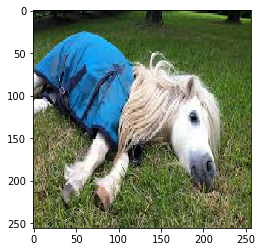

In [23]:
before=load_image('images.jpg')
plt.imshow(before.astype(int))

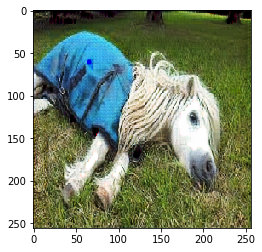

In [24]:
before=(before-127.5)/127.5
before=np.expand_dims(before,axis=0)
after=modelAtoB.predict(before)
plt.imshow((after[0]+1)/2)

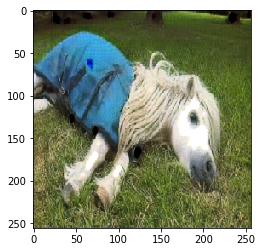

In [25]:
reconstruct=modelBtoA.predict(after)
plt.imshow((reconstruct[0]+1)/2)